In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

In [6]:
image_dir = "abstract_art_512/"
images = [os.path.join(image_dir,image) for image in os.listdir(image_dir)]


In [7]:
len(images)

8145

In [46]:
import shutil
shutil.rmtree('abstract_art_512/.ipynb_checkpoints')
path = 'abstract_art_512/.ipynb_checkpoints'
os.rmdir(path) 

(512, 512, 3)


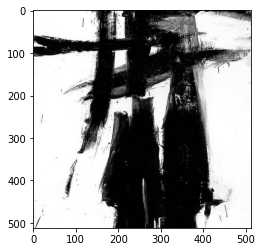

In [8]:
img = plt.imread(images[4])
plt.imshow(img)
print(img.shape)

In [49]:
#preprocessing images by reshaping them with size 64 x 64 and performing normalization.
image_size = 64

def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size,image_size))
    image = image/255.0
    image = tf.reshape(image, shape=(image_size, image_size, 3))
    return image

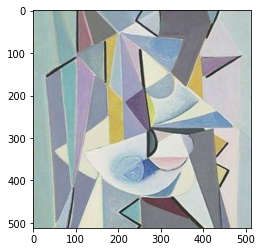

In [10]:
img = preprocess(images[57])
plt.imshow(img)

In [50]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))
print(len(training_dataset))
# map - used for transforming items in a dataset, applying preprocessing step to all items
training_dataset = training_dataset.map(preprocess)
print(len(training_dataset))
training_dataset = training_dataset.shuffle(100).batch(batch_size)
print(len(training_dataset))




8145
8145
64


In [40]:
len(training_dataset)

32

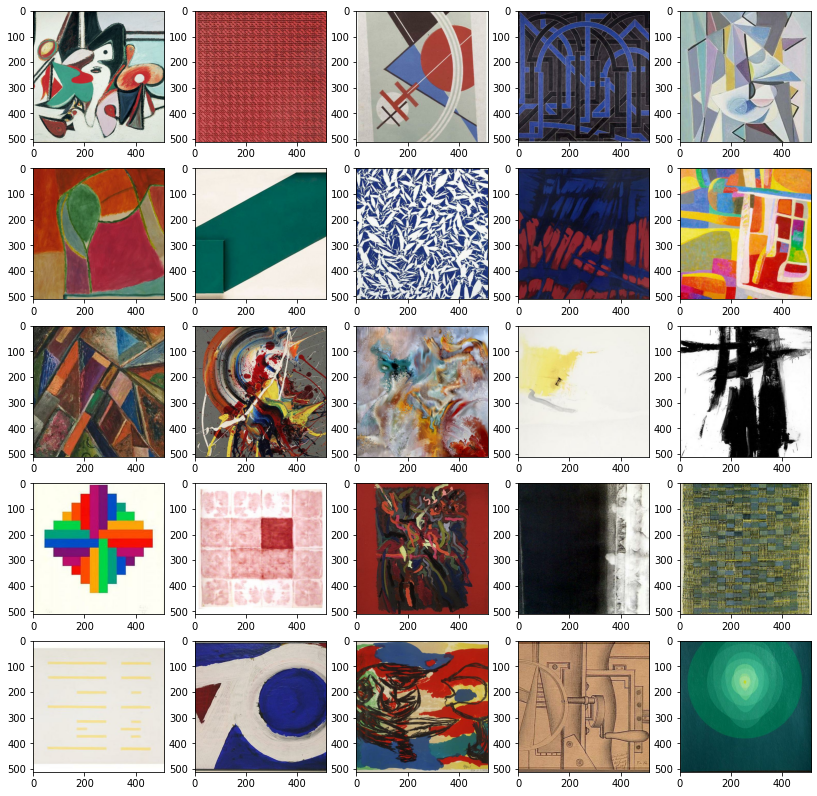

In [41]:
# Visualize input images

fig, axes = plt.subplots(5,5, figsize=(14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]
#print(len(sample))
idx=0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [42]:
latent_dim = 32

In [51]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import selu
from tensorflow.keras.optimizers import Adam
from keras.layers import Multiply, Add
from keras import backend as k

In [52]:
#encoder
encoder_input = Input(shape=(64,64,3))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides=1, padding='same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    
x = Flatten()(x)
x = Dense(1024, activation='selu')(x)
encoder_output = BatchNormalization()(x)

# Sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = k.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma,epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 32)   2432        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 64, 64, 32)   128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 64)   51264       batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [53]:
#decoder
decoder = Sequential()
decoder.add(Dense(1024, activation='selu', input_shape=(latent_dim,), name='First_layer'))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation='selu'))
decoder.add(Reshape((4,4,512)))

## Padding==Same:
# H = H1 * stride where H =output height and H1 is input height; use same formula for output width

decoder.add(Conv2DTranspose(256,(5,5),activation = LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128,(5,5),activation = LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64,(5,5),activation = LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())
                            
decoder.add(Conv2DTranspose(32,(5,5),activation = LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())
                            
decoder.add(Conv2DTranspose(3,(5,5),activation = LeakyReLU(0.02), strides=1, padding='same',name='output'))
decoder.add(BatchNormalization())

decoder.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First_layer (Dense)          (None, 1024)              33792     
_________________________________________________________________
batch_normalization_16 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_5 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       8

In [54]:
#creating decoder model
from keras.layers import Dense,Input
encoded_layer = Input(shape=(latent_dim,), name ='encoded_layer')
decoder_model = Model(encoded_layer, decoder(encoded_layer))
decoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_layer (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         12791503  
Total params: 12,791,503
Trainable params: 12,788,489
Non-trainable params: 3,014
_________________________________________________________________


In [55]:
# Loss function
# vae_loss = Reconstruction_loss + KL_loss


def reconstruction_loss(y, y_pred):
    return (tf.reduce_mean(tf.square(y - y_pred))) 

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 /(64 * 64)) * kl_loss(mu, log_var)
    
    

In [56]:
#create generator

mu, log_var, z = encoder(encoder_input)
reconstructed_output = decoder(z)
vae_model = Model(encoder_input, reconstructed_output, name = 'vae')
loss = kl_loss(mu, log_var)
vae_model.add_loss(loss)
vae_model.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 32), (None,  12818688    input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 3)    12791503    encoder[0][2]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 32)           0           encoder[0][1]                    
________________________________________________________________________________________________

In [58]:
# save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize=(14,14))
    idx=0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = 'output2/'
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch,step))
    plt.close()

In [77]:
# Train the model

random_vector = tf.random.normal(shape=(25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []
optimizer = Adam(0.0005)
epochs = 60

for epoch in range(1, epochs+1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae_model(training_batch)
            y_true = tf.reshape(training_batch, shape=[-1])
            y_pred = tf.reshape(reconstructed, shape=[-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = sum(vae_model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss 
            
            grads = tape.gradient(train_loss, vae_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, vae_model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch : %s - Step: %s - MSE LOSS: %s - KL loss: %s " % (epoch, step, mse_loss.numpy(), kl.numpy()))



Epoch:  1


Epoch : 1 - Step: 0 - MSE LOSS: 0.021122212 - KL loss: 0.67735153 
Epoch : 1 - Step: 1 - MSE LOSS: 0.041697796 - KL loss: 0.75938225 
Epoch : 1 - Step: 2 - MSE LOSS: 0.024379963 - KL loss: 0.62248886 
Epoch : 1 - Step: 3 - MSE LOSS: 0.0325943 - KL loss: 0.59284586 
Epoch : 1 - Step: 4 - MSE LOSS: 0.031887513 - KL loss: 0.62479025 
Epoch : 1 - Step: 5 - MSE LOSS: 0.031460512 - KL loss: 0.67796147 
Epoch : 1 - Step: 6 - MSE LOSS: 0.025185034 - KL loss: 0.67763805 
Epoch : 1 - Step: 7 - MSE LOSS: 0.027040944 - KL loss: 0.6471478 
Epoch : 1 - Step: 8 - MSE LOSS: 0.025505884 - KL loss: 0.7561537 
Epoch : 1 - Step: 9 - MSE LOSS: 0.025697038 - KL loss: 0.7303759 


Epoch : 1 - Step: 10 - MSE LOSS: 0.024104523 - KL loss: 0.7318557 
Epoch : 1 - Step: 11 - MSE LOSS: 0.024709312 - KL loss: 0.78181356 
Epoch : 1 - Step: 12 - MSE LOSS: 0.024251364 - KL loss: 0.65653723 
Epoch : 1 - Step: 13 - MSE LOSS: 0.023140766 - KL loss: 0.66365147 
Epoch : 1 - Step: 14 - MSE LOSS: 0.025819369 - KL loss: 0.60055166 
Epoch : 1 - Step: 15 - MSE LOSS: 0.024893774 - KL loss: 0.58122003 
Epoch : 1 - Step: 16 - MSE LOSS: 0.026010692 - KL loss: 0.62078273 
Epoch : 1 - Step: 17 - MSE LOSS: 0.02244926 - KL loss: 0.59152097 
Epoch : 1 - Step: 18 - MSE LOSS: 0.0269937 - KL loss: 0.67852545 
Epoch : 1 - Step: 19 - MSE LOSS: 0.021589972 - KL loss: 0.6414578 


Epoch : 1 - Step: 20 - MSE LOSS: 0.021520076 - KL loss: 0.6678935 
Epoch : 1 - Step: 21 - MSE LOSS: 0.02081967 - KL loss: 0.7169164 
Epoch : 1 - Step: 22 - MSE LOSS: 0.021157755 - KL loss: 0.7219396 
Epoch : 1 - Step: 23 - MSE LOSS: 0.025585169 - KL loss: 0.70259726 
Epoch : 1 - Step: 24 - MSE LOSS: 0.023497343 - KL loss: 0.71985376 
Epoch : 1 - Step: 25 - MSE LOSS: 0.021967256 - KL loss: 0.6961993 
Epoch : 1 - Step: 26 - MSE LOSS: 0.023084646 - KL loss: 0.6766781 
Epoch : 1 - Step: 27 - MSE LOSS: 0.021310173 - KL loss: 0.63657284 
Epoch : 1 - Step: 28 - MSE LOSS: 0.022078633 - KL loss: 0.6383491 
Epoch : 1 - Step: 29 - MSE LOSS: 0.020879751 - KL loss: 0.68894523 


Epoch : 1 - Step: 30 - MSE LOSS: 0.021992618 - KL loss: 0.629896 
Epoch : 1 - Step: 31 - MSE LOSS: 0.021147965 - KL loss: 0.6523598 
Epoch : 1 - Step: 32 - MSE LOSS: 0.024251869 - KL loss: 0.6569592 
Epoch : 1 - Step: 33 - MSE LOSS: 0.020090416 - KL loss: 0.63218033 
Epoch : 1 - Step: 34 - MSE LOSS: 0.023449512 - KL loss: 0.6319573 
Epoch : 1 - Step: 35 - MSE LOSS: 0.021618212 - KL loss: 0.6834586 
Epoch : 1 - Step: 36 - MSE LOSS: 0.019114008 - KL loss: 0.66713727 
Epoch : 1 - Step: 37 - MSE LOSS: 0.01821203 - KL loss: 0.63901365 
Epoch : 1 - Step: 38 - MSE LOSS: 0.01815034 - KL loss: 0.6690633 
Epoch : 1 - Step: 39 - MSE LOSS: 0.021706851 - KL loss: 0.68477994 


Epoch : 1 - Step: 40 - MSE LOSS: 0.02372249 - KL loss: 0.6868957 
Epoch : 1 - Step: 41 - MSE LOSS: 0.021231785 - KL loss: 0.6838829 
Epoch : 1 - Step: 42 - MSE LOSS: 0.021999627 - KL loss: 0.67023623 
Epoch : 1 - Step: 43 - MSE LOSS: 0.019876428 - KL loss: 0.6722512 
Epoch : 1 - Step: 44 - MSE LOSS: 0.018577201 - KL loss: 0.690347 
Epoch : 1 - Step: 45 - MSE LOSS: 0.021836834 - KL loss: 0.71194285 
Epoch : 1 - Step: 46 - MSE LOSS: 0.020374093 - KL loss: 0.6887048 
Epoch : 1 - Step: 47 - MSE LOSS: 0.022547761 - KL loss: 0.68364644 
Epoch : 1 - Step: 48 - MSE LOSS: 0.02085266 - KL loss: 0.660239 
Epoch : 1 - Step: 49 - MSE LOSS: 0.022637941 - KL loss: 0.7123468 


Epoch : 1 - Step: 50 - MSE LOSS: 0.020583067 - KL loss: 0.6605672 
Epoch : 1 - Step: 51 - MSE LOSS: 0.022033801 - KL loss: 0.674829 
Epoch : 1 - Step: 52 - MSE LOSS: 0.02004985 - KL loss: 0.63511175 
Epoch : 1 - Step: 53 - MSE LOSS: 0.021183513 - KL loss: 0.6854778 
Epoch : 1 - Step: 54 - MSE LOSS: 0.01852755 - KL loss: 0.6709246 
Epoch : 1 - Step: 55 - MSE LOSS: 0.019178191 - KL loss: 0.6812037 
Epoch : 1 - Step: 56 - MSE LOSS: 0.020524876 - KL loss: 0.6304225 
Epoch : 1 - Step: 57 - MSE LOSS: 0.021327956 - KL loss: 0.70657957 
Epoch : 1 - Step: 58 - MSE LOSS: 0.02100802 - KL loss: 0.6719842 
Epoch : 1 - Step: 59 - MSE LOSS: 0.021263905 - KL loss: 0.64333344 


Epoch : 1 - Step: 60 - MSE LOSS: 0.021573907 - KL loss: 0.66877776 
Epoch : 1 - Step: 61 - MSE LOSS: 0.020887159 - KL loss: 0.6931707 
Epoch : 1 - Step: 62 - MSE LOSS: 0.021401396 - KL loss: 0.6546528 
Epoch : 1 - Step: 63 - MSE LOSS: 0.018024221 - KL loss: 0.69287527 
Epoch:  2


Epoch : 2 - Step: 0 - MSE LOSS: 0.019937808 - KL loss: 0.67825806 
Epoch : 2 - Step: 1 - MSE LOSS: 0.021088677 - KL loss: 0.7042562 
Epoch : 2 - Step: 2 - MSE LOSS: 0.019326093 - KL loss: 0.67494076 
Epoch : 2 - Step: 3 - MSE LOSS: 0.020702615 - KL loss: 0.6470683 
Epoch : 2 - Step: 4 - MSE LOSS: 0.021560013 - KL loss: 0.7025529 
Epoch : 2 - Step: 5 - MSE LOSS: 0.018933734 - KL loss: 0.6563938 
Epoch : 2 - Step: 6 - MSE LOSS: 0.020841017 - KL loss: 0.6789678 
Epoch : 2 - Step: 7 - MSE LOSS: 0.02155892 - KL loss: 0.5938176 
Epoch : 2 - Step: 8 - MSE LOSS: 0.020979367 - KL loss: 0.6369363 
Epoch : 2 - Step: 9 - MSE LOSS: 0.019897321 - KL loss: 0.65813935 


Epoch : 2 - Step: 10 - MSE LOSS: 0.020981394 - KL loss: 0.67139393 
Epoch : 2 - Step: 11 - MSE LOSS: 0.022154717 - KL loss: 0.6692844 
Epoch : 2 - Step: 12 - MSE LOSS: 0.018898817 - KL loss: 0.6785229 
Epoch : 2 - Step: 13 - MSE LOSS: 0.01977059 - KL loss: 0.6885679 
Epoch : 2 - Step: 14 - MSE LOSS: 0.019237818 - KL loss: 0.6641075 
Epoch : 2 - Step: 15 - MSE LOSS: 0.02236568 - KL loss: 0.700557 
Epoch : 2 - Step: 16 - MSE LOSS: 0.022076176 - KL loss: 0.66868424 
Epoch : 2 - Step: 17 - MSE LOSS: 0.021474743 - KL loss: 0.6587764 
Epoch : 2 - Step: 18 - MSE LOSS: 0.022124773 - KL loss: 0.6606864 
Epoch : 2 - Step: 19 - MSE LOSS: 0.021737626 - KL loss: 0.6945958 


Epoch : 2 - Step: 20 - MSE LOSS: 0.0203787 - KL loss: 0.6248389 
Epoch : 2 - Step: 21 - MSE LOSS: 0.018287282 - KL loss: 0.6574078 
Epoch : 2 - Step: 22 - MSE LOSS: 0.021345926 - KL loss: 0.65991366 
Epoch : 2 - Step: 23 - MSE LOSS: 0.021787137 - KL loss: 0.67449105 
Epoch : 2 - Step: 24 - MSE LOSS: 0.02324701 - KL loss: 0.6837996 
Epoch : 2 - Step: 25 - MSE LOSS: 0.02189183 - KL loss: 0.6436633 
Epoch : 2 - Step: 26 - MSE LOSS: 0.020204926 - KL loss: 0.7015058 
Epoch : 2 - Step: 27 - MSE LOSS: 0.02013956 - KL loss: 0.6674495 
Epoch : 2 - Step: 28 - MSE LOSS: 0.020545864 - KL loss: 0.65476686 
Epoch : 2 - Step: 29 - MSE LOSS: 0.021601625 - KL loss: 0.6750385 


Epoch : 2 - Step: 30 - MSE LOSS: 0.01993316 - KL loss: 0.6686033 
Epoch : 2 - Step: 31 - MSE LOSS: 0.020189812 - KL loss: 0.69225574 
Epoch : 2 - Step: 32 - MSE LOSS: 0.02092682 - KL loss: 0.6523864 
Epoch : 2 - Step: 33 - MSE LOSS: 0.02043664 - KL loss: 0.6598313 
Epoch : 2 - Step: 34 - MSE LOSS: 0.020376908 - KL loss: 0.6542515 
Epoch : 2 - Step: 35 - MSE LOSS: 0.021977894 - KL loss: 0.65334463 
Epoch : 2 - Step: 36 - MSE LOSS: 0.019971706 - KL loss: 0.7316718 
Epoch : 2 - Step: 37 - MSE LOSS: 0.018354649 - KL loss: 0.6563904 
Epoch : 2 - Step: 38 - MSE LOSS: 0.018351043 - KL loss: 0.6737789 
Epoch : 2 - Step: 39 - MSE LOSS: 0.019154383 - KL loss: 0.653347 


Epoch : 2 - Step: 40 - MSE LOSS: 0.02187786 - KL loss: 0.725844 
Epoch : 2 - Step: 41 - MSE LOSS: 0.022111515 - KL loss: 0.6552145 
Epoch : 2 - Step: 42 - MSE LOSS: 0.019896785 - KL loss: 0.67327785 
Epoch : 2 - Step: 43 - MSE LOSS: 0.019418323 - KL loss: 0.6501974 
Epoch : 2 - Step: 44 - MSE LOSS: 0.018913781 - KL loss: 0.6787065 
Epoch : 2 - Step: 45 - MSE LOSS: 0.021111174 - KL loss: 0.69526255 
Epoch : 2 - Step: 46 - MSE LOSS: 0.022533359 - KL loss: 0.6781758 
Epoch : 2 - Step: 47 - MSE LOSS: 0.02005512 - KL loss: 0.66692054 
Epoch : 2 - Step: 48 - MSE LOSS: 0.020724168 - KL loss: 0.63991797 
Epoch : 2 - Step: 49 - MSE LOSS: 0.0200661 - KL loss: 0.69575214 


Epoch : 2 - Step: 50 - MSE LOSS: 0.022892961 - KL loss: 0.683803 
Epoch : 2 - Step: 51 - MSE LOSS: 0.022777386 - KL loss: 0.64729977 
Epoch : 2 - Step: 52 - MSE LOSS: 0.02081121 - KL loss: 0.65310943 
Epoch : 2 - Step: 53 - MSE LOSS: 0.018488305 - KL loss: 0.64285165 
Epoch : 2 - Step: 54 - MSE LOSS: 0.018577697 - KL loss: 0.6645457 
Epoch : 2 - Step: 55 - MSE LOSS: 0.019628393 - KL loss: 0.70726913 
Epoch : 2 - Step: 56 - MSE LOSS: 0.021209499 - KL loss: 0.6214811 
Epoch : 2 - Step: 57 - MSE LOSS: 0.021619817 - KL loss: 0.6990373 
Epoch : 2 - Step: 58 - MSE LOSS: 0.021067992 - KL loss: 0.6987589 
Epoch : 2 - Step: 59 - MSE LOSS: 0.019301776 - KL loss: 0.68003285 


Epoch : 2 - Step: 60 - MSE LOSS: 0.021630542 - KL loss: 0.66858554 
Epoch : 2 - Step: 61 - MSE LOSS: 0.01999915 - KL loss: 0.6652014 
Epoch : 2 - Step: 62 - MSE LOSS: 0.019080264 - KL loss: 0.73438585 
Epoch : 2 - Step: 63 - MSE LOSS: 0.020137189 - KL loss: 0.6575009 
Epoch:  3


Epoch : 3 - Step: 0 - MSE LOSS: 0.02068144 - KL loss: 0.6967716 
Epoch : 3 - Step: 1 - MSE LOSS: 0.020038284 - KL loss: 0.6401925 
Epoch : 3 - Step: 2 - MSE LOSS: 0.01961462 - KL loss: 0.6486144 
Epoch : 3 - Step: 3 - MSE LOSS: 0.021253427 - KL loss: 0.6863296 
Epoch : 3 - Step: 4 - MSE LOSS: 0.021144412 - KL loss: 0.66308594 
Epoch : 3 - Step: 5 - MSE LOSS: 0.019061571 - KL loss: 0.7008418 
Epoch : 3 - Step: 6 - MSE LOSS: 0.021833241 - KL loss: 0.6429113 
Epoch : 3 - Step: 7 - MSE LOSS: 0.019199317 - KL loss: 0.6164815 
Epoch : 3 - Step: 8 - MSE LOSS: 0.018863134 - KL loss: 0.6821589 
Epoch : 3 - Step: 9 - MSE LOSS: 0.019245328 - KL loss: 0.6880776 


Epoch : 3 - Step: 10 - MSE LOSS: 0.02270724 - KL loss: 0.6734734 
Epoch : 3 - Step: 11 - MSE LOSS: 0.019334191 - KL loss: 0.6440934 
Epoch : 3 - Step: 12 - MSE LOSS: 0.021588424 - KL loss: 0.6692115 
Epoch : 3 - Step: 13 - MSE LOSS: 0.019707898 - KL loss: 0.73431873 
Epoch : 3 - Step: 14 - MSE LOSS: 0.021052605 - KL loss: 0.7020829 
Epoch : 3 - Step: 15 - MSE LOSS: 0.019930499 - KL loss: 0.667075 
Epoch : 3 - Step: 16 - MSE LOSS: 0.021374444 - KL loss: 0.6439036 
Epoch : 3 - Step: 17 - MSE LOSS: 0.020697912 - KL loss: 0.6402993 
Epoch : 3 - Step: 18 - MSE LOSS: 0.021468304 - KL loss: 0.6664917 
Epoch : 3 - Step: 19 - MSE LOSS: 0.021415437 - KL loss: 0.660993 


Epoch : 3 - Step: 20 - MSE LOSS: 0.020284023 - KL loss: 0.70517063 
Epoch : 3 - Step: 21 - MSE LOSS: 0.019848377 - KL loss: 0.6320479 
Epoch : 3 - Step: 22 - MSE LOSS: 0.019421805 - KL loss: 0.6348554 
Epoch : 3 - Step: 23 - MSE LOSS: 0.02414385 - KL loss: 0.7050009 
Epoch : 3 - Step: 24 - MSE LOSS: 0.023439318 - KL loss: 0.6616113 
Epoch : 3 - Step: 25 - MSE LOSS: 0.021370165 - KL loss: 0.63575333 
Epoch : 3 - Step: 26 - MSE LOSS: 0.02103804 - KL loss: 0.6689321 
Epoch : 3 - Step: 27 - MSE LOSS: 0.019629154 - KL loss: 0.6395736 
Epoch : 3 - Step: 28 - MSE LOSS: 0.020752259 - KL loss: 0.6261122 
Epoch : 3 - Step: 29 - MSE LOSS: 0.021281185 - KL loss: 0.6522595 


Epoch : 3 - Step: 30 - MSE LOSS: 0.01926461 - KL loss: 0.65186036 
Epoch : 3 - Step: 31 - MSE LOSS: 0.021316506 - KL loss: 0.6896935 
Epoch : 3 - Step: 32 - MSE LOSS: 0.020890424 - KL loss: 0.6648943 
Epoch : 3 - Step: 33 - MSE LOSS: 0.01967103 - KL loss: 0.64199126 
Epoch : 3 - Step: 34 - MSE LOSS: 0.022555714 - KL loss: 0.66758984 
Epoch : 3 - Step: 35 - MSE LOSS: 0.019494334 - KL loss: 0.72319096 
Epoch : 3 - Step: 36 - MSE LOSS: 0.020777727 - KL loss: 0.66798615 
Epoch : 3 - Step: 37 - MSE LOSS: 0.017285319 - KL loss: 0.67064905 
Epoch : 3 - Step: 38 - MSE LOSS: 0.019013487 - KL loss: 0.6567435 
Epoch : 3 - Step: 39 - MSE LOSS: 0.018914552 - KL loss: 0.6989249 


Epoch : 3 - Step: 40 - MSE LOSS: 0.021044657 - KL loss: 0.6597675 
Epoch : 3 - Step: 41 - MSE LOSS: 0.021615371 - KL loss: 0.71381766 
Epoch : 3 - Step: 42 - MSE LOSS: 0.020208364 - KL loss: 0.6520299 
Epoch : 3 - Step: 43 - MSE LOSS: 0.020924384 - KL loss: 0.6582526 
Epoch : 3 - Step: 44 - MSE LOSS: 0.020122886 - KL loss: 0.6576368 
Epoch : 3 - Step: 45 - MSE LOSS: 0.02031513 - KL loss: 0.6839241 
Epoch : 3 - Step: 46 - MSE LOSS: 0.018723411 - KL loss: 0.6857916 
Epoch : 3 - Step: 47 - MSE LOSS: 0.021985782 - KL loss: 0.663316 
Epoch : 3 - Step: 48 - MSE LOSS: 0.021609208 - KL loss: 0.667125 
Epoch : 3 - Step: 49 - MSE LOSS: 0.021406323 - KL loss: 0.7132714 


Epoch : 3 - Step: 50 - MSE LOSS: 0.019233696 - KL loss: 0.7264501 
Epoch : 3 - Step: 51 - MSE LOSS: 0.022790968 - KL loss: 0.68546194 
Epoch : 3 - Step: 52 - MSE LOSS: 0.020574016 - KL loss: 0.6778195 
Epoch : 3 - Step: 53 - MSE LOSS: 0.019325547 - KL loss: 0.66462284 
Epoch : 3 - Step: 54 - MSE LOSS: 0.019654056 - KL loss: 0.62953633 
Epoch : 3 - Step: 55 - MSE LOSS: 0.018633332 - KL loss: 0.6575244 
Epoch : 3 - Step: 56 - MSE LOSS: 0.021581767 - KL loss: 0.6784621 
Epoch : 3 - Step: 57 - MSE LOSS: 0.023898175 - KL loss: 0.65278196 
Epoch : 3 - Step: 58 - MSE LOSS: 0.019462606 - KL loss: 0.65362555 
Epoch : 3 - Step: 59 - MSE LOSS: 0.020722607 - KL loss: 0.6063528 


Epoch : 3 - Step: 60 - MSE LOSS: 0.020423053 - KL loss: 0.70534474 
Epoch : 3 - Step: 61 - MSE LOSS: 0.019843133 - KL loss: 0.6745939 
Epoch : 3 - Step: 62 - MSE LOSS: 0.019395337 - KL loss: 0.69382805 
Epoch : 3 - Step: 63 - MSE LOSS: 0.02051188 - KL loss: 0.66122806 
Epoch:  4


Epoch : 4 - Step: 0 - MSE LOSS: 0.020192869 - KL loss: 0.7131274 
Epoch : 4 - Step: 1 - MSE LOSS: 0.018754745 - KL loss: 0.67636275 
Epoch : 4 - Step: 2 - MSE LOSS: 0.019755086 - KL loss: 0.70157236 
Epoch : 4 - Step: 3 - MSE LOSS: 0.021110697 - KL loss: 0.66016346 
Epoch : 4 - Step: 4 - MSE LOSS: 0.021516202 - KL loss: 0.67751735 
Epoch : 4 - Step: 5 - MSE LOSS: 0.020310936 - KL loss: 0.69227034 
Epoch : 4 - Step: 6 - MSE LOSS: 0.018541751 - KL loss: 0.64085615 
Epoch : 4 - Step: 7 - MSE LOSS: 0.021147436 - KL loss: 0.63759863 
Epoch : 4 - Step: 8 - MSE LOSS: 0.01966898 - KL loss: 0.6853587 
Epoch : 4 - Step: 9 - MSE LOSS: 0.019356512 - KL loss: 0.65832496 


Epoch : 4 - Step: 10 - MSE LOSS: 0.021193473 - KL loss: 0.69395906 
Epoch : 4 - Step: 11 - MSE LOSS: 0.020510241 - KL loss: 0.655177 
Epoch : 4 - Step: 12 - MSE LOSS: 0.019625692 - KL loss: 0.62559396 
Epoch : 4 - Step: 13 - MSE LOSS: 0.02068984 - KL loss: 0.6574087 
Epoch : 4 - Step: 14 - MSE LOSS: 0.020950986 - KL loss: 0.65292645 
Epoch : 4 - Step: 15 - MSE LOSS: 0.023620488 - KL loss: 0.6443937 
Epoch : 4 - Step: 16 - MSE LOSS: 0.020492913 - KL loss: 0.65841126 
Epoch : 4 - Step: 17 - MSE LOSS: 0.020976827 - KL loss: 0.6797391 
Epoch : 4 - Step: 18 - MSE LOSS: 0.021338128 - KL loss: 0.6662358 
Epoch : 4 - Step: 19 - MSE LOSS: 0.021926396 - KL loss: 0.67786485 


Epoch : 4 - Step: 20 - MSE LOSS: 0.019315718 - KL loss: 0.7094279 
Epoch : 4 - Step: 21 - MSE LOSS: 0.01791364 - KL loss: 0.6628258 
Epoch : 4 - Step: 22 - MSE LOSS: 0.021741027 - KL loss: 0.6633347 
Epoch : 4 - Step: 23 - MSE LOSS: 0.022973215 - KL loss: 0.7123237 
Epoch : 4 - Step: 24 - MSE LOSS: 0.022584805 - KL loss: 0.6416581 
Epoch : 4 - Step: 25 - MSE LOSS: 0.021677949 - KL loss: 0.6844657 
Epoch : 4 - Step: 26 - MSE LOSS: 0.01979202 - KL loss: 0.6731747 
Epoch : 4 - Step: 27 - MSE LOSS: 0.02037564 - KL loss: 0.6636551 
Epoch : 4 - Step: 28 - MSE LOSS: 0.018857801 - KL loss: 0.64350426 
Epoch : 4 - Step: 29 - MSE LOSS: 0.021905245 - KL loss: 0.6897853 


Epoch : 4 - Step: 30 - MSE LOSS: 0.02101055 - KL loss: 0.6703117 
Epoch : 4 - Step: 31 - MSE LOSS: 0.01991991 - KL loss: 0.67962605 
Epoch : 4 - Step: 32 - MSE LOSS: 0.019965393 - KL loss: 0.6374217 
Epoch : 4 - Step: 33 - MSE LOSS: 0.02197486 - KL loss: 0.66612524 
Epoch : 4 - Step: 34 - MSE LOSS: 0.022762889 - KL loss: 0.6293277 
Epoch : 4 - Step: 35 - MSE LOSS: 0.01967448 - KL loss: 0.7023064 
Epoch : 4 - Step: 36 - MSE LOSS: 0.019318707 - KL loss: 0.68991274 
Epoch : 4 - Step: 37 - MSE LOSS: 0.018884974 - KL loss: 0.6603698 
Epoch : 4 - Step: 38 - MSE LOSS: 0.01771999 - KL loss: 0.70545524 
Epoch : 4 - Step: 39 - MSE LOSS: 0.020359278 - KL loss: 0.6874187 


Epoch : 4 - Step: 40 - MSE LOSS: 0.020376256 - KL loss: 0.70472693 
Epoch : 4 - Step: 41 - MSE LOSS: 0.022762308 - KL loss: 0.6735182 
Epoch : 4 - Step: 42 - MSE LOSS: 0.019401595 - KL loss: 0.6524715 
Epoch : 4 - Step: 43 - MSE LOSS: 0.02124839 - KL loss: 0.677887 
Epoch : 4 - Step: 44 - MSE LOSS: 0.019463586 - KL loss: 0.6663421 
Epoch : 4 - Step: 45 - MSE LOSS: 0.021820405 - KL loss: 0.69465363 
Epoch : 4 - Step: 46 - MSE LOSS: 0.020319039 - KL loss: 0.67025614 
Epoch : 4 - Step: 47 - MSE LOSS: 0.022644231 - KL loss: 0.6569581 
Epoch : 4 - Step: 48 - MSE LOSS: 0.018019542 - KL loss: 0.67410165 
Epoch : 4 - Step: 49 - MSE LOSS: 0.022516042 - KL loss: 0.7230071 


Epoch : 4 - Step: 50 - MSE LOSS: 0.018452372 - KL loss: 0.68767595 
Epoch : 4 - Step: 51 - MSE LOSS: 0.023277687 - KL loss: 0.67726314 
Epoch : 4 - Step: 52 - MSE LOSS: 0.020427741 - KL loss: 0.69279873 
Epoch : 4 - Step: 53 - MSE LOSS: 0.020124726 - KL loss: 0.65023404 
Epoch : 4 - Step: 54 - MSE LOSS: 0.018549584 - KL loss: 0.63813937 
Epoch : 4 - Step: 55 - MSE LOSS: 0.020584712 - KL loss: 0.64700663 
Epoch : 4 - Step: 56 - MSE LOSS: 0.019973217 - KL loss: 0.6483884 
Epoch : 4 - Step: 57 - MSE LOSS: 0.02201573 - KL loss: 0.67915225 
Epoch : 4 - Step: 58 - MSE LOSS: 0.022056282 - KL loss: 0.657562 
Epoch : 4 - Step: 59 - MSE LOSS: 0.020172114 - KL loss: 0.65221244 


Epoch : 4 - Step: 60 - MSE LOSS: 0.0200529 - KL loss: 0.65027255 
Epoch : 4 - Step: 61 - MSE LOSS: 0.021289088 - KL loss: 0.6833725 
Epoch : 4 - Step: 62 - MSE LOSS: 0.020085521 - KL loss: 0.6889189 
Epoch : 4 - Step: 63 - MSE LOSS: 0.01681338 - KL loss: 0.7356124 
Epoch:  5


Epoch : 5 - Step: 0 - MSE LOSS: 0.019081423 - KL loss: 0.6884716 
Epoch : 5 - Step: 1 - MSE LOSS: 0.02013339 - KL loss: 0.67418563 
Epoch : 5 - Step: 2 - MSE LOSS: 0.020462746 - KL loss: 0.6954538 
Epoch : 5 - Step: 3 - MSE LOSS: 0.021057202 - KL loss: 0.6420073 
Epoch : 5 - Step: 4 - MSE LOSS: 0.019484067 - KL loss: 0.65703017 
Epoch : 5 - Step: 5 - MSE LOSS: 0.021941667 - KL loss: 0.67548907 
Epoch : 5 - Step: 6 - MSE LOSS: 0.01973945 - KL loss: 0.61888456 
Epoch : 5 - Step: 7 - MSE LOSS: 0.020239264 - KL loss: 0.6099336 
Epoch : 5 - Step: 8 - MSE LOSS: 0.018405015 - KL loss: 0.662691 
Epoch : 5 - Step: 9 - MSE LOSS: 0.022592472 - KL loss: 0.6897758 


Epoch : 5 - Step: 10 - MSE LOSS: 0.020804241 - KL loss: 0.6940042 
Epoch : 5 - Step: 11 - MSE LOSS: 0.02132316 - KL loss: 0.69321597 
Epoch : 5 - Step: 12 - MSE LOSS: 0.019327914 - KL loss: 0.6221484 
Epoch : 5 - Step: 13 - MSE LOSS: 0.02084328 - KL loss: 0.7001196 
Epoch : 5 - Step: 14 - MSE LOSS: 0.019458918 - KL loss: 0.70080996 
Epoch : 5 - Step: 15 - MSE LOSS: 0.021416267 - KL loss: 0.6525835 
Epoch : 5 - Step: 16 - MSE LOSS: 0.02075188 - KL loss: 0.6881133 
Epoch : 5 - Step: 17 - MSE LOSS: 0.021962754 - KL loss: 0.6480686 
Epoch : 5 - Step: 18 - MSE LOSS: 0.023053624 - KL loss: 0.6469313 
Epoch : 5 - Step: 19 - MSE LOSS: 0.019725611 - KL loss: 0.6505151 


Epoch : 5 - Step: 20 - MSE LOSS: 0.01881866 - KL loss: 0.6525707 
Epoch : 5 - Step: 21 - MSE LOSS: 0.02103286 - KL loss: 0.62856233 
Epoch : 5 - Step: 22 - MSE LOSS: 0.01970973 - KL loss: 0.67363405 
Epoch : 5 - Step: 23 - MSE LOSS: 0.023238435 - KL loss: 0.64424235 
Epoch : 5 - Step: 24 - MSE LOSS: 0.022830129 - KL loss: 0.6552638 
Epoch : 5 - Step: 25 - MSE LOSS: 0.022036595 - KL loss: 0.6657146 
Epoch : 5 - Step: 26 - MSE LOSS: 0.018783128 - KL loss: 0.64911836 
Epoch : 5 - Step: 27 - MSE LOSS: 0.021404855 - KL loss: 0.6939055 
Epoch : 5 - Step: 28 - MSE LOSS: 0.01972382 - KL loss: 0.6344914 
Epoch : 5 - Step: 29 - MSE LOSS: 0.0208494 - KL loss: 0.71444225 


Epoch : 5 - Step: 30 - MSE LOSS: 0.018746337 - KL loss: 0.6671553 
Epoch : 5 - Step: 31 - MSE LOSS: 0.021334015 - KL loss: 0.68763685 
Epoch : 5 - Step: 32 - MSE LOSS: 0.022432692 - KL loss: 0.6318083 
Epoch : 5 - Step: 33 - MSE LOSS: 0.02070672 - KL loss: 0.6371852 
Epoch : 5 - Step: 34 - MSE LOSS: 0.021626012 - KL loss: 0.63684887 
Epoch : 5 - Step: 35 - MSE LOSS: 0.020963093 - KL loss: 0.6942358 
Epoch : 5 - Step: 36 - MSE LOSS: 0.021355337 - KL loss: 0.7001699 
Epoch : 5 - Step: 37 - MSE LOSS: 0.017490948 - KL loss: 0.6441101 
Epoch : 5 - Step: 38 - MSE LOSS: 0.017512439 - KL loss: 0.6946659 
Epoch : 5 - Step: 39 - MSE LOSS: 0.019772677 - KL loss: 0.64605314 


Epoch : 5 - Step: 40 - MSE LOSS: 0.021114418 - KL loss: 0.7117481 
Epoch : 5 - Step: 41 - MSE LOSS: 0.02334915 - KL loss: 0.7464367 
Epoch : 5 - Step: 42 - MSE LOSS: 0.01778224 - KL loss: 0.6772789 
Epoch : 5 - Step: 43 - MSE LOSS: 0.020075476 - KL loss: 0.65113413 
Epoch : 5 - Step: 44 - MSE LOSS: 0.02108529 - KL loss: 0.670838 
Epoch : 5 - Step: 45 - MSE LOSS: 0.02057219 - KL loss: 0.6809445 
Epoch : 5 - Step: 46 - MSE LOSS: 0.021400258 - KL loss: 0.70651203 
Epoch : 5 - Step: 47 - MSE LOSS: 0.020521734 - KL loss: 0.60871243 
Epoch : 5 - Step: 48 - MSE LOSS: 0.020309778 - KL loss: 0.6579796 
Epoch : 5 - Step: 49 - MSE LOSS: 0.021354176 - KL loss: 0.7062306 


Epoch : 5 - Step: 50 - MSE LOSS: 0.021205375 - KL loss: 0.68229735 
Epoch : 5 - Step: 51 - MSE LOSS: 0.02196159 - KL loss: 0.6776403 
Epoch : 5 - Step: 52 - MSE LOSS: 0.02044571 - KL loss: 0.7287637 
Epoch : 5 - Step: 53 - MSE LOSS: 0.020701008 - KL loss: 0.68147886 
Epoch : 5 - Step: 54 - MSE LOSS: 0.0195377 - KL loss: 0.70087355 
Epoch : 5 - Step: 55 - MSE LOSS: 0.017936464 - KL loss: 0.6478943 
Epoch : 5 - Step: 56 - MSE LOSS: 0.019201387 - KL loss: 0.6943017 
Epoch : 5 - Step: 57 - MSE LOSS: 0.024246993 - KL loss: 0.6831073 
Epoch : 5 - Step: 58 - MSE LOSS: 0.020870747 - KL loss: 0.65757203 
Epoch : 5 - Step: 59 - MSE LOSS: 0.021403661 - KL loss: 0.6332157 


Epoch : 5 - Step: 60 - MSE LOSS: 0.02083916 - KL loss: 0.6403629 
Epoch : 5 - Step: 61 - MSE LOSS: 0.02046636 - KL loss: 0.66519487 
Epoch : 5 - Step: 62 - MSE LOSS: 0.018702464 - KL loss: 0.6804676 
Epoch : 5 - Step: 63 - MSE LOSS: 0.02019358 - KL loss: 0.6776574 
Epoch:  6


Epoch : 6 - Step: 0 - MSE LOSS: 0.019789021 - KL loss: 0.67966837 
Epoch : 6 - Step: 1 - MSE LOSS: 0.019828586 - KL loss: 0.6905067 
Epoch : 6 - Step: 2 - MSE LOSS: 0.020863285 - KL loss: 0.69850755 
Epoch : 6 - Step: 3 - MSE LOSS: 0.019081276 - KL loss: 0.6694826 
Epoch : 6 - Step: 4 - MSE LOSS: 0.020381095 - KL loss: 0.75590384 
Epoch : 6 - Step: 5 - MSE LOSS: 0.021582523 - KL loss: 0.7280109 
Epoch : 6 - Step: 6 - MSE LOSS: 0.020938126 - KL loss: 0.6781702 
Epoch : 6 - Step: 7 - MSE LOSS: 0.020676875 - KL loss: 0.6337239 
Epoch : 6 - Step: 8 - MSE LOSS: 0.019866176 - KL loss: 0.6432639 
Epoch : 6 - Step: 9 - MSE LOSS: 0.022007965 - KL loss: 0.62763774 


Epoch : 6 - Step: 10 - MSE LOSS: 0.018553376 - KL loss: 0.6536203 
Epoch : 6 - Step: 11 - MSE LOSS: 0.02162238 - KL loss: 0.6939956 
Epoch : 6 - Step: 12 - MSE LOSS: 0.019571299 - KL loss: 0.62297463 
Epoch : 6 - Step: 13 - MSE LOSS: 0.021869218 - KL loss: 0.69344807 
Epoch : 6 - Step: 14 - MSE LOSS: 0.019310793 - KL loss: 0.6461627 
Epoch : 6 - Step: 15 - MSE LOSS: 0.021249598 - KL loss: 0.68762964 
Epoch : 6 - Step: 16 - MSE LOSS: 0.020942463 - KL loss: 0.6993687 
Epoch : 6 - Step: 17 - MSE LOSS: 0.021163868 - KL loss: 0.69466895 
Epoch : 6 - Step: 18 - MSE LOSS: 0.022934964 - KL loss: 0.67433983 
Epoch : 6 - Step: 19 - MSE LOSS: 0.020638188 - KL loss: 0.6880917 


Epoch : 6 - Step: 20 - MSE LOSS: 0.019668909 - KL loss: 0.67594635 
Epoch : 6 - Step: 21 - MSE LOSS: 0.018468967 - KL loss: 0.63156796 
Epoch : 6 - Step: 22 - MSE LOSS: 0.021983245 - KL loss: 0.6688079 
Epoch : 6 - Step: 23 - MSE LOSS: 0.023511885 - KL loss: 0.63474 
Epoch : 6 - Step: 24 - MSE LOSS: 0.022180708 - KL loss: 0.68631524 
Epoch : 6 - Step: 25 - MSE LOSS: 0.021051528 - KL loss: 0.663465 
Epoch : 6 - Step: 26 - MSE LOSS: 0.020494895 - KL loss: 0.6347751 
Epoch : 6 - Step: 27 - MSE LOSS: 0.019826328 - KL loss: 0.65628916 
Epoch : 6 - Step: 28 - MSE LOSS: 0.021061266 - KL loss: 0.64053524 
Epoch : 6 - Step: 29 - MSE LOSS: 0.021101704 - KL loss: 0.6415076 


Epoch : 6 - Step: 30 - MSE LOSS: 0.019559594 - KL loss: 0.6746434 
Epoch : 6 - Step: 31 - MSE LOSS: 0.020862943 - KL loss: 0.7285715 
Epoch : 6 - Step: 32 - MSE LOSS: 0.021197483 - KL loss: 0.6752281 
Epoch : 6 - Step: 33 - MSE LOSS: 0.020626131 - KL loss: 0.64117736 
Epoch : 6 - Step: 34 - MSE LOSS: 0.021675402 - KL loss: 0.6966319 
Epoch : 6 - Step: 35 - MSE LOSS: 0.022505479 - KL loss: 0.734131 
Epoch : 6 - Step: 36 - MSE LOSS: 0.018667955 - KL loss: 0.63659596 
Epoch : 6 - Step: 37 - MSE LOSS: 0.017550692 - KL loss: 0.6725925 
Epoch : 6 - Step: 38 - MSE LOSS: 0.018193794 - KL loss: 0.66908485 
Epoch : 6 - Step: 39 - MSE LOSS: 0.021027168 - KL loss: 0.69804215 


Epoch : 6 - Step: 40 - MSE LOSS: 0.021169243 - KL loss: 0.662661 
Epoch : 6 - Step: 41 - MSE LOSS: 0.022277078 - KL loss: 0.6395986 
Epoch : 6 - Step: 42 - MSE LOSS: 0.019754894 - KL loss: 0.6933244 
Epoch : 6 - Step: 43 - MSE LOSS: 0.020240098 - KL loss: 0.64035374 
Epoch : 6 - Step: 44 - MSE LOSS: 0.01819885 - KL loss: 0.6693997 
Epoch : 6 - Step: 45 - MSE LOSS: 0.021286651 - KL loss: 0.6554975 
Epoch : 6 - Step: 46 - MSE LOSS: 0.020591741 - KL loss: 0.7031103 
Epoch : 6 - Step: 47 - MSE LOSS: 0.020913845 - KL loss: 0.6980811 
Epoch : 6 - Step: 48 - MSE LOSS: 0.021624697 - KL loss: 0.6402596 
Epoch : 6 - Step: 49 - MSE LOSS: 0.020650623 - KL loss: 0.65421575 


Epoch : 6 - Step: 50 - MSE LOSS: 0.022712788 - KL loss: 0.6555543 
Epoch : 6 - Step: 51 - MSE LOSS: 0.021437546 - KL loss: 0.71337914 
Epoch : 6 - Step: 52 - MSE LOSS: 0.02092368 - KL loss: 0.7067573 
Epoch : 6 - Step: 53 - MSE LOSS: 0.019839311 - KL loss: 0.6172894 
Epoch : 6 - Step: 54 - MSE LOSS: 0.017685393 - KL loss: 0.68413705 
Epoch : 6 - Step: 55 - MSE LOSS: 0.019910114 - KL loss: 0.70585084 
Epoch : 6 - Step: 56 - MSE LOSS: 0.020683432 - KL loss: 0.6986127 
Epoch : 6 - Step: 57 - MSE LOSS: 0.023408292 - KL loss: 0.7026824 
Epoch : 6 - Step: 58 - MSE LOSS: 0.02137976 - KL loss: 0.6844811 
Epoch : 6 - Step: 59 - MSE LOSS: 0.01935854 - KL loss: 0.67918956 


Epoch : 6 - Step: 60 - MSE LOSS: 0.019409137 - KL loss: 0.6588869 
Epoch : 6 - Step: 61 - MSE LOSS: 0.021965466 - KL loss: 0.6685066 
Epoch : 6 - Step: 62 - MSE LOSS: 0.021252638 - KL loss: 0.629056 
Epoch : 6 - Step: 63 - MSE LOSS: 0.017794728 - KL loss: 0.6605227 
Epoch:  7


Epoch : 7 - Step: 0 - MSE LOSS: 0.020350082 - KL loss: 0.68661165 
Epoch : 7 - Step: 1 - MSE LOSS: 0.018819364 - KL loss: 0.6888383 
Epoch : 7 - Step: 2 - MSE LOSS: 0.020402674 - KL loss: 0.66265833 
Epoch : 7 - Step: 3 - MSE LOSS: 0.02224079 - KL loss: 0.67802596 
Epoch : 7 - Step: 4 - MSE LOSS: 0.021397501 - KL loss: 0.66666687 
Epoch : 7 - Step: 5 - MSE LOSS: 0.018706612 - KL loss: 0.74110866 
Epoch : 7 - Step: 6 - MSE LOSS: 0.019678365 - KL loss: 0.65264845 
Epoch : 7 - Step: 7 - MSE LOSS: 0.019484581 - KL loss: 0.67911357 
Epoch : 7 - Step: 8 - MSE LOSS: 0.020596843 - KL loss: 0.6812968 
Epoch : 7 - Step: 9 - MSE LOSS: 0.020844588 - KL loss: 0.6285411 


Epoch : 7 - Step: 10 - MSE LOSS: 0.020725291 - KL loss: 0.6633255 
Epoch : 7 - Step: 11 - MSE LOSS: 0.020309577 - KL loss: 0.6033647 
Epoch : 7 - Step: 12 - MSE LOSS: 0.022751741 - KL loss: 0.6794244 
Epoch : 7 - Step: 13 - MSE LOSS: 0.019261137 - KL loss: 0.6375408 
Epoch : 7 - Step: 14 - MSE LOSS: 0.02065025 - KL loss: 0.7260625 
Epoch : 7 - Step: 15 - MSE LOSS: 0.020765847 - KL loss: 0.65919095 
Epoch : 7 - Step: 16 - MSE LOSS: 0.022563076 - KL loss: 0.66416526 
Epoch : 7 - Step: 17 - MSE LOSS: 0.020881189 - KL loss: 0.6701398 
Epoch : 7 - Step: 18 - MSE LOSS: 0.023204282 - KL loss: 0.729877 
Epoch : 7 - Step: 19 - MSE LOSS: 0.020066904 - KL loss: 0.7036577 


Epoch : 7 - Step: 20 - MSE LOSS: 0.017366523 - KL loss: 0.69055 
Epoch : 7 - Step: 21 - MSE LOSS: 0.019335998 - KL loss: 0.64098376 
Epoch : 7 - Step: 22 - MSE LOSS: 0.021059014 - KL loss: 0.67475367 
Epoch : 7 - Step: 23 - MSE LOSS: 0.02241203 - KL loss: 0.60522294 
Epoch : 7 - Step: 24 - MSE LOSS: 0.024126397 - KL loss: 0.6489734 
Epoch : 7 - Step: 25 - MSE LOSS: 0.021689126 - KL loss: 0.65663826 
Epoch : 7 - Step: 26 - MSE LOSS: 0.020829096 - KL loss: 0.6940826 
Epoch : 7 - Step: 27 - MSE LOSS: 0.019781638 - KL loss: 0.602372 
Epoch : 7 - Step: 28 - MSE LOSS: 0.020177506 - KL loss: 0.64099616 
Epoch : 7 - Step: 29 - MSE LOSS: 0.021335552 - KL loss: 0.6912486 


Epoch : 7 - Step: 30 - MSE LOSS: 0.021052929 - KL loss: 0.69344854 
Epoch : 7 - Step: 31 - MSE LOSS: 0.021096664 - KL loss: 0.6462223 
Epoch : 7 - Step: 32 - MSE LOSS: 0.020440476 - KL loss: 0.67379975 
Epoch : 7 - Step: 33 - MSE LOSS: 0.021383703 - KL loss: 0.6899136 
Epoch : 7 - Step: 34 - MSE LOSS: 0.019625597 - KL loss: 0.6543439 
Epoch : 7 - Step: 35 - MSE LOSS: 0.02225952 - KL loss: 0.7069679 
Epoch : 7 - Step: 36 - MSE LOSS: 0.019552635 - KL loss: 0.715253 
Epoch : 7 - Step: 37 - MSE LOSS: 0.018158043 - KL loss: 0.67500955 
Epoch : 7 - Step: 38 - MSE LOSS: 0.018123731 - KL loss: 0.6765089 
Epoch : 7 - Step: 39 - MSE LOSS: 0.018671438 - KL loss: 0.68445325 


Epoch : 7 - Step: 40 - MSE LOSS: 0.021845922 - KL loss: 0.70682317 
Epoch : 7 - Step: 41 - MSE LOSS: 0.022630073 - KL loss: 0.6504104 
Epoch : 7 - Step: 42 - MSE LOSS: 0.019143445 - KL loss: 0.658624 
Epoch : 7 - Step: 43 - MSE LOSS: 0.022260532 - KL loss: 0.6404305 
Epoch : 7 - Step: 44 - MSE LOSS: 0.020099323 - KL loss: 0.65015095 
Epoch : 7 - Step: 45 - MSE LOSS: 0.020984769 - KL loss: 0.66861 
Epoch : 7 - Step: 46 - MSE LOSS: 0.021439662 - KL loss: 0.6979744 
Epoch : 7 - Step: 47 - MSE LOSS: 0.02002223 - KL loss: 0.7153272 
Epoch : 7 - Step: 48 - MSE LOSS: 0.019875864 - KL loss: 0.67948467 
Epoch : 7 - Step: 49 - MSE LOSS: 0.020614415 - KL loss: 0.703161 


Epoch : 7 - Step: 50 - MSE LOSS: 0.021134593 - KL loss: 0.6928693 
Epoch : 7 - Step: 51 - MSE LOSS: 0.022466876 - KL loss: 0.6974577 
Epoch : 7 - Step: 52 - MSE LOSS: 0.019364301 - KL loss: 0.6571972 
Epoch : 7 - Step: 53 - MSE LOSS: 0.02205926 - KL loss: 0.65110385 
Epoch : 7 - Step: 54 - MSE LOSS: 0.018975332 - KL loss: 0.624951 
Epoch : 7 - Step: 55 - MSE LOSS: 0.019490197 - KL loss: 0.6634618 
Epoch : 7 - Step: 56 - MSE LOSS: 0.019384272 - KL loss: 0.6792348 
Epoch : 7 - Step: 57 - MSE LOSS: 0.024491286 - KL loss: 0.6703032 
Epoch : 7 - Step: 58 - MSE LOSS: 0.019864874 - KL loss: 0.6813795 
Epoch : 7 - Step: 59 - MSE LOSS: 0.023290718 - KL loss: 0.667388 


Epoch : 7 - Step: 60 - MSE LOSS: 0.017900283 - KL loss: 0.68635815 
Epoch : 7 - Step: 61 - MSE LOSS: 0.020446254 - KL loss: 0.6610419 
Epoch : 7 - Step: 62 - MSE LOSS: 0.018816294 - KL loss: 0.68210727 
Epoch : 7 - Step: 63 - MSE LOSS: 0.020450274 - KL loss: 0.71902424 
Epoch:  8


Epoch : 8 - Step: 0 - MSE LOSS: 0.020322679 - KL loss: 0.6866124 
Epoch : 8 - Step: 1 - MSE LOSS: 0.017875977 - KL loss: 0.67889696 
Epoch : 8 - Step: 2 - MSE LOSS: 0.021559618 - KL loss: 0.6653053 
Epoch : 8 - Step: 3 - MSE LOSS: 0.021219661 - KL loss: 0.6560809 
Epoch : 8 - Step: 4 - MSE LOSS: 0.020334153 - KL loss: 0.6435853 
Epoch : 8 - Step: 5 - MSE LOSS: 0.022081785 - KL loss: 0.7467744 
Epoch : 8 - Step: 6 - MSE LOSS: 0.019019864 - KL loss: 0.6999405 
Epoch : 8 - Step: 7 - MSE LOSS: 0.020711621 - KL loss: 0.63720274 
Epoch : 8 - Step: 8 - MSE LOSS: 0.019695945 - KL loss: 0.7041057 
Epoch : 8 - Step: 9 - MSE LOSS: 0.019928953 - KL loss: 0.6822275 


Epoch : 8 - Step: 10 - MSE LOSS: 0.021137394 - KL loss: 0.66559964 
Epoch : 8 - Step: 11 - MSE LOSS: 0.021941096 - KL loss: 0.6452335 
Epoch : 8 - Step: 12 - MSE LOSS: 0.01992037 - KL loss: 0.63554996 
Epoch : 8 - Step: 13 - MSE LOSS: 0.020321285 - KL loss: 0.6619258 
Epoch : 8 - Step: 14 - MSE LOSS: 0.019317104 - KL loss: 0.6742964 
Epoch : 8 - Step: 15 - MSE LOSS: 0.02225067 - KL loss: 0.6581563 
Epoch : 8 - Step: 16 - MSE LOSS: 0.023909131 - KL loss: 0.6771425 
Epoch : 8 - Step: 17 - MSE LOSS: 0.019842632 - KL loss: 0.65167594 
Epoch : 8 - Step: 18 - MSE LOSS: 0.021311114 - KL loss: 0.64281815 
Epoch : 8 - Step: 19 - MSE LOSS: 0.02290885 - KL loss: 0.7274653 


Epoch : 8 - Step: 20 - MSE LOSS: 0.01888194 - KL loss: 0.6603673 
Epoch : 8 - Step: 21 - MSE LOSS: 0.018593462 - KL loss: 0.6336266 
Epoch : 8 - Step: 22 - MSE LOSS: 0.022245271 - KL loss: 0.6745765 
Epoch : 8 - Step: 23 - MSE LOSS: 0.022851609 - KL loss: 0.6448342 
Epoch : 8 - Step: 24 - MSE LOSS: 0.022960318 - KL loss: 0.7125561 
Epoch : 8 - Step: 25 - MSE LOSS: 0.021739254 - KL loss: 0.64490736 
Epoch : 8 - Step: 26 - MSE LOSS: 0.018848432 - KL loss: 0.66544425 
Epoch : 8 - Step: 27 - MSE LOSS: 0.02050186 - KL loss: 0.6482155 
Epoch : 8 - Step: 28 - MSE LOSS: 0.022042379 - KL loss: 0.62464726 
Epoch : 8 - Step: 29 - MSE LOSS: 0.020234408 - KL loss: 0.6658649 


Epoch : 8 - Step: 30 - MSE LOSS: 0.020485768 - KL loss: 0.7123607 
Epoch : 8 - Step: 31 - MSE LOSS: 0.020684347 - KL loss: 0.70006675 
Epoch : 8 - Step: 32 - MSE LOSS: 0.02080787 - KL loss: 0.65410733 
Epoch : 8 - Step: 33 - MSE LOSS: 0.018687202 - KL loss: 0.6629311 
Epoch : 8 - Step: 34 - MSE LOSS: 0.024068536 - KL loss: 0.64039 
Epoch : 8 - Step: 35 - MSE LOSS: 0.02048674 - KL loss: 0.6986775 
Epoch : 8 - Step: 36 - MSE LOSS: 0.020490317 - KL loss: 0.7070761 
Epoch : 8 - Step: 37 - MSE LOSS: 0.016818501 - KL loss: 0.6834286 
Epoch : 8 - Step: 38 - MSE LOSS: 0.018697942 - KL loss: 0.6830536 
Epoch : 8 - Step: 39 - MSE LOSS: 0.021695947 - KL loss: 0.66004586 


Epoch : 8 - Step: 40 - MSE LOSS: 0.019782247 - KL loss: 0.6845489 
Epoch : 8 - Step: 41 - MSE LOSS: 0.021043105 - KL loss: 0.71490294 
Epoch : 8 - Step: 42 - MSE LOSS: 0.021727934 - KL loss: 0.6551353 
Epoch : 8 - Step: 43 - MSE LOSS: 0.01854673 - KL loss: 0.6827201 
Epoch : 8 - Step: 44 - MSE LOSS: 0.021424405 - KL loss: 0.6845306 
Epoch : 8 - Step: 45 - MSE LOSS: 0.020585982 - KL loss: 0.636464 
Epoch : 8 - Step: 46 - MSE LOSS: 0.02022818 - KL loss: 0.6782365 
Epoch : 8 - Step: 47 - MSE LOSS: 0.02261197 - KL loss: 0.66173226 
Epoch : 8 - Step: 48 - MSE LOSS: 0.020595977 - KL loss: 0.66715944 
Epoch : 8 - Step: 49 - MSE LOSS: 0.019550854 - KL loss: 0.6990071 


Epoch : 8 - Step: 50 - MSE LOSS: 0.022306776 - KL loss: 0.71341634 
Epoch : 8 - Step: 51 - MSE LOSS: 0.021706698 - KL loss: 0.66351527 
Epoch : 8 - Step: 52 - MSE LOSS: 0.020060705 - KL loss: 0.6557029 
Epoch : 8 - Step: 53 - MSE LOSS: 0.021133512 - KL loss: 0.63000035 
Epoch : 8 - Step: 54 - MSE LOSS: 0.020044433 - KL loss: 0.6890285 
Epoch : 8 - Step: 55 - MSE LOSS: 0.017851437 - KL loss: 0.66116834 
Epoch : 8 - Step: 56 - MSE LOSS: 0.020674432 - KL loss: 0.6882416 
Epoch : 8 - Step: 57 - MSE LOSS: 0.022184499 - KL loss: 0.65200704 
Epoch : 8 - Step: 58 - MSE LOSS: 0.022050677 - KL loss: 0.70766187 
Epoch : 8 - Step: 59 - MSE LOSS: 0.021058993 - KL loss: 0.660038 


Epoch : 8 - Step: 60 - MSE LOSS: 0.020434873 - KL loss: 0.6777398 
Epoch : 8 - Step: 61 - MSE LOSS: 0.01953328 - KL loss: 0.64301914 
Epoch : 8 - Step: 62 - MSE LOSS: 0.019518346 - KL loss: 0.75237876 
Epoch : 8 - Step: 63 - MSE LOSS: 0.019436516 - KL loss: 0.59370136 
Epoch:  9


Epoch : 9 - Step: 0 - MSE LOSS: 0.018165095 - KL loss: 0.70134693 
Epoch : 9 - Step: 1 - MSE LOSS: 0.019929023 - KL loss: 0.71952605 
Epoch : 9 - Step: 2 - MSE LOSS: 0.021728098 - KL loss: 0.6404222 
Epoch : 9 - Step: 3 - MSE LOSS: 0.02165732 - KL loss: 0.64893425 
Epoch : 9 - Step: 4 - MSE LOSS: 0.020392621 - KL loss: 0.68529004 
Epoch : 9 - Step: 5 - MSE LOSS: 0.019996097 - KL loss: 0.7111248 
Epoch : 9 - Step: 6 - MSE LOSS: 0.020144388 - KL loss: 0.6819776 
Epoch : 9 - Step: 7 - MSE LOSS: 0.021121511 - KL loss: 0.6309434 
Epoch : 9 - Step: 8 - MSE LOSS: 0.019792406 - KL loss: 0.6981003 
Epoch : 9 - Step: 9 - MSE LOSS: 0.019266361 - KL loss: 0.6818669 


Epoch : 9 - Step: 10 - MSE LOSS: 0.0198535 - KL loss: 0.6870705 
Epoch : 9 - Step: 11 - MSE LOSS: 0.019971143 - KL loss: 0.62573785 
Epoch : 9 - Step: 12 - MSE LOSS: 0.022935703 - KL loss: 0.61885166 
Epoch : 9 - Step: 13 - MSE LOSS: 0.021373875 - KL loss: 0.6524464 
Epoch : 9 - Step: 14 - MSE LOSS: 0.019845527 - KL loss: 0.6478499 
Epoch : 9 - Step: 15 - MSE LOSS: 0.02194503 - KL loss: 0.66332227 
Epoch : 9 - Step: 16 - MSE LOSS: 0.021569865 - KL loss: 0.6522836 
Epoch : 9 - Step: 17 - MSE LOSS: 0.021729408 - KL loss: 0.6802975 
Epoch : 9 - Step: 18 - MSE LOSS: 0.020077612 - KL loss: 0.6826589 
Epoch : 9 - Step: 19 - MSE LOSS: 0.021696726 - KL loss: 0.68688 


Epoch : 9 - Step: 20 - MSE LOSS: 0.018959658 - KL loss: 0.6937288 
Epoch : 9 - Step: 21 - MSE LOSS: 0.019409379 - KL loss: 0.69802505 
Epoch : 9 - Step: 22 - MSE LOSS: 0.021869672 - KL loss: 0.6417302 
Epoch : 9 - Step: 23 - MSE LOSS: 0.02290745 - KL loss: 0.60956687 
Epoch : 9 - Step: 24 - MSE LOSS: 0.022292279 - KL loss: 0.68634456 
Epoch : 9 - Step: 25 - MSE LOSS: 0.020406505 - KL loss: 0.63110596 
Epoch : 9 - Step: 26 - MSE LOSS: 0.020907363 - KL loss: 0.64954436 
Epoch : 9 - Step: 27 - MSE LOSS: 0.019932533 - KL loss: 0.6745557 
Epoch : 9 - Step: 28 - MSE LOSS: 0.021779835 - KL loss: 0.6063917 
Epoch : 9 - Step: 29 - MSE LOSS: 0.020904541 - KL loss: 0.6450199 


Epoch : 9 - Step: 30 - MSE LOSS: 0.019903056 - KL loss: 0.68307126 
Epoch : 9 - Step: 31 - MSE LOSS: 0.021513797 - KL loss: 0.66647476 
Epoch : 9 - Step: 32 - MSE LOSS: 0.021271115 - KL loss: 0.6545819 
Epoch : 9 - Step: 33 - MSE LOSS: 0.019430133 - KL loss: 0.71142566 
Epoch : 9 - Step: 34 - MSE LOSS: 0.022410007 - KL loss: 0.66960174 
Epoch : 9 - Step: 35 - MSE LOSS: 0.020550786 - KL loss: 0.7442352 
Epoch : 9 - Step: 36 - MSE LOSS: 0.019173997 - KL loss: 0.6856575 
Epoch : 9 - Step: 37 - MSE LOSS: 0.017890738 - KL loss: 0.6423819 
Epoch : 9 - Step: 38 - MSE LOSS: 0.020834556 - KL loss: 0.6910733 
Epoch : 9 - Step: 39 - MSE LOSS: 0.018480325 - KL loss: 0.7042752 


Epoch : 9 - Step: 40 - MSE LOSS: 0.02201842 - KL loss: 0.6832747 
Epoch : 9 - Step: 41 - MSE LOSS: 0.020978615 - KL loss: 0.6896269 
Epoch : 9 - Step: 42 - MSE LOSS: 0.020266494 - KL loss: 0.6307999 
Epoch : 9 - Step: 43 - MSE LOSS: 0.017935451 - KL loss: 0.67478347 
Epoch : 9 - Step: 44 - MSE LOSS: 0.02183716 - KL loss: 0.6963449 
Epoch : 9 - Step: 45 - MSE LOSS: 0.020182243 - KL loss: 0.69045895 
Epoch : 9 - Step: 46 - MSE LOSS: 0.020016495 - KL loss: 0.6415518 
Epoch : 9 - Step: 47 - MSE LOSS: 0.023094667 - KL loss: 0.6862348 
Epoch : 9 - Step: 48 - MSE LOSS: 0.019922204 - KL loss: 0.6432563 
Epoch : 9 - Step: 49 - MSE LOSS: 0.021835953 - KL loss: 0.68447316 


Epoch : 9 - Step: 50 - MSE LOSS: 0.021705106 - KL loss: 0.62637925 
Epoch : 9 - Step: 51 - MSE LOSS: 0.01951717 - KL loss: 0.72736907 
Epoch : 9 - Step: 52 - MSE LOSS: 0.02131302 - KL loss: 0.727195 
Epoch : 9 - Step: 53 - MSE LOSS: 0.021044308 - KL loss: 0.6787953 
Epoch : 9 - Step: 54 - MSE LOSS: 0.018552942 - KL loss: 0.6802219 
Epoch : 9 - Step: 55 - MSE LOSS: 0.018286254 - KL loss: 0.6951088 
Epoch : 9 - Step: 56 - MSE LOSS: 0.019337153 - KL loss: 0.63167626 
Epoch : 9 - Step: 57 - MSE LOSS: 0.024100857 - KL loss: 0.6954692 
Epoch : 9 - Step: 58 - MSE LOSS: 0.021181032 - KL loss: 0.700503 
Epoch : 9 - Step: 59 - MSE LOSS: 0.021310985 - KL loss: 0.63203 


Epoch : 9 - Step: 60 - MSE LOSS: 0.020293789 - KL loss: 0.7059953 
Epoch : 9 - Step: 61 - MSE LOSS: 0.02050635 - KL loss: 0.642869 
Epoch : 9 - Step: 62 - MSE LOSS: 0.019312834 - KL loss: 0.64406604 
Epoch : 9 - Step: 63 - MSE LOSS: 0.019374888 - KL loss: 0.67434406 
Epoch:  10


Epoch : 10 - Step: 0 - MSE LOSS: 0.020772757 - KL loss: 0.6726483 
Epoch : 10 - Step: 1 - MSE LOSS: 0.019691722 - KL loss: 0.67179567 
Epoch : 10 - Step: 2 - MSE LOSS: 0.0198535 - KL loss: 0.6554908 
Epoch : 10 - Step: 3 - MSE LOSS: 0.020921448 - KL loss: 0.69230974 
Epoch : 10 - Step: 4 - MSE LOSS: 0.020056846 - KL loss: 0.7041757 
Epoch : 10 - Step: 5 - MSE LOSS: 0.021136487 - KL loss: 0.73766154 
Epoch : 10 - Step: 6 - MSE LOSS: 0.020312106 - KL loss: 0.64777976 
Epoch : 10 - Step: 7 - MSE LOSS: 0.020025233 - KL loss: 0.63140106 
Epoch : 10 - Step: 8 - MSE LOSS: 0.019540058 - KL loss: 0.67631215 
Epoch : 10 - Step: 9 - MSE LOSS: 0.02044815 - KL loss: 0.6787037 


Epoch : 10 - Step: 10 - MSE LOSS: 0.019925423 - KL loss: 0.70717496 
Epoch : 10 - Step: 11 - MSE LOSS: 0.019667074 - KL loss: 0.6396918 
Epoch : 10 - Step: 12 - MSE LOSS: 0.023634538 - KL loss: 0.6885793 
Epoch : 10 - Step: 13 - MSE LOSS: 0.01780664 - KL loss: 0.63981456 
Epoch : 10 - Step: 14 - MSE LOSS: 0.021772852 - KL loss: 0.6661272 
Epoch : 10 - Step: 15 - MSE LOSS: 0.021701785 - KL loss: 0.6784701 
Epoch : 10 - Step: 16 - MSE LOSS: 0.021593638 - KL loss: 0.65921426 
Epoch : 10 - Step: 17 - MSE LOSS: 0.019266963 - KL loss: 0.6537204 
Epoch : 10 - Step: 18 - MSE LOSS: 0.019219471 - KL loss: 0.6804259 
Epoch : 10 - Step: 19 - MSE LOSS: 0.021005409 - KL loss: 0.6941387 


Epoch : 10 - Step: 20 - MSE LOSS: 0.02153373 - KL loss: 0.6953709 
Epoch : 10 - Step: 21 - MSE LOSS: 0.019651737 - KL loss: 0.68291765 
Epoch : 10 - Step: 22 - MSE LOSS: 0.021551646 - KL loss: 0.6371887 
Epoch : 10 - Step: 23 - MSE LOSS: 0.02220586 - KL loss: 0.64499265 
Epoch : 10 - Step: 24 - MSE LOSS: 0.020614507 - KL loss: 0.66660976 
Epoch : 10 - Step: 25 - MSE LOSS: 0.022975504 - KL loss: 0.66600513 
Epoch : 10 - Step: 26 - MSE LOSS: 0.020417945 - KL loss: 0.6733073 
Epoch : 10 - Step: 27 - MSE LOSS: 0.022478484 - KL loss: 0.6585713 
Epoch : 10 - Step: 28 - MSE LOSS: 0.019405967 - KL loss: 0.61520076 
Epoch : 10 - Step: 29 - MSE LOSS: 0.01971755 - KL loss: 0.7049203 


Epoch : 10 - Step: 30 - MSE LOSS: 0.020456303 - KL loss: 0.711064 
Epoch : 10 - Step: 31 - MSE LOSS: 0.021291366 - KL loss: 0.66900027 
Epoch : 10 - Step: 32 - MSE LOSS: 0.020779476 - KL loss: 0.65750784 
Epoch : 10 - Step: 33 - MSE LOSS: 0.020201232 - KL loss: 0.6763654 
Epoch : 10 - Step: 34 - MSE LOSS: 0.022612294 - KL loss: 0.63363385 
Epoch : 10 - Step: 35 - MSE LOSS: 0.020949146 - KL loss: 0.71687293 
Epoch : 10 - Step: 36 - MSE LOSS: 0.019902157 - KL loss: 0.6458888 
Epoch : 10 - Step: 37 - MSE LOSS: 0.017532958 - KL loss: 0.6610555 
Epoch : 10 - Step: 38 - MSE LOSS: 0.0197007 - KL loss: 0.642678 
Epoch : 10 - Step: 39 - MSE LOSS: 0.018635254 - KL loss: 0.68944025 


Epoch : 10 - Step: 40 - MSE LOSS: 0.02356807 - KL loss: 0.72111547 
Epoch : 10 - Step: 41 - MSE LOSS: 0.021143347 - KL loss: 0.6869606 
Epoch : 10 - Step: 42 - MSE LOSS: 0.019825293 - KL loss: 0.6582235 
Epoch : 10 - Step: 43 - MSE LOSS: 0.020976404 - KL loss: 0.6821288 
Epoch : 10 - Step: 44 - MSE LOSS: 0.019516494 - KL loss: 0.6613789 
Epoch : 10 - Step: 45 - MSE LOSS: 0.019163659 - KL loss: 0.7428947 
Epoch : 10 - Step: 46 - MSE LOSS: 0.021461772 - KL loss: 0.7099233 
Epoch : 10 - Step: 47 - MSE LOSS: 0.021848323 - KL loss: 0.68243897 
Epoch : 10 - Step: 48 - MSE LOSS: 0.019872418 - KL loss: 0.67982185 
Epoch : 10 - Step: 49 - MSE LOSS: 0.020726843 - KL loss: 0.6951275 


Epoch : 10 - Step: 50 - MSE LOSS: 0.021066226 - KL loss: 0.6441591 
Epoch : 10 - Step: 51 - MSE LOSS: 0.024662225 - KL loss: 0.63305134 
Epoch : 10 - Step: 52 - MSE LOSS: 0.018624948 - KL loss: 0.642546 
Epoch : 10 - Step: 53 - MSE LOSS: 0.020202698 - KL loss: 0.67571294 
Epoch : 10 - Step: 54 - MSE LOSS: 0.020535456 - KL loss: 0.67918503 
Epoch : 10 - Step: 55 - MSE LOSS: 0.019715734 - KL loss: 0.6756707 
Epoch : 10 - Step: 56 - MSE LOSS: 0.020949459 - KL loss: 0.68427914 
Epoch : 10 - Step: 57 - MSE LOSS: 0.021849336 - KL loss: 0.6875522 
Epoch : 10 - Step: 58 - MSE LOSS: 0.021204563 - KL loss: 0.6836737 
Epoch : 10 - Step: 59 - MSE LOSS: 0.018647553 - KL loss: 0.7095455 


Epoch : 10 - Step: 60 - MSE LOSS: 0.019517789 - KL loss: 0.67165524 
Epoch : 10 - Step: 61 - MSE LOSS: 0.022644795 - KL loss: 0.67593926 
Epoch : 10 - Step: 62 - MSE LOSS: 0.019029362 - KL loss: 0.68067443 
Epoch : 10 - Step: 63 - MSE LOSS: 0.019547828 - KL loss: 0.63224936 
Epoch:  11


Epoch : 11 - Step: 0 - MSE LOSS: 0.020170625 - KL loss: 0.6804246 
Epoch : 11 - Step: 1 - MSE LOSS: 0.01955954 - KL loss: 0.69800854 
Epoch : 11 - Step: 2 - MSE LOSS: 0.020820044 - KL loss: 0.6570267 
Epoch : 11 - Step: 3 - MSE LOSS: 0.020297732 - KL loss: 0.6573765 
Epoch : 11 - Step: 4 - MSE LOSS: 0.020323671 - KL loss: 0.71667886 
Epoch : 11 - Step: 5 - MSE LOSS: 0.021484941 - KL loss: 0.67856944 
Epoch : 11 - Step: 6 - MSE LOSS: 0.018471805 - KL loss: 0.7072799 
Epoch : 11 - Step: 7 - MSE LOSS: 0.020124737 - KL loss: 0.6366881 
Epoch : 11 - Step: 8 - MSE LOSS: 0.021538211 - KL loss: 0.68797106 
Epoch : 11 - Step: 9 - MSE LOSS: 0.019870935 - KL loss: 0.6521512 


Epoch : 11 - Step: 10 - MSE LOSS: 0.021275768 - KL loss: 0.6709659 
Epoch : 11 - Step: 11 - MSE LOSS: 0.019945322 - KL loss: 0.659493 
Epoch : 11 - Step: 12 - MSE LOSS: 0.021363841 - KL loss: 0.62767404 
Epoch : 11 - Step: 13 - MSE LOSS: 0.019731723 - KL loss: 0.68288827 
Epoch : 11 - Step: 14 - MSE LOSS: 0.021578567 - KL loss: 0.6779848 
Epoch : 11 - Step: 15 - MSE LOSS: 0.021871408 - KL loss: 0.6717048 
Epoch : 11 - Step: 16 - MSE LOSS: 0.020384595 - KL loss: 0.6909133 
Epoch : 11 - Step: 17 - MSE LOSS: 0.019696955 - KL loss: 0.6991396 
Epoch : 11 - Step: 18 - MSE LOSS: 0.023276491 - KL loss: 0.6652575 
Epoch : 11 - Step: 19 - MSE LOSS: 0.021165429 - KL loss: 0.68331474 


Epoch : 11 - Step: 20 - MSE LOSS: 0.018199993 - KL loss: 0.6806087 
Epoch : 11 - Step: 21 - MSE LOSS: 0.018384257 - KL loss: 0.62981695 
Epoch : 11 - Step: 22 - MSE LOSS: 0.022556683 - KL loss: 0.648468 
Epoch : 11 - Step: 23 - MSE LOSS: 0.021812856 - KL loss: 0.65862 
Epoch : 11 - Step: 24 - MSE LOSS: 0.022786744 - KL loss: 0.68803495 
Epoch : 11 - Step: 25 - MSE LOSS: 0.022452286 - KL loss: 0.6363417 
Epoch : 11 - Step: 26 - MSE LOSS: 0.020161267 - KL loss: 0.6913418 
Epoch : 11 - Step: 27 - MSE LOSS: 0.021686174 - KL loss: 0.643062 
Epoch : 11 - Step: 28 - MSE LOSS: 0.019201316 - KL loss: 0.6753673 
Epoch : 11 - Step: 29 - MSE LOSS: 0.020590188 - KL loss: 0.63918185 


Epoch : 11 - Step: 30 - MSE LOSS: 0.01832045 - KL loss: 0.708289 
Epoch : 11 - Step: 31 - MSE LOSS: 0.022938753 - KL loss: 0.7038487 
Epoch : 11 - Step: 32 - MSE LOSS: 0.022868708 - KL loss: 0.63725483 
Epoch : 11 - Step: 33 - MSE LOSS: 0.019559076 - KL loss: 0.67798364 
Epoch : 11 - Step: 34 - MSE LOSS: 0.02131515 - KL loss: 0.7105297 
Epoch : 11 - Step: 35 - MSE LOSS: 0.022174573 - KL loss: 0.68731755 
Epoch : 11 - Step: 36 - MSE LOSS: 0.0185278 - KL loss: 0.67227185 
Epoch : 11 - Step: 37 - MSE LOSS: 0.019093456 - KL loss: 0.6679875 
Epoch : 11 - Step: 38 - MSE LOSS: 0.018071933 - KL loss: 0.6333281 
Epoch : 11 - Step: 39 - MSE LOSS: 0.020521002 - KL loss: 0.6594337 


Epoch : 11 - Step: 40 - MSE LOSS: 0.021774046 - KL loss: 0.72992426 
Epoch : 11 - Step: 41 - MSE LOSS: 0.021731364 - KL loss: 0.6686516 
Epoch : 11 - Step: 42 - MSE LOSS: 0.020393968 - KL loss: 0.6211455 
Epoch : 11 - Step: 43 - MSE LOSS: 0.019521967 - KL loss: 0.6906539 
Epoch : 11 - Step: 44 - MSE LOSS: 0.021165222 - KL loss: 0.70790195 
Epoch : 11 - Step: 45 - MSE LOSS: 0.01791978 - KL loss: 0.683634 
Epoch : 11 - Step: 46 - MSE LOSS: 0.022364864 - KL loss: 0.69868606 
Epoch : 11 - Step: 47 - MSE LOSS: 0.021011649 - KL loss: 0.65042853 
Epoch : 11 - Step: 48 - MSE LOSS: 0.021059602 - KL loss: 0.70230144 
Epoch : 11 - Step: 49 - MSE LOSS: 0.020765187 - KL loss: 0.6934888 


Epoch : 11 - Step: 50 - MSE LOSS: 0.02222496 - KL loss: 0.67099255 
Epoch : 11 - Step: 51 - MSE LOSS: 0.023764415 - KL loss: 0.65964806 
Epoch : 11 - Step: 52 - MSE LOSS: 0.018676646 - KL loss: 0.69074035 
Epoch : 11 - Step: 53 - MSE LOSS: 0.020886853 - KL loss: 0.6466414 
Epoch : 11 - Step: 54 - MSE LOSS: 0.019616248 - KL loss: 0.6731182 
Epoch : 11 - Step: 55 - MSE LOSS: 0.01865428 - KL loss: 0.69329196 
Epoch : 11 - Step: 56 - MSE LOSS: 0.02187919 - KL loss: 0.62820613 
Epoch : 11 - Step: 57 - MSE LOSS: 0.021706507 - KL loss: 0.6973071 
Epoch : 11 - Step: 58 - MSE LOSS: 0.020793298 - KL loss: 0.7362447 
Epoch : 11 - Step: 59 - MSE LOSS: 0.018826013 - KL loss: 0.6452137 


Epoch : 11 - Step: 60 - MSE LOSS: 0.020469213 - KL loss: 0.67707145 
Epoch : 11 - Step: 61 - MSE LOSS: 0.022585714 - KL loss: 0.63673884 
Epoch : 11 - Step: 62 - MSE LOSS: 0.02095648 - KL loss: 0.6900922 
Epoch : 11 - Step: 63 - MSE LOSS: 0.017838052 - KL loss: 0.6378777 
Epoch:  12


Epoch : 12 - Step: 0 - MSE LOSS: 0.017924702 - KL loss: 0.6517196 
Epoch : 12 - Step: 1 - MSE LOSS: 0.020121159 - KL loss: 0.72141194 
Epoch : 12 - Step: 2 - MSE LOSS: 0.020859703 - KL loss: 0.6665293 
Epoch : 12 - Step: 3 - MSE LOSS: 0.02284163 - KL loss: 0.6238054 
Epoch : 12 - Step: 4 - MSE LOSS: 0.018686455 - KL loss: 0.7214372 
Epoch : 12 - Step: 5 - MSE LOSS: 0.021164687 - KL loss: 0.7330183 
Epoch : 12 - Step: 6 - MSE LOSS: 0.020899152 - KL loss: 0.6798083 
Epoch : 12 - Step: 7 - MSE LOSS: 0.02042061 - KL loss: 0.64453495 
Epoch : 12 - Step: 8 - MSE LOSS: 0.019357502 - KL loss: 0.67032814 
Epoch : 12 - Step: 9 - MSE LOSS: 0.021006575 - KL loss: 0.699863 


Epoch : 12 - Step: 10 - MSE LOSS: 0.020355605 - KL loss: 0.66334265 
Epoch : 12 - Step: 11 - MSE LOSS: 0.020804675 - KL loss: 0.6357819 
Epoch : 12 - Step: 12 - MSE LOSS: 0.0210044 - KL loss: 0.6264912 
Epoch : 12 - Step: 13 - MSE LOSS: 0.021274606 - KL loss: 0.68710357 
Epoch : 12 - Step: 14 - MSE LOSS: 0.020080922 - KL loss: 0.6955131 
Epoch : 12 - Step: 15 - MSE LOSS: 0.021086114 - KL loss: 0.66722506 
Epoch : 12 - Step: 16 - MSE LOSS: 0.022289917 - KL loss: 0.6507237 
Epoch : 12 - Step: 17 - MSE LOSS: 0.021603458 - KL loss: 0.6811111 
Epoch : 12 - Step: 18 - MSE LOSS: 0.022383578 - KL loss: 0.7214291 
Epoch : 12 - Step: 19 - MSE LOSS: 0.019567786 - KL loss: 0.72109497 


Epoch : 12 - Step: 20 - MSE LOSS: 0.017743012 - KL loss: 0.68963027 
Epoch : 12 - Step: 21 - MSE LOSS: 0.020590218 - KL loss: 0.65054375 
Epoch : 12 - Step: 22 - MSE LOSS: 0.020288983 - KL loss: 0.6482309 
Epoch : 12 - Step: 23 - MSE LOSS: 0.021421375 - KL loss: 0.6892971 
Epoch : 12 - Step: 24 - MSE LOSS: 0.022594288 - KL loss: 0.68528664 
Epoch : 12 - Step: 25 - MSE LOSS: 0.021541739 - KL loss: 0.6167377 
Epoch : 12 - Step: 26 - MSE LOSS: 0.021244192 - KL loss: 0.65614116 
Epoch : 12 - Step: 27 - MSE LOSS: 0.021934325 - KL loss: 0.6573698 
Epoch : 12 - Step: 28 - MSE LOSS: 0.019716417 - KL loss: 0.60224324 
Epoch : 12 - Step: 29 - MSE LOSS: 0.021609215 - KL loss: 0.6893354 


Epoch : 12 - Step: 30 - MSE LOSS: 0.02004324 - KL loss: 0.7018578 
Epoch : 12 - Step: 31 - MSE LOSS: 0.018791938 - KL loss: 0.70785254 
Epoch : 12 - Step: 32 - MSE LOSS: 0.020973742 - KL loss: 0.7175651 
Epoch : 12 - Step: 33 - MSE LOSS: 0.020100044 - KL loss: 0.6886015 
Epoch : 12 - Step: 34 - MSE LOSS: 0.022308333 - KL loss: 0.6885117 
Epoch : 12 - Step: 35 - MSE LOSS: 0.02182082 - KL loss: 0.72933984 
Epoch : 12 - Step: 36 - MSE LOSS: 0.020630868 - KL loss: 0.6566582 
Epoch : 12 - Step: 37 - MSE LOSS: 0.017965874 - KL loss: 0.65266675 
Epoch : 12 - Step: 38 - MSE LOSS: 0.017576495 - KL loss: 0.6556184 
Epoch : 12 - Step: 39 - MSE LOSS: 0.019897616 - KL loss: 0.6395596 


Epoch : 12 - Step: 40 - MSE LOSS: 0.022476936 - KL loss: 0.6825278 
Epoch : 12 - Step: 41 - MSE LOSS: 0.020677475 - KL loss: 0.64404935 
Epoch : 12 - Step: 42 - MSE LOSS: 0.02178323 - KL loss: 0.6882198 
Epoch : 12 - Step: 43 - MSE LOSS: 0.020338813 - KL loss: 0.61462784 
Epoch : 12 - Step: 44 - MSE LOSS: 0.018663848 - KL loss: 0.7165538 
Epoch : 12 - Step: 45 - MSE LOSS: 0.020627901 - KL loss: 0.6854363 
Epoch : 12 - Step: 46 - MSE LOSS: 0.019700471 - KL loss: 0.70413464 
Epoch : 12 - Step: 47 - MSE LOSS: 0.022678643 - KL loss: 0.73996055 
Epoch : 12 - Step: 48 - MSE LOSS: 0.020919478 - KL loss: 0.6879008 
Epoch : 12 - Step: 49 - MSE LOSS: 0.020962762 - KL loss: 0.68786603 


Epoch : 12 - Step: 50 - MSE LOSS: 0.02057196 - KL loss: 0.66282105 
Epoch : 12 - Step: 51 - MSE LOSS: 0.022470742 - KL loss: 0.6743832 
Epoch : 12 - Step: 52 - MSE LOSS: 0.019877011 - KL loss: 0.6860323 
Epoch : 12 - Step: 53 - MSE LOSS: 0.021441571 - KL loss: 0.6488428 
Epoch : 12 - Step: 54 - MSE LOSS: 0.018146472 - KL loss: 0.631464 
Epoch : 12 - Step: 55 - MSE LOSS: 0.018758325 - KL loss: 0.6930326 
Epoch : 12 - Step: 56 - MSE LOSS: 0.022799486 - KL loss: 0.7228185 
Epoch : 12 - Step: 57 - MSE LOSS: 0.020009104 - KL loss: 0.66969645 
Epoch : 12 - Step: 58 - MSE LOSS: 0.021743877 - KL loss: 0.70905393 
Epoch : 12 - Step: 59 - MSE LOSS: 0.019957086 - KL loss: 0.6904289 


Epoch : 12 - Step: 60 - MSE LOSS: 0.020430477 - KL loss: 0.68678033 
Epoch : 12 - Step: 61 - MSE LOSS: 0.01989411 - KL loss: 0.66246766 
Epoch : 12 - Step: 62 - MSE LOSS: 0.0186979 - KL loss: 0.6952257 
Epoch : 12 - Step: 63 - MSE LOSS: 0.0213045 - KL loss: 0.66512185 
Epoch:  13


Epoch : 13 - Step: 0 - MSE LOSS: 0.021025179 - KL loss: 0.6639949 
Epoch : 13 - Step: 1 - MSE LOSS: 0.020140283 - KL loss: 0.6826067 
Epoch : 13 - Step: 2 - MSE LOSS: 0.019207722 - KL loss: 0.6242584 
Epoch : 13 - Step: 3 - MSE LOSS: 0.02155107 - KL loss: 0.6897792 
Epoch : 13 - Step: 4 - MSE LOSS: 0.020011935 - KL loss: 0.6843923 
Epoch : 13 - Step: 5 - MSE LOSS: 0.020602047 - KL loss: 0.7204182 
Epoch : 13 - Step: 6 - MSE LOSS: 0.020688245 - KL loss: 0.6839378 
Epoch : 13 - Step: 7 - MSE LOSS: 0.0182569 - KL loss: 0.6649482 
Epoch : 13 - Step: 8 - MSE LOSS: 0.020605048 - KL loss: 0.71188504 
Epoch : 13 - Step: 9 - MSE LOSS: 0.020610677 - KL loss: 0.6515001 


Epoch : 13 - Step: 10 - MSE LOSS: 0.021108815 - KL loss: 0.6812008 
Epoch : 13 - Step: 11 - MSE LOSS: 0.020355335 - KL loss: 0.67257667 
Epoch : 13 - Step: 12 - MSE LOSS: 0.021398088 - KL loss: 0.64118874 
Epoch : 13 - Step: 13 - MSE LOSS: 0.020052763 - KL loss: 0.648081 
Epoch : 13 - Step: 14 - MSE LOSS: 0.022308769 - KL loss: 0.67639613 
Epoch : 13 - Step: 15 - MSE LOSS: 0.019661205 - KL loss: 0.66172236 
Epoch : 13 - Step: 16 - MSE LOSS: 0.018920327 - KL loss: 0.65077734 
Epoch : 13 - Step: 17 - MSE LOSS: 0.02266617 - KL loss: 0.6483476 
Epoch : 13 - Step: 18 - MSE LOSS: 0.022002412 - KL loss: 0.6906697 
Epoch : 13 - Step: 19 - MSE LOSS: 0.021258846 - KL loss: 0.6500626 


Epoch : 13 - Step: 20 - MSE LOSS: 0.020863853 - KL loss: 0.6845659 
Epoch : 13 - Step: 21 - MSE LOSS: 0.018409947 - KL loss: 0.6526242 
Epoch : 13 - Step: 22 - MSE LOSS: 0.022237862 - KL loss: 0.65140444 
Epoch : 13 - Step: 23 - MSE LOSS: 0.023117922 - KL loss: 0.6612781 
Epoch : 13 - Step: 24 - MSE LOSS: 0.020199193 - KL loss: 0.7316933 
Epoch : 13 - Step: 25 - MSE LOSS: 0.024391713 - KL loss: 0.7077328 
Epoch : 13 - Step: 26 - MSE LOSS: 0.019095747 - KL loss: 0.6750703 
Epoch : 13 - Step: 27 - MSE LOSS: 0.02071491 - KL loss: 0.642936 
Epoch : 13 - Step: 28 - MSE LOSS: 0.021739168 - KL loss: 0.6394541 
Epoch : 13 - Step: 29 - MSE LOSS: 0.020351542 - KL loss: 0.6396281 


Epoch : 13 - Step: 30 - MSE LOSS: 0.020184163 - KL loss: 0.6721326 
Epoch : 13 - Step: 31 - MSE LOSS: 0.02168013 - KL loss: 0.71291953 
Epoch : 13 - Step: 32 - MSE LOSS: 0.018551059 - KL loss: 0.6573688 
Epoch : 13 - Step: 33 - MSE LOSS: 0.02230425 - KL loss: 0.63536406 
Epoch : 13 - Step: 34 - MSE LOSS: 0.020747261 - KL loss: 0.6948127 
Epoch : 13 - Step: 35 - MSE LOSS: 0.022228152 - KL loss: 0.7432603 
Epoch : 13 - Step: 36 - MSE LOSS: 0.018954929 - KL loss: 0.70165 
Epoch : 13 - Step: 37 - MSE LOSS: 0.018506743 - KL loss: 0.6670822 
Epoch : 13 - Step: 38 - MSE LOSS: 0.01838619 - KL loss: 0.6850316 
Epoch : 13 - Step: 39 - MSE LOSS: 0.01913567 - KL loss: 0.68240154 


Epoch : 13 - Step: 40 - MSE LOSS: 0.022077642 - KL loss: 0.666717 
Epoch : 13 - Step: 41 - MSE LOSS: 0.02134117 - KL loss: 0.6690196 
Epoch : 13 - Step: 42 - MSE LOSS: 0.019447323 - KL loss: 0.63958025 
Epoch : 13 - Step: 43 - MSE LOSS: 0.021864347 - KL loss: 0.6509078 
Epoch : 13 - Step: 44 - MSE LOSS: 0.022901898 - KL loss: 0.6812607 
Epoch : 13 - Step: 45 - MSE LOSS: 0.019018864 - KL loss: 0.66874814 
Epoch : 13 - Step: 46 - MSE LOSS: 0.020959029 - KL loss: 0.7106492 
Epoch : 13 - Step: 47 - MSE LOSS: 0.022048093 - KL loss: 0.6957608 
Epoch : 13 - Step: 48 - MSE LOSS: 0.018924447 - KL loss: 0.70550674 
Epoch : 13 - Step: 49 - MSE LOSS: 0.018727126 - KL loss: 0.71195644 


Epoch : 13 - Step: 50 - MSE LOSS: 0.020767294 - KL loss: 0.7048501 
Epoch : 13 - Step: 51 - MSE LOSS: 0.023366505 - KL loss: 0.6823514 
Epoch : 13 - Step: 52 - MSE LOSS: 0.019602943 - KL loss: 0.6817728 
Epoch : 13 - Step: 53 - MSE LOSS: 0.019946972 - KL loss: 0.5820662 
Epoch : 13 - Step: 54 - MSE LOSS: 0.020742914 - KL loss: 0.61580324 
Epoch : 13 - Step: 55 - MSE LOSS: 0.018627169 - KL loss: 0.6451949 
Epoch : 13 - Step: 56 - MSE LOSS: 0.022839842 - KL loss: 0.6690339 
Epoch : 13 - Step: 57 - MSE LOSS: 0.021549383 - KL loss: 0.6953461 
Epoch : 13 - Step: 58 - MSE LOSS: 0.019815179 - KL loss: 0.70848393 
Epoch : 13 - Step: 59 - MSE LOSS: 0.0207306 - KL loss: 0.66439027 


Epoch : 13 - Step: 60 - MSE LOSS: 0.019291254 - KL loss: 0.7353632 
Epoch : 13 - Step: 61 - MSE LOSS: 0.020987585 - KL loss: 0.6784338 
Epoch : 13 - Step: 62 - MSE LOSS: 0.020758262 - KL loss: 0.6915567 
Epoch : 13 - Step: 63 - MSE LOSS: 0.017625805 - KL loss: 0.6759298 
Epoch:  14


Epoch : 14 - Step: 0 - MSE LOSS: 0.021086 - KL loss: 0.6675529 
Epoch : 14 - Step: 1 - MSE LOSS: 0.018179059 - KL loss: 0.707244 
Epoch : 14 - Step: 2 - MSE LOSS: 0.020714877 - KL loss: 0.65983343 
Epoch : 14 - Step: 3 - MSE LOSS: 0.021964366 - KL loss: 0.6069937 
Epoch : 14 - Step: 4 - MSE LOSS: 0.0192384 - KL loss: 0.7000643 
Epoch : 14 - Step: 5 - MSE LOSS: 0.022652632 - KL loss: 0.6927709 
Epoch : 14 - Step: 6 - MSE LOSS: 0.017906865 - KL loss: 0.63597584 
Epoch : 14 - Step: 7 - MSE LOSS: 0.022097528 - KL loss: 0.6256605 
Epoch : 14 - Step: 8 - MSE LOSS: 0.020940902 - KL loss: 0.6658617 
Epoch : 14 - Step: 9 - MSE LOSS: 0.018949486 - KL loss: 0.7007968 


Epoch : 14 - Step: 10 - MSE LOSS: 0.019194163 - KL loss: 0.6696357 
Epoch : 14 - Step: 11 - MSE LOSS: 0.021486947 - KL loss: 0.7009253 
Epoch : 14 - Step: 12 - MSE LOSS: 0.020758087 - KL loss: 0.67613477 
Epoch : 14 - Step: 13 - MSE LOSS: 0.02031144 - KL loss: 0.6676859 
Epoch : 14 - Step: 14 - MSE LOSS: 0.021023193 - KL loss: 0.6792038 
Epoch : 14 - Step: 15 - MSE LOSS: 0.02220813 - KL loss: 0.7068357 
Epoch : 14 - Step: 16 - MSE LOSS: 0.02133216 - KL loss: 0.638702 
Epoch : 14 - Step: 17 - MSE LOSS: 0.021853454 - KL loss: 0.67808414 
Epoch : 14 - Step: 18 - MSE LOSS: 0.020294653 - KL loss: 0.6862721 
Epoch : 14 - Step: 19 - MSE LOSS: 0.022198254 - KL loss: 0.68555516 


Epoch : 14 - Step: 20 - MSE LOSS: 0.020170493 - KL loss: 0.6821425 
Epoch : 14 - Step: 21 - MSE LOSS: 0.01855649 - KL loss: 0.6504142 
Epoch : 14 - Step: 22 - MSE LOSS: 0.020877667 - KL loss: 0.6277748 
Epoch : 14 - Step: 23 - MSE LOSS: 0.023956701 - KL loss: 0.69227874 
Epoch : 14 - Step: 24 - MSE LOSS: 0.022738406 - KL loss: 0.66092235 
Epoch : 14 - Step: 25 - MSE LOSS: 0.020248292 - KL loss: 0.64346176 
Epoch : 14 - Step: 26 - MSE LOSS: 0.020272126 - KL loss: 0.70563424 
Epoch : 14 - Step: 27 - MSE LOSS: 0.020154243 - KL loss: 0.65433 
Epoch : 14 - Step: 28 - MSE LOSS: 0.020775432 - KL loss: 0.64298874 
Epoch : 14 - Step: 29 - MSE LOSS: 0.022088075 - KL loss: 0.6765218 


Epoch : 14 - Step: 30 - MSE LOSS: 0.01999499 - KL loss: 0.66368735 
Epoch : 14 - Step: 31 - MSE LOSS: 0.022302508 - KL loss: 0.6556388 
Epoch : 14 - Step: 32 - MSE LOSS: 0.01956318 - KL loss: 0.63541514 
Epoch : 14 - Step: 33 - MSE LOSS: 0.019315511 - KL loss: 0.6826372 
Epoch : 14 - Step: 34 - MSE LOSS: 0.023541132 - KL loss: 0.7055389 
Epoch : 14 - Step: 35 - MSE LOSS: 0.020530982 - KL loss: 0.6874665 
Epoch : 14 - Step: 36 - MSE LOSS: 0.019989796 - KL loss: 0.68802184 
Epoch : 14 - Step: 37 - MSE LOSS: 0.018500863 - KL loss: 0.67930585 
Epoch : 14 - Step: 38 - MSE LOSS: 0.018077968 - KL loss: 0.65559065 
Epoch : 14 - Step: 39 - MSE LOSS: 0.019311143 - KL loss: 0.6688367 


Epoch : 14 - Step: 40 - MSE LOSS: 0.02145871 - KL loss: 0.6368634 
Epoch : 14 - Step: 41 - MSE LOSS: 0.024088213 - KL loss: 0.67288005 
Epoch : 14 - Step: 42 - MSE LOSS: 0.020479321 - KL loss: 0.6376563 
Epoch : 14 - Step: 43 - MSE LOSS: 0.02016242 - KL loss: 0.6438618 
Epoch : 14 - Step: 44 - MSE LOSS: 0.018848239 - KL loss: 0.65312314 
Epoch : 14 - Step: 45 - MSE LOSS: 0.021927537 - KL loss: 0.6755556 
Epoch : 14 - Step: 46 - MSE LOSS: 0.022145944 - KL loss: 0.68715614 
Epoch : 14 - Step: 47 - MSE LOSS: 0.020159679 - KL loss: 0.7430661 
Epoch : 14 - Step: 48 - MSE LOSS: 0.019531885 - KL loss: 0.6661918 
Epoch : 14 - Step: 49 - MSE LOSS: 0.020858461 - KL loss: 0.7470436 


Epoch : 14 - Step: 50 - MSE LOSS: 0.020122385 - KL loss: 0.7158358 
Epoch : 14 - Step: 51 - MSE LOSS: 0.022903346 - KL loss: 0.69487476 
Epoch : 14 - Step: 52 - MSE LOSS: 0.02115181 - KL loss: 0.6462824 
Epoch : 14 - Step: 53 - MSE LOSS: 0.019955551 - KL loss: 0.6408222 
Epoch : 14 - Step: 54 - MSE LOSS: 0.019561479 - KL loss: 0.6691299 
Epoch : 14 - Step: 55 - MSE LOSS: 0.018206466 - KL loss: 0.67061305 
Epoch : 14 - Step: 56 - MSE LOSS: 0.021848192 - KL loss: 0.6074463 
Epoch : 14 - Step: 57 - MSE LOSS: 0.021973548 - KL loss: 0.69202965 
Epoch : 14 - Step: 58 - MSE LOSS: 0.020817881 - KL loss: 0.67985827 
Epoch : 14 - Step: 59 - MSE LOSS: 0.020055072 - KL loss: 0.6819737 


Epoch : 14 - Step: 60 - MSE LOSS: 0.019476933 - KL loss: 0.6970543 
Epoch : 14 - Step: 61 - MSE LOSS: 0.021994034 - KL loss: 0.70472896 
Epoch : 14 - Step: 62 - MSE LOSS: 0.019431144 - KL loss: 0.69021684 
Epoch : 14 - Step: 63 - MSE LOSS: 0.018370437 - KL loss: 0.6672165 
Epoch:  15


Epoch : 15 - Step: 0 - MSE LOSS: 0.019040808 - KL loss: 0.71889484 
Epoch : 15 - Step: 1 - MSE LOSS: 0.021411883 - KL loss: 0.6543103 
Epoch : 15 - Step: 2 - MSE LOSS: 0.020163467 - KL loss: 0.6568262 
Epoch : 15 - Step: 3 - MSE LOSS: 0.020228952 - KL loss: 0.711457 
Epoch : 15 - Step: 4 - MSE LOSS: 0.018942928 - KL loss: 0.66087234 
Epoch : 15 - Step: 5 - MSE LOSS: 0.021082962 - KL loss: 0.67571604 
Epoch : 15 - Step: 6 - MSE LOSS: 0.019119166 - KL loss: 0.6684961 
Epoch : 15 - Step: 7 - MSE LOSS: 0.022290295 - KL loss: 0.663096 
Epoch : 15 - Step: 8 - MSE LOSS: 0.018822266 - KL loss: 0.65733874 
Epoch : 15 - Step: 9 - MSE LOSS: 0.02189067 - KL loss: 0.67736244 


Epoch : 15 - Step: 10 - MSE LOSS: 0.020272208 - KL loss: 0.67306805 
Epoch : 15 - Step: 11 - MSE LOSS: 0.018505 - KL loss: 0.73518807 
Epoch : 15 - Step: 12 - MSE LOSS: 0.021043947 - KL loss: 0.6283846 
Epoch : 15 - Step: 13 - MSE LOSS: 0.020420322 - KL loss: 0.6696052 
Epoch : 15 - Step: 14 - MSE LOSS: 0.020002292 - KL loss: 0.70964986 
Epoch : 15 - Step: 15 - MSE LOSS: 0.022304863 - KL loss: 0.6513688 
Epoch : 15 - Step: 16 - MSE LOSS: 0.023010403 - KL loss: 0.6763923 
Epoch : 15 - Step: 17 - MSE LOSS: 0.02012083 - KL loss: 0.6493358 
Epoch : 15 - Step: 18 - MSE LOSS: 0.023560673 - KL loss: 0.7061938 
Epoch : 15 - Step: 19 - MSE LOSS: 0.021224411 - KL loss: 0.67136806 


Epoch : 15 - Step: 20 - MSE LOSS: 0.018287329 - KL loss: 0.6711248 
Epoch : 15 - Step: 21 - MSE LOSS: 0.019452726 - KL loss: 0.6458185 
Epoch : 15 - Step: 22 - MSE LOSS: 0.020542 - KL loss: 0.6425846 
Epoch : 15 - Step: 23 - MSE LOSS: 0.025415694 - KL loss: 0.67780894 
Epoch : 15 - Step: 24 - MSE LOSS: 0.01998318 - KL loss: 0.66582584 
Epoch : 15 - Step: 25 - MSE LOSS: 0.02407945 - KL loss: 0.67690885 
Epoch : 15 - Step: 26 - MSE LOSS: 0.02047704 - KL loss: 0.6902688 
Epoch : 15 - Step: 27 - MSE LOSS: 0.019439876 - KL loss: 0.68483305 
Epoch : 15 - Step: 28 - MSE LOSS: 0.021504594 - KL loss: 0.6781338 
Epoch : 15 - Step: 29 - MSE LOSS: 0.020117447 - KL loss: 0.65422195 


Epoch : 15 - Step: 30 - MSE LOSS: 0.019498676 - KL loss: 0.6384758 
Epoch : 15 - Step: 31 - MSE LOSS: 0.020509386 - KL loss: 0.68276644 
Epoch : 15 - Step: 32 - MSE LOSS: 0.022061901 - KL loss: 0.66099846 
Epoch : 15 - Step: 33 - MSE LOSS: 0.021234924 - KL loss: 0.6514138 
Epoch : 15 - Step: 34 - MSE LOSS: 0.02073595 - KL loss: 0.672195 
Epoch : 15 - Step: 35 - MSE LOSS: 0.022292964 - KL loss: 0.7188279 
Epoch : 15 - Step: 36 - MSE LOSS: 0.01897748 - KL loss: 0.67055476 
Epoch : 15 - Step: 37 - MSE LOSS: 0.018703679 - KL loss: 0.6675321 
Epoch : 15 - Step: 38 - MSE LOSS: 0.018731067 - KL loss: 0.66947913 
Epoch : 15 - Step: 39 - MSE LOSS: 0.020007318 - KL loss: 0.7072427 


Epoch : 15 - Step: 40 - MSE LOSS: 0.020989707 - KL loss: 0.72280234 
Epoch : 15 - Step: 41 - MSE LOSS: 0.021179872 - KL loss: 0.7253903 
Epoch : 15 - Step: 42 - MSE LOSS: 0.021738268 - KL loss: 0.65697575 
Epoch : 15 - Step: 43 - MSE LOSS: 0.019618232 - KL loss: 0.6143712 
Epoch : 15 - Step: 44 - MSE LOSS: 0.022244984 - KL loss: 0.65391386 
Epoch : 15 - Step: 45 - MSE LOSS: 0.019676091 - KL loss: 0.7188265 
Epoch : 15 - Step: 46 - MSE LOSS: 0.019475603 - KL loss: 0.6723463 
Epoch : 15 - Step: 47 - MSE LOSS: 0.022544796 - KL loss: 0.6570516 
Epoch : 15 - Step: 48 - MSE LOSS: 0.019429976 - KL loss: 0.6989218 
Epoch : 15 - Step: 49 - MSE LOSS: 0.021857118 - KL loss: 0.6742175 


Epoch : 15 - Step: 50 - MSE LOSS: 0.02045904 - KL loss: 0.7128581 
Epoch : 15 - Step: 51 - MSE LOSS: 0.023345245 - KL loss: 0.6971364 
Epoch : 15 - Step: 52 - MSE LOSS: 0.019860042 - KL loss: 0.6593876 
Epoch : 15 - Step: 53 - MSE LOSS: 0.019700425 - KL loss: 0.68745965 
Epoch : 15 - Step: 54 - MSE LOSS: 0.018309906 - KL loss: 0.6424104 
Epoch : 15 - Step: 55 - MSE LOSS: 0.017980047 - KL loss: 0.6839553 
Epoch : 15 - Step: 56 - MSE LOSS: 0.023307385 - KL loss: 0.632056 
Epoch : 15 - Step: 57 - MSE LOSS: 0.021532023 - KL loss: 0.66460794 
Epoch : 15 - Step: 58 - MSE LOSS: 0.019812241 - KL loss: 0.6717187 
Epoch : 15 - Step: 59 - MSE LOSS: 0.022624858 - KL loss: 0.6415278 


Epoch : 15 - Step: 60 - MSE LOSS: 0.01911301 - KL loss: 0.71407586 
Epoch : 15 - Step: 61 - MSE LOSS: 0.020196674 - KL loss: 0.6811302 
Epoch : 15 - Step: 62 - MSE LOSS: 0.019663744 - KL loss: 0.6888764 
Epoch : 15 - Step: 63 - MSE LOSS: 0.019154368 - KL loss: 0.70087516 
Epoch:  16


Epoch : 16 - Step: 0 - MSE LOSS: 0.02022851 - KL loss: 0.67286175 
Epoch : 16 - Step: 1 - MSE LOSS: 0.019897338 - KL loss: 0.68457067 
Epoch : 16 - Step: 2 - MSE LOSS: 0.020065906 - KL loss: 0.6612967 
Epoch : 16 - Step: 3 - MSE LOSS: 0.022463908 - KL loss: 0.66794276 
Epoch : 16 - Step: 4 - MSE LOSS: 0.020195307 - KL loss: 0.6561479 
Epoch : 16 - Step: 5 - MSE LOSS: 0.019455368 - KL loss: 0.6412122 
Epoch : 16 - Step: 6 - MSE LOSS: 0.020817751 - KL loss: 0.7226294 
Epoch : 16 - Step: 7 - MSE LOSS: 0.01993854 - KL loss: 0.6335141 
Epoch : 16 - Step: 8 - MSE LOSS: 0.018795196 - KL loss: 0.72011846 
Epoch : 16 - Step: 9 - MSE LOSS: 0.020625984 - KL loss: 0.6998137 


Epoch : 16 - Step: 10 - MSE LOSS: 0.021350093 - KL loss: 0.7045617 
Epoch : 16 - Step: 11 - MSE LOSS: 0.020894654 - KL loss: 0.6982027 
Epoch : 16 - Step: 12 - MSE LOSS: 0.021428667 - KL loss: 0.6641005 
Epoch : 16 - Step: 13 - MSE LOSS: 0.019326085 - KL loss: 0.65127593 
Epoch : 16 - Step: 14 - MSE LOSS: 0.017106688 - KL loss: 0.6544848 
Epoch : 16 - Step: 15 - MSE LOSS: 0.02182698 - KL loss: 0.65391475 
Epoch : 16 - Step: 16 - MSE LOSS: 0.0254466 - KL loss: 0.66163456 
Epoch : 16 - Step: 17 - MSE LOSS: 0.021056933 - KL loss: 0.67398894 
Epoch : 16 - Step: 18 - MSE LOSS: 0.022181826 - KL loss: 0.67360556 
Epoch : 16 - Step: 19 - MSE LOSS: 0.020010868 - KL loss: 0.6463861 


Epoch : 16 - Step: 20 - MSE LOSS: 0.01813115 - KL loss: 0.65381485 
Epoch : 16 - Step: 21 - MSE LOSS: 0.018894931 - KL loss: 0.6737082 
Epoch : 16 - Step: 22 - MSE LOSS: 0.021963483 - KL loss: 0.6708557 
Epoch : 16 - Step: 23 - MSE LOSS: 0.021612367 - KL loss: 0.62850285 
Epoch : 16 - Step: 24 - MSE LOSS: 0.023182778 - KL loss: 0.7161246 
Epoch : 16 - Step: 25 - MSE LOSS: 0.02132638 - KL loss: 0.67972094 
Epoch : 16 - Step: 26 - MSE LOSS: 0.019274807 - KL loss: 0.67994404 
Epoch : 16 - Step: 27 - MSE LOSS: 0.02156418 - KL loss: 0.6438657 
Epoch : 16 - Step: 28 - MSE LOSS: 0.020685777 - KL loss: 0.66708356 
Epoch : 16 - Step: 29 - MSE LOSS: 0.020332165 - KL loss: 0.69439423 


Epoch : 16 - Step: 30 - MSE LOSS: 0.019644713 - KL loss: 0.68869984 
Epoch : 16 - Step: 31 - MSE LOSS: 0.021329721 - KL loss: 0.6990519 
Epoch : 16 - Step: 32 - MSE LOSS: 0.021379372 - KL loss: 0.65010077 
Epoch : 16 - Step: 33 - MSE LOSS: 0.021723947 - KL loss: 0.68002427 
Epoch : 16 - Step: 34 - MSE LOSS: 0.019325245 - KL loss: 0.64871484 
Epoch : 16 - Step: 35 - MSE LOSS: 0.02159866 - KL loss: 0.7010068 
Epoch : 16 - Step: 36 - MSE LOSS: 0.021000749 - KL loss: 0.6607119 
Epoch : 16 - Step: 37 - MSE LOSS: 0.016800588 - KL loss: 0.6481548 
Epoch : 16 - Step: 38 - MSE LOSS: 0.016731575 - KL loss: 0.6583463 
Epoch : 16 - Step: 39 - MSE LOSS: 0.020113355 - KL loss: 0.69085485 


Epoch : 16 - Step: 40 - MSE LOSS: 0.022657007 - KL loss: 0.7040844 
Epoch : 16 - Step: 41 - MSE LOSS: 0.022251785 - KL loss: 0.6935762 
Epoch : 16 - Step: 42 - MSE LOSS: 0.020032894 - KL loss: 0.6783564 
Epoch : 16 - Step: 43 - MSE LOSS: 0.01864502 - KL loss: 0.65961176 
Epoch : 16 - Step: 44 - MSE LOSS: 0.02032421 - KL loss: 0.68496287 
Epoch : 16 - Step: 45 - MSE LOSS: 0.02057563 - KL loss: 0.6688976 
Epoch : 16 - Step: 46 - MSE LOSS: 0.022092745 - KL loss: 0.6446223 
Epoch : 16 - Step: 47 - MSE LOSS: 0.020501865 - KL loss: 0.6673463 
Epoch : 16 - Step: 48 - MSE LOSS: 0.02046707 - KL loss: 0.7073158 
Epoch : 16 - Step: 49 - MSE LOSS: 0.020422667 - KL loss: 0.70989937 


Epoch : 16 - Step: 50 - MSE LOSS: 0.021105273 - KL loss: 0.6978237 
Epoch : 16 - Step: 51 - MSE LOSS: 0.022081606 - KL loss: 0.71751624 
Epoch : 16 - Step: 52 - MSE LOSS: 0.019480338 - KL loss: 0.68807846 
Epoch : 16 - Step: 53 - MSE LOSS: 0.020591049 - KL loss: 0.66714823 
Epoch : 16 - Step: 54 - MSE LOSS: 0.018149221 - KL loss: 0.6327079 
Epoch : 16 - Step: 55 - MSE LOSS: 0.020718507 - KL loss: 0.65474 
Epoch : 16 - Step: 56 - MSE LOSS: 0.020848008 - KL loss: 0.6758747 
Epoch : 16 - Step: 57 - MSE LOSS: 0.020906085 - KL loss: 0.7005378 
Epoch : 16 - Step: 58 - MSE LOSS: 0.021105954 - KL loss: 0.6633874 
Epoch : 16 - Step: 59 - MSE LOSS: 0.02165564 - KL loss: 0.6455487 


Epoch : 16 - Step: 60 - MSE LOSS: 0.01951984 - KL loss: 0.6856607 
Epoch : 16 - Step: 61 - MSE LOSS: 0.020953106 - KL loss: 0.64799875 
Epoch : 16 - Step: 62 - MSE LOSS: 0.01993179 - KL loss: 0.7070072 
Epoch : 16 - Step: 63 - MSE LOSS: 0.017479677 - KL loss: 0.64303964 
Epoch:  17


Epoch : 17 - Step: 0 - MSE LOSS: 0.019828608 - KL loss: 0.6501659 
Epoch : 17 - Step: 1 - MSE LOSS: 0.019475019 - KL loss: 0.6681475 
Epoch : 17 - Step: 2 - MSE LOSS: 0.02026556 - KL loss: 0.6903504 
Epoch : 17 - Step: 3 - MSE LOSS: 0.021366134 - KL loss: 0.63581073 
Epoch : 17 - Step: 4 - MSE LOSS: 0.019667448 - KL loss: 0.64341986 
Epoch : 17 - Step: 5 - MSE LOSS: 0.02092143 - KL loss: 0.7734431 
Epoch : 17 - Step: 6 - MSE LOSS: 0.019480461 - KL loss: 0.73035014 
Epoch : 17 - Step: 7 - MSE LOSS: 0.0186665 - KL loss: 0.601147 
Epoch : 17 - Step: 8 - MSE LOSS: 0.020190172 - KL loss: 0.667076 
Epoch : 17 - Step: 9 - MSE LOSS: 0.02236748 - KL loss: 0.6937485 


Epoch : 17 - Step: 10 - MSE LOSS: 0.01927868 - KL loss: 0.71521354 
Epoch : 17 - Step: 11 - MSE LOSS: 0.019487662 - KL loss: 0.63088715 
Epoch : 17 - Step: 12 - MSE LOSS: 0.02228216 - KL loss: 0.680686 
Epoch : 17 - Step: 13 - MSE LOSS: 0.018825702 - KL loss: 0.6502576 
Epoch : 17 - Step: 14 - MSE LOSS: 0.020038446 - KL loss: 0.69321877 
Epoch : 17 - Step: 15 - MSE LOSS: 0.023143215 - KL loss: 0.62141454 
Epoch : 17 - Step: 16 - MSE LOSS: 0.022611424 - KL loss: 0.6773093 
Epoch : 17 - Step: 17 - MSE LOSS: 0.020828784 - KL loss: 0.68143904 
Epoch : 17 - Step: 18 - MSE LOSS: 0.021087825 - KL loss: 0.7098373 
Epoch : 17 - Step: 19 - MSE LOSS: 0.020151036 - KL loss: 0.6950225 


Epoch : 17 - Step: 20 - MSE LOSS: 0.018674197 - KL loss: 0.6705994 
Epoch : 17 - Step: 21 - MSE LOSS: 0.019993538 - KL loss: 0.68032545 
Epoch : 17 - Step: 22 - MSE LOSS: 0.020075042 - KL loss: 0.6862413 
Epoch : 17 - Step: 23 - MSE LOSS: 0.023270348 - KL loss: 0.67075336 
Epoch : 17 - Step: 24 - MSE LOSS: 0.019990994 - KL loss: 0.6628227 
Epoch : 17 - Step: 25 - MSE LOSS: 0.022969013 - KL loss: 0.6517226 
Epoch : 17 - Step: 26 - MSE LOSS: 0.020867756 - KL loss: 0.70267147 
Epoch : 17 - Step: 27 - MSE LOSS: 0.020371169 - KL loss: 0.6502539 
Epoch : 17 - Step: 28 - MSE LOSS: 0.020887515 - KL loss: 0.6269967 
Epoch : 17 - Step: 29 - MSE LOSS: 0.020177873 - KL loss: 0.65983915 


Epoch : 17 - Step: 30 - MSE LOSS: 0.020475553 - KL loss: 0.6654425 
Epoch : 17 - Step: 31 - MSE LOSS: 0.021702811 - KL loss: 0.67829204 
Epoch : 17 - Step: 32 - MSE LOSS: 0.020226212 - KL loss: 0.681436 
Epoch : 17 - Step: 33 - MSE LOSS: 0.021224491 - KL loss: 0.6666318 
Epoch : 17 - Step: 34 - MSE LOSS: 0.022190684 - KL loss: 0.7199273 
Epoch : 17 - Step: 35 - MSE LOSS: 0.018322775 - KL loss: 0.6887371 
Epoch : 17 - Step: 36 - MSE LOSS: 0.02026318 - KL loss: 0.68576777 
Epoch : 17 - Step: 37 - MSE LOSS: 0.018571852 - KL loss: 0.67693377 
Epoch : 17 - Step: 38 - MSE LOSS: 0.017332759 - KL loss: 0.6600332 
Epoch : 17 - Step: 39 - MSE LOSS: 0.021034956 - KL loss: 0.65129036 


Epoch : 17 - Step: 40 - MSE LOSS: 0.0205631 - KL loss: 0.67923975 
Epoch : 17 - Step: 41 - MSE LOSS: 0.022089548 - KL loss: 0.70201457 
Epoch : 17 - Step: 42 - MSE LOSS: 0.018053547 - KL loss: 0.6536813 
Epoch : 17 - Step: 43 - MSE LOSS: 0.0221863 - KL loss: 0.6669454 
Epoch : 17 - Step: 44 - MSE LOSS: 0.018213062 - KL loss: 0.6687617 
Epoch : 17 - Step: 45 - MSE LOSS: 0.02117692 - KL loss: 0.7018119 
Epoch : 17 - Step: 46 - MSE LOSS: 0.021619014 - KL loss: 0.65559995 
Epoch : 17 - Step: 47 - MSE LOSS: 0.022601306 - KL loss: 0.69574755 
Epoch : 17 - Step: 48 - MSE LOSS: 0.018420612 - KL loss: 0.6288656 
Epoch : 17 - Step: 49 - MSE LOSS: 0.021180542 - KL loss: 0.73460543 


Epoch : 17 - Step: 50 - MSE LOSS: 0.021662252 - KL loss: 0.71207964 
Epoch : 17 - Step: 51 - MSE LOSS: 0.021087488 - KL loss: 0.70808643 
Epoch : 17 - Step: 52 - MSE LOSS: 0.02077748 - KL loss: 0.6755868 
Epoch : 17 - Step: 53 - MSE LOSS: 0.018201234 - KL loss: 0.6367064 
Epoch : 17 - Step: 54 - MSE LOSS: 0.018322937 - KL loss: 0.65309745 
Epoch : 17 - Step: 55 - MSE LOSS: 0.01969861 - KL loss: 0.6729851 
Epoch : 17 - Step: 56 - MSE LOSS: 0.021933181 - KL loss: 0.63455385 
Epoch : 17 - Step: 57 - MSE LOSS: 0.022214232 - KL loss: 0.67622393 
Epoch : 17 - Step: 58 - MSE LOSS: 0.019714734 - KL loss: 0.6869539 
Epoch : 17 - Step: 59 - MSE LOSS: 0.022249883 - KL loss: 0.6791007 


Epoch : 17 - Step: 60 - MSE LOSS: 0.019756205 - KL loss: 0.6921846 
Epoch : 17 - Step: 61 - MSE LOSS: 0.02006423 - KL loss: 0.69049174 
Epoch : 17 - Step: 62 - MSE LOSS: 0.020570109 - KL loss: 0.7218939 
Epoch : 17 - Step: 63 - MSE LOSS: 0.017359633 - KL loss: 0.63136303 
Epoch:  18


Epoch : 18 - Step: 0 - MSE LOSS: 0.021088688 - KL loss: 0.6845865 
Epoch : 18 - Step: 1 - MSE LOSS: 0.01848724 - KL loss: 0.664894 
Epoch : 18 - Step: 2 - MSE LOSS: 0.020809712 - KL loss: 0.66925204 
Epoch : 18 - Step: 3 - MSE LOSS: 0.02039724 - KL loss: 0.6308161 
Epoch : 18 - Step: 4 - MSE LOSS: 0.02089061 - KL loss: 0.694047 
Epoch : 18 - Step: 5 - MSE LOSS: 0.019967386 - KL loss: 0.6678467 
Epoch : 18 - Step: 6 - MSE LOSS: 0.020238576 - KL loss: 0.71758187 
Epoch : 18 - Step: 7 - MSE LOSS: 0.021225475 - KL loss: 0.6575963 
Epoch : 18 - Step: 8 - MSE LOSS: 0.019437315 - KL loss: 0.6811836 
Epoch : 18 - Step: 9 - MSE LOSS: 0.020944571 - KL loss: 0.6768092 


Epoch : 18 - Step: 10 - MSE LOSS: 0.01740132 - KL loss: 0.7113057 
Epoch : 18 - Step: 11 - MSE LOSS: 0.02053688 - KL loss: 0.6521765 
Epoch : 18 - Step: 12 - MSE LOSS: 0.0205312 - KL loss: 0.66003704 
Epoch : 18 - Step: 13 - MSE LOSS: 0.020024726 - KL loss: 0.722638 
Epoch : 18 - Step: 14 - MSE LOSS: 0.022084223 - KL loss: 0.6697972 
Epoch : 18 - Step: 15 - MSE LOSS: 0.02189597 - KL loss: 0.65430737 
Epoch : 18 - Step: 16 - MSE LOSS: 0.02022148 - KL loss: 0.6841909 
Epoch : 18 - Step: 17 - MSE LOSS: 0.019793501 - KL loss: 0.69161576 
Epoch : 18 - Step: 18 - MSE LOSS: 0.021080568 - KL loss: 0.6853323 
Epoch : 18 - Step: 19 - MSE LOSS: 0.023080299 - KL loss: 0.6396922 


Epoch : 18 - Step: 20 - MSE LOSS: 0.018935742 - KL loss: 0.68107563 
Epoch : 18 - Step: 21 - MSE LOSS: 0.019770568 - KL loss: 0.65369123 
Epoch : 18 - Step: 22 - MSE LOSS: 0.019009635 - KL loss: 0.6633692 
Epoch : 18 - Step: 23 - MSE LOSS: 0.023486003 - KL loss: 0.6741573 
Epoch : 18 - Step: 24 - MSE LOSS: 0.02322071 - KL loss: 0.67922294 
Epoch : 18 - Step: 25 - MSE LOSS: 0.021706885 - KL loss: 0.6868092 
Epoch : 18 - Step: 26 - MSE LOSS: 0.019013327 - KL loss: 0.75423896 
Epoch : 18 - Step: 27 - MSE LOSS: 0.021103663 - KL loss: 0.64439774 
Epoch : 18 - Step: 28 - MSE LOSS: 0.020783706 - KL loss: 0.64717084 
Epoch : 18 - Step: 29 - MSE LOSS: 0.020443184 - KL loss: 0.6704169 


Epoch : 18 - Step: 30 - MSE LOSS: 0.01938011 - KL loss: 0.67981905 
Epoch : 18 - Step: 31 - MSE LOSS: 0.021912688 - KL loss: 0.73351455 
Epoch : 18 - Step: 32 - MSE LOSS: 0.019832542 - KL loss: 0.6290496 
Epoch : 18 - Step: 33 - MSE LOSS: 0.020642886 - KL loss: 0.6441599 
Epoch : 18 - Step: 34 - MSE LOSS: 0.021372676 - KL loss: 0.68679494 
Epoch : 18 - Step: 35 - MSE LOSS: 0.019655839 - KL loss: 0.6990876 
Epoch : 18 - Step: 36 - MSE LOSS: 0.0205743 - KL loss: 0.6826843 
Epoch : 18 - Step: 37 - MSE LOSS: 0.018464742 - KL loss: 0.682883 
Epoch : 18 - Step: 38 - MSE LOSS: 0.018119166 - KL loss: 0.6658375 
Epoch : 18 - Step: 39 - MSE LOSS: 0.01905923 - KL loss: 0.6604177 


Epoch : 18 - Step: 40 - MSE LOSS: 0.022018477 - KL loss: 0.70237136 
Epoch : 18 - Step: 41 - MSE LOSS: 0.022196002 - KL loss: 0.671742 
Epoch : 18 - Step: 42 - MSE LOSS: 0.018960914 - KL loss: 0.66163826 
Epoch : 18 - Step: 43 - MSE LOSS: 0.018044634 - KL loss: 0.66825855 
Epoch : 18 - Step: 44 - MSE LOSS: 0.02149647 - KL loss: 0.6768981 
Epoch : 18 - Step: 45 - MSE LOSS: 0.022647103 - KL loss: 0.69367576 
Epoch : 18 - Step: 46 - MSE LOSS: 0.020090034 - KL loss: 0.6822044 
Epoch : 18 - Step: 47 - MSE LOSS: 0.021038473 - KL loss: 0.7298438 
Epoch : 18 - Step: 48 - MSE LOSS: 0.020223502 - KL loss: 0.65617716 
Epoch : 18 - Step: 49 - MSE LOSS: 0.018535279 - KL loss: 0.68217456 


Epoch : 18 - Step: 50 - MSE LOSS: 0.021686567 - KL loss: 0.7062526 
Epoch : 18 - Step: 51 - MSE LOSS: 0.022922417 - KL loss: 0.69536185 
Epoch : 18 - Step: 52 - MSE LOSS: 0.01902016 - KL loss: 0.7056754 
Epoch : 18 - Step: 53 - MSE LOSS: 0.02239784 - KL loss: 0.6441494 
Epoch : 18 - Step: 54 - MSE LOSS: 0.018418409 - KL loss: 0.691498 
Epoch : 18 - Step: 55 - MSE LOSS: 0.016952842 - KL loss: 0.6618328 
Epoch : 18 - Step: 56 - MSE LOSS: 0.021352962 - KL loss: 0.6690821 
Epoch : 18 - Step: 57 - MSE LOSS: 0.023624154 - KL loss: 0.6776829 
Epoch : 18 - Step: 58 - MSE LOSS: 0.020540033 - KL loss: 0.6347773 
Epoch : 18 - Step: 59 - MSE LOSS: 0.021675287 - KL loss: 0.626361 


Epoch : 18 - Step: 60 - MSE LOSS: 0.020678049 - KL loss: 0.68190235 
Epoch : 18 - Step: 61 - MSE LOSS: 0.021299198 - KL loss: 0.68686026 
Epoch : 18 - Step: 62 - MSE LOSS: 0.017566247 - KL loss: 0.6861379 
Epoch : 18 - Step: 63 - MSE LOSS: 0.020901825 - KL loss: 0.7144879 
Epoch:  19


Epoch : 19 - Step: 0 - MSE LOSS: 0.019853007 - KL loss: 0.6909797 
Epoch : 19 - Step: 1 - MSE LOSS: 0.019856304 - KL loss: 0.73756933 
Epoch : 19 - Step: 2 - MSE LOSS: 0.020713225 - KL loss: 0.65907866 
Epoch : 19 - Step: 3 - MSE LOSS: 0.022069067 - KL loss: 0.61389136 
Epoch : 19 - Step: 4 - MSE LOSS: 0.020213896 - KL loss: 0.62750626 
Epoch : 19 - Step: 5 - MSE LOSS: 0.019404737 - KL loss: 0.66857266 
Epoch : 19 - Step: 6 - MSE LOSS: 0.019184416 - KL loss: 0.67457634 
Epoch : 19 - Step: 7 - MSE LOSS: 0.020647408 - KL loss: 0.6227286 
Epoch : 19 - Step: 8 - MSE LOSS: 0.020624029 - KL loss: 0.73238283 
Epoch : 19 - Step: 9 - MSE LOSS: 0.020165978 - KL loss: 0.7120923 


Epoch : 19 - Step: 10 - MSE LOSS: 0.020013709 - KL loss: 0.6752587 
Epoch : 19 - Step: 11 - MSE LOSS: 0.019720288 - KL loss: 0.6767658 
Epoch : 19 - Step: 12 - MSE LOSS: 0.021427838 - KL loss: 0.687687 
Epoch : 19 - Step: 13 - MSE LOSS: 0.018836156 - KL loss: 0.67831725 
Epoch : 19 - Step: 14 - MSE LOSS: 0.023450373 - KL loss: 0.6568936 
Epoch : 19 - Step: 15 - MSE LOSS: 0.018576127 - KL loss: 0.6313264 
Epoch : 19 - Step: 16 - MSE LOSS: 0.022033362 - KL loss: 0.6344687 
Epoch : 19 - Step: 17 - MSE LOSS: 0.020685367 - KL loss: 0.65407026 
Epoch : 19 - Step: 18 - MSE LOSS: 0.023303198 - KL loss: 0.67450124 
Epoch : 19 - Step: 19 - MSE LOSS: 0.021645715 - KL loss: 0.6711886 


Epoch : 19 - Step: 20 - MSE LOSS: 0.019136095 - KL loss: 0.65981865 
Epoch : 19 - Step: 21 - MSE LOSS: 0.019757664 - KL loss: 0.6825988 
Epoch : 19 - Step: 22 - MSE LOSS: 0.01889604 - KL loss: 0.67745733 
Epoch : 19 - Step: 23 - MSE LOSS: 0.023562044 - KL loss: 0.69919926 
Epoch : 19 - Step: 24 - MSE LOSS: 0.023445733 - KL loss: 0.7208078 
Epoch : 19 - Step: 25 - MSE LOSS: 0.020429729 - KL loss: 0.6933844 
Epoch : 19 - Step: 26 - MSE LOSS: 0.018876491 - KL loss: 0.688137 
Epoch : 19 - Step: 27 - MSE LOSS: 0.022444181 - KL loss: 0.6291978 
Epoch : 19 - Step: 28 - MSE LOSS: 0.019042663 - KL loss: 0.6288717 
Epoch : 19 - Step: 29 - MSE LOSS: 0.021626757 - KL loss: 0.6768247 


Epoch : 19 - Step: 30 - MSE LOSS: 0.019658288 - KL loss: 0.696225 
Epoch : 19 - Step: 31 - MSE LOSS: 0.022176981 - KL loss: 0.6812223 
Epoch : 19 - Step: 32 - MSE LOSS: 0.020975426 - KL loss: 0.64436984 
Epoch : 19 - Step: 33 - MSE LOSS: 0.01861214 - KL loss: 0.6599197 
Epoch : 19 - Step: 34 - MSE LOSS: 0.022891684 - KL loss: 0.6811616 
Epoch : 19 - Step: 35 - MSE LOSS: 0.018357199 - KL loss: 0.70716065 
Epoch : 19 - Step: 36 - MSE LOSS: 0.02191475 - KL loss: 0.67750347 
Epoch : 19 - Step: 37 - MSE LOSS: 0.016228067 - KL loss: 0.64775896 
Epoch : 19 - Step: 38 - MSE LOSS: 0.018423473 - KL loss: 0.70748335 
Epoch : 19 - Step: 39 - MSE LOSS: 0.021015992 - KL loss: 0.69844073 


Epoch : 19 - Step: 40 - MSE LOSS: 0.0215018 - KL loss: 0.68493444 
Epoch : 19 - Step: 41 - MSE LOSS: 0.021464532 - KL loss: 0.710438 
Epoch : 19 - Step: 42 - MSE LOSS: 0.018485626 - KL loss: 0.6428206 
Epoch : 19 - Step: 43 - MSE LOSS: 0.022843642 - KL loss: 0.6434542 
Epoch : 19 - Step: 44 - MSE LOSS: 0.019144587 - KL loss: 0.7172749 
Epoch : 19 - Step: 45 - MSE LOSS: 0.019645978 - KL loss: 0.69018203 
Epoch : 19 - Step: 46 - MSE LOSS: 0.021743342 - KL loss: 0.6582585 
Epoch : 19 - Step: 47 - MSE LOSS: 0.019834535 - KL loss: 0.67215604 
Epoch : 19 - Step: 48 - MSE LOSS: 0.021260472 - KL loss: 0.66933244 
Epoch : 19 - Step: 49 - MSE LOSS: 0.020547258 - KL loss: 0.6793182 


Epoch : 19 - Step: 50 - MSE LOSS: 0.021948097 - KL loss: 0.71538544 
Epoch : 19 - Step: 51 - MSE LOSS: 0.020574024 - KL loss: 0.70204216 
Epoch : 19 - Step: 52 - MSE LOSS: 0.020857684 - KL loss: 0.67690253 
Epoch : 19 - Step: 53 - MSE LOSS: 0.01912495 - KL loss: 0.62592864 
Epoch : 19 - Step: 54 - MSE LOSS: 0.020345734 - KL loss: 0.6528011 
Epoch : 19 - Step: 55 - MSE LOSS: 0.019544527 - KL loss: 0.66932577 
Epoch : 19 - Step: 56 - MSE LOSS: 0.02022199 - KL loss: 0.6841568 
Epoch : 19 - Step: 57 - MSE LOSS: 0.023195053 - KL loss: 0.6808924 
Epoch : 19 - Step: 58 - MSE LOSS: 0.019159827 - KL loss: 0.6694331 
Epoch : 19 - Step: 59 - MSE LOSS: 0.020695737 - KL loss: 0.6583263 


Epoch : 19 - Step: 60 - MSE LOSS: 0.01949448 - KL loss: 0.652373 
Epoch : 19 - Step: 61 - MSE LOSS: 0.022166675 - KL loss: 0.6657011 
Epoch : 19 - Step: 62 - MSE LOSS: 0.01873242 - KL loss: 0.72575337 
Epoch : 19 - Step: 63 - MSE LOSS: 0.019922461 - KL loss: 0.6200479 
Epoch:  20


Epoch : 20 - Step: 0 - MSE LOSS: 0.02080585 - KL loss: 0.6981907 
Epoch : 20 - Step: 1 - MSE LOSS: 0.018470338 - KL loss: 0.7099255 
Epoch : 20 - Step: 2 - MSE LOSS: 0.0208152 - KL loss: 0.6808951 
Epoch : 20 - Step: 3 - MSE LOSS: 0.021629496 - KL loss: 0.66879916 
Epoch : 20 - Step: 4 - MSE LOSS: 0.02021473 - KL loss: 0.6762577 
Epoch : 20 - Step: 5 - MSE LOSS: 0.020354336 - KL loss: 0.6738381 
Epoch : 20 - Step: 6 - MSE LOSS: 0.018391572 - KL loss: 0.688977 
Epoch : 20 - Step: 7 - MSE LOSS: 0.022647128 - KL loss: 0.6602985 
Epoch : 20 - Step: 8 - MSE LOSS: 0.018781288 - KL loss: 0.6819814 
Epoch : 20 - Step: 9 - MSE LOSS: 0.020236166 - KL loss: 0.6764779 


Epoch : 20 - Step: 10 - MSE LOSS: 0.018893717 - KL loss: 0.68499196 
Epoch : 20 - Step: 11 - MSE LOSS: 0.022251824 - KL loss: 0.66965806 
Epoch : 20 - Step: 12 - MSE LOSS: 0.019277977 - KL loss: 0.63700557 
Epoch : 20 - Step: 13 - MSE LOSS: 0.021763945 - KL loss: 0.6563904 
Epoch : 20 - Step: 14 - MSE LOSS: 0.021556795 - KL loss: 0.7147709 
Epoch : 20 - Step: 15 - MSE LOSS: 0.01977414 - KL loss: 0.6531937 
Epoch : 20 - Step: 16 - MSE LOSS: 0.023355715 - KL loss: 0.67050934 
Epoch : 20 - Step: 17 - MSE LOSS: 0.01983977 - KL loss: 0.67658675 
Epoch : 20 - Step: 18 - MSE LOSS: 0.02255849 - KL loss: 0.67864 
Epoch : 20 - Step: 19 - MSE LOSS: 0.02040366 - KL loss: 0.66058934 


Epoch : 20 - Step: 20 - MSE LOSS: 0.019709675 - KL loss: 0.6346628 
Epoch : 20 - Step: 21 - MSE LOSS: 0.0199179 - KL loss: 0.6387533 
Epoch : 20 - Step: 22 - MSE LOSS: 0.021277955 - KL loss: 0.66763836 
Epoch : 20 - Step: 23 - MSE LOSS: 0.024371125 - KL loss: 0.6706913 
Epoch : 20 - Step: 24 - MSE LOSS: 0.019487975 - KL loss: 0.6862763 
Epoch : 20 - Step: 25 - MSE LOSS: 0.020888554 - KL loss: 0.7103921 
Epoch : 20 - Step: 26 - MSE LOSS: 0.019990312 - KL loss: 0.7009672 
Epoch : 20 - Step: 27 - MSE LOSS: 0.022379706 - KL loss: 0.676595 
Epoch : 20 - Step: 28 - MSE LOSS: 0.020342616 - KL loss: 0.65023845 
Epoch : 20 - Step: 29 - MSE LOSS: 0.021391032 - KL loss: 0.6422617 


Epoch : 20 - Step: 30 - MSE LOSS: 0.019693876 - KL loss: 0.69788563 
Epoch : 20 - Step: 31 - MSE LOSS: 0.022264443 - KL loss: 0.657229 
Epoch : 20 - Step: 32 - MSE LOSS: 0.020617737 - KL loss: 0.6795998 
Epoch : 20 - Step: 33 - MSE LOSS: 0.021600964 - KL loss: 0.6896566 
Epoch : 20 - Step: 34 - MSE LOSS: 0.020259071 - KL loss: 0.65102583 
Epoch : 20 - Step: 35 - MSE LOSS: 0.021452567 - KL loss: 0.71584165 
Epoch : 20 - Step: 36 - MSE LOSS: 0.019412503 - KL loss: 0.677826 
Epoch : 20 - Step: 37 - MSE LOSS: 0.018723087 - KL loss: 0.67032516 
Epoch : 20 - Step: 38 - MSE LOSS: 0.01801943 - KL loss: 0.6432376 
Epoch : 20 - Step: 39 - MSE LOSS: 0.021915568 - KL loss: 0.70824933 


Epoch : 20 - Step: 40 - MSE LOSS: 0.019783119 - KL loss: 0.6744391 
Epoch : 20 - Step: 41 - MSE LOSS: 0.02340109 - KL loss: 0.73255455 
Epoch : 20 - Step: 42 - MSE LOSS: 0.016003137 - KL loss: 0.683249 
Epoch : 20 - Step: 43 - MSE LOSS: 0.019947406 - KL loss: 0.647728 
Epoch : 20 - Step: 44 - MSE LOSS: 0.02093865 - KL loss: 0.67035246 
Epoch : 20 - Step: 45 - MSE LOSS: 0.021993378 - KL loss: 0.7083325 
Epoch : 20 - Step: 46 - MSE LOSS: 0.020861005 - KL loss: 0.6825772 
Epoch : 20 - Step: 47 - MSE LOSS: 0.021629492 - KL loss: 0.66474307 
Epoch : 20 - Step: 48 - MSE LOSS: 0.019848643 - KL loss: 0.65637404 
Epoch : 20 - Step: 49 - MSE LOSS: 0.021734571 - KL loss: 0.6824596 


Epoch : 20 - Step: 50 - MSE LOSS: 0.021768063 - KL loss: 0.749807 
Epoch : 20 - Step: 51 - MSE LOSS: 0.021388857 - KL loss: 0.694818 
Epoch : 20 - Step: 52 - MSE LOSS: 0.021363052 - KL loss: 0.667341 
Epoch : 20 - Step: 53 - MSE LOSS: 0.020202165 - KL loss: 0.635924 
Epoch : 20 - Step: 54 - MSE LOSS: 0.017015776 - KL loss: 0.6470365 
Epoch : 20 - Step: 55 - MSE LOSS: 0.019858882 - KL loss: 0.6437049 
Epoch : 20 - Step: 56 - MSE LOSS: 0.020058578 - KL loss: 0.7193924 
Epoch : 20 - Step: 57 - MSE LOSS: 0.022983069 - KL loss: 0.6998704 
Epoch : 20 - Step: 58 - MSE LOSS: 0.019865185 - KL loss: 0.67861766 
Epoch : 20 - Step: 59 - MSE LOSS: 0.02063177 - KL loss: 0.6863096 


Epoch : 20 - Step: 60 - MSE LOSS: 0.019923273 - KL loss: 0.6790402 
Epoch : 20 - Step: 61 - MSE LOSS: 0.019950075 - KL loss: 0.66584176 
Epoch : 20 - Step: 62 - MSE LOSS: 0.018905278 - KL loss: 0.7001082 
Epoch : 20 - Step: 63 - MSE LOSS: 0.020361973 - KL loss: 0.68326366 
Epoch:  21


Epoch : 21 - Step: 0 - MSE LOSS: 0.019562284 - KL loss: 0.65043956 
Epoch : 21 - Step: 1 - MSE LOSS: 0.020208545 - KL loss: 0.74170715 
Epoch : 21 - Step: 2 - MSE LOSS: 0.019099398 - KL loss: 0.65684646 
Epoch : 21 - Step: 3 - MSE LOSS: 0.021295102 - KL loss: 0.6568996 
Epoch : 21 - Step: 4 - MSE LOSS: 0.020358985 - KL loss: 0.6504023 
Epoch : 21 - Step: 5 - MSE LOSS: 0.021188743 - KL loss: 0.6945831 
Epoch : 21 - Step: 6 - MSE LOSS: 0.019726278 - KL loss: 0.66203064 
Epoch : 21 - Step: 7 - MSE LOSS: 0.020499945 - KL loss: 0.6447371 
Epoch : 21 - Step: 8 - MSE LOSS: 0.020369405 - KL loss: 0.67666996 
Epoch : 21 - Step: 9 - MSE LOSS: 0.02110756 - KL loss: 0.66524184 


Epoch : 21 - Step: 10 - MSE LOSS: 0.01993821 - KL loss: 0.71418434 
Epoch : 21 - Step: 11 - MSE LOSS: 0.018854326 - KL loss: 0.65716445 
Epoch : 21 - Step: 12 - MSE LOSS: 0.022583606 - KL loss: 0.66653246 
Epoch : 21 - Step: 13 - MSE LOSS: 0.01918122 - KL loss: 0.70803344 
Epoch : 21 - Step: 14 - MSE LOSS: 0.020521155 - KL loss: 0.68985075 
Epoch : 21 - Step: 15 - MSE LOSS: 0.022219392 - KL loss: 0.66636 
Epoch : 21 - Step: 16 - MSE LOSS: 0.020032184 - KL loss: 0.65107834 
Epoch : 21 - Step: 17 - MSE LOSS: 0.021515528 - KL loss: 0.684581 
Epoch : 21 - Step: 18 - MSE LOSS: 0.019882474 - KL loss: 0.67129815 
Epoch : 21 - Step: 19 - MSE LOSS: 0.024034979 - KL loss: 0.6884457 


Epoch : 21 - Step: 20 - MSE LOSS: 0.019480268 - KL loss: 0.68060076 
Epoch : 21 - Step: 21 - MSE LOSS: 0.021057867 - KL loss: 0.62382174 
Epoch : 21 - Step: 22 - MSE LOSS: 0.019133328 - KL loss: 0.6851089 
Epoch : 21 - Step: 23 - MSE LOSS: 0.021585839 - KL loss: 0.6544708 
Epoch : 21 - Step: 24 - MSE LOSS: 0.023576433 - KL loss: 0.6811044 
Epoch : 21 - Step: 25 - MSE LOSS: 0.01986087 - KL loss: 0.68767834 
Epoch : 21 - Step: 26 - MSE LOSS: 0.02263608 - KL loss: 0.7279606 
Epoch : 21 - Step: 27 - MSE LOSS: 0.019399377 - KL loss: 0.6566234 
Epoch : 21 - Step: 28 - MSE LOSS: 0.019596877 - KL loss: 0.6614261 
Epoch : 21 - Step: 29 - MSE LOSS: 0.022130547 - KL loss: 0.6601776 


Epoch : 21 - Step: 30 - MSE LOSS: 0.02130998 - KL loss: 0.66543376 
Epoch : 21 - Step: 31 - MSE LOSS: 0.019470429 - KL loss: 0.6861054 
Epoch : 21 - Step: 32 - MSE LOSS: 0.020271214 - KL loss: 0.6726126 
Epoch : 21 - Step: 33 - MSE LOSS: 0.020817708 - KL loss: 0.6335256 
Epoch : 21 - Step: 34 - MSE LOSS: 0.023141637 - KL loss: 0.64891666 
Epoch : 21 - Step: 35 - MSE LOSS: 0.02094605 - KL loss: 0.73827374 
Epoch : 21 - Step: 36 - MSE LOSS: 0.020356001 - KL loss: 0.666119 
Epoch : 21 - Step: 37 - MSE LOSS: 0.018374033 - KL loss: 0.6829585 
Epoch : 21 - Step: 38 - MSE LOSS: 0.018837862 - KL loss: 0.6887255 
Epoch : 21 - Step: 39 - MSE LOSS: 0.020249538 - KL loss: 0.66203606 


Epoch : 21 - Step: 40 - MSE LOSS: 0.021238595 - KL loss: 0.7455072 
Epoch : 21 - Step: 41 - MSE LOSS: 0.021785697 - KL loss: 0.7235175 
Epoch : 21 - Step: 42 - MSE LOSS: 0.020175392 - KL loss: 0.696767 
Epoch : 21 - Step: 43 - MSE LOSS: 0.019097963 - KL loss: 0.65261257 
Epoch : 21 - Step: 44 - MSE LOSS: 0.020811467 - KL loss: 0.68908817 
Epoch : 21 - Step: 45 - MSE LOSS: 0.02121791 - KL loss: 0.6829091 
Epoch : 21 - Step: 46 - MSE LOSS: 0.020909583 - KL loss: 0.652619 
Epoch : 21 - Step: 47 - MSE LOSS: 0.022065377 - KL loss: 0.63243496 
Epoch : 21 - Step: 48 - MSE LOSS: 0.021591632 - KL loss: 0.65703386 
Epoch : 21 - Step: 49 - MSE LOSS: 0.020749388 - KL loss: 0.68448406 


Epoch : 21 - Step: 50 - MSE LOSS: 0.021369671 - KL loss: 0.7013402 
Epoch : 21 - Step: 51 - MSE LOSS: 0.02168247 - KL loss: 0.70358217 
Epoch : 21 - Step: 52 - MSE LOSS: 0.021531047 - KL loss: 0.677172 
Epoch : 21 - Step: 53 - MSE LOSS: 0.019133635 - KL loss: 0.64390403 
Epoch : 21 - Step: 54 - MSE LOSS: 0.01872761 - KL loss: 0.70990914 
Epoch : 21 - Step: 55 - MSE LOSS: 0.020968476 - KL loss: 0.68553936 
Epoch : 21 - Step: 56 - MSE LOSS: 0.018724686 - KL loss: 0.60578877 
Epoch : 21 - Step: 57 - MSE LOSS: 0.023476265 - KL loss: 0.7120147 
Epoch : 21 - Step: 58 - MSE LOSS: 0.02190598 - KL loss: 0.65761167 
Epoch : 21 - Step: 59 - MSE LOSS: 0.021303685 - KL loss: 0.64523375 


Epoch : 21 - Step: 60 - MSE LOSS: 0.019339377 - KL loss: 0.6655349 
Epoch : 21 - Step: 61 - MSE LOSS: 0.022542259 - KL loss: 0.6891369 
Epoch : 21 - Step: 62 - MSE LOSS: 0.018937668 - KL loss: 0.73238075 
Epoch : 21 - Step: 63 - MSE LOSS: 0.020058714 - KL loss: 0.6442488 
Epoch:  22


Epoch : 22 - Step: 0 - MSE LOSS: 0.01969422 - KL loss: 0.7352909 
Epoch : 22 - Step: 1 - MSE LOSS: 0.019956717 - KL loss: 0.68292713 
Epoch : 22 - Step: 2 - MSE LOSS: 0.020276407 - KL loss: 0.7088519 
Epoch : 22 - Step: 3 - MSE LOSS: 0.020758715 - KL loss: 0.6485051 
Epoch : 22 - Step: 4 - MSE LOSS: 0.02039172 - KL loss: 0.6842678 
Epoch : 22 - Step: 5 - MSE LOSS: 0.019748 - KL loss: 0.73281485 
Epoch : 22 - Step: 6 - MSE LOSS: 0.02084969 - KL loss: 0.6220554 
Epoch : 22 - Step: 7 - MSE LOSS: 0.020872006 - KL loss: 0.63682425 
Epoch : 22 - Step: 8 - MSE LOSS: 0.01902306 - KL loss: 0.66589737 
Epoch : 22 - Step: 9 - MSE LOSS: 0.021514045 - KL loss: 0.6379664 


Epoch : 22 - Step: 10 - MSE LOSS: 0.01985726 - KL loss: 0.6644916 
Epoch : 22 - Step: 11 - MSE LOSS: 0.02085773 - KL loss: 0.6568084 
Epoch : 22 - Step: 12 - MSE LOSS: 0.022463048 - KL loss: 0.6995189 
Epoch : 22 - Step: 13 - MSE LOSS: 0.021170942 - KL loss: 0.7238221 
Epoch : 22 - Step: 14 - MSE LOSS: 0.019594522 - KL loss: 0.69280475 
Epoch : 22 - Step: 15 - MSE LOSS: 0.02016365 - KL loss: 0.70740545 
Epoch : 22 - Step: 16 - MSE LOSS: 0.022128763 - KL loss: 0.6841754 
Epoch : 22 - Step: 17 - MSE LOSS: 0.022018531 - KL loss: 0.67437875 
Epoch : 22 - Step: 18 - MSE LOSS: 0.02037341 - KL loss: 0.6555259 
Epoch : 22 - Step: 19 - MSE LOSS: 0.02169207 - KL loss: 0.66936296 


Epoch : 22 - Step: 20 - MSE LOSS: 0.020899765 - KL loss: 0.66432214 
Epoch : 22 - Step: 21 - MSE LOSS: 0.019594897 - KL loss: 0.6743469 
Epoch : 22 - Step: 22 - MSE LOSS: 0.021209834 - KL loss: 0.5960761 
Epoch : 22 - Step: 23 - MSE LOSS: 0.02142384 - KL loss: 0.62782377 
Epoch : 22 - Step: 24 - MSE LOSS: 0.022993686 - KL loss: 0.7126638 
Epoch : 22 - Step: 25 - MSE LOSS: 0.020762492 - KL loss: 0.6317254 
Epoch : 22 - Step: 26 - MSE LOSS: 0.019950654 - KL loss: 0.7225003 
Epoch : 22 - Step: 27 - MSE LOSS: 0.021168372 - KL loss: 0.6774541 
Epoch : 22 - Step: 28 - MSE LOSS: 0.020050136 - KL loss: 0.6839396 
Epoch : 22 - Step: 29 - MSE LOSS: 0.019371968 - KL loss: 0.68662745 


Epoch : 22 - Step: 30 - MSE LOSS: 0.020128412 - KL loss: 0.6688664 
Epoch : 22 - Step: 31 - MSE LOSS: 0.0229278 - KL loss: 0.67547405 
Epoch : 22 - Step: 32 - MSE LOSS: 0.020486644 - KL loss: 0.6407379 
Epoch : 22 - Step: 33 - MSE LOSS: 0.021620879 - KL loss: 0.6660626 
Epoch : 22 - Step: 34 - MSE LOSS: 0.02108161 - KL loss: 0.63282317 
Epoch : 22 - Step: 35 - MSE LOSS: 0.021131113 - KL loss: 0.67672825 
Epoch : 22 - Step: 36 - MSE LOSS: 0.01907077 - KL loss: 0.66602635 
Epoch : 22 - Step: 37 - MSE LOSS: 0.018786151 - KL loss: 0.6796756 
Epoch : 22 - Step: 38 - MSE LOSS: 0.017590096 - KL loss: 0.6937165 
Epoch : 22 - Step: 39 - MSE LOSS: 0.020648887 - KL loss: 0.71202606 


Epoch : 22 - Step: 40 - MSE LOSS: 0.021529159 - KL loss: 0.68149745 
Epoch : 22 - Step: 41 - MSE LOSS: 0.023448927 - KL loss: 0.7208307 
Epoch : 22 - Step: 42 - MSE LOSS: 0.019559978 - KL loss: 0.6479597 
Epoch : 22 - Step: 43 - MSE LOSS: 0.019497024 - KL loss: 0.6545831 
Epoch : 22 - Step: 44 - MSE LOSS: 0.01883925 - KL loss: 0.66870916 
Epoch : 22 - Step: 45 - MSE LOSS: 0.022673562 - KL loss: 0.7372032 
Epoch : 22 - Step: 46 - MSE LOSS: 0.020222327 - KL loss: 0.67588717 
Epoch : 22 - Step: 47 - MSE LOSS: 0.021076687 - KL loss: 0.6992241 
Epoch : 22 - Step: 48 - MSE LOSS: 0.022936419 - KL loss: 0.6935786 
Epoch : 22 - Step: 49 - MSE LOSS: 0.020067323 - KL loss: 0.6631321 


Epoch : 22 - Step: 50 - MSE LOSS: 0.021838002 - KL loss: 0.67442226 
Epoch : 22 - Step: 51 - MSE LOSS: 0.021081386 - KL loss: 0.6627207 
Epoch : 22 - Step: 52 - MSE LOSS: 0.018847233 - KL loss: 0.72994983 
Epoch : 22 - Step: 53 - MSE LOSS: 0.019458545 - KL loss: 0.6621224 
Epoch : 22 - Step: 54 - MSE LOSS: 0.01968074 - KL loss: 0.6622174 
Epoch : 22 - Step: 55 - MSE LOSS: 0.019875249 - KL loss: 0.6696585 
Epoch : 22 - Step: 56 - MSE LOSS: 0.02017192 - KL loss: 0.63954026 
Epoch : 22 - Step: 57 - MSE LOSS: 0.02175361 - KL loss: 0.6700532 
Epoch : 22 - Step: 58 - MSE LOSS: 0.023083389 - KL loss: 0.68599916 
Epoch : 22 - Step: 59 - MSE LOSS: 0.021258524 - KL loss: 0.65909266 


Epoch : 22 - Step: 60 - MSE LOSS: 0.020405134 - KL loss: 0.6854137 
Epoch : 22 - Step: 61 - MSE LOSS: 0.020431116 - KL loss: 0.66928416 
Epoch : 22 - Step: 62 - MSE LOSS: 0.01965435 - KL loss: 0.7162055 
Epoch : 22 - Step: 63 - MSE LOSS: 0.018281976 - KL loss: 0.67221236 
Epoch:  23


Epoch : 23 - Step: 0 - MSE LOSS: 0.019239381 - KL loss: 0.7048362 
Epoch : 23 - Step: 1 - MSE LOSS: 0.020342633 - KL loss: 0.7183623 
Epoch : 23 - Step: 2 - MSE LOSS: 0.021473601 - KL loss: 0.65483767 
Epoch : 23 - Step: 3 - MSE LOSS: 0.019233057 - KL loss: 0.6399476 
Epoch : 23 - Step: 4 - MSE LOSS: 0.020862484 - KL loss: 0.65924954 
Epoch : 23 - Step: 5 - MSE LOSS: 0.020804724 - KL loss: 0.6877632 
Epoch : 23 - Step: 6 - MSE LOSS: 0.02053454 - KL loss: 0.7037489 
Epoch : 23 - Step: 7 - MSE LOSS: 0.020155124 - KL loss: 0.61667436 
Epoch : 23 - Step: 8 - MSE LOSS: 0.018279979 - KL loss: 0.7109254 
Epoch : 23 - Step: 9 - MSE LOSS: 0.020847214 - KL loss: 0.719406 


Epoch : 23 - Step: 10 - MSE LOSS: 0.020205418 - KL loss: 0.6482456 
Epoch : 23 - Step: 11 - MSE LOSS: 0.019790323 - KL loss: 0.6501626 
Epoch : 23 - Step: 12 - MSE LOSS: 0.022299916 - KL loss: 0.6392008 
Epoch : 23 - Step: 13 - MSE LOSS: 0.020777779 - KL loss: 0.7187287 
Epoch : 23 - Step: 14 - MSE LOSS: 0.019527862 - KL loss: 0.67976004 
Epoch : 23 - Step: 15 - MSE LOSS: 0.022091096 - KL loss: 0.6644264 
Epoch : 23 - Step: 16 - MSE LOSS: 0.021162825 - KL loss: 0.6540595 
Epoch : 23 - Step: 17 - MSE LOSS: 0.020229865 - KL loss: 0.65304095 
Epoch : 23 - Step: 18 - MSE LOSS: 0.023014113 - KL loss: 0.67029905 
Epoch : 23 - Step: 19 - MSE LOSS: 0.019593002 - KL loss: 0.67274165 


Epoch : 23 - Step: 20 - MSE LOSS: 0.02015509 - KL loss: 0.66048205 
Epoch : 23 - Step: 21 - MSE LOSS: 0.019227525 - KL loss: 0.65384436 
Epoch : 23 - Step: 22 - MSE LOSS: 0.022031741 - KL loss: 0.6652101 
Epoch : 23 - Step: 23 - MSE LOSS: 0.021752864 - KL loss: 0.6433979 
Epoch : 23 - Step: 24 - MSE LOSS: 0.022417834 - KL loss: 0.6926236 
Epoch : 23 - Step: 25 - MSE LOSS: 0.018952781 - KL loss: 0.6835059 
Epoch : 23 - Step: 26 - MSE LOSS: 0.020529447 - KL loss: 0.7097347 
Epoch : 23 - Step: 27 - MSE LOSS: 0.022420486 - KL loss: 0.64605874 
Epoch : 23 - Step: 28 - MSE LOSS: 0.020449495 - KL loss: 0.66095144 
Epoch : 23 - Step: 29 - MSE LOSS: 0.020836992 - KL loss: 0.6408178 


Epoch : 23 - Step: 30 - MSE LOSS: 0.020377079 - KL loss: 0.68463504 
Epoch : 23 - Step: 31 - MSE LOSS: 0.0206492 - KL loss: 0.69269025 
Epoch : 23 - Step: 32 - MSE LOSS: 0.021008642 - KL loss: 0.65804696 
Epoch : 23 - Step: 33 - MSE LOSS: 0.020648018 - KL loss: 0.68930864 
Epoch : 23 - Step: 34 - MSE LOSS: 0.022948941 - KL loss: 0.6704929 
Epoch : 23 - Step: 35 - MSE LOSS: 0.020158058 - KL loss: 0.7089047 
Epoch : 23 - Step: 36 - MSE LOSS: 0.0184287 - KL loss: 0.6631559 
Epoch : 23 - Step: 37 - MSE LOSS: 0.019705364 - KL loss: 0.6742988 
Epoch : 23 - Step: 38 - MSE LOSS: 0.01861319 - KL loss: 0.5998833 
Epoch : 23 - Step: 39 - MSE LOSS: 0.01850483 - KL loss: 0.6539657 


Epoch : 23 - Step: 40 - MSE LOSS: 0.021490907 - KL loss: 0.6730168 
Epoch : 23 - Step: 41 - MSE LOSS: 0.022467991 - KL loss: 0.7365877 
Epoch : 23 - Step: 42 - MSE LOSS: 0.02026187 - KL loss: 0.69685555 
Epoch : 23 - Step: 43 - MSE LOSS: 0.019511314 - KL loss: 0.68132275 
Epoch : 23 - Step: 44 - MSE LOSS: 0.020461949 - KL loss: 0.6704291 
Epoch : 23 - Step: 45 - MSE LOSS: 0.02043057 - KL loss: 0.72500765 
Epoch : 23 - Step: 46 - MSE LOSS: 0.019175952 - KL loss: 0.65724874 
Epoch : 23 - Step: 47 - MSE LOSS: 0.021398097 - KL loss: 0.6637065 
Epoch : 23 - Step: 48 - MSE LOSS: 0.021482846 - KL loss: 0.6567762 
Epoch : 23 - Step: 49 - MSE LOSS: 0.02248245 - KL loss: 0.6937779 


Epoch : 23 - Step: 50 - MSE LOSS: 0.022143364 - KL loss: 0.7085558 
Epoch : 23 - Step: 51 - MSE LOSS: 0.020538604 - KL loss: 0.67352664 
Epoch : 23 - Step: 52 - MSE LOSS: 0.020309307 - KL loss: 0.6637906 
Epoch : 23 - Step: 53 - MSE LOSS: 0.020099012 - KL loss: 0.66713804 
Epoch : 23 - Step: 54 - MSE LOSS: 0.019108355 - KL loss: 0.6841766 
Epoch : 23 - Step: 55 - MSE LOSS: 0.01896287 - KL loss: 0.70824885 
Epoch : 23 - Step: 56 - MSE LOSS: 0.019652845 - KL loss: 0.6613312 
Epoch : 23 - Step: 57 - MSE LOSS: 0.022597594 - KL loss: 0.7076343 
Epoch : 23 - Step: 58 - MSE LOSS: 0.021356007 - KL loss: 0.6657207 
Epoch : 23 - Step: 59 - MSE LOSS: 0.01971466 - KL loss: 0.65166545 


Epoch : 23 - Step: 60 - MSE LOSS: 0.02080556 - KL loss: 0.68053794 
Epoch : 23 - Step: 61 - MSE LOSS: 0.020878242 - KL loss: 0.7177022 
Epoch : 23 - Step: 62 - MSE LOSS: 0.019137815 - KL loss: 0.6503549 
Epoch : 23 - Step: 63 - MSE LOSS: 0.018852748 - KL loss: 0.6621861 
Epoch:  24


Epoch : 24 - Step: 0 - MSE LOSS: 0.019292086 - KL loss: 0.69729817 
Epoch : 24 - Step: 1 - MSE LOSS: 0.021511741 - KL loss: 0.6783719 
Epoch : 24 - Step: 2 - MSE LOSS: 0.020130811 - KL loss: 0.6876196 
Epoch : 24 - Step: 3 - MSE LOSS: 0.018813113 - KL loss: 0.67301536 
Epoch : 24 - Step: 4 - MSE LOSS: 0.020096065 - KL loss: 0.7204323 
Epoch : 24 - Step: 5 - MSE LOSS: 0.021115934 - KL loss: 0.67870563 
Epoch : 24 - Step: 6 - MSE LOSS: 0.020042935 - KL loss: 0.64846057 
Epoch : 24 - Step: 7 - MSE LOSS: 0.020337343 - KL loss: 0.62246937 
Epoch : 24 - Step: 8 - MSE LOSS: 0.018471355 - KL loss: 0.71180004 
Epoch : 24 - Step: 9 - MSE LOSS: 0.021316707 - KL loss: 0.67856884 


Epoch : 24 - Step: 10 - MSE LOSS: 0.020022908 - KL loss: 0.6902287 
Epoch : 24 - Step: 11 - MSE LOSS: 0.018432474 - KL loss: 0.68282366 
Epoch : 24 - Step: 12 - MSE LOSS: 0.021285119 - KL loss: 0.6198633 
Epoch : 24 - Step: 13 - MSE LOSS: 0.020220298 - KL loss: 0.70443934 
Epoch : 24 - Step: 14 - MSE LOSS: 0.022260025 - KL loss: 0.6922326 
Epoch : 24 - Step: 15 - MSE LOSS: 0.020782819 - KL loss: 0.72160983 
Epoch : 24 - Step: 16 - MSE LOSS: 0.021033084 - KL loss: 0.68003154 
Epoch : 24 - Step: 17 - MSE LOSS: 0.021189362 - KL loss: 0.672228 
Epoch : 24 - Step: 18 - MSE LOSS: 0.020600732 - KL loss: 0.68127906 
Epoch : 24 - Step: 19 - MSE LOSS: 0.020758444 - KL loss: 0.6273079 


Epoch : 24 - Step: 20 - MSE LOSS: 0.020726407 - KL loss: 0.661141 
Epoch : 24 - Step: 21 - MSE LOSS: 0.01930665 - KL loss: 0.6503628 
Epoch : 24 - Step: 22 - MSE LOSS: 0.020838318 - KL loss: 0.62927747 
Epoch : 24 - Step: 23 - MSE LOSS: 0.024441889 - KL loss: 0.6630334 
Epoch : 24 - Step: 24 - MSE LOSS: 0.021339603 - KL loss: 0.6722215 
Epoch : 24 - Step: 25 - MSE LOSS: 0.021109806 - KL loss: 0.6657932 
Epoch : 24 - Step: 26 - MSE LOSS: 0.021193681 - KL loss: 0.72244596 
Epoch : 24 - Step: 27 - MSE LOSS: 0.01843259 - KL loss: 0.6882555 
Epoch : 24 - Step: 28 - MSE LOSS: 0.02109594 - KL loss: 0.6645625 
Epoch : 24 - Step: 29 - MSE LOSS: 0.019153988 - KL loss: 0.7055642 


Epoch : 24 - Step: 30 - MSE LOSS: 0.021171322 - KL loss: 0.6511504 
Epoch : 24 - Step: 31 - MSE LOSS: 0.019661287 - KL loss: 0.70122576 
Epoch : 24 - Step: 32 - MSE LOSS: 0.021664612 - KL loss: 0.636843 
Epoch : 24 - Step: 33 - MSE LOSS: 0.020182053 - KL loss: 0.64172155 
Epoch : 24 - Step: 34 - MSE LOSS: 0.023713842 - KL loss: 0.64731115 
Epoch : 24 - Step: 35 - MSE LOSS: 0.020180179 - KL loss: 0.6898273 
Epoch : 24 - Step: 36 - MSE LOSS: 0.018886307 - KL loss: 0.6842996 
Epoch : 24 - Step: 37 - MSE LOSS: 0.01945397 - KL loss: 0.67077506 
Epoch : 24 - Step: 38 - MSE LOSS: 0.017629808 - KL loss: 0.63968647 
Epoch : 24 - Step: 39 - MSE LOSS: 0.019933643 - KL loss: 0.7020541 


Epoch : 24 - Step: 40 - MSE LOSS: 0.020336654 - KL loss: 0.6766966 
Epoch : 24 - Step: 41 - MSE LOSS: 0.019924926 - KL loss: 0.72488207 
Epoch : 24 - Step: 42 - MSE LOSS: 0.023390358 - KL loss: 0.7035397 
Epoch : 24 - Step: 43 - MSE LOSS: 0.01827982 - KL loss: 0.6618039 
Epoch : 24 - Step: 44 - MSE LOSS: 0.02257961 - KL loss: 0.7018851 
Epoch : 24 - Step: 45 - MSE LOSS: 0.018774286 - KL loss: 0.6924523 
Epoch : 24 - Step: 46 - MSE LOSS: 0.02184221 - KL loss: 0.65248674 
Epoch : 24 - Step: 47 - MSE LOSS: 0.02017229 - KL loss: 0.65875447 
Epoch : 24 - Step: 48 - MSE LOSS: 0.020407043 - KL loss: 0.6794731 
Epoch : 24 - Step: 49 - MSE LOSS: 0.020821778 - KL loss: 0.6846466 


Epoch : 24 - Step: 50 - MSE LOSS: 0.02403953 - KL loss: 0.7070699 
Epoch : 24 - Step: 51 - MSE LOSS: 0.021366714 - KL loss: 0.66923374 
Epoch : 24 - Step: 52 - MSE LOSS: 0.020001931 - KL loss: 0.6916923 
Epoch : 24 - Step: 53 - MSE LOSS: 0.019384399 - KL loss: 0.66204804 
Epoch : 24 - Step: 54 - MSE LOSS: 0.019354353 - KL loss: 0.66953546 
Epoch : 24 - Step: 55 - MSE LOSS: 0.018846909 - KL loss: 0.6894657 
Epoch : 24 - Step: 56 - MSE LOSS: 0.019334214 - KL loss: 0.67767 
Epoch : 24 - Step: 57 - MSE LOSS: 0.022884058 - KL loss: 0.67230606 
Epoch : 24 - Step: 58 - MSE LOSS: 0.022203257 - KL loss: 0.6352333 
Epoch : 24 - Step: 59 - MSE LOSS: 0.02124049 - KL loss: 0.67982626 


Epoch : 24 - Step: 60 - MSE LOSS: 0.018979995 - KL loss: 0.64657795 
Epoch : 24 - Step: 61 - MSE LOSS: 0.021220727 - KL loss: 0.67179483 
Epoch : 24 - Step: 62 - MSE LOSS: 0.019741815 - KL loss: 0.7130587 
Epoch : 24 - Step: 63 - MSE LOSS: 0.017861625 - KL loss: 0.6709768 
Epoch:  25


Epoch : 25 - Step: 0 - MSE LOSS: 0.021360269 - KL loss: 0.64993477 
Epoch : 25 - Step: 1 - MSE LOSS: 0.017976621 - KL loss: 0.7030583 
Epoch : 25 - Step: 2 - MSE LOSS: 0.020500183 - KL loss: 0.66565585 
Epoch : 25 - Step: 3 - MSE LOSS: 0.021588756 - KL loss: 0.60259235 
Epoch : 25 - Step: 4 - MSE LOSS: 0.022290923 - KL loss: 0.6804649 
Epoch : 25 - Step: 5 - MSE LOSS: 0.01982311 - KL loss: 0.73258084 
Epoch : 25 - Step: 6 - MSE LOSS: 0.019286005 - KL loss: 0.6793898 
Epoch : 25 - Step: 7 - MSE LOSS: 0.020272132 - KL loss: 0.6418081 
Epoch : 25 - Step: 8 - MSE LOSS: 0.020798355 - KL loss: 0.7600161 
Epoch : 25 - Step: 9 - MSE LOSS: 0.019203292 - KL loss: 0.65101135 


Epoch : 25 - Step: 10 - MSE LOSS: 0.020063734 - KL loss: 0.66746485 
Epoch : 25 - Step: 11 - MSE LOSS: 0.02042978 - KL loss: 0.6372862 
Epoch : 25 - Step: 12 - MSE LOSS: 0.020221537 - KL loss: 0.65248615 
Epoch : 25 - Step: 13 - MSE LOSS: 0.020204166 - KL loss: 0.6148771 
Epoch : 25 - Step: 14 - MSE LOSS: 0.023135578 - KL loss: 0.71672446 
Epoch : 25 - Step: 15 - MSE LOSS: 0.021144964 - KL loss: 0.6376024 
Epoch : 25 - Step: 16 - MSE LOSS: 0.021213776 - KL loss: 0.6820063 
Epoch : 25 - Step: 17 - MSE LOSS: 0.01923746 - KL loss: 0.684089 
Epoch : 25 - Step: 18 - MSE LOSS: 0.023379436 - KL loss: 0.7201016 
Epoch : 25 - Step: 19 - MSE LOSS: 0.020674314 - KL loss: 0.7132853 


Epoch : 25 - Step: 20 - MSE LOSS: 0.019676667 - KL loss: 0.69244254 
Epoch : 25 - Step: 21 - MSE LOSS: 0.01774519 - KL loss: 0.67500037 
Epoch : 25 - Step: 22 - MSE LOSS: 0.021226713 - KL loss: 0.6474602 
Epoch : 25 - Step: 23 - MSE LOSS: 0.025018536 - KL loss: 0.6357011 
Epoch : 25 - Step: 24 - MSE LOSS: 0.021281006 - KL loss: 0.6876013 
Epoch : 25 - Step: 25 - MSE LOSS: 0.023049407 - KL loss: 0.663483 
Epoch : 25 - Step: 26 - MSE LOSS: 0.019162923 - KL loss: 0.69204366 
Epoch : 25 - Step: 27 - MSE LOSS: 0.019881757 - KL loss: 0.63699734 
Epoch : 25 - Step: 28 - MSE LOSS: 0.019998914 - KL loss: 0.6883255 
Epoch : 25 - Step: 29 - MSE LOSS: 0.021218725 - KL loss: 0.69993925 


Epoch : 25 - Step: 30 - MSE LOSS: 0.018898852 - KL loss: 0.6605532 
Epoch : 25 - Step: 31 - MSE LOSS: 0.02189094 - KL loss: 0.6561272 
Epoch : 25 - Step: 32 - MSE LOSS: 0.023133146 - KL loss: 0.67257655 
Epoch : 25 - Step: 33 - MSE LOSS: 0.019411609 - KL loss: 0.6505833 
Epoch : 25 - Step: 34 - MSE LOSS: 0.020914897 - KL loss: 0.66712356 
Epoch : 25 - Step: 35 - MSE LOSS: 0.02240613 - KL loss: 0.69339496 
Epoch : 25 - Step: 36 - MSE LOSS: 0.021185232 - KL loss: 0.6777025 
Epoch : 25 - Step: 37 - MSE LOSS: 0.017194035 - KL loss: 0.6474306 
Epoch : 25 - Step: 38 - MSE LOSS: 0.020262588 - KL loss: 0.6929053 
Epoch : 25 - Step: 39 - MSE LOSS: 0.020314092 - KL loss: 0.70775163 


Epoch : 25 - Step: 40 - MSE LOSS: 0.020835027 - KL loss: 0.6666388 
Epoch : 25 - Step: 41 - MSE LOSS: 0.02144518 - KL loss: 0.69608414 
Epoch : 25 - Step: 42 - MSE LOSS: 0.019866865 - KL loss: 0.66830754 
Epoch : 25 - Step: 43 - MSE LOSS: 0.020405317 - KL loss: 0.67952263 
Epoch : 25 - Step: 44 - MSE LOSS: 0.020662023 - KL loss: 0.6913871 
Epoch : 25 - Step: 45 - MSE LOSS: 0.019390859 - KL loss: 0.6712873 
Epoch : 25 - Step: 46 - MSE LOSS: 0.02111348 - KL loss: 0.6636353 
Epoch : 25 - Step: 47 - MSE LOSS: 0.022679368 - KL loss: 0.67462957 
Epoch : 25 - Step: 48 - MSE LOSS: 0.02035582 - KL loss: 0.6539887 
Epoch : 25 - Step: 49 - MSE LOSS: 0.02225026 - KL loss: 0.68248755 


Epoch : 25 - Step: 50 - MSE LOSS: 0.02193182 - KL loss: 0.7054449 
Epoch : 25 - Step: 51 - MSE LOSS: 0.021409012 - KL loss: 0.72587585 
Epoch : 25 - Step: 52 - MSE LOSS: 0.021206379 - KL loss: 0.69601935 
Epoch : 25 - Step: 53 - MSE LOSS: 0.020437142 - KL loss: 0.66841197 
Epoch : 25 - Step: 54 - MSE LOSS: 0.017308934 - KL loss: 0.682181 
Epoch : 25 - Step: 55 - MSE LOSS: 0.019572062 - KL loss: 0.6792952 
Epoch : 25 - Step: 56 - MSE LOSS: 0.02151298 - KL loss: 0.66892326 
Epoch : 25 - Step: 57 - MSE LOSS: 0.023173915 - KL loss: 0.67571855 
Epoch : 25 - Step: 58 - MSE LOSS: 0.019882077 - KL loss: 0.64745855 
Epoch : 25 - Step: 59 - MSE LOSS: 0.021263458 - KL loss: 0.6582968 


Epoch : 25 - Step: 60 - MSE LOSS: 0.02188128 - KL loss: 0.6561312 
Epoch : 25 - Step: 61 - MSE LOSS: 0.020802887 - KL loss: 0.6403371 
Epoch : 25 - Step: 62 - MSE LOSS: 0.018870568 - KL loss: 0.65620565 
Epoch : 25 - Step: 63 - MSE LOSS: 0.020417806 - KL loss: 0.66949177 
Epoch:  26


Epoch : 26 - Step: 0 - MSE LOSS: 0.020569408 - KL loss: 0.6986747 
Epoch : 26 - Step: 1 - MSE LOSS: 0.02063547 - KL loss: 0.7250655 
Epoch : 26 - Step: 2 - MSE LOSS: 0.018240174 - KL loss: 0.72861826 
Epoch : 26 - Step: 3 - MSE LOSS: 0.021393863 - KL loss: 0.66680944 
Epoch : 26 - Step: 4 - MSE LOSS: 0.019744199 - KL loss: 0.7168276 
Epoch : 26 - Step: 5 - MSE LOSS: 0.020662716 - KL loss: 0.7541082 
Epoch : 26 - Step: 6 - MSE LOSS: 0.02084885 - KL loss: 0.6587226 
Epoch : 26 - Step: 7 - MSE LOSS: 0.02088616 - KL loss: 0.6343147 
Epoch : 26 - Step: 8 - MSE LOSS: 0.018701905 - KL loss: 0.66214395 
Epoch : 26 - Step: 9 - MSE LOSS: 0.020140687 - KL loss: 0.62095475 


Epoch : 26 - Step: 10 - MSE LOSS: 0.019676255 - KL loss: 0.6776836 
Epoch : 26 - Step: 11 - MSE LOSS: 0.021086475 - KL loss: 0.6843486 
Epoch : 26 - Step: 12 - MSE LOSS: 0.021839725 - KL loss: 0.6210415 
Epoch : 26 - Step: 13 - MSE LOSS: 0.018946977 - KL loss: 0.6805639 
Epoch : 26 - Step: 14 - MSE LOSS: 0.021592297 - KL loss: 0.6990931 
Epoch : 26 - Step: 15 - MSE LOSS: 0.020962298 - KL loss: 0.68612117 
Epoch : 26 - Step: 16 - MSE LOSS: 0.019458365 - KL loss: 0.6475128 
Epoch : 26 - Step: 17 - MSE LOSS: 0.022039875 - KL loss: 0.71459526 
Epoch : 26 - Step: 18 - MSE LOSS: 0.022311613 - KL loss: 0.7034385 
Epoch : 26 - Step: 19 - MSE LOSS: 0.019877363 - KL loss: 0.6751109 


Epoch : 26 - Step: 20 - MSE LOSS: 0.018852128 - KL loss: 0.6981318 
Epoch : 26 - Step: 21 - MSE LOSS: 0.018377993 - KL loss: 0.6258987 
Epoch : 26 - Step: 22 - MSE LOSS: 0.022504663 - KL loss: 0.66363955 
Epoch : 26 - Step: 23 - MSE LOSS: 0.021698399 - KL loss: 0.6367748 
Epoch : 26 - Step: 24 - MSE LOSS: 0.022460707 - KL loss: 0.620316 
Epoch : 26 - Step: 25 - MSE LOSS: 0.021818312 - KL loss: 0.6616526 
Epoch : 26 - Step: 26 - MSE LOSS: 0.020250112 - KL loss: 0.6854473 
Epoch : 26 - Step: 27 - MSE LOSS: 0.020574145 - KL loss: 0.6314007 
Epoch : 26 - Step: 28 - MSE LOSS: 0.018681664 - KL loss: 0.6855005 
Epoch : 26 - Step: 29 - MSE LOSS: 0.022812843 - KL loss: 0.7540849 


Epoch : 26 - Step: 30 - MSE LOSS: 0.018449763 - KL loss: 0.6723821 
Epoch : 26 - Step: 31 - MSE LOSS: 0.022662872 - KL loss: 0.70436937 
Epoch : 26 - Step: 32 - MSE LOSS: 0.020088859 - KL loss: 0.67746043 
Epoch : 26 - Step: 33 - MSE LOSS: 0.018609477 - KL loss: 0.6840513 
Epoch : 26 - Step: 34 - MSE LOSS: 0.023140049 - KL loss: 0.7040501 
Epoch : 26 - Step: 35 - MSE LOSS: 0.018726813 - KL loss: 0.7163897 
Epoch : 26 - Step: 36 - MSE LOSS: 0.019266343 - KL loss: 0.6291579 
Epoch : 26 - Step: 37 - MSE LOSS: 0.01906353 - KL loss: 0.65408134 
Epoch : 26 - Step: 38 - MSE LOSS: 0.01843371 - KL loss: 0.65361404 
Epoch : 26 - Step: 39 - MSE LOSS: 0.02013928 - KL loss: 0.67087805 


Epoch : 26 - Step: 40 - MSE LOSS: 0.021616012 - KL loss: 0.6686957 
Epoch : 26 - Step: 41 - MSE LOSS: 0.022639386 - KL loss: 0.70816094 
Epoch : 26 - Step: 42 - MSE LOSS: 0.017928949 - KL loss: 0.6826225 
Epoch : 26 - Step: 43 - MSE LOSS: 0.019269142 - KL loss: 0.6842045 
Epoch : 26 - Step: 44 - MSE LOSS: 0.02008494 - KL loss: 0.7318474 
Epoch : 26 - Step: 45 - MSE LOSS: 0.02153927 - KL loss: 0.6915861 
Epoch : 26 - Step: 46 - MSE LOSS: 0.019126492 - KL loss: 0.6820187 
Epoch : 26 - Step: 47 - MSE LOSS: 0.022359854 - KL loss: 0.6813624 
Epoch : 26 - Step: 48 - MSE LOSS: 0.020545416 - KL loss: 0.65201604 
Epoch : 26 - Step: 49 - MSE LOSS: 0.01919832 - KL loss: 0.6889634 


Epoch : 26 - Step: 50 - MSE LOSS: 0.023152204 - KL loss: 0.67895776 
Epoch : 26 - Step: 51 - MSE LOSS: 0.021845855 - KL loss: 0.6628141 
Epoch : 26 - Step: 52 - MSE LOSS: 0.020395713 - KL loss: 0.67378473 
Epoch : 26 - Step: 53 - MSE LOSS: 0.018536555 - KL loss: 0.6246169 
Epoch : 26 - Step: 54 - MSE LOSS: 0.019298665 - KL loss: 0.68268925 
Epoch : 26 - Step: 55 - MSE LOSS: 0.020002596 - KL loss: 0.72810864 
Epoch : 26 - Step: 56 - MSE LOSS: 0.020554865 - KL loss: 0.661408 
Epoch : 26 - Step: 57 - MSE LOSS: 0.02008787 - KL loss: 0.6988956 
Epoch : 26 - Step: 58 - MSE LOSS: 0.021387786 - KL loss: 0.683922 
Epoch : 26 - Step: 59 - MSE LOSS: 0.023460453 - KL loss: 0.68444383 


Epoch : 26 - Step: 60 - MSE LOSS: 0.019335838 - KL loss: 0.6628461 
Epoch : 26 - Step: 61 - MSE LOSS: 0.018858539 - KL loss: 0.6665092 
Epoch : 26 - Step: 62 - MSE LOSS: 0.02037141 - KL loss: 0.6613911 
Epoch : 26 - Step: 63 - MSE LOSS: 0.018934472 - KL loss: 0.66136897 
Epoch:  27


Epoch : 27 - Step: 0 - MSE LOSS: 0.020683378 - KL loss: 0.68029934 
Epoch : 27 - Step: 1 - MSE LOSS: 0.019336466 - KL loss: 0.6768319 
Epoch : 27 - Step: 2 - MSE LOSS: 0.020156646 - KL loss: 0.66810095 
Epoch : 27 - Step: 3 - MSE LOSS: 0.02056378 - KL loss: 0.6587576 
Epoch : 27 - Step: 4 - MSE LOSS: 0.02062414 - KL loss: 0.7187798 
Epoch : 27 - Step: 5 - MSE LOSS: 0.019431205 - KL loss: 0.7383954 
Epoch : 27 - Step: 6 - MSE LOSS: 0.021475181 - KL loss: 0.7211808 
Epoch : 27 - Step: 7 - MSE LOSS: 0.017764205 - KL loss: 0.64137495 
Epoch : 27 - Step: 8 - MSE LOSS: 0.020303942 - KL loss: 0.7380688 
Epoch : 27 - Step: 9 - MSE LOSS: 0.019671759 - KL loss: 0.6908697 


Epoch : 27 - Step: 10 - MSE LOSS: 0.020680992 - KL loss: 0.6760444 
Epoch : 27 - Step: 11 - MSE LOSS: 0.021432636 - KL loss: 0.64873636 
Epoch : 27 - Step: 12 - MSE LOSS: 0.021123087 - KL loss: 0.6505176 
Epoch : 27 - Step: 13 - MSE LOSS: 0.019567242 - KL loss: 0.7019108 
Epoch : 27 - Step: 14 - MSE LOSS: 0.020899197 - KL loss: 0.66821504 
Epoch : 27 - Step: 15 - MSE LOSS: 0.020895109 - KL loss: 0.6526133 
Epoch : 27 - Step: 16 - MSE LOSS: 0.02261529 - KL loss: 0.66715795 
Epoch : 27 - Step: 17 - MSE LOSS: 0.020773578 - KL loss: 0.6880534 
Epoch : 27 - Step: 18 - MSE LOSS: 0.021441197 - KL loss: 0.6775463 
Epoch : 27 - Step: 19 - MSE LOSS: 0.019233938 - KL loss: 0.6916162 


Epoch : 27 - Step: 20 - MSE LOSS: 0.01976556 - KL loss: 0.66514367 
Epoch : 27 - Step: 21 - MSE LOSS: 0.01896565 - KL loss: 0.6605772 
Epoch : 27 - Step: 22 - MSE LOSS: 0.020391604 - KL loss: 0.69796705 
Epoch : 27 - Step: 23 - MSE LOSS: 0.023184849 - KL loss: 0.6463546 
Epoch : 27 - Step: 24 - MSE LOSS: 0.02192519 - KL loss: 0.6926667 
Epoch : 27 - Step: 25 - MSE LOSS: 0.020466456 - KL loss: 0.67271686 
Epoch : 27 - Step: 26 - MSE LOSS: 0.021349229 - KL loss: 0.69106406 
Epoch : 27 - Step: 27 - MSE LOSS: 0.018934641 - KL loss: 0.63698655 
Epoch : 27 - Step: 28 - MSE LOSS: 0.020928413 - KL loss: 0.6581873 
Epoch : 27 - Step: 29 - MSE LOSS: 0.02109846 - KL loss: 0.68981457 


Epoch : 27 - Step: 30 - MSE LOSS: 0.020845577 - KL loss: 0.68470025 
Epoch : 27 - Step: 31 - MSE LOSS: 0.019644797 - KL loss: 0.6871754 
Epoch : 27 - Step: 32 - MSE LOSS: 0.020871392 - KL loss: 0.6731537 
Epoch : 27 - Step: 33 - MSE LOSS: 0.020075513 - KL loss: 0.66043764 
Epoch : 27 - Step: 34 - MSE LOSS: 0.02209405 - KL loss: 0.64448714 
Epoch : 27 - Step: 35 - MSE LOSS: 0.021046324 - KL loss: 0.71289206 
Epoch : 27 - Step: 36 - MSE LOSS: 0.018388312 - KL loss: 0.68579984 
Epoch : 27 - Step: 37 - MSE LOSS: 0.019545658 - KL loss: 0.6902407 
Epoch : 27 - Step: 38 - MSE LOSS: 0.016242607 - KL loss: 0.6910058 
Epoch : 27 - Step: 39 - MSE LOSS: 0.020503707 - KL loss: 0.688136 


Epoch : 27 - Step: 40 - MSE LOSS: 0.019405888 - KL loss: 0.6905409 
Epoch : 27 - Step: 41 - MSE LOSS: 0.024152339 - KL loss: 0.68182534 
Epoch : 27 - Step: 42 - MSE LOSS: 0.019457111 - KL loss: 0.6364555 
Epoch : 27 - Step: 43 - MSE LOSS: 0.02037795 - KL loss: 0.6699581 
Epoch : 27 - Step: 44 - MSE LOSS: 0.018010737 - KL loss: 0.67417485 
Epoch : 27 - Step: 45 - MSE LOSS: 0.021684548 - KL loss: 0.67068833 
Epoch : 27 - Step: 46 - MSE LOSS: 0.019973021 - KL loss: 0.7448745 
Epoch : 27 - Step: 47 - MSE LOSS: 0.01983974 - KL loss: 0.71491134 
Epoch : 27 - Step: 48 - MSE LOSS: 0.021452606 - KL loss: 0.682851 
Epoch : 27 - Step: 49 - MSE LOSS: 0.020560829 - KL loss: 0.6783901 


Epoch : 27 - Step: 50 - MSE LOSS: 0.021361316 - KL loss: 0.66759384 
Epoch : 27 - Step: 51 - MSE LOSS: 0.022269033 - KL loss: 0.6896624 
Epoch : 27 - Step: 52 - MSE LOSS: 0.019305559 - KL loss: 0.64306706 
Epoch : 27 - Step: 53 - MSE LOSS: 0.020692602 - KL loss: 0.6650276 
Epoch : 27 - Step: 54 - MSE LOSS: 0.018977439 - KL loss: 0.6830251 
Epoch : 27 - Step: 55 - MSE LOSS: 0.018926635 - KL loss: 0.6879352 
Epoch : 27 - Step: 56 - MSE LOSS: 0.02083516 - KL loss: 0.67929995 
Epoch : 27 - Step: 57 - MSE LOSS: 0.02200115 - KL loss: 0.7031493 
Epoch : 27 - Step: 58 - MSE LOSS: 0.020139111 - KL loss: 0.7246845 
Epoch : 27 - Step: 59 - MSE LOSS: 0.019709732 - KL loss: 0.6858858 


Epoch : 27 - Step: 60 - MSE LOSS: 0.021546312 - KL loss: 0.6817674 
Epoch : 27 - Step: 61 - MSE LOSS: 0.019909399 - KL loss: 0.664135 
Epoch : 27 - Step: 62 - MSE LOSS: 0.017646858 - KL loss: 0.6498421 
Epoch : 27 - Step: 63 - MSE LOSS: 0.020623943 - KL loss: 0.6753328 
Epoch:  28


Epoch : 28 - Step: 0 - MSE LOSS: 0.020665532 - KL loss: 0.68560326 
Epoch : 28 - Step: 1 - MSE LOSS: 0.021465465 - KL loss: 0.7026207 
Epoch : 28 - Step: 2 - MSE LOSS: 0.017915746 - KL loss: 0.6575971 
Epoch : 28 - Step: 3 - MSE LOSS: 0.021386573 - KL loss: 0.6445716 
Epoch : 28 - Step: 4 - MSE LOSS: 0.020108996 - KL loss: 0.67035025 
Epoch : 28 - Step: 5 - MSE LOSS: 0.02078607 - KL loss: 0.7178469 
Epoch : 28 - Step: 6 - MSE LOSS: 0.019734137 - KL loss: 0.685332 
Epoch : 28 - Step: 7 - MSE LOSS: 0.019102419 - KL loss: 0.6521044 
Epoch : 28 - Step: 8 - MSE LOSS: 0.019046502 - KL loss: 0.7087415 
Epoch : 28 - Step: 9 - MSE LOSS: 0.02195534 - KL loss: 0.70164907 


Epoch : 28 - Step: 10 - MSE LOSS: 0.019551957 - KL loss: 0.7134825 
Epoch : 28 - Step: 11 - MSE LOSS: 0.020508274 - KL loss: 0.6566098 
Epoch : 28 - Step: 12 - MSE LOSS: 0.01971696 - KL loss: 0.62593865 
Epoch : 28 - Step: 13 - MSE LOSS: 0.020311624 - KL loss: 0.684372 
Epoch : 28 - Step: 14 - MSE LOSS: 0.022787325 - KL loss: 0.7108338 
Epoch : 28 - Step: 15 - MSE LOSS: 0.020135915 - KL loss: 0.64747465 
Epoch : 28 - Step: 16 - MSE LOSS: 0.020820701 - KL loss: 0.6703889 
Epoch : 28 - Step: 17 - MSE LOSS: 0.022161685 - KL loss: 0.69814634 
Epoch : 28 - Step: 18 - MSE LOSS: 0.021123968 - KL loss: 0.6812113 
Epoch : 28 - Step: 19 - MSE LOSS: 0.018898113 - KL loss: 0.6692468 


Epoch : 28 - Step: 20 - MSE LOSS: 0.019602079 - KL loss: 0.682705 
Epoch : 28 - Step: 21 - MSE LOSS: 0.020015987 - KL loss: 0.67649686 
Epoch : 28 - Step: 22 - MSE LOSS: 0.019393077 - KL loss: 0.6934166 
Epoch : 28 - Step: 23 - MSE LOSS: 0.022512896 - KL loss: 0.67369735 
Epoch : 28 - Step: 24 - MSE LOSS: 0.023305884 - KL loss: 0.689541 
Epoch : 28 - Step: 25 - MSE LOSS: 0.019406497 - KL loss: 0.65720046 
Epoch : 28 - Step: 26 - MSE LOSS: 0.021034673 - KL loss: 0.69154966 
Epoch : 28 - Step: 27 - MSE LOSS: 0.020731414 - KL loss: 0.63351023 
Epoch : 28 - Step: 28 - MSE LOSS: 0.020564355 - KL loss: 0.66639245 
Epoch : 28 - Step: 29 - MSE LOSS: 0.019531071 - KL loss: 0.69992507 


Epoch : 28 - Step: 30 - MSE LOSS: 0.019438978 - KL loss: 0.69363904 
Epoch : 28 - Step: 31 - MSE LOSS: 0.020802824 - KL loss: 0.6954137 
Epoch : 28 - Step: 32 - MSE LOSS: 0.020961499 - KL loss: 0.6592409 
Epoch : 28 - Step: 33 - MSE LOSS: 0.02033904 - KL loss: 0.63638467 
Epoch : 28 - Step: 34 - MSE LOSS: 0.02284923 - KL loss: 0.67162657 
Epoch : 28 - Step: 35 - MSE LOSS: 0.019778216 - KL loss: 0.6978239 
Epoch : 28 - Step: 36 - MSE LOSS: 0.019623779 - KL loss: 0.6724236 
Epoch : 28 - Step: 37 - MSE LOSS: 0.017490415 - KL loss: 0.6507871 
Epoch : 28 - Step: 38 - MSE LOSS: 0.01932893 - KL loss: 0.6519468 
Epoch : 28 - Step: 39 - MSE LOSS: 0.01961133 - KL loss: 0.696409 


Epoch : 28 - Step: 40 - MSE LOSS: 0.020295719 - KL loss: 0.67668533 
Epoch : 28 - Step: 41 - MSE LOSS: 0.021695422 - KL loss: 0.68838525 
Epoch : 28 - Step: 42 - MSE LOSS: 0.018790076 - KL loss: 0.6857474 
Epoch : 28 - Step: 43 - MSE LOSS: 0.019974364 - KL loss: 0.7074279 
Epoch : 28 - Step: 44 - MSE LOSS: 0.021268146 - KL loss: 0.69884264 
Epoch : 28 - Step: 45 - MSE LOSS: 0.020317413 - KL loss: 0.70760983 
Epoch : 28 - Step: 46 - MSE LOSS: 0.020024264 - KL loss: 0.700091 
Epoch : 28 - Step: 47 - MSE LOSS: 0.022589356 - KL loss: 0.67134047 
Epoch : 28 - Step: 48 - MSE LOSS: 0.019312784 - KL loss: 0.6633856 
Epoch : 28 - Step: 49 - MSE LOSS: 0.020426825 - KL loss: 0.66326225 


Epoch : 28 - Step: 50 - MSE LOSS: 0.02278121 - KL loss: 0.67693985 
Epoch : 28 - Step: 51 - MSE LOSS: 0.021854661 - KL loss: 0.68854374 
Epoch : 28 - Step: 52 - MSE LOSS: 0.01969462 - KL loss: 0.6637827 
Epoch : 28 - Step: 53 - MSE LOSS: 0.019739138 - KL loss: 0.67785656 
Epoch : 28 - Step: 54 - MSE LOSS: 0.017986538 - KL loss: 0.6564875 
Epoch : 28 - Step: 55 - MSE LOSS: 0.021089824 - KL loss: 0.6979425 
Epoch : 28 - Step: 56 - MSE LOSS: 0.018747136 - KL loss: 0.7023144 
Epoch : 28 - Step: 57 - MSE LOSS: 0.023248838 - KL loss: 0.7259248 
Epoch : 28 - Step: 58 - MSE LOSS: 0.019187545 - KL loss: 0.7180624 
Epoch : 28 - Step: 59 - MSE LOSS: 0.02058367 - KL loss: 0.6284734 


Epoch : 28 - Step: 60 - MSE LOSS: 0.020688068 - KL loss: 0.6921326 
Epoch : 28 - Step: 61 - MSE LOSS: 0.02125156 - KL loss: 0.6707697 
Epoch : 28 - Step: 62 - MSE LOSS: 0.019747443 - KL loss: 0.65134025 
Epoch : 28 - Step: 63 - MSE LOSS: 0.017833745 - KL loss: 0.6875825 
Epoch:  29


Epoch : 29 - Step: 0 - MSE LOSS: 0.020818332 - KL loss: 0.6824969 
Epoch : 29 - Step: 1 - MSE LOSS: 0.02056584 - KL loss: 0.6878524 
Epoch : 29 - Step: 2 - MSE LOSS: 0.017305147 - KL loss: 0.71017003 
Epoch : 29 - Step: 3 - MSE LOSS: 0.022969263 - KL loss: 0.6606936 
Epoch : 29 - Step: 4 - MSE LOSS: 0.01939318 - KL loss: 0.6809668 
Epoch : 29 - Step: 5 - MSE LOSS: 0.018492872 - KL loss: 0.7070628 
Epoch : 29 - Step: 6 - MSE LOSS: 0.020111324 - KL loss: 0.6814854 
Epoch : 29 - Step: 7 - MSE LOSS: 0.020603625 - KL loss: 0.65654486 
Epoch : 29 - Step: 8 - MSE LOSS: 0.021176478 - KL loss: 0.6931014 
Epoch : 29 - Step: 9 - MSE LOSS: 0.01861621 - KL loss: 0.6685011 


Epoch : 29 - Step: 10 - MSE LOSS: 0.020954236 - KL loss: 0.7340671 
Epoch : 29 - Step: 11 - MSE LOSS: 0.019569831 - KL loss: 0.6415754 
Epoch : 29 - Step: 12 - MSE LOSS: 0.022223676 - KL loss: 0.69813794 
Epoch : 29 - Step: 13 - MSE LOSS: 0.01984922 - KL loss: 0.6461526 
Epoch : 29 - Step: 14 - MSE LOSS: 0.02056865 - KL loss: 0.6563606 
Epoch : 29 - Step: 15 - MSE LOSS: 0.021884054 - KL loss: 0.6711333 
Epoch : 29 - Step: 16 - MSE LOSS: 0.022107797 - KL loss: 0.6997689 
Epoch : 29 - Step: 17 - MSE LOSS: 0.019104065 - KL loss: 0.69129086 
Epoch : 29 - Step: 18 - MSE LOSS: 0.020509532 - KL loss: 0.66908586 
Epoch : 29 - Step: 19 - MSE LOSS: 0.019934926 - KL loss: 0.68710136 


Epoch : 29 - Step: 20 - MSE LOSS: 0.022187924 - KL loss: 0.6666296 
Epoch : 29 - Step: 21 - MSE LOSS: 0.017806394 - KL loss: 0.65636295 
Epoch : 29 - Step: 22 - MSE LOSS: 0.021312661 - KL loss: 0.6889759 
Epoch : 29 - Step: 23 - MSE LOSS: 0.022549786 - KL loss: 0.6512899 
Epoch : 29 - Step: 24 - MSE LOSS: 0.022039419 - KL loss: 0.7131413 
Epoch : 29 - Step: 25 - MSE LOSS: 0.020535788 - KL loss: 0.6858591 
Epoch : 29 - Step: 26 - MSE LOSS: 0.020033 - KL loss: 0.6808778 
Epoch : 29 - Step: 27 - MSE LOSS: 0.022075234 - KL loss: 0.64066076 
Epoch : 29 - Step: 28 - MSE LOSS: 0.020296467 - KL loss: 0.67617047 
Epoch : 29 - Step: 29 - MSE LOSS: 0.02025 - KL loss: 0.68989706 


Epoch : 29 - Step: 30 - MSE LOSS: 0.020647848 - KL loss: 0.7204854 
Epoch : 29 - Step: 31 - MSE LOSS: 0.019553738 - KL loss: 0.6911061 
Epoch : 29 - Step: 32 - MSE LOSS: 0.019528642 - KL loss: 0.6600546 
Epoch : 29 - Step: 33 - MSE LOSS: 0.019637192 - KL loss: 0.6713828 
Epoch : 29 - Step: 34 - MSE LOSS: 0.02289606 - KL loss: 0.672231 
Epoch : 29 - Step: 35 - MSE LOSS: 0.021012003 - KL loss: 0.74807453 
Epoch : 29 - Step: 36 - MSE LOSS: 0.018764604 - KL loss: 0.6625366 
Epoch : 29 - Step: 37 - MSE LOSS: 0.018530594 - KL loss: 0.65316916 
Epoch : 29 - Step: 38 - MSE LOSS: 0.016609052 - KL loss: 0.63172215 
Epoch : 29 - Step: 39 - MSE LOSS: 0.021318352 - KL loss: 0.6876055 


Epoch : 29 - Step: 40 - MSE LOSS: 0.022256056 - KL loss: 0.67654127 
Epoch : 29 - Step: 41 - MSE LOSS: 0.020901412 - KL loss: 0.68088186 
Epoch : 29 - Step: 42 - MSE LOSS: 0.02066392 - KL loss: 0.64925575 
Epoch : 29 - Step: 43 - MSE LOSS: 0.019137915 - KL loss: 0.7113254 
Epoch : 29 - Step: 44 - MSE LOSS: 0.020287417 - KL loss: 0.75568885 
Epoch : 29 - Step: 45 - MSE LOSS: 0.01876715 - KL loss: 0.7602793 
Epoch : 29 - Step: 46 - MSE LOSS: 0.019648174 - KL loss: 0.67905194 
Epoch : 29 - Step: 47 - MSE LOSS: 0.020776115 - KL loss: 0.6723919 
Epoch : 29 - Step: 48 - MSE LOSS: 0.020197406 - KL loss: 0.649997 
Epoch : 29 - Step: 49 - MSE LOSS: 0.02054227 - KL loss: 0.7234702 


Epoch : 29 - Step: 50 - MSE LOSS: 0.022235526 - KL loss: 0.65212286 
Epoch : 29 - Step: 51 - MSE LOSS: 0.02193618 - KL loss: 0.65861243 
Epoch : 29 - Step: 52 - MSE LOSS: 0.02089326 - KL loss: 0.65925294 
Epoch : 29 - Step: 53 - MSE LOSS: 0.021223621 - KL loss: 0.66000736 
Epoch : 29 - Step: 54 - MSE LOSS: 0.01784645 - KL loss: 0.6294948 
Epoch : 29 - Step: 55 - MSE LOSS: 0.019148955 - KL loss: 0.6454478 
Epoch : 29 - Step: 56 - MSE LOSS: 0.01919525 - KL loss: 0.6592511 
Epoch : 29 - Step: 57 - MSE LOSS: 0.023936495 - KL loss: 0.7185029 
Epoch : 29 - Step: 58 - MSE LOSS: 0.021159867 - KL loss: 0.7208806 
Epoch : 29 - Step: 59 - MSE LOSS: 0.021519147 - KL loss: 0.6969737 


Epoch : 29 - Step: 60 - MSE LOSS: 0.02029602 - KL loss: 0.6512824 
Epoch : 29 - Step: 61 - MSE LOSS: 0.020239452 - KL loss: 0.7145293 
Epoch : 29 - Step: 62 - MSE LOSS: 0.017940864 - KL loss: 0.72224146 
Epoch : 29 - Step: 63 - MSE LOSS: 0.019311717 - KL loss: 0.6343064 
Epoch:  30


Epoch : 30 - Step: 0 - MSE LOSS: 0.020973528 - KL loss: 0.66292465 
Epoch : 30 - Step: 1 - MSE LOSS: 0.021416882 - KL loss: 0.7405593 
Epoch : 30 - Step: 2 - MSE LOSS: 0.018153291 - KL loss: 0.6489692 
Epoch : 30 - Step: 3 - MSE LOSS: 0.019682143 - KL loss: 0.6646367 
Epoch : 30 - Step: 4 - MSE LOSS: 0.020546265 - KL loss: 0.6729075 
Epoch : 30 - Step: 5 - MSE LOSS: 0.021447374 - KL loss: 0.67440516 
Epoch : 30 - Step: 6 - MSE LOSS: 0.020221272 - KL loss: 0.7063583 
Epoch : 30 - Step: 7 - MSE LOSS: 0.022679055 - KL loss: 0.66857994 
Epoch : 30 - Step: 8 - MSE LOSS: 0.019247958 - KL loss: 0.6961234 
Epoch : 30 - Step: 9 - MSE LOSS: 0.01849694 - KL loss: 0.70701206 


Epoch : 30 - Step: 10 - MSE LOSS: 0.021318408 - KL loss: 0.67217714 
Epoch : 30 - Step: 11 - MSE LOSS: 0.020553263 - KL loss: 0.6762666 
Epoch : 30 - Step: 12 - MSE LOSS: 0.020232512 - KL loss: 0.68015045 
Epoch : 30 - Step: 13 - MSE LOSS: 0.020657195 - KL loss: 0.6816201 
Epoch : 30 - Step: 14 - MSE LOSS: 0.020221572 - KL loss: 0.6747985 
Epoch : 30 - Step: 15 - MSE LOSS: 0.022371592 - KL loss: 0.6453073 
Epoch : 30 - Step: 16 - MSE LOSS: 0.022958124 - KL loss: 0.67787755 
Epoch : 30 - Step: 17 - MSE LOSS: 0.021266023 - KL loss: 0.70420885 
Epoch : 30 - Step: 18 - MSE LOSS: 0.022191448 - KL loss: 0.6370347 
Epoch : 30 - Step: 19 - MSE LOSS: 0.019318629 - KL loss: 0.67177486 


Epoch : 30 - Step: 20 - MSE LOSS: 0.019210806 - KL loss: 0.67365336 
Epoch : 30 - Step: 21 - MSE LOSS: 0.020025888 - KL loss: 0.66329014 
Epoch : 30 - Step: 22 - MSE LOSS: 0.020799855 - KL loss: 0.65305203 
Epoch : 30 - Step: 23 - MSE LOSS: 0.023449942 - KL loss: 0.6725701 
Epoch : 30 - Step: 24 - MSE LOSS: 0.021793857 - KL loss: 0.68031174 
Epoch : 30 - Step: 25 - MSE LOSS: 0.021391248 - KL loss: 0.686212 
Epoch : 30 - Step: 26 - MSE LOSS: 0.019803882 - KL loss: 0.72390616 
Epoch : 30 - Step: 27 - MSE LOSS: 0.019278074 - KL loss: 0.6648687 
Epoch : 30 - Step: 28 - MSE LOSS: 0.01937113 - KL loss: 0.67663795 
Epoch : 30 - Step: 29 - MSE LOSS: 0.022623805 - KL loss: 0.69690716 


Epoch : 30 - Step: 30 - MSE LOSS: 0.021151511 - KL loss: 0.7075653 
Epoch : 30 - Step: 31 - MSE LOSS: 0.020081531 - KL loss: 0.70150435 
Epoch : 30 - Step: 32 - MSE LOSS: 0.020413727 - KL loss: 0.6488226 
Epoch : 30 - Step: 33 - MSE LOSS: 0.019179089 - KL loss: 0.69771934 
Epoch : 30 - Step: 34 - MSE LOSS: 0.02069427 - KL loss: 0.6294353 
Epoch : 30 - Step: 35 - MSE LOSS: 0.022993935 - KL loss: 0.69010794 
Epoch : 30 - Step: 36 - MSE LOSS: 0.019752285 - KL loss: 0.6644885 
Epoch : 30 - Step: 37 - MSE LOSS: 0.017467672 - KL loss: 0.6588036 
Epoch : 30 - Step: 38 - MSE LOSS: 0.018402439 - KL loss: 0.6962687 
Epoch : 30 - Step: 39 - MSE LOSS: 0.019856447 - KL loss: 0.7216 


Epoch : 30 - Step: 40 - MSE LOSS: 0.02056506 - KL loss: 0.6995038 
Epoch : 30 - Step: 41 - MSE LOSS: 0.021405531 - KL loss: 0.67882615 
Epoch : 30 - Step: 42 - MSE LOSS: 0.020613952 - KL loss: 0.6265779 
Epoch : 30 - Step: 43 - MSE LOSS: 0.021061854 - KL loss: 0.6450369 
Epoch : 30 - Step: 44 - MSE LOSS: 0.018372064 - KL loss: 0.69727373 
Epoch : 30 - Step: 45 - MSE LOSS: 0.021172909 - KL loss: 0.7386032 
Epoch : 30 - Step: 46 - MSE LOSS: 0.018830324 - KL loss: 0.69183105 
Epoch : 30 - Step: 47 - MSE LOSS: 0.018913664 - KL loss: 0.66840684 
Epoch : 30 - Step: 48 - MSE LOSS: 0.020843998 - KL loss: 0.67468697 
Epoch : 30 - Step: 49 - MSE LOSS: 0.021447355 - KL loss: 0.6782079 


Epoch : 30 - Step: 50 - MSE LOSS: 0.021353105 - KL loss: 0.6680247 
Epoch : 30 - Step: 51 - MSE LOSS: 0.023099026 - KL loss: 0.68560225 
Epoch : 30 - Step: 52 - MSE LOSS: 0.019251145 - KL loss: 0.71138465 
Epoch : 30 - Step: 53 - MSE LOSS: 0.02070169 - KL loss: 0.65066975 
Epoch : 30 - Step: 54 - MSE LOSS: 0.017711628 - KL loss: 0.7095671 
Epoch : 30 - Step: 55 - MSE LOSS: 0.018462772 - KL loss: 0.6587528 
Epoch : 30 - Step: 56 - MSE LOSS: 0.022553077 - KL loss: 0.68580943 
Epoch : 30 - Step: 57 - MSE LOSS: 0.022234464 - KL loss: 0.69866973 
Epoch : 30 - Step: 58 - MSE LOSS: 0.018319445 - KL loss: 0.700101 
Epoch : 30 - Step: 59 - MSE LOSS: 0.0217543 - KL loss: 0.6542943 


Epoch : 30 - Step: 60 - MSE LOSS: 0.019717839 - KL loss: 0.69375384 
Epoch : 30 - Step: 61 - MSE LOSS: 0.0197658 - KL loss: 0.6527353 
Epoch : 30 - Step: 62 - MSE LOSS: 0.020349877 - KL loss: 0.7057559 
Epoch : 30 - Step: 63 - MSE LOSS: 0.016825354 - KL loss: 0.64814335 
Epoch:  31


Epoch : 31 - Step: 0 - MSE LOSS: 0.01985693 - KL loss: 0.6549321 
Epoch : 31 - Step: 1 - MSE LOSS: 0.021196207 - KL loss: 0.668987 
Epoch : 31 - Step: 2 - MSE LOSS: 0.017610595 - KL loss: 0.63994086 
Epoch : 31 - Step: 3 - MSE LOSS: 0.021797193 - KL loss: 0.6934947 
Epoch : 31 - Step: 4 - MSE LOSS: 0.021610716 - KL loss: 0.69367886 
Epoch : 31 - Step: 5 - MSE LOSS: 0.02013195 - KL loss: 0.7290019 
Epoch : 31 - Step: 6 - MSE LOSS: 0.018492399 - KL loss: 0.6448499 
Epoch : 31 - Step: 7 - MSE LOSS: 0.020536648 - KL loss: 0.66997033 
Epoch : 31 - Step: 8 - MSE LOSS: 0.019284634 - KL loss: 0.66184765 
Epoch : 31 - Step: 9 - MSE LOSS: 0.020283505 - KL loss: 0.69400364 


Epoch : 31 - Step: 10 - MSE LOSS: 0.020965276 - KL loss: 0.66359055 
Epoch : 31 - Step: 11 - MSE LOSS: 0.020052683 - KL loss: 0.67923313 
Epoch : 31 - Step: 12 - MSE LOSS: 0.021761412 - KL loss: 0.67424953 
Epoch : 31 - Step: 13 - MSE LOSS: 0.017454296 - KL loss: 0.6877184 
Epoch : 31 - Step: 14 - MSE LOSS: 0.021370895 - KL loss: 0.68463886 
Epoch : 31 - Step: 15 - MSE LOSS: 0.02250494 - KL loss: 0.647415 
Epoch : 31 - Step: 16 - MSE LOSS: 0.01875483 - KL loss: 0.648301 
Epoch : 31 - Step: 17 - MSE LOSS: 0.020992642 - KL loss: 0.69278073 
Epoch : 31 - Step: 18 - MSE LOSS: 0.022182927 - KL loss: 0.65997785 
Epoch : 31 - Step: 19 - MSE LOSS: 0.021737546 - KL loss: 0.6838715 


Epoch : 31 - Step: 20 - MSE LOSS: 0.019621339 - KL loss: 0.6637096 
Epoch : 31 - Step: 21 - MSE LOSS: 0.019006092 - KL loss: 0.648425 
Epoch : 31 - Step: 22 - MSE LOSS: 0.020316234 - KL loss: 0.5995 
Epoch : 31 - Step: 23 - MSE LOSS: 0.02321007 - KL loss: 0.6745916 
Epoch : 31 - Step: 24 - MSE LOSS: 0.022956582 - KL loss: 0.6979068 
Epoch : 31 - Step: 25 - MSE LOSS: 0.020814057 - KL loss: 0.65956634 
Epoch : 31 - Step: 26 - MSE LOSS: 0.018294811 - KL loss: 0.7216932 
Epoch : 31 - Step: 27 - MSE LOSS: 0.022799395 - KL loss: 0.62874997 
Epoch : 31 - Step: 28 - MSE LOSS: 0.01717951 - KL loss: 0.6463437 
Epoch : 31 - Step: 29 - MSE LOSS: 0.021719351 - KL loss: 0.69287634 


Epoch : 31 - Step: 30 - MSE LOSS: 0.019153768 - KL loss: 0.68441254 
Epoch : 31 - Step: 31 - MSE LOSS: 0.019798009 - KL loss: 0.7045295 
Epoch : 31 - Step: 32 - MSE LOSS: 0.0196528 - KL loss: 0.72153795 
Epoch : 31 - Step: 33 - MSE LOSS: 0.023665527 - KL loss: 0.63996255 
Epoch : 31 - Step: 34 - MSE LOSS: 0.019478567 - KL loss: 0.6345835 
Epoch : 31 - Step: 35 - MSE LOSS: 0.023794746 - KL loss: 0.700327 
Epoch : 31 - Step: 36 - MSE LOSS: 0.018761482 - KL loss: 0.6356247 
Epoch : 31 - Step: 37 - MSE LOSS: 0.016995445 - KL loss: 0.64684284 
Epoch : 31 - Step: 38 - MSE LOSS: 0.018211683 - KL loss: 0.65087324 
Epoch : 31 - Step: 39 - MSE LOSS: 0.019838948 - KL loss: 0.6844988 


Epoch : 31 - Step: 40 - MSE LOSS: 0.01964759 - KL loss: 0.72609127 
Epoch : 31 - Step: 41 - MSE LOSS: 0.021406263 - KL loss: 0.7017494 
Epoch : 31 - Step: 42 - MSE LOSS: 0.019823266 - KL loss: 0.6428546 
Epoch : 31 - Step: 43 - MSE LOSS: 0.020595154 - KL loss: 0.66900283 
Epoch : 31 - Step: 44 - MSE LOSS: 0.021183237 - KL loss: 0.69902605 
Epoch : 31 - Step: 45 - MSE LOSS: 0.021262238 - KL loss: 0.7124704 
Epoch : 31 - Step: 46 - MSE LOSS: 0.01910127 - KL loss: 0.7042598 
Epoch : 31 - Step: 47 - MSE LOSS: 0.021544449 - KL loss: 0.70938295 
Epoch : 31 - Step: 48 - MSE LOSS: 0.019465238 - KL loss: 0.6389999 
Epoch : 31 - Step: 49 - MSE LOSS: 0.020843402 - KL loss: 0.6788744 


Epoch : 31 - Step: 50 - MSE LOSS: 0.02151925 - KL loss: 0.69219553 
Epoch : 31 - Step: 51 - MSE LOSS: 0.020703232 - KL loss: 0.6806637 
Epoch : 31 - Step: 52 - MSE LOSS: 0.020673566 - KL loss: 0.63035 
Epoch : 31 - Step: 53 - MSE LOSS: 0.019102868 - KL loss: 0.64328974 
Epoch : 31 - Step: 54 - MSE LOSS: 0.020193158 - KL loss: 0.7044896 
Epoch : 31 - Step: 55 - MSE LOSS: 0.016448285 - KL loss: 0.670532 
Epoch : 31 - Step: 56 - MSE LOSS: 0.020644793 - KL loss: 0.67016625 
Epoch : 31 - Step: 57 - MSE LOSS: 0.02027993 - KL loss: 0.6810571 
Epoch : 31 - Step: 58 - MSE LOSS: 0.022432068 - KL loss: 0.73948956 
Epoch : 31 - Step: 59 - MSE LOSS: 0.018498266 - KL loss: 0.6840401 


Epoch : 31 - Step: 60 - MSE LOSS: 0.023080615 - KL loss: 0.677418 
Epoch : 31 - Step: 61 - MSE LOSS: 0.019741943 - KL loss: 0.67598426 
Epoch : 31 - Step: 62 - MSE LOSS: 0.019511878 - KL loss: 0.6905863 
Epoch : 31 - Step: 63 - MSE LOSS: 0.017989812 - KL loss: 0.6308057 
Epoch:  32


Epoch : 32 - Step: 0 - MSE LOSS: 0.019184891 - KL loss: 0.65074253 
Epoch : 32 - Step: 1 - MSE LOSS: 0.020099377 - KL loss: 0.6673684 
Epoch : 32 - Step: 2 - MSE LOSS: 0.01895601 - KL loss: 0.64980567 
Epoch : 32 - Step: 3 - MSE LOSS: 0.021850647 - KL loss: 0.74254733 
Epoch : 32 - Step: 4 - MSE LOSS: 0.019787617 - KL loss: 0.6830357 
Epoch : 32 - Step: 5 - MSE LOSS: 0.018330628 - KL loss: 0.7071291 
Epoch : 32 - Step: 6 - MSE LOSS: 0.0201123 - KL loss: 0.6647444 
Epoch : 32 - Step: 7 - MSE LOSS: 0.020278083 - KL loss: 0.6410045 
Epoch : 32 - Step: 8 - MSE LOSS: 0.021709723 - KL loss: 0.68838537 
Epoch : 32 - Step: 9 - MSE LOSS: 0.01825121 - KL loss: 0.60825574 


Epoch : 32 - Step: 10 - MSE LOSS: 0.019489054 - KL loss: 0.683952 
Epoch : 32 - Step: 11 - MSE LOSS: 0.02235846 - KL loss: 0.6911765 
Epoch : 32 - Step: 12 - MSE LOSS: 0.020444108 - KL loss: 0.6993976 
Epoch : 32 - Step: 13 - MSE LOSS: 0.020134838 - KL loss: 0.72735274 
Epoch : 32 - Step: 14 - MSE LOSS: 0.020456765 - KL loss: 0.69712555 
Epoch : 32 - Step: 15 - MSE LOSS: 0.019979004 - KL loss: 0.6588197 
Epoch : 32 - Step: 16 - MSE LOSS: 0.022309266 - KL loss: 0.6934614 
Epoch : 32 - Step: 17 - MSE LOSS: 0.02097725 - KL loss: 0.6919663 
Epoch : 32 - Step: 18 - MSE LOSS: 0.02074345 - KL loss: 0.65612984 
Epoch : 32 - Step: 19 - MSE LOSS: 0.019099252 - KL loss: 0.68283945 


Epoch : 32 - Step: 20 - MSE LOSS: 0.019813536 - KL loss: 0.6555649 
Epoch : 32 - Step: 21 - MSE LOSS: 0.018921664 - KL loss: 0.6016061 
Epoch : 32 - Step: 22 - MSE LOSS: 0.022370577 - KL loss: 0.6739374 
Epoch : 32 - Step: 23 - MSE LOSS: 0.022017619 - KL loss: 0.65567863 
Epoch : 32 - Step: 24 - MSE LOSS: 0.022655308 - KL loss: 0.6662957 
Epoch : 32 - Step: 25 - MSE LOSS: 0.020011509 - KL loss: 0.65111846 
Epoch : 32 - Step: 26 - MSE LOSS: 0.020236565 - KL loss: 0.69595087 
Epoch : 32 - Step: 27 - MSE LOSS: 0.02006649 - KL loss: 0.6730954 
Epoch : 32 - Step: 28 - MSE LOSS: 0.02081538 - KL loss: 0.69988155 
Epoch : 32 - Step: 29 - MSE LOSS: 0.020442862 - KL loss: 0.6290521 


Epoch : 32 - Step: 30 - MSE LOSS: 0.019625368 - KL loss: 0.7196334 
Epoch : 32 - Step: 31 - MSE LOSS: 0.019991303 - KL loss: 0.70712453 
Epoch : 32 - Step: 32 - MSE LOSS: 0.020664452 - KL loss: 0.7072685 
Epoch : 32 - Step: 33 - MSE LOSS: 0.020498013 - KL loss: 0.702708 
Epoch : 32 - Step: 34 - MSE LOSS: 0.021331571 - KL loss: 0.68270314 
Epoch : 32 - Step: 35 - MSE LOSS: 0.020465778 - KL loss: 0.68972087 
Epoch : 32 - Step: 36 - MSE LOSS: 0.019706113 - KL loss: 0.6712405 
Epoch : 32 - Step: 37 - MSE LOSS: 0.017525638 - KL loss: 0.63135815 
Epoch : 32 - Step: 38 - MSE LOSS: 0.018438835 - KL loss: 0.63377345 
Epoch : 32 - Step: 39 - MSE LOSS: 0.02027752 - KL loss: 0.69755757 


Epoch : 32 - Step: 40 - MSE LOSS: 0.02149205 - KL loss: 0.6782639 
Epoch : 32 - Step: 41 - MSE LOSS: 0.021566972 - KL loss: 0.7218411 
Epoch : 32 - Step: 42 - MSE LOSS: 0.02005947 - KL loss: 0.6663654 
Epoch : 32 - Step: 43 - MSE LOSS: 0.020408027 - KL loss: 0.65638196 
Epoch : 32 - Step: 44 - MSE LOSS: 0.01870873 - KL loss: 0.6891787 
Epoch : 32 - Step: 45 - MSE LOSS: 0.018982304 - KL loss: 0.6595725 
Epoch : 32 - Step: 46 - MSE LOSS: 0.020856902 - KL loss: 0.7398768 
Epoch : 32 - Step: 47 - MSE LOSS: 0.021357037 - KL loss: 0.6989193 
Epoch : 32 - Step: 48 - MSE LOSS: 0.019705249 - KL loss: 0.6926674 
Epoch : 32 - Step: 49 - MSE LOSS: 0.018863792 - KL loss: 0.70880723 


Epoch : 32 - Step: 50 - MSE LOSS: 0.022237264 - KL loss: 0.65326416 
Epoch : 32 - Step: 51 - MSE LOSS: 0.02192667 - KL loss: 0.6946002 
Epoch : 32 - Step: 52 - MSE LOSS: 0.020027759 - KL loss: 0.6327704 
Epoch : 32 - Step: 53 - MSE LOSS: 0.020342862 - KL loss: 0.6576451 
Epoch : 32 - Step: 54 - MSE LOSS: 0.017494526 - KL loss: 0.6721763 
Epoch : 32 - Step: 55 - MSE LOSS: 0.01965773 - KL loss: 0.682721 
Epoch : 32 - Step: 56 - MSE LOSS: 0.018657355 - KL loss: 0.6597016 
Epoch : 32 - Step: 57 - MSE LOSS: 0.021907082 - KL loss: 0.7285514 
Epoch : 32 - Step: 58 - MSE LOSS: 0.021115085 - KL loss: 0.67118216 
Epoch : 32 - Step: 59 - MSE LOSS: 0.021015719 - KL loss: 0.6643568 


Epoch : 32 - Step: 60 - MSE LOSS: 0.01903325 - KL loss: 0.6755426 
Epoch : 32 - Step: 61 - MSE LOSS: 0.021008743 - KL loss: 0.6850427 
Epoch : 32 - Step: 62 - MSE LOSS: 0.018693082 - KL loss: 0.6816266 
Epoch : 32 - Step: 63 - MSE LOSS: 0.018436247 - KL loss: 0.68929225 
Epoch:  33


Epoch : 33 - Step: 0 - MSE LOSS: 0.02193316 - KL loss: 0.6759742 
Epoch : 33 - Step: 1 - MSE LOSS: 0.020364199 - KL loss: 0.642715 
Epoch : 33 - Step: 2 - MSE LOSS: 0.018452039 - KL loss: 0.63793284 
Epoch : 33 - Step: 3 - MSE LOSS: 0.019483157 - KL loss: 0.63037294 
Epoch : 33 - Step: 4 - MSE LOSS: 0.019129314 - KL loss: 0.701392 
Epoch : 33 - Step: 5 - MSE LOSS: 0.020416817 - KL loss: 0.7177059 
Epoch : 33 - Step: 6 - MSE LOSS: 0.020025816 - KL loss: 0.6738929 
Epoch : 33 - Step: 7 - MSE LOSS: 0.019264815 - KL loss: 0.6384484 
Epoch : 33 - Step: 8 - MSE LOSS: 0.018345742 - KL loss: 0.6702497 
Epoch : 33 - Step: 9 - MSE LOSS: 0.022898465 - KL loss: 0.67080003 


Epoch : 33 - Step: 10 - MSE LOSS: 0.02051943 - KL loss: 0.6548915 
Epoch : 33 - Step: 11 - MSE LOSS: 0.020945298 - KL loss: 0.6690814 
Epoch : 33 - Step: 12 - MSE LOSS: 0.019636238 - KL loss: 0.6529612 
Epoch : 33 - Step: 13 - MSE LOSS: 0.018032907 - KL loss: 0.6651081 
Epoch : 33 - Step: 14 - MSE LOSS: 0.020792795 - KL loss: 0.69313926 
Epoch : 33 - Step: 15 - MSE LOSS: 0.021798978 - KL loss: 0.74472904 
Epoch : 33 - Step: 16 - MSE LOSS: 0.021291273 - KL loss: 0.6592957 
Epoch : 33 - Step: 17 - MSE LOSS: 0.01865366 - KL loss: 0.6739616 
Epoch : 33 - Step: 18 - MSE LOSS: 0.022696657 - KL loss: 0.7125688 
Epoch : 33 - Step: 19 - MSE LOSS: 0.02078313 - KL loss: 0.6955897 


Epoch : 33 - Step: 20 - MSE LOSS: 0.020156773 - KL loss: 0.67585266 
Epoch : 33 - Step: 21 - MSE LOSS: 0.017898275 - KL loss: 0.64130837 
Epoch : 33 - Step: 22 - MSE LOSS: 0.019999186 - KL loss: 0.6663664 
Epoch : 33 - Step: 23 - MSE LOSS: 0.022501685 - KL loss: 0.6161008 
Epoch : 33 - Step: 24 - MSE LOSS: 0.022318639 - KL loss: 0.64796776 
Epoch : 33 - Step: 25 - MSE LOSS: 0.020604761 - KL loss: 0.7095633 
Epoch : 33 - Step: 26 - MSE LOSS: 0.020194916 - KL loss: 0.70193154 
Epoch : 33 - Step: 27 - MSE LOSS: 0.020775864 - KL loss: 0.66621214 
Epoch : 33 - Step: 28 - MSE LOSS: 0.019326366 - KL loss: 0.667596 
Epoch : 33 - Step: 29 - MSE LOSS: 0.021205435 - KL loss: 0.6733625 


Epoch : 33 - Step: 30 - MSE LOSS: 0.019342497 - KL loss: 0.6735968 
Epoch : 33 - Step: 31 - MSE LOSS: 0.02118408 - KL loss: 0.67136496 
Epoch : 33 - Step: 32 - MSE LOSS: 0.019357165 - KL loss: 0.6596425 
Epoch : 33 - Step: 33 - MSE LOSS: 0.019304337 - KL loss: 0.69531435 
Epoch : 33 - Step: 34 - MSE LOSS: 0.021463946 - KL loss: 0.6894836 
Epoch : 33 - Step: 35 - MSE LOSS: 0.021526763 - KL loss: 0.6898608 
Epoch : 33 - Step: 36 - MSE LOSS: 0.020380575 - KL loss: 0.6876684 
Epoch : 33 - Step: 37 - MSE LOSS: 0.016485253 - KL loss: 0.6217018 
Epoch : 33 - Step: 38 - MSE LOSS: 0.018056119 - KL loss: 0.6704196 
Epoch : 33 - Step: 39 - MSE LOSS: 0.021206027 - KL loss: 0.6660765 


Epoch : 33 - Step: 40 - MSE LOSS: 0.020735195 - KL loss: 0.6213869 
Epoch : 33 - Step: 41 - MSE LOSS: 0.020906413 - KL loss: 0.7185689 
Epoch : 33 - Step: 42 - MSE LOSS: 0.018647077 - KL loss: 0.66963965 
Epoch : 33 - Step: 43 - MSE LOSS: 0.018513154 - KL loss: 0.6961429 
Epoch : 33 - Step: 44 - MSE LOSS: 0.020877888 - KL loss: 0.7042928 
Epoch : 33 - Step: 45 - MSE LOSS: 0.019129736 - KL loss: 0.7196384 
Epoch : 33 - Step: 46 - MSE LOSS: 0.023194237 - KL loss: 0.7164594 
Epoch : 33 - Step: 47 - MSE LOSS: 0.01954768 - KL loss: 0.68484646 
Epoch : 33 - Step: 48 - MSE LOSS: 0.018737448 - KL loss: 0.64440084 
Epoch : 33 - Step: 49 - MSE LOSS: 0.021150054 - KL loss: 0.72742116 


Epoch : 33 - Step: 50 - MSE LOSS: 0.020618744 - KL loss: 0.69706213 
Epoch : 33 - Step: 51 - MSE LOSS: 0.021929478 - KL loss: 0.67962205 
Epoch : 33 - Step: 52 - MSE LOSS: 0.02011782 - KL loss: 0.6434176 
Epoch : 33 - Step: 53 - MSE LOSS: 0.01754955 - KL loss: 0.6204565 
Epoch : 33 - Step: 54 - MSE LOSS: 0.017999306 - KL loss: 0.6615218 
Epoch : 33 - Step: 55 - MSE LOSS: 0.020535368 - KL loss: 0.68349564 
Epoch : 33 - Step: 56 - MSE LOSS: 0.018981049 - KL loss: 0.68674415 
Epoch : 33 - Step: 57 - MSE LOSS: 0.023505168 - KL loss: 0.65895444 
Epoch : 33 - Step: 58 - MSE LOSS: 0.018371196 - KL loss: 0.72062033 
Epoch : 33 - Step: 59 - MSE LOSS: 0.021904828 - KL loss: 0.6666975 


Epoch : 33 - Step: 60 - MSE LOSS: 0.018184256 - KL loss: 0.64471674 
Epoch : 33 - Step: 61 - MSE LOSS: 0.01951182 - KL loss: 0.6977948 
Epoch : 33 - Step: 62 - MSE LOSS: 0.019204931 - KL loss: 0.69021684 
Epoch : 33 - Step: 63 - MSE LOSS: 0.018229228 - KL loss: 0.6882004 
Epoch:  34


Epoch : 34 - Step: 0 - MSE LOSS: 0.021739312 - KL loss: 0.6440531 
Epoch : 34 - Step: 1 - MSE LOSS: 0.017779538 - KL loss: 0.64745945 
Epoch : 34 - Step: 2 - MSE LOSS: 0.020911625 - KL loss: 0.6713732 
Epoch : 34 - Step: 3 - MSE LOSS: 0.0186046 - KL loss: 0.63397133 
Epoch : 34 - Step: 4 - MSE LOSS: 0.01896113 - KL loss: 0.70191765 
Epoch : 34 - Step: 5 - MSE LOSS: 0.02108869 - KL loss: 0.70774114 
Epoch : 34 - Step: 6 - MSE LOSS: 0.021642586 - KL loss: 0.7317286 
Epoch : 34 - Step: 7 - MSE LOSS: 0.017202143 - KL loss: 0.61639756 
Epoch : 34 - Step: 8 - MSE LOSS: 0.019161537 - KL loss: 0.7524544 
Epoch : 34 - Step: 9 - MSE LOSS: 0.02019048 - KL loss: 0.70248735 


Epoch : 34 - Step: 10 - MSE LOSS: 0.020194698 - KL loss: 0.7100954 
Epoch : 34 - Step: 11 - MSE LOSS: 0.020133115 - KL loss: 0.67652065 
Epoch : 34 - Step: 12 - MSE LOSS: 0.02066328 - KL loss: 0.6688851 
Epoch : 34 - Step: 13 - MSE LOSS: 0.018506695 - KL loss: 0.63623416 
Epoch : 34 - Step: 14 - MSE LOSS: 0.022106797 - KL loss: 0.6842351 
Epoch : 34 - Step: 15 - MSE LOSS: 0.021864273 - KL loss: 0.6494997 
Epoch : 34 - Step: 16 - MSE LOSS: 0.02162491 - KL loss: 0.663229 
Epoch : 34 - Step: 17 - MSE LOSS: 0.019030103 - KL loss: 0.6655376 
Epoch : 34 - Step: 18 - MSE LOSS: 0.021490695 - KL loss: 0.691293 
Epoch : 34 - Step: 19 - MSE LOSS: 0.021242812 - KL loss: 0.6860682 


Epoch : 34 - Step: 20 - MSE LOSS: 0.018730257 - KL loss: 0.7143236 
Epoch : 34 - Step: 21 - MSE LOSS: 0.01858133 - KL loss: 0.63710886 
Epoch : 34 - Step: 22 - MSE LOSS: 0.019089958 - KL loss: 0.6957957 
Epoch : 34 - Step: 23 - MSE LOSS: 0.023302102 - KL loss: 0.636545 
Epoch : 34 - Step: 24 - MSE LOSS: 0.021363923 - KL loss: 0.6829325 
Epoch : 34 - Step: 25 - MSE LOSS: 0.020410301 - KL loss: 0.63565737 
Epoch : 34 - Step: 26 - MSE LOSS: 0.020402249 - KL loss: 0.6559355 
Epoch : 34 - Step: 27 - MSE LOSS: 0.021273984 - KL loss: 0.61893004 
Epoch : 34 - Step: 28 - MSE LOSS: 0.018732905 - KL loss: 0.6669208 
Epoch : 34 - Step: 29 - MSE LOSS: 0.020009277 - KL loss: 0.6739347 


Epoch : 34 - Step: 30 - MSE LOSS: 0.020935195 - KL loss: 0.700992 
Epoch : 34 - Step: 31 - MSE LOSS: 0.019719439 - KL loss: 0.72205424 
Epoch : 34 - Step: 32 - MSE LOSS: 0.020702362 - KL loss: 0.6104355 
Epoch : 34 - Step: 33 - MSE LOSS: 0.018608138 - KL loss: 0.6973349 
Epoch : 34 - Step: 34 - MSE LOSS: 0.021546682 - KL loss: 0.66127086 
Epoch : 34 - Step: 35 - MSE LOSS: 0.022189796 - KL loss: 0.7229392 
Epoch : 34 - Step: 36 - MSE LOSS: 0.019710036 - KL loss: 0.66996884 
Epoch : 34 - Step: 37 - MSE LOSS: 0.015794534 - KL loss: 0.6592932 
Epoch : 34 - Step: 38 - MSE LOSS: 0.01859049 - KL loss: 0.6739156 
Epoch : 34 - Step: 39 - MSE LOSS: 0.019948512 - KL loss: 0.68009686 


Epoch : 34 - Step: 40 - MSE LOSS: 0.02113399 - KL loss: 0.6540712 
Epoch : 34 - Step: 41 - MSE LOSS: 0.02023107 - KL loss: 0.71077085 
Epoch : 34 - Step: 42 - MSE LOSS: 0.01888484 - KL loss: 0.6694251 
Epoch : 34 - Step: 43 - MSE LOSS: 0.02098211 - KL loss: 0.63723975 
Epoch : 34 - Step: 44 - MSE LOSS: 0.02092778 - KL loss: 0.6956247 
Epoch : 34 - Step: 45 - MSE LOSS: 0.019122764 - KL loss: 0.7106027 
Epoch : 34 - Step: 46 - MSE LOSS: 0.020143881 - KL loss: 0.65304554 
Epoch : 34 - Step: 47 - MSE LOSS: 0.02114197 - KL loss: 0.676134 
Epoch : 34 - Step: 48 - MSE LOSS: 0.018632226 - KL loss: 0.6742352 
Epoch : 34 - Step: 49 - MSE LOSS: 0.02097994 - KL loss: 0.65804297 


Epoch : 34 - Step: 50 - MSE LOSS: 0.020626908 - KL loss: 0.71599585 
Epoch : 34 - Step: 51 - MSE LOSS: 0.022532344 - KL loss: 0.6950989 
Epoch : 34 - Step: 52 - MSE LOSS: 0.019603984 - KL loss: 0.63987976 
Epoch : 34 - Step: 53 - MSE LOSS: 0.019037029 - KL loss: 0.68304557 
Epoch : 34 - Step: 54 - MSE LOSS: 0.016853914 - KL loss: 0.6414556 
Epoch : 34 - Step: 55 - MSE LOSS: 0.01906819 - KL loss: 0.67599756 
Epoch : 34 - Step: 56 - MSE LOSS: 0.019680483 - KL loss: 0.68322504 
Epoch : 34 - Step: 57 - MSE LOSS: 0.023124048 - KL loss: 0.7452873 
Epoch : 34 - Step: 58 - MSE LOSS: 0.019879306 - KL loss: 0.6464191 
Epoch : 34 - Step: 59 - MSE LOSS: 0.021804005 - KL loss: 0.6528292 


Epoch : 34 - Step: 60 - MSE LOSS: 0.019594103 - KL loss: 0.7102715 
Epoch : 34 - Step: 61 - MSE LOSS: 0.020486986 - KL loss: 0.7019553 
Epoch : 34 - Step: 62 - MSE LOSS: 0.017423892 - KL loss: 0.71133983 
Epoch : 34 - Step: 63 - MSE LOSS: 0.017903583 - KL loss: 0.67717236 
Epoch:  35


Epoch : 35 - Step: 0 - MSE LOSS: 0.020977309 - KL loss: 0.68504214 
Epoch : 35 - Step: 1 - MSE LOSS: 0.019107865 - KL loss: 0.63618827 
Epoch : 35 - Step: 2 - MSE LOSS: 0.019180601 - KL loss: 0.6532455 
Epoch : 35 - Step: 3 - MSE LOSS: 0.021270745 - KL loss: 0.6208716 
Epoch : 35 - Step: 4 - MSE LOSS: 0.019909667 - KL loss: 0.69051355 
Epoch : 35 - Step: 5 - MSE LOSS: 0.019301878 - KL loss: 0.6791476 
Epoch : 35 - Step: 6 - MSE LOSS: 0.020556422 - KL loss: 0.6681881 
Epoch : 35 - Step: 7 - MSE LOSS: 0.020423241 - KL loss: 0.67252594 
Epoch : 35 - Step: 8 - MSE LOSS: 0.017701728 - KL loss: 0.72298586 
Epoch : 35 - Step: 9 - MSE LOSS: 0.020728808 - KL loss: 0.7031067 


Epoch : 35 - Step: 10 - MSE LOSS: 0.018626457 - KL loss: 0.708716 
Epoch : 35 - Step: 11 - MSE LOSS: 0.020188242 - KL loss: 0.6523376 
Epoch : 35 - Step: 12 - MSE LOSS: 0.020675829 - KL loss: 0.69793916 
Epoch : 35 - Step: 13 - MSE LOSS: 0.018551318 - KL loss: 0.6823213 
Epoch : 35 - Step: 14 - MSE LOSS: 0.020001994 - KL loss: 0.6891089 
Epoch : 35 - Step: 15 - MSE LOSS: 0.02209866 - KL loss: 0.6509743 
Epoch : 35 - Step: 16 - MSE LOSS: 0.021485113 - KL loss: 0.65703076 
Epoch : 35 - Step: 17 - MSE LOSS: 0.020616062 - KL loss: 0.70242023 
Epoch : 35 - Step: 18 - MSE LOSS: 0.020560531 - KL loss: 0.64026356 
Epoch : 35 - Step: 19 - MSE LOSS: 0.020695327 - KL loss: 0.6736771 


Epoch : 35 - Step: 20 - MSE LOSS: 0.018525323 - KL loss: 0.69253993 
Epoch : 35 - Step: 21 - MSE LOSS: 0.018979803 - KL loss: 0.64554155 
Epoch : 35 - Step: 22 - MSE LOSS: 0.01957192 - KL loss: 0.63749415 
Epoch : 35 - Step: 23 - MSE LOSS: 0.024638273 - KL loss: 0.6603527 
Epoch : 35 - Step: 24 - MSE LOSS: 0.01978231 - KL loss: 0.6644866 
Epoch : 35 - Step: 25 - MSE LOSS: 0.021314578 - KL loss: 0.6743679 
Epoch : 35 - Step: 26 - MSE LOSS: 0.01860349 - KL loss: 0.6435229 
Epoch : 35 - Step: 27 - MSE LOSS: 0.020313136 - KL loss: 0.67913204 
Epoch : 35 - Step: 28 - MSE LOSS: 0.020968223 - KL loss: 0.64999235 
Epoch : 35 - Step: 29 - MSE LOSS: 0.019930055 - KL loss: 0.6611142 


Epoch : 35 - Step: 30 - MSE LOSS: 0.018968804 - KL loss: 0.637148 
Epoch : 35 - Step: 31 - MSE LOSS: 0.02160514 - KL loss: 0.7459808 
Epoch : 35 - Step: 32 - MSE LOSS: 0.020544695 - KL loss: 0.7147474 
Epoch : 35 - Step: 33 - MSE LOSS: 0.018908044 - KL loss: 0.6588429 
Epoch : 35 - Step: 34 - MSE LOSS: 0.023185037 - KL loss: 0.7424943 
Epoch : 35 - Step: 35 - MSE LOSS: 0.019412374 - KL loss: 0.7280702 
Epoch : 35 - Step: 36 - MSE LOSS: 0.020038638 - KL loss: 0.67074645 
Epoch : 35 - Step: 37 - MSE LOSS: 0.018048575 - KL loss: 0.5887083 
Epoch : 35 - Step: 38 - MSE LOSS: 0.017222222 - KL loss: 0.64155036 
Epoch : 35 - Step: 39 - MSE LOSS: 0.020048734 - KL loss: 0.6731889 


Epoch : 35 - Step: 40 - MSE LOSS: 0.021959873 - KL loss: 0.6627287 
Epoch : 35 - Step: 41 - MSE LOSS: 0.02018144 - KL loss: 0.69873136 
Epoch : 35 - Step: 42 - MSE LOSS: 0.018155368 - KL loss: 0.69947815 
Epoch : 35 - Step: 43 - MSE LOSS: 0.020422496 - KL loss: 0.65231526 
Epoch : 35 - Step: 44 - MSE LOSS: 0.020672238 - KL loss: 0.72613055 
Epoch : 35 - Step: 45 - MSE LOSS: 0.017036488 - KL loss: 0.7384048 
Epoch : 35 - Step: 46 - MSE LOSS: 0.020198604 - KL loss: 0.6922711 
Epoch : 35 - Step: 47 - MSE LOSS: 0.020578716 - KL loss: 0.7034142 
Epoch : 35 - Step: 48 - MSE LOSS: 0.020349808 - KL loss: 0.676616 
Epoch : 35 - Step: 49 - MSE LOSS: 0.020611042 - KL loss: 0.6945817 


Epoch : 35 - Step: 50 - MSE LOSS: 0.020618325 - KL loss: 0.6340862 
Epoch : 35 - Step: 51 - MSE LOSS: 0.021678953 - KL loss: 0.6516605 
Epoch : 35 - Step: 52 - MSE LOSS: 0.021593628 - KL loss: 0.67734325 
Epoch : 35 - Step: 53 - MSE LOSS: 0.01677762 - KL loss: 0.6684337 
Epoch : 35 - Step: 54 - MSE LOSS: 0.01919215 - KL loss: 0.6468922 
Epoch : 35 - Step: 55 - MSE LOSS: 0.019688884 - KL loss: 0.6761216 
Epoch : 35 - Step: 56 - MSE LOSS: 0.018610837 - KL loss: 0.6970068 
Epoch : 35 - Step: 57 - MSE LOSS: 0.022471825 - KL loss: 0.67561185 
Epoch : 35 - Step: 58 - MSE LOSS: 0.020615801 - KL loss: 0.7032234 
Epoch : 35 - Step: 59 - MSE LOSS: 0.019048868 - KL loss: 0.6767792 


Epoch : 35 - Step: 60 - MSE LOSS: 0.021611417 - KL loss: 0.6402613 
Epoch : 35 - Step: 61 - MSE LOSS: 0.017980179 - KL loss: 0.66801184 
Epoch : 35 - Step: 62 - MSE LOSS: 0.017995063 - KL loss: 0.6553247 
Epoch : 35 - Step: 63 - MSE LOSS: 0.01957278 - KL loss: 0.69082206 
Epoch:  36


Epoch : 36 - Step: 0 - MSE LOSS: 0.020220747 - KL loss: 0.7051902 
Epoch : 36 - Step: 1 - MSE LOSS: 0.019117188 - KL loss: 0.7006712 
Epoch : 36 - Step: 2 - MSE LOSS: 0.019868236 - KL loss: 0.67120254 
Epoch : 36 - Step: 3 - MSE LOSS: 0.020465558 - KL loss: 0.6085876 
Epoch : 36 - Step: 4 - MSE LOSS: 0.019001035 - KL loss: 0.7002099 
Epoch : 36 - Step: 5 - MSE LOSS: 0.02088053 - KL loss: 0.6920202 
Epoch : 36 - Step: 6 - MSE LOSS: 0.019794941 - KL loss: 0.6557784 
Epoch : 36 - Step: 7 - MSE LOSS: 0.019019723 - KL loss: 0.6395983 
Epoch : 36 - Step: 8 - MSE LOSS: 0.018978298 - KL loss: 0.7026731 
Epoch : 36 - Step: 9 - MSE LOSS: 0.020121569 - KL loss: 0.6827939 


Epoch : 36 - Step: 10 - MSE LOSS: 0.020112041 - KL loss: 0.69907194 
Epoch : 36 - Step: 11 - MSE LOSS: 0.02065138 - KL loss: 0.6881955 
Epoch : 36 - Step: 12 - MSE LOSS: 0.02013003 - KL loss: 0.6798502 
Epoch : 36 - Step: 13 - MSE LOSS: 0.018145075 - KL loss: 0.72102064 
Epoch : 36 - Step: 14 - MSE LOSS: 0.0182662 - KL loss: 0.65545166 
Epoch : 36 - Step: 15 - MSE LOSS: 0.023082918 - KL loss: 0.645754 
Epoch : 36 - Step: 16 - MSE LOSS: 0.020755544 - KL loss: 0.62424564 
Epoch : 36 - Step: 17 - MSE LOSS: 0.019460721 - KL loss: 0.6300253 
Epoch : 36 - Step: 18 - MSE LOSS: 0.020711886 - KL loss: 0.6845487 
Epoch : 36 - Step: 19 - MSE LOSS: 0.022367835 - KL loss: 0.69030637 


Epoch : 36 - Step: 20 - MSE LOSS: 0.019104773 - KL loss: 0.692786 
Epoch : 36 - Step: 21 - MSE LOSS: 0.01918795 - KL loss: 0.65897256 
Epoch : 36 - Step: 22 - MSE LOSS: 0.019733658 - KL loss: 0.66369456 
Epoch : 36 - Step: 23 - MSE LOSS: 0.023783358 - KL loss: 0.6527251 
Epoch : 36 - Step: 24 - MSE LOSS: 0.021179667 - KL loss: 0.6314465 
Epoch : 36 - Step: 25 - MSE LOSS: 0.022514157 - KL loss: 0.70859486 
Epoch : 36 - Step: 26 - MSE LOSS: 0.016577395 - KL loss: 0.722001 
Epoch : 36 - Step: 27 - MSE LOSS: 0.018479811 - KL loss: 0.6213944 
Epoch : 36 - Step: 28 - MSE LOSS: 0.020766785 - KL loss: 0.68966776 
Epoch : 36 - Step: 29 - MSE LOSS: 0.02096066 - KL loss: 0.71512395 


Epoch : 36 - Step: 30 - MSE LOSS: 0.021079304 - KL loss: 0.6504077 
Epoch : 36 - Step: 31 - MSE LOSS: 0.020359896 - KL loss: 0.7176012 
Epoch : 36 - Step: 32 - MSE LOSS: 0.018361107 - KL loss: 0.68131673 
Epoch : 36 - Step: 33 - MSE LOSS: 0.02026964 - KL loss: 0.66831696 
Epoch : 36 - Step: 34 - MSE LOSS: 0.02215062 - KL loss: 0.6682044 
Epoch : 36 - Step: 35 - MSE LOSS: 0.019253382 - KL loss: 0.68560195 
Epoch : 36 - Step: 36 - MSE LOSS: 0.019262565 - KL loss: 0.69543016 
Epoch : 36 - Step: 37 - MSE LOSS: 0.018187089 - KL loss: 0.674399 
Epoch : 36 - Step: 38 - MSE LOSS: 0.01711543 - KL loss: 0.63580334 
Epoch : 36 - Step: 39 - MSE LOSS: 0.019682568 - KL loss: 0.61303174 


Epoch : 36 - Step: 40 - MSE LOSS: 0.022244645 - KL loss: 0.6884676 
Epoch : 36 - Step: 41 - MSE LOSS: 0.02068905 - KL loss: 0.69578755 
Epoch : 36 - Step: 42 - MSE LOSS: 0.018288018 - KL loss: 0.66816175 
Epoch : 36 - Step: 43 - MSE LOSS: 0.019734323 - KL loss: 0.6659554 
Epoch : 36 - Step: 44 - MSE LOSS: 0.020602137 - KL loss: 0.7327677 
Epoch : 36 - Step: 45 - MSE LOSS: 0.018476965 - KL loss: 0.7255329 
Epoch : 36 - Step: 46 - MSE LOSS: 0.021819249 - KL loss: 0.7383816 
Epoch : 36 - Step: 47 - MSE LOSS: 0.018213252 - KL loss: 0.6877966 
Epoch : 36 - Step: 48 - MSE LOSS: 0.019354403 - KL loss: 0.649704 
Epoch : 36 - Step: 49 - MSE LOSS: 0.02114219 - KL loss: 0.68185127 


Epoch : 36 - Step: 50 - MSE LOSS: 0.02097799 - KL loss: 0.648352 
Epoch : 36 - Step: 51 - MSE LOSS: 0.02043141 - KL loss: 0.66478294 
Epoch : 36 - Step: 52 - MSE LOSS: 0.021004962 - KL loss: 0.64582783 
Epoch : 36 - Step: 53 - MSE LOSS: 0.020307343 - KL loss: 0.60928965 
Epoch : 36 - Step: 54 - MSE LOSS: 0.01841602 - KL loss: 0.63537973 
Epoch : 36 - Step: 55 - MSE LOSS: 0.017094942 - KL loss: 0.7100918 
Epoch : 36 - Step: 56 - MSE LOSS: 0.022058368 - KL loss: 0.66426694 
Epoch : 36 - Step: 57 - MSE LOSS: 0.021439144 - KL loss: 0.71078897 
Epoch : 36 - Step: 58 - MSE LOSS: 0.019981934 - KL loss: 0.71127474 
Epoch : 36 - Step: 59 - MSE LOSS: 0.020309031 - KL loss: 0.72256684 


Epoch : 36 - Step: 60 - MSE LOSS: 0.018906163 - KL loss: 0.73045653 
Epoch : 36 - Step: 61 - MSE LOSS: 0.020658849 - KL loss: 0.68259513 
Epoch : 36 - Step: 62 - MSE LOSS: 0.018753914 - KL loss: 0.67620516 
Epoch : 36 - Step: 63 - MSE LOSS: 0.016342394 - KL loss: 0.6487023 
Epoch:  37


Epoch : 37 - Step: 0 - MSE LOSS: 0.020652868 - KL loss: 0.6720067 
Epoch : 37 - Step: 1 - MSE LOSS: 0.018188555 - KL loss: 0.70065475 
Epoch : 37 - Step: 2 - MSE LOSS: 0.018640846 - KL loss: 0.6173172 
Epoch : 37 - Step: 3 - MSE LOSS: 0.02154206 - KL loss: 0.66122186 
Epoch : 37 - Step: 4 - MSE LOSS: 0.019304873 - KL loss: 0.7078363 
Epoch : 37 - Step: 5 - MSE LOSS: 0.02059494 - KL loss: 0.68680453 
Epoch : 37 - Step: 6 - MSE LOSS: 0.018351538 - KL loss: 0.67142737 
Epoch : 37 - Step: 7 - MSE LOSS: 0.01907419 - KL loss: 0.63701093 
Epoch : 37 - Step: 8 - MSE LOSS: 0.019785333 - KL loss: 0.71558833 
Epoch : 37 - Step: 9 - MSE LOSS: 0.019947248 - KL loss: 0.6934396 


Epoch : 37 - Step: 10 - MSE LOSS: 0.01977362 - KL loss: 0.6723823 
Epoch : 37 - Step: 11 - MSE LOSS: 0.01819442 - KL loss: 0.6542865 
Epoch : 37 - Step: 12 - MSE LOSS: 0.021861667 - KL loss: 0.68795496 
Epoch : 37 - Step: 13 - MSE LOSS: 0.019589428 - KL loss: 0.68899107 
Epoch : 37 - Step: 14 - MSE LOSS: 0.020448355 - KL loss: 0.72484547 
Epoch : 37 - Step: 15 - MSE LOSS: 0.02069574 - KL loss: 0.6540918 
Epoch : 37 - Step: 16 - MSE LOSS: 0.022190614 - KL loss: 0.66391945 
Epoch : 37 - Step: 17 - MSE LOSS: 0.01916468 - KL loss: 0.70345163 
Epoch : 37 - Step: 18 - MSE LOSS: 0.019277452 - KL loss: 0.6742865 
Epoch : 37 - Step: 19 - MSE LOSS: 0.020460108 - KL loss: 0.65694064 


Epoch : 37 - Step: 20 - MSE LOSS: 0.019152073 - KL loss: 0.68048286 
Epoch : 37 - Step: 21 - MSE LOSS: 0.019121759 - KL loss: 0.65255076 
Epoch : 37 - Step: 22 - MSE LOSS: 0.02187826 - KL loss: 0.64894104 
Epoch : 37 - Step: 23 - MSE LOSS: 0.02096115 - KL loss: 0.6405077 
Epoch : 37 - Step: 24 - MSE LOSS: 0.021079332 - KL loss: 0.6898071 
Epoch : 37 - Step: 25 - MSE LOSS: 0.018732214 - KL loss: 0.66456056 
Epoch : 37 - Step: 26 - MSE LOSS: 0.022071792 - KL loss: 0.7549192 
Epoch : 37 - Step: 27 - MSE LOSS: 0.018674223 - KL loss: 0.649632 
Epoch : 37 - Step: 28 - MSE LOSS: 0.020405741 - KL loss: 0.6456557 
Epoch : 37 - Step: 29 - MSE LOSS: 0.018574852 - KL loss: 0.65533686 


Epoch : 37 - Step: 30 - MSE LOSS: 0.020868568 - KL loss: 0.6848645 
Epoch : 37 - Step: 31 - MSE LOSS: 0.020327056 - KL loss: 0.67004895 
Epoch : 37 - Step: 32 - MSE LOSS: 0.020107286 - KL loss: 0.71681774 
Epoch : 37 - Step: 33 - MSE LOSS: 0.020102838 - KL loss: 0.6497012 
Epoch : 37 - Step: 34 - MSE LOSS: 0.021210251 - KL loss: 0.673025 
Epoch : 37 - Step: 35 - MSE LOSS: 0.021284468 - KL loss: 0.72544533 
Epoch : 37 - Step: 36 - MSE LOSS: 0.019422261 - KL loss: 0.7087275 
Epoch : 37 - Step: 37 - MSE LOSS: 0.016992578 - KL loss: 0.6291738 
Epoch : 37 - Step: 38 - MSE LOSS: 0.017829621 - KL loss: 0.7001583 
Epoch : 37 - Step: 39 - MSE LOSS: 0.019760348 - KL loss: 0.70686245 


Epoch : 37 - Step: 40 - MSE LOSS: 0.020815097 - KL loss: 0.6307139 
Epoch : 37 - Step: 41 - MSE LOSS: 0.02191781 - KL loss: 0.6963361 
Epoch : 37 - Step: 42 - MSE LOSS: 0.019826835 - KL loss: 0.6660646 
Epoch : 37 - Step: 43 - MSE LOSS: 0.018649964 - KL loss: 0.6843452 
Epoch : 37 - Step: 44 - MSE LOSS: 0.019621657 - KL loss: 0.6743199 
Epoch : 37 - Step: 45 - MSE LOSS: 0.019539258 - KL loss: 0.7177009 
Epoch : 37 - Step: 46 - MSE LOSS: 0.020117383 - KL loss: 0.74670875 
Epoch : 37 - Step: 47 - MSE LOSS: 0.020520814 - KL loss: 0.7165599 
Epoch : 37 - Step: 48 - MSE LOSS: 0.019022228 - KL loss: 0.7194489 
Epoch : 37 - Step: 49 - MSE LOSS: 0.020742813 - KL loss: 0.6620908 


Epoch : 37 - Step: 50 - MSE LOSS: 0.021635553 - KL loss: 0.6655179 
Epoch : 37 - Step: 51 - MSE LOSS: 0.022770807 - KL loss: 0.6702998 
Epoch : 37 - Step: 52 - MSE LOSS: 0.019060163 - KL loss: 0.66401 
Epoch : 37 - Step: 53 - MSE LOSS: 0.019184643 - KL loss: 0.64725757 
Epoch : 37 - Step: 54 - MSE LOSS: 0.017418405 - KL loss: 0.6553797 
Epoch : 37 - Step: 55 - MSE LOSS: 0.019543035 - KL loss: 0.66859186 
Epoch : 37 - Step: 56 - MSE LOSS: 0.019150203 - KL loss: 0.6829443 
Epoch : 37 - Step: 57 - MSE LOSS: 0.021888427 - KL loss: 0.72279537 
Epoch : 37 - Step: 58 - MSE LOSS: 0.02054562 - KL loss: 0.70626414 
Epoch : 37 - Step: 59 - MSE LOSS: 0.0201624 - KL loss: 0.6710981 


Epoch : 37 - Step: 60 - MSE LOSS: 0.0196194 - KL loss: 0.66151273 
Epoch : 37 - Step: 61 - MSE LOSS: 0.018505406 - KL loss: 0.68169767 
Epoch : 37 - Step: 62 - MSE LOSS: 0.0212244 - KL loss: 0.693183 
Epoch : 37 - Step: 63 - MSE LOSS: 0.017450044 - KL loss: 0.65797603 
Epoch:  38


Epoch : 38 - Step: 0 - MSE LOSS: 0.019701593 - KL loss: 0.69044507 
Epoch : 38 - Step: 1 - MSE LOSS: 0.018979063 - KL loss: 0.66490805 
Epoch : 38 - Step: 2 - MSE LOSS: 0.020159494 - KL loss: 0.68193257 
Epoch : 38 - Step: 3 - MSE LOSS: 0.019796154 - KL loss: 0.6417694 
Epoch : 38 - Step: 4 - MSE LOSS: 0.021384383 - KL loss: 0.68252116 
Epoch : 38 - Step: 5 - MSE LOSS: 0.019206138 - KL loss: 0.65548146 
Epoch : 38 - Step: 6 - MSE LOSS: 0.01951002 - KL loss: 0.67382 
Epoch : 38 - Step: 7 - MSE LOSS: 0.020521203 - KL loss: 0.6133782 
Epoch : 38 - Step: 8 - MSE LOSS: 0.018861154 - KL loss: 0.7254414 
Epoch : 38 - Step: 9 - MSE LOSS: 0.018936709 - KL loss: 0.6886064 


Epoch : 38 - Step: 10 - MSE LOSS: 0.019411119 - KL loss: 0.716377 
Epoch : 38 - Step: 11 - MSE LOSS: 0.020757524 - KL loss: 0.6650646 
Epoch : 38 - Step: 12 - MSE LOSS: 0.019781714 - KL loss: 0.6502843 
Epoch : 38 - Step: 13 - MSE LOSS: 0.019329319 - KL loss: 0.7109472 
Epoch : 38 - Step: 14 - MSE LOSS: 0.020746458 - KL loss: 0.72639304 
Epoch : 38 - Step: 15 - MSE LOSS: 0.019578656 - KL loss: 0.62522936 
Epoch : 38 - Step: 16 - MSE LOSS: 0.020384232 - KL loss: 0.65974724 
Epoch : 38 - Step: 17 - MSE LOSS: 0.019796422 - KL loss: 0.6811201 
Epoch : 38 - Step: 18 - MSE LOSS: 0.021974275 - KL loss: 0.6992435 
Epoch : 38 - Step: 19 - MSE LOSS: 0.019640263 - KL loss: 0.67889506 


Epoch : 38 - Step: 20 - MSE LOSS: 0.019535637 - KL loss: 0.6859571 
Epoch : 38 - Step: 21 - MSE LOSS: 0.019060308 - KL loss: 0.68232095 
Epoch : 38 - Step: 22 - MSE LOSS: 0.020115688 - KL loss: 0.63161147 
Epoch : 38 - Step: 23 - MSE LOSS: 0.02189483 - KL loss: 0.67178786 
Epoch : 38 - Step: 24 - MSE LOSS: 0.022228368 - KL loss: 0.7101039 
Epoch : 38 - Step: 25 - MSE LOSS: 0.019985735 - KL loss: 0.66767585 
Epoch : 38 - Step: 26 - MSE LOSS: 0.019192187 - KL loss: 0.7113446 
Epoch : 38 - Step: 27 - MSE LOSS: 0.019921172 - KL loss: 0.6316433 
Epoch : 38 - Step: 28 - MSE LOSS: 0.02030377 - KL loss: 0.6596819 
Epoch : 38 - Step: 29 - MSE LOSS: 0.021285547 - KL loss: 0.70532876 


Epoch : 38 - Step: 30 - MSE LOSS: 0.018905472 - KL loss: 0.683089 
Epoch : 38 - Step: 31 - MSE LOSS: 0.0203929 - KL loss: 0.6967728 
Epoch : 38 - Step: 32 - MSE LOSS: 0.020141393 - KL loss: 0.67640644 
Epoch : 38 - Step: 33 - MSE LOSS: 0.019681912 - KL loss: 0.6639909 
Epoch : 38 - Step: 34 - MSE LOSS: 0.021403268 - KL loss: 0.6749854 
Epoch : 38 - Step: 35 - MSE LOSS: 0.01946404 - KL loss: 0.6991797 
Epoch : 38 - Step: 36 - MSE LOSS: 0.019881649 - KL loss: 0.6386292 
Epoch : 38 - Step: 37 - MSE LOSS: 0.018039918 - KL loss: 0.6754368 
Epoch : 38 - Step: 38 - MSE LOSS: 0.01753897 - KL loss: 0.6398463 
Epoch : 38 - Step: 39 - MSE LOSS: 0.01864651 - KL loss: 0.6936004 


Epoch : 38 - Step: 40 - MSE LOSS: 0.020966424 - KL loss: 0.6793089 
Epoch : 38 - Step: 41 - MSE LOSS: 0.02127069 - KL loss: 0.71380234 
Epoch : 38 - Step: 42 - MSE LOSS: 0.01985778 - KL loss: 0.66211617 
Epoch : 38 - Step: 43 - MSE LOSS: 0.019274864 - KL loss: 0.6632001 
Epoch : 38 - Step: 44 - MSE LOSS: 0.01970976 - KL loss: 0.6960211 
Epoch : 38 - Step: 45 - MSE LOSS: 0.018630734 - KL loss: 0.701837 
Epoch : 38 - Step: 46 - MSE LOSS: 0.019265238 - KL loss: 0.6935134 
Epoch : 38 - Step: 47 - MSE LOSS: 0.020039396 - KL loss: 0.71497816 
Epoch : 38 - Step: 48 - MSE LOSS: 0.02083376 - KL loss: 0.6552957 
Epoch : 38 - Step: 49 - MSE LOSS: 0.01988926 - KL loss: 0.6858867 


Epoch : 38 - Step: 50 - MSE LOSS: 0.02092153 - KL loss: 0.6818418 
Epoch : 38 - Step: 51 - MSE LOSS: 0.019765077 - KL loss: 0.68630934 
Epoch : 38 - Step: 52 - MSE LOSS: 0.021219606 - KL loss: 0.67842644 
Epoch : 38 - Step: 53 - MSE LOSS: 0.01950306 - KL loss: 0.6383892 
Epoch : 38 - Step: 54 - MSE LOSS: 0.019602137 - KL loss: 0.64077055 
Epoch : 38 - Step: 55 - MSE LOSS: 0.018334463 - KL loss: 0.6929167 
Epoch : 38 - Step: 56 - MSE LOSS: 0.018411065 - KL loss: 0.6578606 
Epoch : 38 - Step: 57 - MSE LOSS: 0.021987641 - KL loss: 0.69931304 
Epoch : 38 - Step: 58 - MSE LOSS: 0.019444903 - KL loss: 0.7165551 
Epoch : 38 - Step: 59 - MSE LOSS: 0.020140914 - KL loss: 0.6666063 


Epoch : 38 - Step: 60 - MSE LOSS: 0.020969681 - KL loss: 0.70305604 
Epoch : 38 - Step: 61 - MSE LOSS: 0.019023938 - KL loss: 0.71107054 
Epoch : 38 - Step: 62 - MSE LOSS: 0.01956246 - KL loss: 0.64717543 
Epoch : 38 - Step: 63 - MSE LOSS: 0.017698271 - KL loss: 0.72563815 
Epoch:  39


Epoch : 39 - Step: 0 - MSE LOSS: 0.018970242 - KL loss: 0.6873779 
Epoch : 39 - Step: 1 - MSE LOSS: 0.018620806 - KL loss: 0.6822927 
Epoch : 39 - Step: 2 - MSE LOSS: 0.019512827 - KL loss: 0.66823566 
Epoch : 39 - Step: 3 - MSE LOSS: 0.021527559 - KL loss: 0.64417326 
Epoch : 39 - Step: 4 - MSE LOSS: 0.021997036 - KL loss: 0.6965752 
Epoch : 39 - Step: 5 - MSE LOSS: 0.018240629 - KL loss: 0.70716166 
Epoch : 39 - Step: 6 - MSE LOSS: 0.020174554 - KL loss: 0.6619303 
Epoch : 39 - Step: 7 - MSE LOSS: 0.021591848 - KL loss: 0.6675428 
Epoch : 39 - Step: 8 - MSE LOSS: 0.018156216 - KL loss: 0.7035805 
Epoch : 39 - Step: 9 - MSE LOSS: 0.019390395 - KL loss: 0.6692485 


Epoch : 39 - Step: 10 - MSE LOSS: 0.018672012 - KL loss: 0.72489667 
Epoch : 39 - Step: 11 - MSE LOSS: 0.021370582 - KL loss: 0.6931904 
Epoch : 39 - Step: 12 - MSE LOSS: 0.019193938 - KL loss: 0.68081796 
Epoch : 39 - Step: 13 - MSE LOSS: 0.02033292 - KL loss: 0.6799126 
Epoch : 39 - Step: 14 - MSE LOSS: 0.019106334 - KL loss: 0.67883813 
Epoch : 39 - Step: 15 - MSE LOSS: 0.020351108 - KL loss: 0.63861734 
Epoch : 39 - Step: 16 - MSE LOSS: 0.020835973 - KL loss: 0.695405 
Epoch : 39 - Step: 17 - MSE LOSS: 0.020258075 - KL loss: 0.65573204 
Epoch : 39 - Step: 18 - MSE LOSS: 0.02282338 - KL loss: 0.6694749 
Epoch : 39 - Step: 19 - MSE LOSS: 0.019910904 - KL loss: 0.6914871 


Epoch : 39 - Step: 20 - MSE LOSS: 0.01907745 - KL loss: 0.67823505 
Epoch : 39 - Step: 21 - MSE LOSS: 0.019192671 - KL loss: 0.66135716 
Epoch : 39 - Step: 22 - MSE LOSS: 0.019723317 - KL loss: 0.667307 
Epoch : 39 - Step: 23 - MSE LOSS: 0.022332743 - KL loss: 0.64872956 
Epoch : 39 - Step: 24 - MSE LOSS: 0.021891078 - KL loss: 0.7110859 
Epoch : 39 - Step: 25 - MSE LOSS: 0.020716915 - KL loss: 0.6887456 
Epoch : 39 - Step: 26 - MSE LOSS: 0.021312498 - KL loss: 0.6955651 
Epoch : 39 - Step: 27 - MSE LOSS: 0.017134016 - KL loss: 0.6123791 
Epoch : 39 - Step: 28 - MSE LOSS: 0.019608745 - KL loss: 0.6425806 
Epoch : 39 - Step: 29 - MSE LOSS: 0.020661304 - KL loss: 0.7034208 


Epoch : 39 - Step: 30 - MSE LOSS: 0.019693086 - KL loss: 0.67410094 
Epoch : 39 - Step: 31 - MSE LOSS: 0.020273494 - KL loss: 0.67814684 
Epoch : 39 - Step: 32 - MSE LOSS: 0.020247776 - KL loss: 0.6363731 
Epoch : 39 - Step: 33 - MSE LOSS: 0.019893896 - KL loss: 0.68292534 
Epoch : 39 - Step: 34 - MSE LOSS: 0.020637862 - KL loss: 0.68825704 
Epoch : 39 - Step: 35 - MSE LOSS: 0.020121982 - KL loss: 0.72217655 
Epoch : 39 - Step: 36 - MSE LOSS: 0.01894201 - KL loss: 0.6924107 
Epoch : 39 - Step: 37 - MSE LOSS: 0.019121252 - KL loss: 0.7203647 
Epoch : 39 - Step: 38 - MSE LOSS: 0.01642833 - KL loss: 0.64236146 
Epoch : 39 - Step: 39 - MSE LOSS: 0.019525668 - KL loss: 0.6570468 


Epoch : 39 - Step: 40 - MSE LOSS: 0.020553032 - KL loss: 0.66854626 
Epoch : 39 - Step: 41 - MSE LOSS: 0.020415934 - KL loss: 0.64646155 
Epoch : 39 - Step: 42 - MSE LOSS: 0.020003011 - KL loss: 0.66056633 
Epoch : 39 - Step: 43 - MSE LOSS: 0.019145181 - KL loss: 0.67437905 
Epoch : 39 - Step: 44 - MSE LOSS: 0.019988611 - KL loss: 0.6924655 
Epoch : 39 - Step: 45 - MSE LOSS: 0.020360962 - KL loss: 0.72717834 
Epoch : 39 - Step: 46 - MSE LOSS: 0.020248039 - KL loss: 0.70443183 
Epoch : 39 - Step: 47 - MSE LOSS: 0.01974706 - KL loss: 0.7080389 
Epoch : 39 - Step: 48 - MSE LOSS: 0.019435085 - KL loss: 0.6435759 
Epoch : 39 - Step: 49 - MSE LOSS: 0.01923173 - KL loss: 0.70873 


Epoch : 39 - Step: 50 - MSE LOSS: 0.02393397 - KL loss: 0.69118637 
Epoch : 39 - Step: 51 - MSE LOSS: 0.019781003 - KL loss: 0.7077414 
Epoch : 39 - Step: 52 - MSE LOSS: 0.019160714 - KL loss: 0.687168 
Epoch : 39 - Step: 53 - MSE LOSS: 0.018569529 - KL loss: 0.6567948 
Epoch : 39 - Step: 54 - MSE LOSS: 0.01867037 - KL loss: 0.63404024 
Epoch : 39 - Step: 55 - MSE LOSS: 0.018385736 - KL loss: 0.6893389 
Epoch : 39 - Step: 56 - MSE LOSS: 0.01922586 - KL loss: 0.6630755 
Epoch : 39 - Step: 57 - MSE LOSS: 0.022733904 - KL loss: 0.65132767 
Epoch : 39 - Step: 58 - MSE LOSS: 0.021567749 - KL loss: 0.6520379 
Epoch : 39 - Step: 59 - MSE LOSS: 0.019425077 - KL loss: 0.6341126 


Epoch : 39 - Step: 60 - MSE LOSS: 0.019165805 - KL loss: 0.67787665 
Epoch : 39 - Step: 61 - MSE LOSS: 0.0208001 - KL loss: 0.7298347 
Epoch : 39 - Step: 62 - MSE LOSS: 0.017543057 - KL loss: 0.69570404 
Epoch : 39 - Step: 63 - MSE LOSS: 0.018204296 - KL loss: 0.650724 
Epoch:  40


Epoch : 40 - Step: 0 - MSE LOSS: 0.019890675 - KL loss: 0.6999695 
Epoch : 40 - Step: 1 - MSE LOSS: 0.018836992 - KL loss: 0.6735081 
Epoch : 40 - Step: 2 - MSE LOSS: 0.019280454 - KL loss: 0.6968982 
Epoch : 40 - Step: 3 - MSE LOSS: 0.01937234 - KL loss: 0.6670455 
Epoch : 40 - Step: 4 - MSE LOSS: 0.019100314 - KL loss: 0.68211156 
Epoch : 40 - Step: 5 - MSE LOSS: 0.018761156 - KL loss: 0.6524736 
Epoch : 40 - Step: 6 - MSE LOSS: 0.021156222 - KL loss: 0.63685507 
Epoch : 40 - Step: 7 - MSE LOSS: 0.021141231 - KL loss: 0.6531489 
Epoch : 40 - Step: 8 - MSE LOSS: 0.019075675 - KL loss: 0.6987752 
Epoch : 40 - Step: 9 - MSE LOSS: 0.01974357 - KL loss: 0.67998993 


Epoch : 40 - Step: 10 - MSE LOSS: 0.01851313 - KL loss: 0.6949237 
Epoch : 40 - Step: 11 - MSE LOSS: 0.018346218 - KL loss: 0.6893751 
Epoch : 40 - Step: 12 - MSE LOSS: 0.02168764 - KL loss: 0.67296934 
Epoch : 40 - Step: 13 - MSE LOSS: 0.019585352 - KL loss: 0.6673116 
Epoch : 40 - Step: 14 - MSE LOSS: 0.020940391 - KL loss: 0.72874546 
Epoch : 40 - Step: 15 - MSE LOSS: 0.020134903 - KL loss: 0.6697837 
Epoch : 40 - Step: 16 - MSE LOSS: 0.020583866 - KL loss: 0.68023115 
Epoch : 40 - Step: 17 - MSE LOSS: 0.018840663 - KL loss: 0.674522 
Epoch : 40 - Step: 18 - MSE LOSS: 0.021672828 - KL loss: 0.6241298 
Epoch : 40 - Step: 19 - MSE LOSS: 0.022521036 - KL loss: 0.66755086 


Epoch : 40 - Step: 20 - MSE LOSS: 0.018696802 - KL loss: 0.66376376 
Epoch : 40 - Step: 21 - MSE LOSS: 0.017984012 - KL loss: 0.66495264 
Epoch : 40 - Step: 22 - MSE LOSS: 0.021180438 - KL loss: 0.6374412 
Epoch : 40 - Step: 23 - MSE LOSS: 0.021498807 - KL loss: 0.6978117 
Epoch : 40 - Step: 24 - MSE LOSS: 0.02107217 - KL loss: 0.6769948 
Epoch : 40 - Step: 25 - MSE LOSS: 0.021720305 - KL loss: 0.6328144 
Epoch : 40 - Step: 26 - MSE LOSS: 0.01879966 - KL loss: 0.69467175 
Epoch : 40 - Step: 27 - MSE LOSS: 0.019610211 - KL loss: 0.6990559 
Epoch : 40 - Step: 28 - MSE LOSS: 0.02080415 - KL loss: 0.6590097 
Epoch : 40 - Step: 29 - MSE LOSS: 0.018463219 - KL loss: 0.6807246 


Epoch : 40 - Step: 30 - MSE LOSS: 0.02089675 - KL loss: 0.69333345 
Epoch : 40 - Step: 31 - MSE LOSS: 0.019611182 - KL loss: 0.70808566 
Epoch : 40 - Step: 32 - MSE LOSS: 0.020871313 - KL loss: 0.6952548 
Epoch : 40 - Step: 33 - MSE LOSS: 0.020702014 - KL loss: 0.67968214 
Epoch : 40 - Step: 34 - MSE LOSS: 0.020546163 - KL loss: 0.6669959 
Epoch : 40 - Step: 35 - MSE LOSS: 0.01993788 - KL loss: 0.7324973 
Epoch : 40 - Step: 36 - MSE LOSS: 0.018135225 - KL loss: 0.6743893 
Epoch : 40 - Step: 37 - MSE LOSS: 0.01765904 - KL loss: 0.68792546 
Epoch : 40 - Step: 38 - MSE LOSS: 0.018450983 - KL loss: 0.5969631 
Epoch : 40 - Step: 39 - MSE LOSS: 0.019660044 - KL loss: 0.6787397 


Epoch : 40 - Step: 40 - MSE LOSS: 0.020811934 - KL loss: 0.65490496 
Epoch : 40 - Step: 41 - MSE LOSS: 0.023146374 - KL loss: 0.6938106 
Epoch : 40 - Step: 42 - MSE LOSS: 0.0186109 - KL loss: 0.6493015 
Epoch : 40 - Step: 43 - MSE LOSS: 0.019261962 - KL loss: 0.6718318 
Epoch : 40 - Step: 44 - MSE LOSS: 0.018271541 - KL loss: 0.69325006 
Epoch : 40 - Step: 45 - MSE LOSS: 0.018869476 - KL loss: 0.7589837 
Epoch : 40 - Step: 46 - MSE LOSS: 0.02131612 - KL loss: 0.737528 
Epoch : 40 - Step: 47 - MSE LOSS: 0.020030636 - KL loss: 0.71920174 
Epoch : 40 - Step: 48 - MSE LOSS: 0.019551346 - KL loss: 0.6888037 
Epoch : 40 - Step: 49 - MSE LOSS: 0.020556422 - KL loss: 0.689115 


Epoch : 40 - Step: 50 - MSE LOSS: 0.020031841 - KL loss: 0.6727571 
Epoch : 40 - Step: 51 - MSE LOSS: 0.021017184 - KL loss: 0.6600833 
Epoch : 40 - Step: 52 - MSE LOSS: 0.02030857 - KL loss: 0.6459066 
Epoch : 40 - Step: 53 - MSE LOSS: 0.019328551 - KL loss: 0.6523976 
Epoch : 40 - Step: 54 - MSE LOSS: 0.018762883 - KL loss: 0.6296829 
Epoch : 40 - Step: 55 - MSE LOSS: 0.018179275 - KL loss: 0.68234146 
Epoch : 40 - Step: 56 - MSE LOSS: 0.020179091 - KL loss: 0.68976265 
Epoch : 40 - Step: 57 - MSE LOSS: 0.019432394 - KL loss: 0.66730285 
Epoch : 40 - Step: 58 - MSE LOSS: 0.020592012 - KL loss: 0.6667161 
Epoch : 40 - Step: 59 - MSE LOSS: 0.01984402 - KL loss: 0.68554425 


Epoch : 40 - Step: 60 - MSE LOSS: 0.022108102 - KL loss: 0.70155394 
Epoch : 40 - Step: 61 - MSE LOSS: 0.020477127 - KL loss: 0.66033936 
Epoch : 40 - Step: 62 - MSE LOSS: 0.01722301 - KL loss: 0.6887308 
Epoch : 40 - Step: 63 - MSE LOSS: 0.017858967 - KL loss: 0.6691297 
Epoch:  41


Epoch : 41 - Step: 0 - MSE LOSS: 0.019218724 - KL loss: 0.6753896 
Epoch : 41 - Step: 1 - MSE LOSS: 0.019206213 - KL loss: 0.6831706 
Epoch : 41 - Step: 2 - MSE LOSS: 0.020185197 - KL loss: 0.69519794 
Epoch : 41 - Step: 3 - MSE LOSS: 0.02102731 - KL loss: 0.67951655 
Epoch : 41 - Step: 4 - MSE LOSS: 0.01871115 - KL loss: 0.679461 
Epoch : 41 - Step: 5 - MSE LOSS: 0.019191412 - KL loss: 0.6946738 
Epoch : 41 - Step: 6 - MSE LOSS: 0.020431286 - KL loss: 0.6580595 
Epoch : 41 - Step: 7 - MSE LOSS: 0.018549638 - KL loss: 0.6368018 
Epoch : 41 - Step: 8 - MSE LOSS: 0.018694803 - KL loss: 0.65522075 
Epoch : 41 - Step: 9 - MSE LOSS: 0.020355897 - KL loss: 0.7131787 


Epoch : 41 - Step: 10 - MSE LOSS: 0.019845173 - KL loss: 0.69849545 
Epoch : 41 - Step: 11 - MSE LOSS: 0.0206237 - KL loss: 0.6814231 
Epoch : 41 - Step: 12 - MSE LOSS: 0.019888187 - KL loss: 0.7031167 
Epoch : 41 - Step: 13 - MSE LOSS: 0.019608362 - KL loss: 0.67838955 
Epoch : 41 - Step: 14 - MSE LOSS: 0.020254819 - KL loss: 0.7058289 
Epoch : 41 - Step: 15 - MSE LOSS: 0.020539578 - KL loss: 0.6736275 
Epoch : 41 - Step: 16 - MSE LOSS: 0.01992246 - KL loss: 0.67634004 
Epoch : 41 - Step: 17 - MSE LOSS: 0.021359952 - KL loss: 0.7163767 
Epoch : 41 - Step: 18 - MSE LOSS: 0.01935692 - KL loss: 0.6805177 
Epoch : 41 - Step: 19 - MSE LOSS: 0.019104151 - KL loss: 0.64336324 


Epoch : 41 - Step: 20 - MSE LOSS: 0.021187956 - KL loss: 0.6571987 
Epoch : 41 - Step: 21 - MSE LOSS: 0.01831571 - KL loss: 0.64753515 
Epoch : 41 - Step: 22 - MSE LOSS: 0.020954134 - KL loss: 0.6448795 
Epoch : 41 - Step: 23 - MSE LOSS: 0.02048439 - KL loss: 0.6387447 
Epoch : 41 - Step: 24 - MSE LOSS: 0.02142153 - KL loss: 0.68895036 
Epoch : 41 - Step: 25 - MSE LOSS: 0.020950599 - KL loss: 0.7064406 
Epoch : 41 - Step: 26 - MSE LOSS: 0.021195242 - KL loss: 0.6932751 
Epoch : 41 - Step: 27 - MSE LOSS: 0.020497724 - KL loss: 0.66837966 
Epoch : 41 - Step: 28 - MSE LOSS: 0.017967539 - KL loss: 0.6001327 
Epoch : 41 - Step: 29 - MSE LOSS: 0.020090127 - KL loss: 0.67346126 


Epoch : 41 - Step: 30 - MSE LOSS: 0.02109713 - KL loss: 0.68327814 
Epoch : 41 - Step: 31 - MSE LOSS: 0.019931128 - KL loss: 0.73162043 
Epoch : 41 - Step: 32 - MSE LOSS: 0.020285225 - KL loss: 0.66859925 
Epoch : 41 - Step: 33 - MSE LOSS: 0.01861147 - KL loss: 0.6689066 
Epoch : 41 - Step: 34 - MSE LOSS: 0.020689698 - KL loss: 0.67427266 
Epoch : 41 - Step: 35 - MSE LOSS: 0.022014908 - KL loss: 0.6963733 
Epoch : 41 - Step: 36 - MSE LOSS: 0.020079628 - KL loss: 0.67003864 
Epoch : 41 - Step: 37 - MSE LOSS: 0.017841704 - KL loss: 0.69176114 
Epoch : 41 - Step: 38 - MSE LOSS: 0.017699646 - KL loss: 0.6219575 
Epoch : 41 - Step: 39 - MSE LOSS: 0.01909333 - KL loss: 0.69108987 


Epoch : 41 - Step: 40 - MSE LOSS: 0.018175859 - KL loss: 0.67488045 
Epoch : 41 - Step: 41 - MSE LOSS: 0.022650497 - KL loss: 0.6970521 
Epoch : 41 - Step: 42 - MSE LOSS: 0.019826518 - KL loss: 0.63753474 
Epoch : 41 - Step: 43 - MSE LOSS: 0.01877366 - KL loss: 0.6905096 
Epoch : 41 - Step: 44 - MSE LOSS: 0.021719372 - KL loss: 0.72774243 
Epoch : 41 - Step: 45 - MSE LOSS: 0.019489588 - KL loss: 0.68741524 
Epoch : 41 - Step: 46 - MSE LOSS: 0.018596005 - KL loss: 0.74372715 
Epoch : 41 - Step: 47 - MSE LOSS: 0.019287175 - KL loss: 0.7144114 
Epoch : 41 - Step: 48 - MSE LOSS: 0.02111358 - KL loss: 0.678302 
Epoch : 41 - Step: 49 - MSE LOSS: 0.019557668 - KL loss: 0.71115154 


Epoch : 41 - Step: 50 - MSE LOSS: 0.020068053 - KL loss: 0.67925304 
Epoch : 41 - Step: 51 - MSE LOSS: 0.022715038 - KL loss: 0.70642954 
Epoch : 41 - Step: 52 - MSE LOSS: 0.01872676 - KL loss: 0.6600076 
Epoch : 41 - Step: 53 - MSE LOSS: 0.020309746 - KL loss: 0.6464603 
Epoch : 41 - Step: 54 - MSE LOSS: 0.017267337 - KL loss: 0.6285715 
Epoch : 41 - Step: 55 - MSE LOSS: 0.02133944 - KL loss: 0.6592557 
Epoch : 41 - Step: 56 - MSE LOSS: 0.019070398 - KL loss: 0.6939477 
Epoch : 41 - Step: 57 - MSE LOSS: 0.022513375 - KL loss: 0.6660467 
Epoch : 41 - Step: 58 - MSE LOSS: 0.019992502 - KL loss: 0.7124929 
Epoch : 41 - Step: 59 - MSE LOSS: 0.01926362 - KL loss: 0.6973875 


Epoch : 41 - Step: 60 - MSE LOSS: 0.020100644 - KL loss: 0.6942896 
Epoch : 41 - Step: 61 - MSE LOSS: 0.018330032 - KL loss: 0.6884421 
Epoch : 41 - Step: 62 - MSE LOSS: 0.019511785 - KL loss: 0.69781965 
Epoch : 41 - Step: 63 - MSE LOSS: 0.017939016 - KL loss: 0.70618534 
Epoch:  42


Epoch : 42 - Step: 0 - MSE LOSS: 0.017812781 - KL loss: 0.6976222 
Epoch : 42 - Step: 1 - MSE LOSS: 0.021759236 - KL loss: 0.6729727 
Epoch : 42 - Step: 2 - MSE LOSS: 0.018376768 - KL loss: 0.66145515 
Epoch : 42 - Step: 3 - MSE LOSS: 0.0216422 - KL loss: 0.683702 
Epoch : 42 - Step: 4 - MSE LOSS: 0.01965227 - KL loss: 0.65349394 
Epoch : 42 - Step: 5 - MSE LOSS: 0.018299028 - KL loss: 0.6655662 
Epoch : 42 - Step: 6 - MSE LOSS: 0.019354794 - KL loss: 0.6658398 
Epoch : 42 - Step: 7 - MSE LOSS: 0.019094093 - KL loss: 0.61680245 
Epoch : 42 - Step: 8 - MSE LOSS: 0.020248858 - KL loss: 0.6804273 
Epoch : 42 - Step: 9 - MSE LOSS: 0.020618245 - KL loss: 0.6475979 


Epoch : 42 - Step: 10 - MSE LOSS: 0.019612825 - KL loss: 0.71164113 
Epoch : 42 - Step: 11 - MSE LOSS: 0.017345736 - KL loss: 0.71475065 
Epoch : 42 - Step: 12 - MSE LOSS: 0.021557046 - KL loss: 0.6978936 
Epoch : 42 - Step: 13 - MSE LOSS: 0.019199077 - KL loss: 0.7044909 
Epoch : 42 - Step: 14 - MSE LOSS: 0.019501274 - KL loss: 0.7219489 
Epoch : 42 - Step: 15 - MSE LOSS: 0.020565262 - KL loss: 0.6554445 
Epoch : 42 - Step: 16 - MSE LOSS: 0.022212734 - KL loss: 0.6542358 
Epoch : 42 - Step: 17 - MSE LOSS: 0.019699596 - KL loss: 0.6489299 
Epoch : 42 - Step: 18 - MSE LOSS: 0.022429386 - KL loss: 0.6462135 
Epoch : 42 - Step: 19 - MSE LOSS: 0.020040298 - KL loss: 0.6742947 


Epoch : 42 - Step: 20 - MSE LOSS: 0.018790934 - KL loss: 0.7011088 
Epoch : 42 - Step: 21 - MSE LOSS: 0.018894674 - KL loss: 0.625316 
Epoch : 42 - Step: 22 - MSE LOSS: 0.020488407 - KL loss: 0.68256456 
Epoch : 42 - Step: 23 - MSE LOSS: 0.022164933 - KL loss: 0.6604203 
Epoch : 42 - Step: 24 - MSE LOSS: 0.020672953 - KL loss: 0.6678082 
Epoch : 42 - Step: 25 - MSE LOSS: 0.019468788 - KL loss: 0.6976116 
Epoch : 42 - Step: 26 - MSE LOSS: 0.020645725 - KL loss: 0.72293097 
Epoch : 42 - Step: 27 - MSE LOSS: 0.019198122 - KL loss: 0.68231714 
Epoch : 42 - Step: 28 - MSE LOSS: 0.020451522 - KL loss: 0.66153955 
Epoch : 42 - Step: 29 - MSE LOSS: 0.019928155 - KL loss: 0.6630409 


Epoch : 42 - Step: 30 - MSE LOSS: 0.02006682 - KL loss: 0.71614593 
Epoch : 42 - Step: 31 - MSE LOSS: 0.020309167 - KL loss: 0.66826314 
Epoch : 42 - Step: 32 - MSE LOSS: 0.018780759 - KL loss: 0.6790144 
Epoch : 42 - Step: 33 - MSE LOSS: 0.019795759 - KL loss: 0.62049633 
Epoch : 42 - Step: 34 - MSE LOSS: 0.019454112 - KL loss: 0.7194502 
Epoch : 42 - Step: 35 - MSE LOSS: 0.021439562 - KL loss: 0.69529694 
Epoch : 42 - Step: 36 - MSE LOSS: 0.02103466 - KL loss: 0.6577232 
Epoch : 42 - Step: 37 - MSE LOSS: 0.017736176 - KL loss: 0.67993116 
Epoch : 42 - Step: 38 - MSE LOSS: 0.016141342 - KL loss: 0.6243177 
Epoch : 42 - Step: 39 - MSE LOSS: 0.020420799 - KL loss: 0.6904746 


Epoch : 42 - Step: 40 - MSE LOSS: 0.020890316 - KL loss: 0.713261 
Epoch : 42 - Step: 41 - MSE LOSS: 0.02041037 - KL loss: 0.686717 
Epoch : 42 - Step: 42 - MSE LOSS: 0.021246934 - KL loss: 0.65875405 
Epoch : 42 - Step: 43 - MSE LOSS: 0.019032573 - KL loss: 0.6083987 
Epoch : 42 - Step: 44 - MSE LOSS: 0.018579466 - KL loss: 0.6878027 
Epoch : 42 - Step: 45 - MSE LOSS: 0.02080504 - KL loss: 0.7051794 
Epoch : 42 - Step: 46 - MSE LOSS: 0.019642144 - KL loss: 0.7445742 
Epoch : 42 - Step: 47 - MSE LOSS: 0.01949766 - KL loss: 0.689719 
Epoch : 42 - Step: 48 - MSE LOSS: 0.020381829 - KL loss: 0.7006489 
Epoch : 42 - Step: 49 - MSE LOSS: 0.01943616 - KL loss: 0.7107623 


Epoch : 42 - Step: 50 - MSE LOSS: 0.02080281 - KL loss: 0.7153065 
Epoch : 42 - Step: 51 - MSE LOSS: 0.021869322 - KL loss: 0.6718994 
Epoch : 42 - Step: 52 - MSE LOSS: 0.020007685 - KL loss: 0.6940814 
Epoch : 42 - Step: 53 - MSE LOSS: 0.018299032 - KL loss: 0.6430316 
Epoch : 42 - Step: 54 - MSE LOSS: 0.01876668 - KL loss: 0.64370006 
Epoch : 42 - Step: 55 - MSE LOSS: 0.018411713 - KL loss: 0.6683644 
Epoch : 42 - Step: 56 - MSE LOSS: 0.021526845 - KL loss: 0.60824025 
Epoch : 42 - Step: 57 - MSE LOSS: 0.02037215 - KL loss: 0.70938224 
Epoch : 42 - Step: 58 - MSE LOSS: 0.018201992 - KL loss: 0.6806191 
Epoch : 42 - Step: 59 - MSE LOSS: 0.02120184 - KL loss: 0.6864368 


Epoch : 42 - Step: 60 - MSE LOSS: 0.020888126 - KL loss: 0.6981613 
Epoch : 42 - Step: 61 - MSE LOSS: 0.019932507 - KL loss: 0.68349516 
Epoch : 42 - Step: 62 - MSE LOSS: 0.018254476 - KL loss: 0.697022 
Epoch : 42 - Step: 63 - MSE LOSS: 0.01736568 - KL loss: 0.6490931 
Epoch:  43


Epoch : 43 - Step: 0 - MSE LOSS: 0.019641677 - KL loss: 0.68352747 
Epoch : 43 - Step: 1 - MSE LOSS: 0.019579865 - KL loss: 0.6664848 
Epoch : 43 - Step: 2 - MSE LOSS: 0.01925662 - KL loss: 0.67896485 
Epoch : 43 - Step: 3 - MSE LOSS: 0.020461183 - KL loss: 0.65320575 
Epoch : 43 - Step: 4 - MSE LOSS: 0.020130934 - KL loss: 0.7031667 
Epoch : 43 - Step: 5 - MSE LOSS: 0.017577931 - KL loss: 0.69308555 
Epoch : 43 - Step: 6 - MSE LOSS: 0.020707078 - KL loss: 0.68460286 
Epoch : 43 - Step: 7 - MSE LOSS: 0.01988135 - KL loss: 0.60874814 
Epoch : 43 - Step: 8 - MSE LOSS: 0.019292438 - KL loss: 0.6459662 
Epoch : 43 - Step: 9 - MSE LOSS: 0.019645719 - KL loss: 0.66618496 


Epoch : 43 - Step: 10 - MSE LOSS: 0.020264737 - KL loss: 0.70983744 
Epoch : 43 - Step: 11 - MSE LOSS: 0.019093968 - KL loss: 0.66755855 
Epoch : 43 - Step: 12 - MSE LOSS: 0.01990503 - KL loss: 0.6561074 
Epoch : 43 - Step: 13 - MSE LOSS: 0.01907051 - KL loss: 0.76189446 
Epoch : 43 - Step: 14 - MSE LOSS: 0.02147911 - KL loss: 0.7264787 
Epoch : 43 - Step: 15 - MSE LOSS: 0.018285539 - KL loss: 0.66911995 
Epoch : 43 - Step: 16 - MSE LOSS: 0.02211324 - KL loss: 0.6635617 
Epoch : 43 - Step: 17 - MSE LOSS: 0.019428665 - KL loss: 0.7103036 
Epoch : 43 - Step: 18 - MSE LOSS: 0.02262259 - KL loss: 0.6398463 
Epoch : 43 - Step: 19 - MSE LOSS: 0.020074192 - KL loss: 0.68423635 


Epoch : 43 - Step: 20 - MSE LOSS: 0.018741792 - KL loss: 0.673986 
Epoch : 43 - Step: 21 - MSE LOSS: 0.017493008 - KL loss: 0.6696542 
Epoch : 43 - Step: 22 - MSE LOSS: 0.020605559 - KL loss: 0.67456913 
Epoch : 43 - Step: 23 - MSE LOSS: 0.023244515 - KL loss: 0.7107255 
Epoch : 43 - Step: 24 - MSE LOSS: 0.022468293 - KL loss: 0.6580885 
Epoch : 43 - Step: 25 - MSE LOSS: 0.019502442 - KL loss: 0.7031667 
Epoch : 43 - Step: 26 - MSE LOSS: 0.01928293 - KL loss: 0.7043864 
Epoch : 43 - Step: 27 - MSE LOSS: 0.020284558 - KL loss: 0.6134618 
Epoch : 43 - Step: 28 - MSE LOSS: 0.020409808 - KL loss: 0.6693983 
Epoch : 43 - Step: 29 - MSE LOSS: 0.021517789 - KL loss: 0.6952294 


Epoch : 43 - Step: 30 - MSE LOSS: 0.017623233 - KL loss: 0.6634929 
Epoch : 43 - Step: 31 - MSE LOSS: 0.020145265 - KL loss: 0.71446764 
Epoch : 43 - Step: 32 - MSE LOSS: 0.019181179 - KL loss: 0.6550031 
Epoch : 43 - Step: 33 - MSE LOSS: 0.018938601 - KL loss: 0.7187319 
Epoch : 43 - Step: 34 - MSE LOSS: 0.022826605 - KL loss: 0.6977587 
Epoch : 43 - Step: 35 - MSE LOSS: 0.019728644 - KL loss: 0.6715647 
Epoch : 43 - Step: 36 - MSE LOSS: 0.019412125 - KL loss: 0.6695213 
Epoch : 43 - Step: 37 - MSE LOSS: 0.01750238 - KL loss: 0.6567539 
Epoch : 43 - Step: 38 - MSE LOSS: 0.017126145 - KL loss: 0.67799824 
Epoch : 43 - Step: 39 - MSE LOSS: 0.019973569 - KL loss: 0.6751398 


Epoch : 43 - Step: 40 - MSE LOSS: 0.019179603 - KL loss: 0.70371467 
Epoch : 43 - Step: 41 - MSE LOSS: 0.022153579 - KL loss: 0.7294024 
Epoch : 43 - Step: 42 - MSE LOSS: 0.020292236 - KL loss: 0.62656736 
Epoch : 43 - Step: 43 - MSE LOSS: 0.019080346 - KL loss: 0.66303164 
Epoch : 43 - Step: 44 - MSE LOSS: 0.0202006 - KL loss: 0.67715526 
Epoch : 43 - Step: 45 - MSE LOSS: 0.020015301 - KL loss: 0.6915079 
Epoch : 43 - Step: 46 - MSE LOSS: 0.021135068 - KL loss: 0.7202282 
Epoch : 43 - Step: 47 - MSE LOSS: 0.020648845 - KL loss: 0.7264754 
Epoch : 43 - Step: 48 - MSE LOSS: 0.018604679 - KL loss: 0.68673426 
Epoch : 43 - Step: 49 - MSE LOSS: 0.020511542 - KL loss: 0.68883026 


Epoch : 43 - Step: 50 - MSE LOSS: 0.021017425 - KL loss: 0.6777126 
Epoch : 43 - Step: 51 - MSE LOSS: 0.021162173 - KL loss: 0.68917704 
Epoch : 43 - Step: 52 - MSE LOSS: 0.019581372 - KL loss: 0.659219 
Epoch : 43 - Step: 53 - MSE LOSS: 0.017866826 - KL loss: 0.638632 
Epoch : 43 - Step: 54 - MSE LOSS: 0.018861013 - KL loss: 0.66180027 
Epoch : 43 - Step: 55 - MSE LOSS: 0.018986097 - KL loss: 0.6874753 
Epoch : 43 - Step: 56 - MSE LOSS: 0.01936808 - KL loss: 0.6179019 
Epoch : 43 - Step: 57 - MSE LOSS: 0.01983825 - KL loss: 0.68305904 
Epoch : 43 - Step: 58 - MSE LOSS: 0.022963444 - KL loss: 0.66970485 
Epoch : 43 - Step: 59 - MSE LOSS: 0.019819556 - KL loss: 0.6470363 


Epoch : 43 - Step: 60 - MSE LOSS: 0.017856164 - KL loss: 0.7230949 
Epoch : 43 - Step: 61 - MSE LOSS: 0.020292161 - KL loss: 0.6874886 
Epoch : 43 - Step: 62 - MSE LOSS: 0.019199217 - KL loss: 0.6938714 
Epoch : 43 - Step: 63 - MSE LOSS: 0.019111922 - KL loss: 0.67515725 
Epoch:  44


Epoch : 44 - Step: 0 - MSE LOSS: 0.017681222 - KL loss: 0.7060423 
Epoch : 44 - Step: 1 - MSE LOSS: 0.019941688 - KL loss: 0.69968414 
Epoch : 44 - Step: 2 - MSE LOSS: 0.0207457 - KL loss: 0.66915363 
Epoch : 44 - Step: 3 - MSE LOSS: 0.01995266 - KL loss: 0.63868713 
Epoch : 44 - Step: 4 - MSE LOSS: 0.018724764 - KL loss: 0.68504196 
Epoch : 44 - Step: 5 - MSE LOSS: 0.02025715 - KL loss: 0.6746496 
Epoch : 44 - Step: 6 - MSE LOSS: 0.019375151 - KL loss: 0.7081992 
Epoch : 44 - Step: 7 - MSE LOSS: 0.019724458 - KL loss: 0.63877594 
Epoch : 44 - Step: 8 - MSE LOSS: 0.019904295 - KL loss: 0.6506887 
Epoch : 44 - Step: 9 - MSE LOSS: 0.021029765 - KL loss: 0.67054975 


Epoch : 44 - Step: 10 - MSE LOSS: 0.019331204 - KL loss: 0.66000926 
Epoch : 44 - Step: 11 - MSE LOSS: 0.016767 - KL loss: 0.68073094 
Epoch : 44 - Step: 12 - MSE LOSS: 0.019093491 - KL loss: 0.6926038 
Epoch : 44 - Step: 13 - MSE LOSS: 0.019170359 - KL loss: 0.73267 
Epoch : 44 - Step: 14 - MSE LOSS: 0.020630488 - KL loss: 0.7054654 
Epoch : 44 - Step: 15 - MSE LOSS: 0.021025868 - KL loss: 0.71934175 
Epoch : 44 - Step: 16 - MSE LOSS: 0.021508006 - KL loss: 0.7191614 
Epoch : 44 - Step: 17 - MSE LOSS: 0.020019311 - KL loss: 0.65014386 
Epoch : 44 - Step: 18 - MSE LOSS: 0.021541467 - KL loss: 0.65525293 
Epoch : 44 - Step: 19 - MSE LOSS: 0.020231707 - KL loss: 0.66224796 


Epoch : 44 - Step: 20 - MSE LOSS: 0.017377896 - KL loss: 0.6440535 
Epoch : 44 - Step: 21 - MSE LOSS: 0.019641759 - KL loss: 0.6100465 
Epoch : 44 - Step: 22 - MSE LOSS: 0.022585347 - KL loss: 0.63363796 
Epoch : 44 - Step: 23 - MSE LOSS: 0.023343563 - KL loss: 0.6640563 
Epoch : 44 - Step: 24 - MSE LOSS: 0.020923391 - KL loss: 0.7148531 
Epoch : 44 - Step: 25 - MSE LOSS: 0.02072658 - KL loss: 0.6569266 
Epoch : 44 - Step: 26 - MSE LOSS: 0.01824042 - KL loss: 0.77285224 
Epoch : 44 - Step: 27 - MSE LOSS: 0.018065616 - KL loss: 0.67096704 
Epoch : 44 - Step: 28 - MSE LOSS: 0.021468544 - KL loss: 0.6812002 
Epoch : 44 - Step: 29 - MSE LOSS: 0.021004356 - KL loss: 0.6626614 


Epoch : 44 - Step: 30 - MSE LOSS: 0.020104779 - KL loss: 0.6801906 
Epoch : 44 - Step: 31 - MSE LOSS: 0.019330902 - KL loss: 0.71692586 
Epoch : 44 - Step: 32 - MSE LOSS: 0.021203531 - KL loss: 0.6772282 
Epoch : 44 - Step: 33 - MSE LOSS: 0.018774902 - KL loss: 0.6770146 
Epoch : 44 - Step: 34 - MSE LOSS: 0.02127257 - KL loss: 0.64646095 
Epoch : 44 - Step: 35 - MSE LOSS: 0.02145142 - KL loss: 0.71584076 
Epoch : 44 - Step: 36 - MSE LOSS: 0.018056674 - KL loss: 0.6573175 
Epoch : 44 - Step: 37 - MSE LOSS: 0.018909143 - KL loss: 0.6313774 
Epoch : 44 - Step: 38 - MSE LOSS: 0.019876668 - KL loss: 0.6581631 
Epoch : 44 - Step: 39 - MSE LOSS: 0.017830418 - KL loss: 0.63087213 


Epoch : 44 - Step: 40 - MSE LOSS: 0.021045482 - KL loss: 0.71659213 
Epoch : 44 - Step: 41 - MSE LOSS: 0.021909736 - KL loss: 0.7413365 
Epoch : 44 - Step: 42 - MSE LOSS: 0.018319216 - KL loss: 0.596653 
Epoch : 44 - Step: 43 - MSE LOSS: 0.01921838 - KL loss: 0.7291707 
Epoch : 44 - Step: 44 - MSE LOSS: 0.019415278 - KL loss: 0.6817313 
Epoch : 44 - Step: 45 - MSE LOSS: 0.019299408 - KL loss: 0.71263325 
Epoch : 44 - Step: 46 - MSE LOSS: 0.019830823 - KL loss: 0.72178304 
Epoch : 44 - Step: 47 - MSE LOSS: 0.020638743 - KL loss: 0.6997764 
Epoch : 44 - Step: 48 - MSE LOSS: 0.019149134 - KL loss: 0.65290195 
Epoch : 44 - Step: 49 - MSE LOSS: 0.021677801 - KL loss: 0.72148937 


Epoch : 44 - Step: 50 - MSE LOSS: 0.02058441 - KL loss: 0.68156624 
Epoch : 44 - Step: 51 - MSE LOSS: 0.020130724 - KL loss: 0.7063862 
Epoch : 44 - Step: 52 - MSE LOSS: 0.020210512 - KL loss: 0.6860922 
Epoch : 44 - Step: 53 - MSE LOSS: 0.019185515 - KL loss: 0.6525715 
Epoch : 44 - Step: 54 - MSE LOSS: 0.017843882 - KL loss: 0.6844125 
Epoch : 44 - Step: 55 - MSE LOSS: 0.018709745 - KL loss: 0.6618063 
Epoch : 44 - Step: 56 - MSE LOSS: 0.018299757 - KL loss: 0.6177406 
Epoch : 44 - Step: 57 - MSE LOSS: 0.021982083 - KL loss: 0.68983805 
Epoch : 44 - Step: 58 - MSE LOSS: 0.021073563 - KL loss: 0.6858506 
Epoch : 44 - Step: 59 - MSE LOSS: 0.020359492 - KL loss: 0.6347859 


Epoch : 44 - Step: 60 - MSE LOSS: 0.02009634 - KL loss: 0.7274788 
Epoch : 44 - Step: 61 - MSE LOSS: 0.018939868 - KL loss: 0.68830454 
Epoch : 44 - Step: 62 - MSE LOSS: 0.018905101 - KL loss: 0.69583786 
Epoch : 44 - Step: 63 - MSE LOSS: 0.018662047 - KL loss: 0.70305824 
Epoch:  45


Epoch : 45 - Step: 0 - MSE LOSS: 0.019802539 - KL loss: 0.69971466 
Epoch : 45 - Step: 1 - MSE LOSS: 0.019158978 - KL loss: 0.6925309 
Epoch : 45 - Step: 2 - MSE LOSS: 0.020713508 - KL loss: 0.6388588 
Epoch : 45 - Step: 3 - MSE LOSS: 0.019161707 - KL loss: 0.67323667 
Epoch : 45 - Step: 4 - MSE LOSS: 0.018140929 - KL loss: 0.73955655 
Epoch : 45 - Step: 5 - MSE LOSS: 0.019488294 - KL loss: 0.6900784 
Epoch : 45 - Step: 6 - MSE LOSS: 0.020686693 - KL loss: 0.7048125 
Epoch : 45 - Step: 7 - MSE LOSS: 0.019157724 - KL loss: 0.64560425 
Epoch : 45 - Step: 8 - MSE LOSS: 0.018213168 - KL loss: 0.6870862 
Epoch : 45 - Step: 9 - MSE LOSS: 0.019732855 - KL loss: 0.6394663 


Epoch : 45 - Step: 10 - MSE LOSS: 0.02078961 - KL loss: 0.7314569 
Epoch : 45 - Step: 11 - MSE LOSS: 0.019631296 - KL loss: 0.6617135 
Epoch : 45 - Step: 12 - MSE LOSS: 0.019953828 - KL loss: 0.65600014 
Epoch : 45 - Step: 13 - MSE LOSS: 0.019131958 - KL loss: 0.66481394 
Epoch : 45 - Step: 14 - MSE LOSS: 0.020208864 - KL loss: 0.7167114 
Epoch : 45 - Step: 15 - MSE LOSS: 0.02090665 - KL loss: 0.67872053 
Epoch : 45 - Step: 16 - MSE LOSS: 0.020797966 - KL loss: 0.6902704 
Epoch : 45 - Step: 17 - MSE LOSS: 0.020283746 - KL loss: 0.72680926 
Epoch : 45 - Step: 18 - MSE LOSS: 0.01915566 - KL loss: 0.6615129 
Epoch : 45 - Step: 19 - MSE LOSS: 0.018540423 - KL loss: 0.6447746 


Epoch : 45 - Step: 20 - MSE LOSS: 0.022167034 - KL loss: 0.63261443 
Epoch : 45 - Step: 21 - MSE LOSS: 0.018924067 - KL loss: 0.63764536 
Epoch : 45 - Step: 22 - MSE LOSS: 0.019956725 - KL loss: 0.63149583 
Epoch : 45 - Step: 23 - MSE LOSS: 0.02326099 - KL loss: 0.65349644 
Epoch : 45 - Step: 24 - MSE LOSS: 0.022409342 - KL loss: 0.6466455 
Epoch : 45 - Step: 25 - MSE LOSS: 0.020494685 - KL loss: 0.6562644 
Epoch : 45 - Step: 26 - MSE LOSS: 0.018631926 - KL loss: 0.74844736 
Epoch : 45 - Step: 27 - MSE LOSS: 0.017438415 - KL loss: 0.6511481 
Epoch : 45 - Step: 28 - MSE LOSS: 0.019037144 - KL loss: 0.66582125 
Epoch : 45 - Step: 29 - MSE LOSS: 0.021159643 - KL loss: 0.695046 


Epoch : 45 - Step: 30 - MSE LOSS: 0.020146264 - KL loss: 0.6869174 
Epoch : 45 - Step: 31 - MSE LOSS: 0.020450125 - KL loss: 0.67261505 
Epoch : 45 - Step: 32 - MSE LOSS: 0.018984852 - KL loss: 0.7117779 
Epoch : 45 - Step: 33 - MSE LOSS: 0.021381488 - KL loss: 0.6425557 
Epoch : 45 - Step: 34 - MSE LOSS: 0.020487612 - KL loss: 0.6883491 
Epoch : 45 - Step: 35 - MSE LOSS: 0.019807667 - KL loss: 0.746781 
Epoch : 45 - Step: 36 - MSE LOSS: 0.019719426 - KL loss: 0.6886908 
Epoch : 45 - Step: 37 - MSE LOSS: 0.017448124 - KL loss: 0.67164314 
Epoch : 45 - Step: 38 - MSE LOSS: 0.017666986 - KL loss: 0.65299237 
Epoch : 45 - Step: 39 - MSE LOSS: 0.019474996 - KL loss: 0.61458945 


Epoch : 45 - Step: 40 - MSE LOSS: 0.021746041 - KL loss: 0.68312234 
Epoch : 45 - Step: 41 - MSE LOSS: 0.022419043 - KL loss: 0.6787211 
Epoch : 45 - Step: 42 - MSE LOSS: 0.018409686 - KL loss: 0.66824514 
Epoch : 45 - Step: 43 - MSE LOSS: 0.020082388 - KL loss: 0.6706611 
Epoch : 45 - Step: 44 - MSE LOSS: 0.018581003 - KL loss: 0.7296066 
Epoch : 45 - Step: 45 - MSE LOSS: 0.020457929 - KL loss: 0.72972333 
Epoch : 45 - Step: 46 - MSE LOSS: 0.01884898 - KL loss: 0.718361 
Epoch : 45 - Step: 47 - MSE LOSS: 0.022076866 - KL loss: 0.69631064 
Epoch : 45 - Step: 48 - MSE LOSS: 0.019352654 - KL loss: 0.6818355 
Epoch : 45 - Step: 49 - MSE LOSS: 0.019974573 - KL loss: 0.6639636 


Epoch : 45 - Step: 50 - MSE LOSS: 0.01969648 - KL loss: 0.6386348 
Epoch : 45 - Step: 51 - MSE LOSS: 0.022046901 - KL loss: 0.6841396 
Epoch : 45 - Step: 52 - MSE LOSS: 0.021271525 - KL loss: 0.6463852 
Epoch : 45 - Step: 53 - MSE LOSS: 0.017707042 - KL loss: 0.636154 
Epoch : 45 - Step: 54 - MSE LOSS: 0.017354367 - KL loss: 0.6881741 
Epoch : 45 - Step: 55 - MSE LOSS: 0.018254304 - KL loss: 0.70090246 
Epoch : 45 - Step: 56 - MSE LOSS: 0.021255868 - KL loss: 0.663173 
Epoch : 45 - Step: 57 - MSE LOSS: 0.020329135 - KL loss: 0.6895239 
Epoch : 45 - Step: 58 - MSE LOSS: 0.019006493 - KL loss: 0.705901 
Epoch : 45 - Step: 59 - MSE LOSS: 0.021415412 - KL loss: 0.65436935 


Epoch : 45 - Step: 60 - MSE LOSS: 0.019934151 - KL loss: 0.7122636 
Epoch : 45 - Step: 61 - MSE LOSS: 0.01834301 - KL loss: 0.69446725 
Epoch : 45 - Step: 62 - MSE LOSS: 0.018771628 - KL loss: 0.7230561 
Epoch : 45 - Step: 63 - MSE LOSS: 0.01835188 - KL loss: 0.62256545 
Epoch:  46


Epoch : 46 - Step: 0 - MSE LOSS: 0.020129563 - KL loss: 0.67939025 
Epoch : 46 - Step: 1 - MSE LOSS: 0.019716093 - KL loss: 0.66728735 
Epoch : 46 - Step: 2 - MSE LOSS: 0.019924054 - KL loss: 0.6292031 
Epoch : 46 - Step: 3 - MSE LOSS: 0.018446282 - KL loss: 0.6218384 
Epoch : 46 - Step: 4 - MSE LOSS: 0.018966926 - KL loss: 0.70584005 
Epoch : 46 - Step: 5 - MSE LOSS: 0.02146764 - KL loss: 0.69264156 
Epoch : 46 - Step: 6 - MSE LOSS: 0.017931787 - KL loss: 0.66120255 
Epoch : 46 - Step: 7 - MSE LOSS: 0.01916823 - KL loss: 0.69607854 
Epoch : 46 - Step: 8 - MSE LOSS: 0.020244217 - KL loss: 0.68537325 
Epoch : 46 - Step: 9 - MSE LOSS: 0.01939424 - KL loss: 0.6452845 


Epoch : 46 - Step: 10 - MSE LOSS: 0.018295035 - KL loss: 0.680601 
Epoch : 46 - Step: 11 - MSE LOSS: 0.020244261 - KL loss: 0.6991662 
Epoch : 46 - Step: 12 - MSE LOSS: 0.0182446 - KL loss: 0.65432966 
Epoch : 46 - Step: 13 - MSE LOSS: 0.02204069 - KL loss: 0.6915838 
Epoch : 46 - Step: 14 - MSE LOSS: 0.020455396 - KL loss: 0.7022865 
Epoch : 46 - Step: 15 - MSE LOSS: 0.01982467 - KL loss: 0.7040844 
Epoch : 46 - Step: 16 - MSE LOSS: 0.021850595 - KL loss: 0.69225013 
Epoch : 46 - Step: 17 - MSE LOSS: 0.01721915 - KL loss: 0.6865413 
Epoch : 46 - Step: 18 - MSE LOSS: 0.021461168 - KL loss: 0.67053753 
Epoch : 46 - Step: 19 - MSE LOSS: 0.019447153 - KL loss: 0.67319936 


Epoch : 46 - Step: 20 - MSE LOSS: 0.019606715 - KL loss: 0.64303845 
Epoch : 46 - Step: 21 - MSE LOSS: 0.019194437 - KL loss: 0.6546642 
Epoch : 46 - Step: 22 - MSE LOSS: 0.019381663 - KL loss: 0.6131176 
Epoch : 46 - Step: 23 - MSE LOSS: 0.023823522 - KL loss: 0.63945085 
Epoch : 46 - Step: 24 - MSE LOSS: 0.021321833 - KL loss: 0.6816321 
Epoch : 46 - Step: 25 - MSE LOSS: 0.020301754 - KL loss: 0.63642883 
Epoch : 46 - Step: 26 - MSE LOSS: 0.01863913 - KL loss: 0.75787795 
Epoch : 46 - Step: 27 - MSE LOSS: 0.02028309 - KL loss: 0.6690268 
Epoch : 46 - Step: 28 - MSE LOSS: 0.020212218 - KL loss: 0.7025993 
Epoch : 46 - Step: 29 - MSE LOSS: 0.018709779 - KL loss: 0.67821383 


Epoch : 46 - Step: 30 - MSE LOSS: 0.019604899 - KL loss: 0.7151027 
Epoch : 46 - Step: 31 - MSE LOSS: 0.019547805 - KL loss: 0.75345826 
Epoch : 46 - Step: 32 - MSE LOSS: 0.018409818 - KL loss: 0.6507834 
Epoch : 46 - Step: 33 - MSE LOSS: 0.0216852 - KL loss: 0.67887884 
Epoch : 46 - Step: 34 - MSE LOSS: 0.020668518 - KL loss: 0.6263525 
Epoch : 46 - Step: 35 - MSE LOSS: 0.020382078 - KL loss: 0.75037575 
Epoch : 46 - Step: 36 - MSE LOSS: 0.020000342 - KL loss: 0.6942689 
Epoch : 46 - Step: 37 - MSE LOSS: 0.016000176 - KL loss: 0.6441302 
Epoch : 46 - Step: 38 - MSE LOSS: 0.016512565 - KL loss: 0.6155401 
Epoch : 46 - Step: 39 - MSE LOSS: 0.022788472 - KL loss: 0.68338174 


Epoch : 46 - Step: 40 - MSE LOSS: 0.01958722 - KL loss: 0.6326555 
Epoch : 46 - Step: 41 - MSE LOSS: 0.021650909 - KL loss: 0.6985965 
Epoch : 46 - Step: 42 - MSE LOSS: 0.020326903 - KL loss: 0.6474674 
Epoch : 46 - Step: 43 - MSE LOSS: 0.01866342 - KL loss: 0.673154 
Epoch : 46 - Step: 44 - MSE LOSS: 0.017320668 - KL loss: 0.70411897 
Epoch : 46 - Step: 45 - MSE LOSS: 0.020740397 - KL loss: 0.71476626 
Epoch : 46 - Step: 46 - MSE LOSS: 0.019098802 - KL loss: 0.69510925 
Epoch : 46 - Step: 47 - MSE LOSS: 0.01986187 - KL loss: 0.6993612 
Epoch : 46 - Step: 48 - MSE LOSS: 0.017349467 - KL loss: 0.7447797 
Epoch : 46 - Step: 49 - MSE LOSS: 0.02101244 - KL loss: 0.6976294 


Epoch : 46 - Step: 50 - MSE LOSS: 0.021693967 - KL loss: 0.66252434 
Epoch : 46 - Step: 51 - MSE LOSS: 0.022108272 - KL loss: 0.6425904 
Epoch : 46 - Step: 52 - MSE LOSS: 0.020310225 - KL loss: 0.66846746 
Epoch : 46 - Step: 53 - MSE LOSS: 0.018710414 - KL loss: 0.6101171 
Epoch : 46 - Step: 54 - MSE LOSS: 0.018453479 - KL loss: 0.65589374 
Epoch : 46 - Step: 55 - MSE LOSS: 0.01828014 - KL loss: 0.6812273 
Epoch : 46 - Step: 56 - MSE LOSS: 0.019126032 - KL loss: 0.6668334 
Epoch : 46 - Step: 57 - MSE LOSS: 0.020439211 - KL loss: 0.70817924 
Epoch : 46 - Step: 58 - MSE LOSS: 0.021642825 - KL loss: 0.66336733 
Epoch : 46 - Step: 59 - MSE LOSS: 0.020390842 - KL loss: 0.658329 


Epoch : 46 - Step: 60 - MSE LOSS: 0.018467125 - KL loss: 0.6620065 
Epoch : 46 - Step: 61 - MSE LOSS: 0.021070449 - KL loss: 0.7278483 
Epoch : 46 - Step: 62 - MSE LOSS: 0.017990217 - KL loss: 0.71970326 
Epoch : 46 - Step: 63 - MSE LOSS: 0.017160553 - KL loss: 0.67553043 
Epoch:  47


Epoch : 47 - Step: 0 - MSE LOSS: 0.019008445 - KL loss: 0.71968436 
Epoch : 47 - Step: 1 - MSE LOSS: 0.019094704 - KL loss: 0.6722329 
Epoch : 47 - Step: 2 - MSE LOSS: 0.018861288 - KL loss: 0.69461876 
Epoch : 47 - Step: 3 - MSE LOSS: 0.021045111 - KL loss: 0.63045526 
Epoch : 47 - Step: 4 - MSE LOSS: 0.018844388 - KL loss: 0.6794873 
Epoch : 47 - Step: 5 - MSE LOSS: 0.01908348 - KL loss: 0.6952659 
Epoch : 47 - Step: 6 - MSE LOSS: 0.020410733 - KL loss: 0.6596759 
Epoch : 47 - Step: 7 - MSE LOSS: 0.020647628 - KL loss: 0.5879213 
Epoch : 47 - Step: 8 - MSE LOSS: 0.018422248 - KL loss: 0.72658485 
Epoch : 47 - Step: 9 - MSE LOSS: 0.018514765 - KL loss: 0.6777758 


Epoch : 47 - Step: 10 - MSE LOSS: 0.017895224 - KL loss: 0.6809393 
Epoch : 47 - Step: 11 - MSE LOSS: 0.022348383 - KL loss: 0.69167227 
Epoch : 47 - Step: 12 - MSE LOSS: 0.019778648 - KL loss: 0.6564652 
Epoch : 47 - Step: 13 - MSE LOSS: 0.01921801 - KL loss: 0.71400034 
Epoch : 47 - Step: 14 - MSE LOSS: 0.021618431 - KL loss: 0.700432 
Epoch : 47 - Step: 15 - MSE LOSS: 0.020432241 - KL loss: 0.6760242 
Epoch : 47 - Step: 16 - MSE LOSS: 0.020858524 - KL loss: 0.68539286 
Epoch : 47 - Step: 17 - MSE LOSS: 0.01943872 - KL loss: 0.67958426 
Epoch : 47 - Step: 18 - MSE LOSS: 0.019487312 - KL loss: 0.70821375 
Epoch : 47 - Step: 19 - MSE LOSS: 0.018028555 - KL loss: 0.6866842 


Epoch : 47 - Step: 20 - MSE LOSS: 0.021113522 - KL loss: 0.68314296 
Epoch : 47 - Step: 21 - MSE LOSS: 0.018776258 - KL loss: 0.6652647 
Epoch : 47 - Step: 22 - MSE LOSS: 0.019496549 - KL loss: 0.62059176 
Epoch : 47 - Step: 23 - MSE LOSS: 0.023328258 - KL loss: 0.61168313 
Epoch : 47 - Step: 24 - MSE LOSS: 0.021867149 - KL loss: 0.65077233 
Epoch : 47 - Step: 25 - MSE LOSS: 0.020234011 - KL loss: 0.67982274 
Epoch : 47 - Step: 26 - MSE LOSS: 0.019886205 - KL loss: 0.72067577 
Epoch : 47 - Step: 27 - MSE LOSS: 0.018018229 - KL loss: 0.6474017 
Epoch : 47 - Step: 28 - MSE LOSS: 0.02074032 - KL loss: 0.6924177 
Epoch : 47 - Step: 29 - MSE LOSS: 0.0192298 - KL loss: 0.68756807 


Epoch : 47 - Step: 30 - MSE LOSS: 0.019156039 - KL loss: 0.708691 
Epoch : 47 - Step: 31 - MSE LOSS: 0.021340773 - KL loss: 0.6666763 
Epoch : 47 - Step: 32 - MSE LOSS: 0.021641055 - KL loss: 0.6924371 
Epoch : 47 - Step: 33 - MSE LOSS: 0.018974327 - KL loss: 0.70183927 
Epoch : 47 - Step: 34 - MSE LOSS: 0.01951502 - KL loss: 0.6880804 
Epoch : 47 - Step: 35 - MSE LOSS: 0.01985828 - KL loss: 0.70429516 
Epoch : 47 - Step: 36 - MSE LOSS: 0.018205531 - KL loss: 0.6586604 
Epoch : 47 - Step: 37 - MSE LOSS: 0.018537646 - KL loss: 0.6633908 
Epoch : 47 - Step: 38 - MSE LOSS: 0.018260779 - KL loss: 0.66002494 
Epoch : 47 - Step: 39 - MSE LOSS: 0.018324917 - KL loss: 0.6626576 


Epoch : 47 - Step: 40 - MSE LOSS: 0.020827783 - KL loss: 0.6441874 
Epoch : 47 - Step: 41 - MSE LOSS: 0.021589374 - KL loss: 0.7080991 
Epoch : 47 - Step: 42 - MSE LOSS: 0.019143952 - KL loss: 0.62341374 
Epoch : 47 - Step: 43 - MSE LOSS: 0.019858088 - KL loss: 0.71962035 
Epoch : 47 - Step: 44 - MSE LOSS: 0.019436883 - KL loss: 0.72976506 
Epoch : 47 - Step: 45 - MSE LOSS: 0.019010454 - KL loss: 0.7087226 
Epoch : 47 - Step: 46 - MSE LOSS: 0.019451914 - KL loss: 0.72963345 
Epoch : 47 - Step: 47 - MSE LOSS: 0.020728476 - KL loss: 0.7081261 
Epoch : 47 - Step: 48 - MSE LOSS: 0.019242428 - KL loss: 0.6926829 
Epoch : 47 - Step: 49 - MSE LOSS: 0.020313917 - KL loss: 0.675738 


Epoch : 47 - Step: 50 - MSE LOSS: 0.022261128 - KL loss: 0.6785184 
Epoch : 47 - Step: 51 - MSE LOSS: 0.020718744 - KL loss: 0.667604 
Epoch : 47 - Step: 52 - MSE LOSS: 0.020476634 - KL loss: 0.654875 
Epoch : 47 - Step: 53 - MSE LOSS: 0.019935986 - KL loss: 0.621443 
Epoch : 47 - Step: 54 - MSE LOSS: 0.017769108 - KL loss: 0.6488456 
Epoch : 47 - Step: 55 - MSE LOSS: 0.02004406 - KL loss: 0.6800306 
Epoch : 47 - Step: 56 - MSE LOSS: 0.019626396 - KL loss: 0.67527366 
Epoch : 47 - Step: 57 - MSE LOSS: 0.021443153 - KL loss: 0.74115306 
Epoch : 47 - Step: 58 - MSE LOSS: 0.021191591 - KL loss: 0.7219559 
Epoch : 47 - Step: 59 - MSE LOSS: 0.019316439 - KL loss: 0.69019896 


Epoch : 47 - Step: 60 - MSE LOSS: 0.018612117 - KL loss: 0.6741299 
Epoch : 47 - Step: 61 - MSE LOSS: 0.020178432 - KL loss: 0.67759687 
Epoch : 47 - Step: 62 - MSE LOSS: 0.019197265 - KL loss: 0.714931 
Epoch : 47 - Step: 63 - MSE LOSS: 0.018598886 - KL loss: 0.6195321 
Epoch:  48


Epoch : 48 - Step: 0 - MSE LOSS: 0.019650005 - KL loss: 0.65768313 
Epoch : 48 - Step: 1 - MSE LOSS: 0.018475028 - KL loss: 0.6654431 
Epoch : 48 - Step: 2 - MSE LOSS: 0.017848972 - KL loss: 0.7337849 
Epoch : 48 - Step: 3 - MSE LOSS: 0.021316767 - KL loss: 0.6615746 
Epoch : 48 - Step: 4 - MSE LOSS: 0.020467842 - KL loss: 0.6801309 
Epoch : 48 - Step: 5 - MSE LOSS: 0.020488627 - KL loss: 0.7169408 
Epoch : 48 - Step: 6 - MSE LOSS: 0.018999936 - KL loss: 0.67616206 
Epoch : 48 - Step: 7 - MSE LOSS: 0.019760076 - KL loss: 0.62723315 
Epoch : 48 - Step: 8 - MSE LOSS: 0.019292645 - KL loss: 0.6376284 
Epoch : 48 - Step: 9 - MSE LOSS: 0.02072031 - KL loss: 0.68471634 


Epoch : 48 - Step: 10 - MSE LOSS: 0.019009678 - KL loss: 0.6744118 
Epoch : 48 - Step: 11 - MSE LOSS: 0.018616727 - KL loss: 0.66564184 
Epoch : 48 - Step: 12 - MSE LOSS: 0.021485955 - KL loss: 0.7055313 
Epoch : 48 - Step: 13 - MSE LOSS: 0.018608576 - KL loss: 0.69007146 
Epoch : 48 - Step: 14 - MSE LOSS: 0.019111916 - KL loss: 0.7212273 
Epoch : 48 - Step: 15 - MSE LOSS: 0.022294134 - KL loss: 0.75340545 
Epoch : 48 - Step: 16 - MSE LOSS: 0.019591598 - KL loss: 0.6546258 
Epoch : 48 - Step: 17 - MSE LOSS: 0.019489797 - KL loss: 0.64913225 
Epoch : 48 - Step: 18 - MSE LOSS: 0.021493321 - KL loss: 0.6702657 
Epoch : 48 - Step: 19 - MSE LOSS: 0.020490846 - KL loss: 0.64844674 


Epoch : 48 - Step: 20 - MSE LOSS: 0.020046702 - KL loss: 0.6744055 
Epoch : 48 - Step: 21 - MSE LOSS: 0.019558221 - KL loss: 0.6277041 
Epoch : 48 - Step: 22 - MSE LOSS: 0.019498644 - KL loss: 0.61957586 
Epoch : 48 - Step: 23 - MSE LOSS: 0.021387307 - KL loss: 0.6461777 
Epoch : 48 - Step: 24 - MSE LOSS: 0.023285696 - KL loss: 0.6823613 
Epoch : 48 - Step: 25 - MSE LOSS: 0.020734465 - KL loss: 0.75590813 
Epoch : 48 - Step: 26 - MSE LOSS: 0.01715706 - KL loss: 0.6701924 
Epoch : 48 - Step: 27 - MSE LOSS: 0.020723658 - KL loss: 0.6637509 
Epoch : 48 - Step: 28 - MSE LOSS: 0.019118136 - KL loss: 0.69991314 
Epoch : 48 - Step: 29 - MSE LOSS: 0.01972382 - KL loss: 0.6819581 


Epoch : 48 - Step: 30 - MSE LOSS: 0.021357695 - KL loss: 0.69170356 
Epoch : 48 - Step: 31 - MSE LOSS: 0.018747104 - KL loss: 0.7208869 
Epoch : 48 - Step: 32 - MSE LOSS: 0.021006564 - KL loss: 0.72555834 
Epoch : 48 - Step: 33 - MSE LOSS: 0.019620756 - KL loss: 0.65996724 
Epoch : 48 - Step: 34 - MSE LOSS: 0.021607293 - KL loss: 0.67816854 
Epoch : 48 - Step: 35 - MSE LOSS: 0.01855982 - KL loss: 0.69046664 
Epoch : 48 - Step: 36 - MSE LOSS: 0.0193468 - KL loss: 0.6995553 
Epoch : 48 - Step: 37 - MSE LOSS: 0.017746102 - KL loss: 0.6821217 
Epoch : 48 - Step: 38 - MSE LOSS: 0.017793361 - KL loss: 0.63909644 
Epoch : 48 - Step: 39 - MSE LOSS: 0.018883483 - KL loss: 0.63405496 


Epoch : 48 - Step: 40 - MSE LOSS: 0.02150063 - KL loss: 0.7060467 
Epoch : 48 - Step: 41 - MSE LOSS: 0.019854015 - KL loss: 0.70624614 
Epoch : 48 - Step: 42 - MSE LOSS: 0.019833421 - KL loss: 0.6418474 
Epoch : 48 - Step: 43 - MSE LOSS: 0.020562477 - KL loss: 0.6495177 
Epoch : 48 - Step: 44 - MSE LOSS: 0.019230422 - KL loss: 0.6914895 
Epoch : 48 - Step: 45 - MSE LOSS: 0.019322865 - KL loss: 0.70383185 
Epoch : 48 - Step: 46 - MSE LOSS: 0.019471267 - KL loss: 0.7242935 
Epoch : 48 - Step: 47 - MSE LOSS: 0.019350562 - KL loss: 0.6950469 
Epoch : 48 - Step: 48 - MSE LOSS: 0.021035125 - KL loss: 0.75601083 
Epoch : 48 - Step: 49 - MSE LOSS: 0.018354146 - KL loss: 0.6460019 


Epoch : 48 - Step: 50 - MSE LOSS: 0.021011211 - KL loss: 0.71747273 
Epoch : 48 - Step: 51 - MSE LOSS: 0.021973558 - KL loss: 0.69855845 
Epoch : 48 - Step: 52 - MSE LOSS: 0.018483646 - KL loss: 0.6618844 
Epoch : 48 - Step: 53 - MSE LOSS: 0.019178405 - KL loss: 0.6131769 
Epoch : 48 - Step: 54 - MSE LOSS: 0.019744385 - KL loss: 0.66950864 
Epoch : 48 - Step: 55 - MSE LOSS: 0.017287048 - KL loss: 0.6454023 
Epoch : 48 - Step: 56 - MSE LOSS: 0.019990318 - KL loss: 0.6827257 
Epoch : 48 - Step: 57 - MSE LOSS: 0.021622168 - KL loss: 0.7086181 
Epoch : 48 - Step: 58 - MSE LOSS: 0.01881623 - KL loss: 0.6973724 
Epoch : 48 - Step: 59 - MSE LOSS: 0.020241482 - KL loss: 0.6903312 


Epoch : 48 - Step: 60 - MSE LOSS: 0.019673424 - KL loss: 0.7019669 
Epoch : 48 - Step: 61 - MSE LOSS: 0.018881349 - KL loss: 0.6854966 
Epoch : 48 - Step: 62 - MSE LOSS: 0.018662473 - KL loss: 0.68732035 
Epoch : 48 - Step: 63 - MSE LOSS: 0.018707536 - KL loss: 0.63328373 
Epoch:  49


Epoch : 49 - Step: 0 - MSE LOSS: 0.02008885 - KL loss: 0.66624326 
Epoch : 49 - Step: 1 - MSE LOSS: 0.02062714 - KL loss: 0.705195 
Epoch : 49 - Step: 2 - MSE LOSS: 0.01814826 - KL loss: 0.6721431 
Epoch : 49 - Step: 3 - MSE LOSS: 0.018753441 - KL loss: 0.669913 
Epoch : 49 - Step: 4 - MSE LOSS: 0.020968542 - KL loss: 0.69419205 
Epoch : 49 - Step: 5 - MSE LOSS: 0.018429657 - KL loss: 0.6784695 
Epoch : 49 - Step: 6 - MSE LOSS: 0.018241351 - KL loss: 0.6989554 
Epoch : 49 - Step: 7 - MSE LOSS: 0.019984657 - KL loss: 0.643091 
Epoch : 49 - Step: 8 - MSE LOSS: 0.01875466 - KL loss: 0.67868984 
Epoch : 49 - Step: 9 - MSE LOSS: 0.023188367 - KL loss: 0.6683763 


Epoch : 49 - Step: 10 - MSE LOSS: 0.01888472 - KL loss: 0.64614505 
Epoch : 49 - Step: 11 - MSE LOSS: 0.01769703 - KL loss: 0.67998874 
Epoch : 49 - Step: 12 - MSE LOSS: 0.02232206 - KL loss: 0.6480481 
Epoch : 49 - Step: 13 - MSE LOSS: 0.019409088 - KL loss: 0.7348625 
Epoch : 49 - Step: 14 - MSE LOSS: 0.019567525 - KL loss: 0.6971534 
Epoch : 49 - Step: 15 - MSE LOSS: 0.020568702 - KL loss: 0.6768941 
Epoch : 49 - Step: 16 - MSE LOSS: 0.017798195 - KL loss: 0.71071774 
Epoch : 49 - Step: 17 - MSE LOSS: 0.021173822 - KL loss: 0.66384006 
Epoch : 49 - Step: 18 - MSE LOSS: 0.02077449 - KL loss: 0.6822931 
Epoch : 49 - Step: 19 - MSE LOSS: 0.021092944 - KL loss: 0.70701957 


Epoch : 49 - Step: 20 - MSE LOSS: 0.018801428 - KL loss: 0.6810011 
Epoch : 49 - Step: 21 - MSE LOSS: 0.018269943 - KL loss: 0.642339 
Epoch : 49 - Step: 22 - MSE LOSS: 0.01989478 - KL loss: 0.631126 
Epoch : 49 - Step: 23 - MSE LOSS: 0.022640921 - KL loss: 0.6070039 
Epoch : 49 - Step: 24 - MSE LOSS: 0.021551577 - KL loss: 0.7172985 
Epoch : 49 - Step: 25 - MSE LOSS: 0.019213326 - KL loss: 0.6209396 
Epoch : 49 - Step: 26 - MSE LOSS: 0.019908214 - KL loss: 0.7225433 
Epoch : 49 - Step: 27 - MSE LOSS: 0.019222775 - KL loss: 0.65246314 
Epoch : 49 - Step: 28 - MSE LOSS: 0.021199875 - KL loss: 0.6728228 
Epoch : 49 - Step: 29 - MSE LOSS: 0.01802165 - KL loss: 0.69395465 


Epoch : 49 - Step: 30 - MSE LOSS: 0.0193145 - KL loss: 0.69888794 
Epoch : 49 - Step: 31 - MSE LOSS: 0.021131424 - KL loss: 0.7322928 
Epoch : 49 - Step: 32 - MSE LOSS: 0.019002723 - KL loss: 0.65642375 
Epoch : 49 - Step: 33 - MSE LOSS: 0.020326676 - KL loss: 0.706893 
Epoch : 49 - Step: 34 - MSE LOSS: 0.0210569 - KL loss: 0.6736277 
Epoch : 49 - Step: 35 - MSE LOSS: 0.020900585 - KL loss: 0.688582 
Epoch : 49 - Step: 36 - MSE LOSS: 0.020257557 - KL loss: 0.7052415 
Epoch : 49 - Step: 37 - MSE LOSS: 0.015669413 - KL loss: 0.6354954 
Epoch : 49 - Step: 38 - MSE LOSS: 0.018810801 - KL loss: 0.68718356 
Epoch : 49 - Step: 39 - MSE LOSS: 0.019044733 - KL loss: 0.69863594 


Epoch : 49 - Step: 40 - MSE LOSS: 0.021558793 - KL loss: 0.66637325 
Epoch : 49 - Step: 41 - MSE LOSS: 0.02102548 - KL loss: 0.61562353 
Epoch : 49 - Step: 42 - MSE LOSS: 0.019088525 - KL loss: 0.6618567 
Epoch : 49 - Step: 43 - MSE LOSS: 0.018963337 - KL loss: 0.6879859 
Epoch : 49 - Step: 44 - MSE LOSS: 0.01994845 - KL loss: 0.6885382 
Epoch : 49 - Step: 45 - MSE LOSS: 0.018703872 - KL loss: 0.6849167 
Epoch : 49 - Step: 46 - MSE LOSS: 0.02043715 - KL loss: 0.70879966 
Epoch : 49 - Step: 47 - MSE LOSS: 0.019492192 - KL loss: 0.76482415 
Epoch : 49 - Step: 48 - MSE LOSS: 0.01962848 - KL loss: 0.70606506 
Epoch : 49 - Step: 49 - MSE LOSS: 0.019270549 - KL loss: 0.72712857 


Epoch : 49 - Step: 50 - MSE LOSS: 0.021976791 - KL loss: 0.7040833 
Epoch : 49 - Step: 51 - MSE LOSS: 0.019868622 - KL loss: 0.6317768 
Epoch : 49 - Step: 52 - MSE LOSS: 0.01982268 - KL loss: 0.6703079 
Epoch : 49 - Step: 53 - MSE LOSS: 0.02086155 - KL loss: 0.61765134 
Epoch : 49 - Step: 54 - MSE LOSS: 0.016662551 - KL loss: 0.6257552 
Epoch : 49 - Step: 55 - MSE LOSS: 0.018769031 - KL loss: 0.6620649 
Epoch : 49 - Step: 56 - MSE LOSS: 0.019456102 - KL loss: 0.6880794 
Epoch : 49 - Step: 57 - MSE LOSS: 0.022783369 - KL loss: 0.711067 
Epoch : 49 - Step: 58 - MSE LOSS: 0.02099143 - KL loss: 0.6986491 
Epoch : 49 - Step: 59 - MSE LOSS: 0.018135564 - KL loss: 0.66511124 


Epoch : 49 - Step: 60 - MSE LOSS: 0.019687086 - KL loss: 0.67850196 
Epoch : 49 - Step: 61 - MSE LOSS: 0.018324828 - KL loss: 0.7117639 
Epoch : 49 - Step: 62 - MSE LOSS: 0.019350875 - KL loss: 0.7005353 
Epoch : 49 - Step: 63 - MSE LOSS: 0.018811518 - KL loss: 0.70283437 
Epoch:  50


Epoch : 50 - Step: 0 - MSE LOSS: 0.01830331 - KL loss: 0.6824312 
Epoch : 50 - Step: 1 - MSE LOSS: 0.022320515 - KL loss: 0.69916326 
Epoch : 50 - Step: 2 - MSE LOSS: 0.017928887 - KL loss: 0.64724386 
Epoch : 50 - Step: 3 - MSE LOSS: 0.01868959 - KL loss: 0.7074067 
Epoch : 50 - Step: 4 - MSE LOSS: 0.0202182 - KL loss: 0.65363365 
Epoch : 50 - Step: 5 - MSE LOSS: 0.017525153 - KL loss: 0.7498487 
Epoch : 50 - Step: 6 - MSE LOSS: 0.020773506 - KL loss: 0.68522894 
Epoch : 50 - Step: 7 - MSE LOSS: 0.01967763 - KL loss: 0.64059424 
Epoch : 50 - Step: 8 - MSE LOSS: 0.017853387 - KL loss: 0.6750376 
Epoch : 50 - Step: 9 - MSE LOSS: 0.021039272 - KL loss: 0.6584035 


Epoch : 50 - Step: 10 - MSE LOSS: 0.019338427 - KL loss: 0.6340991 
Epoch : 50 - Step: 11 - MSE LOSS: 0.020408414 - KL loss: 0.67076993 
Epoch : 50 - Step: 12 - MSE LOSS: 0.018931925 - KL loss: 0.6718522 
Epoch : 50 - Step: 13 - MSE LOSS: 0.018922258 - KL loss: 0.7174542 
Epoch : 50 - Step: 14 - MSE LOSS: 0.021205926 - KL loss: 0.7095559 
Epoch : 50 - Step: 15 - MSE LOSS: 0.019568486 - KL loss: 0.68398416 
Epoch : 50 - Step: 16 - MSE LOSS: 0.020356597 - KL loss: 0.69815254 
Epoch : 50 - Step: 17 - MSE LOSS: 0.020493247 - KL loss: 0.6847737 
Epoch : 50 - Step: 18 - MSE LOSS: 0.019301152 - KL loss: 0.72862184 
Epoch : 50 - Step: 19 - MSE LOSS: 0.020667879 - KL loss: 0.6270054 


Epoch : 50 - Step: 20 - MSE LOSS: 0.019980837 - KL loss: 0.67064 
Epoch : 50 - Step: 21 - MSE LOSS: 0.018908367 - KL loss: 0.6400722 
Epoch : 50 - Step: 22 - MSE LOSS: 0.019983726 - KL loss: 0.6384647 
Epoch : 50 - Step: 23 - MSE LOSS: 0.022239164 - KL loss: 0.67287326 
Epoch : 50 - Step: 24 - MSE LOSS: 0.021087512 - KL loss: 0.6901087 
Epoch : 50 - Step: 25 - MSE LOSS: 0.019287141 - KL loss: 0.66051066 
Epoch : 50 - Step: 26 - MSE LOSS: 0.01983469 - KL loss: 0.6766511 
Epoch : 50 - Step: 27 - MSE LOSS: 0.018670836 - KL loss: 0.6748603 
Epoch : 50 - Step: 28 - MSE LOSS: 0.020284615 - KL loss: 0.7047735 
Epoch : 50 - Step: 29 - MSE LOSS: 0.019170143 - KL loss: 0.6758258 


Epoch : 50 - Step: 30 - MSE LOSS: 0.019101765 - KL loss: 0.69278985 
Epoch : 50 - Step: 31 - MSE LOSS: 0.020321561 - KL loss: 0.68282235 
Epoch : 50 - Step: 32 - MSE LOSS: 0.019398963 - KL loss: 0.703284 
Epoch : 50 - Step: 33 - MSE LOSS: 0.021327391 - KL loss: 0.6655812 
Epoch : 50 - Step: 34 - MSE LOSS: 0.01926592 - KL loss: 0.69298494 
Epoch : 50 - Step: 35 - MSE LOSS: 0.020824457 - KL loss: 0.7325329 
Epoch : 50 - Step: 36 - MSE LOSS: 0.020551523 - KL loss: 0.66678596 
Epoch : 50 - Step: 37 - MSE LOSS: 0.01622134 - KL loss: 0.66136944 
Epoch : 50 - Step: 38 - MSE LOSS: 0.017843477 - KL loss: 0.6635463 
Epoch : 50 - Step: 39 - MSE LOSS: 0.01997646 - KL loss: 0.6254772 


Epoch : 50 - Step: 40 - MSE LOSS: 0.019081177 - KL loss: 0.6803672 
Epoch : 50 - Step: 41 - MSE LOSS: 0.022699898 - KL loss: 0.7212945 
Epoch : 50 - Step: 42 - MSE LOSS: 0.020419905 - KL loss: 0.62831366 
Epoch : 50 - Step: 43 - MSE LOSS: 0.020808209 - KL loss: 0.6814809 
Epoch : 50 - Step: 44 - MSE LOSS: 0.019307867 - KL loss: 0.6993951 
Epoch : 50 - Step: 45 - MSE LOSS: 0.019944778 - KL loss: 0.7150459 
Epoch : 50 - Step: 46 - MSE LOSS: 0.020075504 - KL loss: 0.73053116 
Epoch : 50 - Step: 47 - MSE LOSS: 0.019366127 - KL loss: 0.73610544 
Epoch : 50 - Step: 48 - MSE LOSS: 0.019117912 - KL loss: 0.73353505 
Epoch : 50 - Step: 49 - MSE LOSS: 0.019570844 - KL loss: 0.7399646 


Epoch : 50 - Step: 50 - MSE LOSS: 0.020051042 - KL loss: 0.7297136 
Epoch : 50 - Step: 51 - MSE LOSS: 0.020900587 - KL loss: 0.6729611 
Epoch : 50 - Step: 52 - MSE LOSS: 0.020152 - KL loss: 0.6868763 
Epoch : 50 - Step: 53 - MSE LOSS: 0.019187616 - KL loss: 0.6474512 
Epoch : 50 - Step: 54 - MSE LOSS: 0.019609842 - KL loss: 0.61307317 
Epoch : 50 - Step: 55 - MSE LOSS: 0.018735556 - KL loss: 0.6610623 
Epoch : 50 - Step: 56 - MSE LOSS: 0.019201817 - KL loss: 0.65095186 
Epoch : 50 - Step: 57 - MSE LOSS: 0.021806711 - KL loss: 0.66108096 
Epoch : 50 - Step: 58 - MSE LOSS: 0.020697037 - KL loss: 0.6663392 
Epoch : 50 - Step: 59 - MSE LOSS: 0.020485166 - KL loss: 0.6978849 


Epoch : 50 - Step: 60 - MSE LOSS: 0.016550653 - KL loss: 0.75093186 
Epoch : 50 - Step: 61 - MSE LOSS: 0.021027677 - KL loss: 0.67202353 
Epoch : 50 - Step: 62 - MSE LOSS: 0.018751616 - KL loss: 0.7198974 
Epoch : 50 - Step: 63 - MSE LOSS: 0.016809963 - KL loss: 0.68895686 
Epoch:  51


Epoch : 51 - Step: 0 - MSE LOSS: 0.01982407 - KL loss: 0.6825491 
Epoch : 51 - Step: 1 - MSE LOSS: 0.018425828 - KL loss: 0.70380235 
Epoch : 51 - Step: 2 - MSE LOSS: 0.01824242 - KL loss: 0.65544105 
Epoch : 51 - Step: 3 - MSE LOSS: 0.020921826 - KL loss: 0.6663829 
Epoch : 51 - Step: 4 - MSE LOSS: 0.020164017 - KL loss: 0.664042 
Epoch : 51 - Step: 5 - MSE LOSS: 0.020410048 - KL loss: 0.7051913 
Epoch : 51 - Step: 6 - MSE LOSS: 0.018771438 - KL loss: 0.71552104 
Epoch : 51 - Step: 7 - MSE LOSS: 0.019596929 - KL loss: 0.6163592 
Epoch : 51 - Step: 8 - MSE LOSS: 0.018481752 - KL loss: 0.6613689 
Epoch : 51 - Step: 9 - MSE LOSS: 0.018960955 - KL loss: 0.65893084 


Epoch : 51 - Step: 10 - MSE LOSS: 0.020602139 - KL loss: 0.72656447 
Epoch : 51 - Step: 11 - MSE LOSS: 0.017947385 - KL loss: 0.6752925 
Epoch : 51 - Step: 12 - MSE LOSS: 0.020613465 - KL loss: 0.7001965 
Epoch : 51 - Step: 13 - MSE LOSS: 0.018704278 - KL loss: 0.6824119 
Epoch : 51 - Step: 14 - MSE LOSS: 0.0202734 - KL loss: 0.7003424 
Epoch : 51 - Step: 15 - MSE LOSS: 0.020274313 - KL loss: 0.71059984 
Epoch : 51 - Step: 16 - MSE LOSS: 0.02115736 - KL loss: 0.70701766 
Epoch : 51 - Step: 17 - MSE LOSS: 0.020225849 - KL loss: 0.657045 
Epoch : 51 - Step: 18 - MSE LOSS: 0.020979801 - KL loss: 0.6583451 
Epoch : 51 - Step: 19 - MSE LOSS: 0.01918053 - KL loss: 0.6686859 


Epoch : 51 - Step: 20 - MSE LOSS: 0.018127609 - KL loss: 0.6578448 
Epoch : 51 - Step: 21 - MSE LOSS: 0.018997094 - KL loss: 0.64182246 
Epoch : 51 - Step: 22 - MSE LOSS: 0.019025682 - KL loss: 0.6687405 
Epoch : 51 - Step: 23 - MSE LOSS: 0.022021562 - KL loss: 0.66403353 
Epoch : 51 - Step: 24 - MSE LOSS: 0.023130225 - KL loss: 0.66321146 
Epoch : 51 - Step: 25 - MSE LOSS: 0.022134123 - KL loss: 0.6569686 
Epoch : 51 - Step: 26 - MSE LOSS: 0.018353311 - KL loss: 0.7254717 
Epoch : 51 - Step: 27 - MSE LOSS: 0.020238614 - KL loss: 0.6693112 
Epoch : 51 - Step: 28 - MSE LOSS: 0.019221708 - KL loss: 0.62318075 
Epoch : 51 - Step: 29 - MSE LOSS: 0.020053357 - KL loss: 0.71963894 


Epoch : 51 - Step: 30 - MSE LOSS: 0.017465437 - KL loss: 0.70760214 
Epoch : 51 - Step: 31 - MSE LOSS: 0.021727761 - KL loss: 0.69813985 
Epoch : 51 - Step: 32 - MSE LOSS: 0.021498213 - KL loss: 0.6575567 
Epoch : 51 - Step: 33 - MSE LOSS: 0.019228427 - KL loss: 0.6615366 
Epoch : 51 - Step: 34 - MSE LOSS: 0.020419277 - KL loss: 0.7009176 
Epoch : 51 - Step: 35 - MSE LOSS: 0.019366609 - KL loss: 0.7367945 
Epoch : 51 - Step: 36 - MSE LOSS: 0.018324813 - KL loss: 0.70519567 
Epoch : 51 - Step: 37 - MSE LOSS: 0.019335687 - KL loss: 0.69171774 
Epoch : 51 - Step: 38 - MSE LOSS: 0.018121777 - KL loss: 0.6470416 
Epoch : 51 - Step: 39 - MSE LOSS: 0.018220669 - KL loss: 0.6442417 


Epoch : 51 - Step: 40 - MSE LOSS: 0.020751424 - KL loss: 0.6820318 
Epoch : 51 - Step: 41 - MSE LOSS: 0.020508958 - KL loss: 0.69443524 
Epoch : 51 - Step: 42 - MSE LOSS: 0.022432111 - KL loss: 0.61040926 
Epoch : 51 - Step: 43 - MSE LOSS: 0.019907916 - KL loss: 0.66896766 
Epoch : 51 - Step: 44 - MSE LOSS: 0.020136287 - KL loss: 0.75726306 
Epoch : 51 - Step: 45 - MSE LOSS: 0.019588705 - KL loss: 0.7241362 
Epoch : 51 - Step: 46 - MSE LOSS: 0.018758034 - KL loss: 0.73666805 
Epoch : 51 - Step: 47 - MSE LOSS: 0.020567607 - KL loss: 0.7060167 
Epoch : 51 - Step: 48 - MSE LOSS: 0.018771537 - KL loss: 0.6763922 
Epoch : 51 - Step: 49 - MSE LOSS: 0.020769915 - KL loss: 0.7251166 


Epoch : 51 - Step: 50 - MSE LOSS: 0.02070299 - KL loss: 0.7012529 
Epoch : 51 - Step: 51 - MSE LOSS: 0.019027663 - KL loss: 0.68389106 
Epoch : 51 - Step: 52 - MSE LOSS: 0.021790326 - KL loss: 0.64439154 
Epoch : 51 - Step: 53 - MSE LOSS: 0.019301133 - KL loss: 0.6600386 
Epoch : 51 - Step: 54 - MSE LOSS: 0.018516056 - KL loss: 0.6684672 
Epoch : 51 - Step: 55 - MSE LOSS: 0.01841749 - KL loss: 0.6341242 
Epoch : 51 - Step: 56 - MSE LOSS: 0.01985466 - KL loss: 0.68353975 
Epoch : 51 - Step: 57 - MSE LOSS: 0.022722943 - KL loss: 0.7343948 
Epoch : 51 - Step: 58 - MSE LOSS: 0.019699937 - KL loss: 0.6893553 
Epoch : 51 - Step: 59 - MSE LOSS: 0.018984063 - KL loss: 0.70313424 


Epoch : 51 - Step: 60 - MSE LOSS: 0.019703954 - KL loss: 0.6505682 
Epoch : 51 - Step: 61 - MSE LOSS: 0.0205149 - KL loss: 0.69600505 
Epoch : 51 - Step: 62 - MSE LOSS: 0.018748831 - KL loss: 0.71985143 
Epoch : 51 - Step: 63 - MSE LOSS: 0.017093252 - KL loss: 0.67219234 
Epoch:  52


Epoch : 52 - Step: 0 - MSE LOSS: 0.01977549 - KL loss: 0.6638386 
Epoch : 52 - Step: 1 - MSE LOSS: 0.018486096 - KL loss: 0.69964945 
Epoch : 52 - Step: 2 - MSE LOSS: 0.019118493 - KL loss: 0.66030055 
Epoch : 52 - Step: 3 - MSE LOSS: 0.021784483 - KL loss: 0.6393062 
Epoch : 52 - Step: 4 - MSE LOSS: 0.018891947 - KL loss: 0.6805587 
Epoch : 52 - Step: 5 - MSE LOSS: 0.01897075 - KL loss: 0.6907942 
Epoch : 52 - Step: 6 - MSE LOSS: 0.017995672 - KL loss: 0.6900643 
Epoch : 52 - Step: 7 - MSE LOSS: 0.01992429 - KL loss: 0.6412256 
Epoch : 52 - Step: 8 - MSE LOSS: 0.01928773 - KL loss: 0.67598134 
Epoch : 52 - Step: 9 - MSE LOSS: 0.020452572 - KL loss: 0.6771412 


Epoch : 52 - Step: 10 - MSE LOSS: 0.019574858 - KL loss: 0.68451077 
Epoch : 52 - Step: 11 - MSE LOSS: 0.019097282 - KL loss: 0.63197 
Epoch : 52 - Step: 12 - MSE LOSS: 0.019311102 - KL loss: 0.6568645 
Epoch : 52 - Step: 13 - MSE LOSS: 0.020226378 - KL loss: 0.70348924 
Epoch : 52 - Step: 14 - MSE LOSS: 0.018690458 - KL loss: 0.7240526 
Epoch : 52 - Step: 15 - MSE LOSS: 0.020490713 - KL loss: 0.67940956 
Epoch : 52 - Step: 16 - MSE LOSS: 0.022394622 - KL loss: 0.7202042 
Epoch : 52 - Step: 17 - MSE LOSS: 0.018503593 - KL loss: 0.65099674 
Epoch : 52 - Step: 18 - MSE LOSS: 0.020256063 - KL loss: 0.65908045 
Epoch : 52 - Step: 19 - MSE LOSS: 0.020971023 - KL loss: 0.677437 


Epoch : 52 - Step: 20 - MSE LOSS: 0.019954199 - KL loss: 0.67105407 
Epoch : 52 - Step: 21 - MSE LOSS: 0.016740376 - KL loss: 0.62045044 
Epoch : 52 - Step: 22 - MSE LOSS: 0.021205673 - KL loss: 0.62960064 
Epoch : 52 - Step: 23 - MSE LOSS: 0.021879718 - KL loss: 0.6859955 
Epoch : 52 - Step: 24 - MSE LOSS: 0.022693465 - KL loss: 0.6474168 
Epoch : 52 - Step: 25 - MSE LOSS: 0.019138807 - KL loss: 0.6727277 
Epoch : 52 - Step: 26 - MSE LOSS: 0.020466834 - KL loss: 0.70438206 
Epoch : 52 - Step: 27 - MSE LOSS: 0.019457651 - KL loss: 0.6854075 
Epoch : 52 - Step: 28 - MSE LOSS: 0.018919159 - KL loss: 0.6849555 
Epoch : 52 - Step: 29 - MSE LOSS: 0.019958599 - KL loss: 0.6846996 


Epoch : 52 - Step: 30 - MSE LOSS: 0.0192981 - KL loss: 0.6952535 
Epoch : 52 - Step: 31 - MSE LOSS: 0.020110466 - KL loss: 0.7222625 
Epoch : 52 - Step: 32 - MSE LOSS: 0.020536905 - KL loss: 0.6399238 
Epoch : 52 - Step: 33 - MSE LOSS: 0.01883735 - KL loss: 0.66997814 
Epoch : 52 - Step: 34 - MSE LOSS: 0.021538801 - KL loss: 0.69451904 
Epoch : 52 - Step: 35 - MSE LOSS: 0.020101057 - KL loss: 0.6923225 
Epoch : 52 - Step: 36 - MSE LOSS: 0.019392759 - KL loss: 0.68269527 
Epoch : 52 - Step: 37 - MSE LOSS: 0.018270979 - KL loss: 0.6587277 
Epoch : 52 - Step: 38 - MSE LOSS: 0.018147463 - KL loss: 0.6601516 
Epoch : 52 - Step: 39 - MSE LOSS: 0.01991657 - KL loss: 0.6857605 


Epoch : 52 - Step: 40 - MSE LOSS: 0.020840352 - KL loss: 0.64999366 
Epoch : 52 - Step: 41 - MSE LOSS: 0.022303507 - KL loss: 0.63117033 
Epoch : 52 - Step: 42 - MSE LOSS: 0.02014239 - KL loss: 0.67090166 
Epoch : 52 - Step: 43 - MSE LOSS: 0.018872812 - KL loss: 0.63971716 
Epoch : 52 - Step: 44 - MSE LOSS: 0.018741513 - KL loss: 0.7194183 
Epoch : 52 - Step: 45 - MSE LOSS: 0.019193372 - KL loss: 0.7121819 
Epoch : 52 - Step: 46 - MSE LOSS: 0.019775495 - KL loss: 0.77052474 
Epoch : 52 - Step: 47 - MSE LOSS: 0.020585798 - KL loss: 0.73328054 
Epoch : 52 - Step: 48 - MSE LOSS: 0.018998949 - KL loss: 0.6940115 
Epoch : 52 - Step: 49 - MSE LOSS: 0.01932756 - KL loss: 0.7267419 


Epoch : 52 - Step: 50 - MSE LOSS: 0.02028974 - KL loss: 0.6761445 
Epoch : 52 - Step: 51 - MSE LOSS: 0.021558499 - KL loss: 0.6925305 
Epoch : 52 - Step: 52 - MSE LOSS: 0.019875566 - KL loss: 0.6235758 
Epoch : 52 - Step: 53 - MSE LOSS: 0.019659746 - KL loss: 0.6516205 
Epoch : 52 - Step: 54 - MSE LOSS: 0.019153742 - KL loss: 0.62136716 
Epoch : 52 - Step: 55 - MSE LOSS: 0.019914158 - KL loss: 0.668835 
Epoch : 52 - Step: 56 - MSE LOSS: 0.020769203 - KL loss: 0.6217972 
Epoch : 52 - Step: 57 - MSE LOSS: 0.020144595 - KL loss: 0.6536867 
Epoch : 52 - Step: 58 - MSE LOSS: 0.018915458 - KL loss: 0.72442657 
Epoch : 52 - Step: 59 - MSE LOSS: 0.020460503 - KL loss: 0.7115474 


Epoch : 52 - Step: 60 - MSE LOSS: 0.01993053 - KL loss: 0.7337308 
Epoch : 52 - Step: 61 - MSE LOSS: 0.019025424 - KL loss: 0.7071643 
Epoch : 52 - Step: 62 - MSE LOSS: 0.017443886 - KL loss: 0.6933366 
Epoch : 52 - Step: 63 - MSE LOSS: 0.019952847 - KL loss: 0.6982261 
Epoch:  53


Epoch : 53 - Step: 0 - MSE LOSS: 0.019259937 - KL loss: 0.713971 
Epoch : 53 - Step: 1 - MSE LOSS: 0.019460084 - KL loss: 0.66742647 
Epoch : 53 - Step: 2 - MSE LOSS: 0.017899347 - KL loss: 0.6466722 
Epoch : 53 - Step: 3 - MSE LOSS: 0.021025015 - KL loss: 0.67184734 
Epoch : 53 - Step: 4 - MSE LOSS: 0.019942863 - KL loss: 0.6726388 
Epoch : 53 - Step: 5 - MSE LOSS: 0.019905234 - KL loss: 0.74145204 
Epoch : 53 - Step: 6 - MSE LOSS: 0.02032204 - KL loss: 0.6576339 
Epoch : 53 - Step: 7 - MSE LOSS: 0.018387208 - KL loss: 0.60290706 
Epoch : 53 - Step: 8 - MSE LOSS: 0.019051678 - KL loss: 0.6372247 
Epoch : 53 - Step: 9 - MSE LOSS: 0.01940641 - KL loss: 0.61027217 


Epoch : 53 - Step: 10 - MSE LOSS: 0.01957812 - KL loss: 0.71045655 
Epoch : 53 - Step: 11 - MSE LOSS: 0.021482639 - KL loss: 0.6650367 
Epoch : 53 - Step: 12 - MSE LOSS: 0.01756685 - KL loss: 0.673429 
Epoch : 53 - Step: 13 - MSE LOSS: 0.019007878 - KL loss: 0.7392461 
Epoch : 53 - Step: 14 - MSE LOSS: 0.019880848 - KL loss: 0.7378106 
Epoch : 53 - Step: 15 - MSE LOSS: 0.020079454 - KL loss: 0.68795 
Epoch : 53 - Step: 16 - MSE LOSS: 0.02052374 - KL loss: 0.70964515 
Epoch : 53 - Step: 17 - MSE LOSS: 0.020413354 - KL loss: 0.7010656 
Epoch : 53 - Step: 18 - MSE LOSS: 0.02105467 - KL loss: 0.70874983 
Epoch : 53 - Step: 19 - MSE LOSS: 0.019185953 - KL loss: 0.63557255 


Epoch : 53 - Step: 20 - MSE LOSS: 0.018468637 - KL loss: 0.6483022 
Epoch : 53 - Step: 21 - MSE LOSS: 0.020005697 - KL loss: 0.64262354 
Epoch : 53 - Step: 22 - MSE LOSS: 0.020552868 - KL loss: 0.6091974 
Epoch : 53 - Step: 23 - MSE LOSS: 0.020430384 - KL loss: 0.63194495 
Epoch : 53 - Step: 24 - MSE LOSS: 0.022665717 - KL loss: 0.67971206 
Epoch : 53 - Step: 25 - MSE LOSS: 0.019131325 - KL loss: 0.6994737 
Epoch : 53 - Step: 26 - MSE LOSS: 0.020909304 - KL loss: 0.6927477 
Epoch : 53 - Step: 27 - MSE LOSS: 0.018031398 - KL loss: 0.6859123 
Epoch : 53 - Step: 28 - MSE LOSS: 0.018568637 - KL loss: 0.6723959 
Epoch : 53 - Step: 29 - MSE LOSS: 0.021438986 - KL loss: 0.6899143 


Epoch : 53 - Step: 30 - MSE LOSS: 0.017157096 - KL loss: 0.6996282 
Epoch : 53 - Step: 31 - MSE LOSS: 0.019884946 - KL loss: 0.74321663 
Epoch : 53 - Step: 32 - MSE LOSS: 0.019968642 - KL loss: 0.66489255 
Epoch : 53 - Step: 33 - MSE LOSS: 0.019528953 - KL loss: 0.6442225 
Epoch : 53 - Step: 34 - MSE LOSS: 0.021445176 - KL loss: 0.6774022 
Epoch : 53 - Step: 35 - MSE LOSS: 0.020876825 - KL loss: 0.7342198 
Epoch : 53 - Step: 36 - MSE LOSS: 0.019096669 - KL loss: 0.6658385 
Epoch : 53 - Step: 37 - MSE LOSS: 0.017330524 - KL loss: 0.6948911 
Epoch : 53 - Step: 38 - MSE LOSS: 0.017164417 - KL loss: 0.66219115 
Epoch : 53 - Step: 39 - MSE LOSS: 0.019220894 - KL loss: 0.65946597 


Epoch : 53 - Step: 40 - MSE LOSS: 0.020954395 - KL loss: 0.68647826 
Epoch : 53 - Step: 41 - MSE LOSS: 0.020911098 - KL loss: 0.68962455 
Epoch : 53 - Step: 42 - MSE LOSS: 0.020154832 - KL loss: 0.6338105 
Epoch : 53 - Step: 43 - MSE LOSS: 0.019893298 - KL loss: 0.6680078 
Epoch : 53 - Step: 44 - MSE LOSS: 0.017219095 - KL loss: 0.66451144 
Epoch : 53 - Step: 45 - MSE LOSS: 0.020131659 - KL loss: 0.71637076 
Epoch : 53 - Step: 46 - MSE LOSS: 0.0198244 - KL loss: 0.7574947 
Epoch : 53 - Step: 47 - MSE LOSS: 0.020413565 - KL loss: 0.6840411 
Epoch : 53 - Step: 48 - MSE LOSS: 0.019454276 - KL loss: 0.7297679 
Epoch : 53 - Step: 49 - MSE LOSS: 0.019850342 - KL loss: 0.6988846 


Epoch : 53 - Step: 50 - MSE LOSS: 0.019940345 - KL loss: 0.73084986 
Epoch : 53 - Step: 51 - MSE LOSS: 0.022836493 - KL loss: 0.71606475 
Epoch : 53 - Step: 52 - MSE LOSS: 0.019868106 - KL loss: 0.6493734 
Epoch : 53 - Step: 53 - MSE LOSS: 0.018437563 - KL loss: 0.60695696 
Epoch : 53 - Step: 54 - MSE LOSS: 0.019500464 - KL loss: 0.6713631 
Epoch : 53 - Step: 55 - MSE LOSS: 0.01872244 - KL loss: 0.6192196 
Epoch : 53 - Step: 56 - MSE LOSS: 0.021202683 - KL loss: 0.6521475 
Epoch : 53 - Step: 57 - MSE LOSS: 0.020553047 - KL loss: 0.6755237 
Epoch : 53 - Step: 58 - MSE LOSS: 0.019878257 - KL loss: 0.7154938 
Epoch : 53 - Step: 59 - MSE LOSS: 0.019074747 - KL loss: 0.6960039 


Epoch : 53 - Step: 60 - MSE LOSS: 0.018410962 - KL loss: 0.7531972 
Epoch : 53 - Step: 61 - MSE LOSS: 0.018268798 - KL loss: 0.6996862 
Epoch : 53 - Step: 62 - MSE LOSS: 0.020262988 - KL loss: 0.7001318 
Epoch : 53 - Step: 63 - MSE LOSS: 0.018358862 - KL loss: 0.6897443 
Epoch:  54


Epoch : 54 - Step: 0 - MSE LOSS: 0.019442922 - KL loss: 0.7024417 
Epoch : 54 - Step: 1 - MSE LOSS: 0.01952484 - KL loss: 0.6557168 
Epoch : 54 - Step: 2 - MSE LOSS: 0.018313402 - KL loss: 0.6275363 
Epoch : 54 - Step: 3 - MSE LOSS: 0.020396935 - KL loss: 0.6766734 
Epoch : 54 - Step: 4 - MSE LOSS: 0.01947356 - KL loss: 0.6501874 
Epoch : 54 - Step: 5 - MSE LOSS: 0.021076055 - KL loss: 0.69300824 
Epoch : 54 - Step: 6 - MSE LOSS: 0.019393263 - KL loss: 0.65540475 
Epoch : 54 - Step: 7 - MSE LOSS: 0.02051751 - KL loss: 0.6918547 
Epoch : 54 - Step: 8 - MSE LOSS: 0.017645823 - KL loss: 0.65581805 
Epoch : 54 - Step: 9 - MSE LOSS: 0.021363325 - KL loss: 0.6509508 


Epoch : 54 - Step: 10 - MSE LOSS: 0.018663721 - KL loss: 0.68632233 
Epoch : 54 - Step: 11 - MSE LOSS: 0.01819889 - KL loss: 0.6690385 
Epoch : 54 - Step: 12 - MSE LOSS: 0.02104985 - KL loss: 0.70810986 
Epoch : 54 - Step: 13 - MSE LOSS: 0.019064458 - KL loss: 0.7141451 
Epoch : 54 - Step: 14 - MSE LOSS: 0.018621027 - KL loss: 0.71130157 
Epoch : 54 - Step: 15 - MSE LOSS: 0.020975396 - KL loss: 0.7148423 
Epoch : 54 - Step: 16 - MSE LOSS: 0.019921329 - KL loss: 0.6881478 
Epoch : 54 - Step: 17 - MSE LOSS: 0.017503174 - KL loss: 0.6739454 
Epoch : 54 - Step: 18 - MSE LOSS: 0.020548385 - KL loss: 0.68556833 
Epoch : 54 - Step: 19 - MSE LOSS: 0.02021588 - KL loss: 0.7157953 


Epoch : 54 - Step: 20 - MSE LOSS: 0.020231282 - KL loss: 0.62805665 
Epoch : 54 - Step: 21 - MSE LOSS: 0.020312281 - KL loss: 0.61174136 
Epoch : 54 - Step: 22 - MSE LOSS: 0.020391613 - KL loss: 0.6196059 
Epoch : 54 - Step: 23 - MSE LOSS: 0.021269754 - KL loss: 0.62003803 
Epoch : 54 - Step: 24 - MSE LOSS: 0.023382062 - KL loss: 0.6610685 
Epoch : 54 - Step: 25 - MSE LOSS: 0.02016445 - KL loss: 0.6921902 
Epoch : 54 - Step: 26 - MSE LOSS: 0.019523805 - KL loss: 0.7082211 
Epoch : 54 - Step: 27 - MSE LOSS: 0.01832063 - KL loss: 0.71912706 
Epoch : 54 - Step: 28 - MSE LOSS: 0.019527838 - KL loss: 0.6850931 
Epoch : 54 - Step: 29 - MSE LOSS: 0.018754557 - KL loss: 0.75538146 


Epoch : 54 - Step: 30 - MSE LOSS: 0.020192184 - KL loss: 0.68731624 
Epoch : 54 - Step: 31 - MSE LOSS: 0.018498786 - KL loss: 0.6892094 
Epoch : 54 - Step: 32 - MSE LOSS: 0.022461638 - KL loss: 0.6313691 
Epoch : 54 - Step: 33 - MSE LOSS: 0.019058319 - KL loss: 0.66457295 
Epoch : 54 - Step: 34 - MSE LOSS: 0.021848189 - KL loss: 0.68716896 
Epoch : 54 - Step: 35 - MSE LOSS: 0.020510748 - KL loss: 0.7165944 
Epoch : 54 - Step: 36 - MSE LOSS: 0.01874054 - KL loss: 0.7270806 
Epoch : 54 - Step: 37 - MSE LOSS: 0.016091933 - KL loss: 0.6696921 
Epoch : 54 - Step: 38 - MSE LOSS: 0.017808586 - KL loss: 0.67595553 
Epoch : 54 - Step: 39 - MSE LOSS: 0.018114438 - KL loss: 0.6893824 


Epoch : 54 - Step: 40 - MSE LOSS: 0.023324504 - KL loss: 0.69688404 
Epoch : 54 - Step: 41 - MSE LOSS: 0.019945083 - KL loss: 0.670542 
Epoch : 54 - Step: 42 - MSE LOSS: 0.019561248 - KL loss: 0.6334963 
Epoch : 54 - Step: 43 - MSE LOSS: 0.020871056 - KL loss: 0.6620848 
Epoch : 54 - Step: 44 - MSE LOSS: 0.018497577 - KL loss: 0.6534554 
Epoch : 54 - Step: 45 - MSE LOSS: 0.019859346 - KL loss: 0.71088 
Epoch : 54 - Step: 46 - MSE LOSS: 0.018341059 - KL loss: 0.6905632 
Epoch : 54 - Step: 47 - MSE LOSS: 0.02059183 - KL loss: 0.69895226 
Epoch : 54 - Step: 48 - MSE LOSS: 0.019250209 - KL loss: 0.71738774 
Epoch : 54 - Step: 49 - MSE LOSS: 0.020831967 - KL loss: 0.70536745 


Epoch : 54 - Step: 50 - MSE LOSS: 0.020770477 - KL loss: 0.7050257 
Epoch : 54 - Step: 51 - MSE LOSS: 0.0201332 - KL loss: 0.71513414 
Epoch : 54 - Step: 52 - MSE LOSS: 0.020618435 - KL loss: 0.65535706 
Epoch : 54 - Step: 53 - MSE LOSS: 0.018072011 - KL loss: 0.68798614 
Epoch : 54 - Step: 54 - MSE LOSS: 0.017320048 - KL loss: 0.62954974 
Epoch : 54 - Step: 55 - MSE LOSS: 0.01897511 - KL loss: 0.65721333 
Epoch : 54 - Step: 56 - MSE LOSS: 0.018413192 - KL loss: 0.6255322 
Epoch : 54 - Step: 57 - MSE LOSS: 0.022866182 - KL loss: 0.6973123 
Epoch : 54 - Step: 58 - MSE LOSS: 0.020932814 - KL loss: 0.6962865 
Epoch : 54 - Step: 59 - MSE LOSS: 0.01883045 - KL loss: 0.66191024 


Epoch : 54 - Step: 60 - MSE LOSS: 0.0192508 - KL loss: 0.71730167 
Epoch : 54 - Step: 61 - MSE LOSS: 0.019596841 - KL loss: 0.73521245 
Epoch : 54 - Step: 62 - MSE LOSS: 0.018129585 - KL loss: 0.6821386 
Epoch : 54 - Step: 63 - MSE LOSS: 0.019638883 - KL loss: 0.67842925 
Epoch:  55


Epoch : 55 - Step: 0 - MSE LOSS: 0.021022351 - KL loss: 0.6641662 
Epoch : 55 - Step: 1 - MSE LOSS: 0.018363958 - KL loss: 0.67091674 
Epoch : 55 - Step: 2 - MSE LOSS: 0.020309715 - KL loss: 0.6788683 
Epoch : 55 - Step: 3 - MSE LOSS: 0.019800626 - KL loss: 0.6482847 
Epoch : 55 - Step: 4 - MSE LOSS: 0.01866336 - KL loss: 0.70201385 
Epoch : 55 - Step: 5 - MSE LOSS: 0.019405885 - KL loss: 0.7249883 
Epoch : 55 - Step: 6 - MSE LOSS: 0.01875718 - KL loss: 0.6981409 
Epoch : 55 - Step: 7 - MSE LOSS: 0.020401973 - KL loss: 0.59939945 
Epoch : 55 - Step: 8 - MSE LOSS: 0.018516777 - KL loss: 0.72496605 
Epoch : 55 - Step: 9 - MSE LOSS: 0.020749157 - KL loss: 0.65678114 


Epoch : 55 - Step: 10 - MSE LOSS: 0.01985427 - KL loss: 0.66627204 
Epoch : 55 - Step: 11 - MSE LOSS: 0.01985555 - KL loss: 0.67378676 
Epoch : 55 - Step: 12 - MSE LOSS: 0.0183321 - KL loss: 0.66899765 
Epoch : 55 - Step: 13 - MSE LOSS: 0.020460835 - KL loss: 0.68518466 
Epoch : 55 - Step: 14 - MSE LOSS: 0.02148916 - KL loss: 0.7021084 
Epoch : 55 - Step: 15 - MSE LOSS: 0.018325869 - KL loss: 0.690966 
Epoch : 55 - Step: 16 - MSE LOSS: 0.021984419 - KL loss: 0.7048877 
Epoch : 55 - Step: 17 - MSE LOSS: 0.019138776 - KL loss: 0.698904 
Epoch : 55 - Step: 18 - MSE LOSS: 0.019919295 - KL loss: 0.7311256 
Epoch : 55 - Step: 19 - MSE LOSS: 0.01906983 - KL loss: 0.688828 


Epoch : 55 - Step: 20 - MSE LOSS: 0.020838544 - KL loss: 0.6146652 
Epoch : 55 - Step: 21 - MSE LOSS: 0.018529955 - KL loss: 0.64927953 
Epoch : 55 - Step: 22 - MSE LOSS: 0.020740228 - KL loss: 0.6497679 
Epoch : 55 - Step: 23 - MSE LOSS: 0.022296607 - KL loss: 0.600201 
Epoch : 55 - Step: 24 - MSE LOSS: 0.023777643 - KL loss: 0.6696832 
Epoch : 55 - Step: 25 - MSE LOSS: 0.018706575 - KL loss: 0.6579324 
Epoch : 55 - Step: 26 - MSE LOSS: 0.020766344 - KL loss: 0.693696 
Epoch : 55 - Step: 27 - MSE LOSS: 0.018595677 - KL loss: 0.70712626 
Epoch : 55 - Step: 28 - MSE LOSS: 0.019807981 - KL loss: 0.68907416 
Epoch : 55 - Step: 29 - MSE LOSS: 0.017412387 - KL loss: 0.72313774 


Epoch : 55 - Step: 30 - MSE LOSS: 0.01997669 - KL loss: 0.68695086 
Epoch : 55 - Step: 31 - MSE LOSS: 0.020381382 - KL loss: 0.7313367 
Epoch : 55 - Step: 32 - MSE LOSS: 0.01966622 - KL loss: 0.65424395 
Epoch : 55 - Step: 33 - MSE LOSS: 0.019759769 - KL loss: 0.669485 
Epoch : 55 - Step: 34 - MSE LOSS: 0.020259993 - KL loss: 0.6746545 
Epoch : 55 - Step: 35 - MSE LOSS: 0.020333517 - KL loss: 0.6757961 
Epoch : 55 - Step: 36 - MSE LOSS: 0.019814989 - KL loss: 0.64311093 
Epoch : 55 - Step: 37 - MSE LOSS: 0.018463386 - KL loss: 0.65278363 
Epoch : 55 - Step: 38 - MSE LOSS: 0.017982377 - KL loss: 0.69484895 
Epoch : 55 - Step: 39 - MSE LOSS: 0.018980803 - KL loss: 0.653622 


Epoch : 55 - Step: 40 - MSE LOSS: 0.020770023 - KL loss: 0.68613046 
Epoch : 55 - Step: 41 - MSE LOSS: 0.019681249 - KL loss: 0.728742 
Epoch : 55 - Step: 42 - MSE LOSS: 0.0214367 - KL loss: 0.64923537 
Epoch : 55 - Step: 43 - MSE LOSS: 0.017536113 - KL loss: 0.66107744 
Epoch : 55 - Step: 44 - MSE LOSS: 0.020028288 - KL loss: 0.7083316 
Epoch : 55 - Step: 45 - MSE LOSS: 0.019316273 - KL loss: 0.670721 
Epoch : 55 - Step: 46 - MSE LOSS: 0.018780187 - KL loss: 0.6890429 
Epoch : 55 - Step: 47 - MSE LOSS: 0.022152215 - KL loss: 0.71468127 
Epoch : 55 - Step: 48 - MSE LOSS: 0.020352338 - KL loss: 0.6973789 
Epoch : 55 - Step: 49 - MSE LOSS: 0.019138558 - KL loss: 0.72690856 


Epoch : 55 - Step: 50 - MSE LOSS: 0.021340994 - KL loss: 0.73338765 
Epoch : 55 - Step: 51 - MSE LOSS: 0.01893978 - KL loss: 0.6911708 
Epoch : 55 - Step: 52 - MSE LOSS: 0.019966446 - KL loss: 0.67686605 
Epoch : 55 - Step: 53 - MSE LOSS: 0.01980524 - KL loss: 0.6074158 
Epoch : 55 - Step: 54 - MSE LOSS: 0.01865166 - KL loss: 0.64376783 
Epoch : 55 - Step: 55 - MSE LOSS: 0.0174082 - KL loss: 0.601404 
Epoch : 55 - Step: 56 - MSE LOSS: 0.021568181 - KL loss: 0.6671936 
Epoch : 55 - Step: 57 - MSE LOSS: 0.020156357 - KL loss: 0.7224464 
Epoch : 55 - Step: 58 - MSE LOSS: 0.020699387 - KL loss: 0.6614867 
Epoch : 55 - Step: 59 - MSE LOSS: 0.021798896 - KL loss: 0.64199674 


Epoch : 55 - Step: 60 - MSE LOSS: 0.018218325 - KL loss: 0.68820167 
Epoch : 55 - Step: 61 - MSE LOSS: 0.019825054 - KL loss: 0.730876 
Epoch : 55 - Step: 62 - MSE LOSS: 0.016785325 - KL loss: 0.7158106 
Epoch : 55 - Step: 63 - MSE LOSS: 0.019163461 - KL loss: 0.7266916 
Epoch:  56


Epoch : 56 - Step: 0 - MSE LOSS: 0.020291341 - KL loss: 0.71924347 
Epoch : 56 - Step: 1 - MSE LOSS: 0.01777389 - KL loss: 0.7083437 
Epoch : 56 - Step: 2 - MSE LOSS: 0.019139284 - KL loss: 0.63764447 
Epoch : 56 - Step: 3 - MSE LOSS: 0.019937076 - KL loss: 0.63053536 
Epoch : 56 - Step: 4 - MSE LOSS: 0.020733276 - KL loss: 0.6529005 
Epoch : 56 - Step: 5 - MSE LOSS: 0.019659543 - KL loss: 0.6638256 
Epoch : 56 - Step: 6 - MSE LOSS: 0.01915888 - KL loss: 0.69114596 
Epoch : 56 - Step: 7 - MSE LOSS: 0.020398622 - KL loss: 0.63199806 
Epoch : 56 - Step: 8 - MSE LOSS: 0.019952705 - KL loss: 0.71446747 
Epoch : 56 - Step: 9 - MSE LOSS: 0.019240951 - KL loss: 0.63978297 


Epoch : 56 - Step: 10 - MSE LOSS: 0.019334912 - KL loss: 0.66110444 
Epoch : 56 - Step: 11 - MSE LOSS: 0.019431548 - KL loss: 0.66530955 
Epoch : 56 - Step: 12 - MSE LOSS: 0.020641675 - KL loss: 0.68019605 
Epoch : 56 - Step: 13 - MSE LOSS: 0.018488305 - KL loss: 0.6975561 
Epoch : 56 - Step: 14 - MSE LOSS: 0.020316342 - KL loss: 0.70401645 
Epoch : 56 - Step: 15 - MSE LOSS: 0.021611141 - KL loss: 0.6870081 
Epoch : 56 - Step: 16 - MSE LOSS: 0.020690901 - KL loss: 0.64069134 
Epoch : 56 - Step: 17 - MSE LOSS: 0.020215368 - KL loss: 0.6984994 
Epoch : 56 - Step: 18 - MSE LOSS: 0.02085018 - KL loss: 0.7112035 
Epoch : 56 - Step: 19 - MSE LOSS: 0.021056244 - KL loss: 0.6996274 


Epoch : 56 - Step: 20 - MSE LOSS: 0.018690173 - KL loss: 0.66280204 
Epoch : 56 - Step: 21 - MSE LOSS: 0.018044407 - KL loss: 0.67702544 
Epoch : 56 - Step: 22 - MSE LOSS: 0.019121869 - KL loss: 0.62479556 
Epoch : 56 - Step: 23 - MSE LOSS: 0.02145051 - KL loss: 0.59144604 
Epoch : 56 - Step: 24 - MSE LOSS: 0.0237232 - KL loss: 0.64605093 
Epoch : 56 - Step: 25 - MSE LOSS: 0.020629471 - KL loss: 0.66227466 
Epoch : 56 - Step: 26 - MSE LOSS: 0.018863453 - KL loss: 0.64579254 
Epoch : 56 - Step: 27 - MSE LOSS: 0.020344378 - KL loss: 0.66842675 
Epoch : 56 - Step: 28 - MSE LOSS: 0.019477827 - KL loss: 0.668217 
Epoch : 56 - Step: 29 - MSE LOSS: 0.01928368 - KL loss: 0.6828503 


Epoch : 56 - Step: 30 - MSE LOSS: 0.019380275 - KL loss: 0.76656616 
Epoch : 56 - Step: 31 - MSE LOSS: 0.019942107 - KL loss: 0.7723018 
Epoch : 56 - Step: 32 - MSE LOSS: 0.018984416 - KL loss: 0.6874162 
Epoch : 56 - Step: 33 - MSE LOSS: 0.019916385 - KL loss: 0.7084569 
Epoch : 56 - Step: 34 - MSE LOSS: 0.02153402 - KL loss: 0.67678535 
Epoch : 56 - Step: 35 - MSE LOSS: 0.019214334 - KL loss: 0.6995015 
Epoch : 56 - Step: 36 - MSE LOSS: 0.018928815 - KL loss: 0.7050218 
Epoch : 56 - Step: 37 - MSE LOSS: 0.01802543 - KL loss: 0.6939224 
Epoch : 56 - Step: 38 - MSE LOSS: 0.017670143 - KL loss: 0.66013175 
Epoch : 56 - Step: 39 - MSE LOSS: 0.018864755 - KL loss: 0.63775784 


Epoch : 56 - Step: 40 - MSE LOSS: 0.021492489 - KL loss: 0.6957857 
Epoch : 56 - Step: 41 - MSE LOSS: 0.022035502 - KL loss: 0.6561873 
Epoch : 56 - Step: 42 - MSE LOSS: 0.019876665 - KL loss: 0.6682857 
Epoch : 56 - Step: 43 - MSE LOSS: 0.019043157 - KL loss: 0.6613317 
Epoch : 56 - Step: 44 - MSE LOSS: 0.020325758 - KL loss: 0.6647785 
Epoch : 56 - Step: 45 - MSE LOSS: 0.020177608 - KL loss: 0.70639616 
Epoch : 56 - Step: 46 - MSE LOSS: 0.01724404 - KL loss: 0.65715635 
Epoch : 56 - Step: 47 - MSE LOSS: 0.022462314 - KL loss: 0.701848 
Epoch : 56 - Step: 48 - MSE LOSS: 0.018997809 - KL loss: 0.68438184 
Epoch : 56 - Step: 49 - MSE LOSS: 0.019387625 - KL loss: 0.7182575 


Epoch : 56 - Step: 50 - MSE LOSS: 0.02120127 - KL loss: 0.7747282 
Epoch : 56 - Step: 51 - MSE LOSS: 0.020075789 - KL loss: 0.7051163 
Epoch : 56 - Step: 52 - MSE LOSS: 0.020457992 - KL loss: 0.690415 
Epoch : 56 - Step: 53 - MSE LOSS: 0.018802496 - KL loss: 0.6826313 
Epoch : 56 - Step: 54 - MSE LOSS: 0.018470345 - KL loss: 0.646756 
Epoch : 56 - Step: 55 - MSE LOSS: 0.018606804 - KL loss: 0.6152131 
Epoch : 56 - Step: 56 - MSE LOSS: 0.020590907 - KL loss: 0.635311 
Epoch : 56 - Step: 57 - MSE LOSS: 0.020623898 - KL loss: 0.6512859 
Epoch : 56 - Step: 58 - MSE LOSS: 0.020872867 - KL loss: 0.6309245 
Epoch : 56 - Step: 59 - MSE LOSS: 0.02092354 - KL loss: 0.7260095 


Epoch : 56 - Step: 60 - MSE LOSS: 0.017718049 - KL loss: 0.6853267 
Epoch : 56 - Step: 61 - MSE LOSS: 0.020703534 - KL loss: 0.7043187 
Epoch : 56 - Step: 62 - MSE LOSS: 0.018351493 - KL loss: 0.75053763 
Epoch : 56 - Step: 63 - MSE LOSS: 0.017242987 - KL loss: 0.6766683 
Epoch:  57


Epoch : 57 - Step: 0 - MSE LOSS: 0.018073775 - KL loss: 0.71451694 
Epoch : 57 - Step: 1 - MSE LOSS: 0.0191815 - KL loss: 0.69395113 
Epoch : 57 - Step: 2 - MSE LOSS: 0.019283822 - KL loss: 0.6758124 
Epoch : 57 - Step: 3 - MSE LOSS: 0.022466823 - KL loss: 0.6666321 
Epoch : 57 - Step: 4 - MSE LOSS: 0.018149635 - KL loss: 0.6992499 
Epoch : 57 - Step: 5 - MSE LOSS: 0.018761622 - KL loss: 0.6780293 
Epoch : 57 - Step: 6 - MSE LOSS: 0.019751338 - KL loss: 0.67078686 
Epoch : 57 - Step: 7 - MSE LOSS: 0.020216519 - KL loss: 0.61367786 
Epoch : 57 - Step: 8 - MSE LOSS: 0.020247288 - KL loss: 0.68779427 
Epoch : 57 - Step: 9 - MSE LOSS: 0.017608466 - KL loss: 0.6687221 


Epoch : 57 - Step: 10 - MSE LOSS: 0.020021906 - KL loss: 0.71350694 
Epoch : 57 - Step: 11 - MSE LOSS: 0.019486513 - KL loss: 0.6419325 
Epoch : 57 - Step: 12 - MSE LOSS: 0.019559966 - KL loss: 0.6445359 
Epoch : 57 - Step: 13 - MSE LOSS: 0.019646933 - KL loss: 0.71178555 
Epoch : 57 - Step: 14 - MSE LOSS: 0.020307787 - KL loss: 0.68651634 
Epoch : 57 - Step: 15 - MSE LOSS: 0.020556321 - KL loss: 0.70100397 
Epoch : 57 - Step: 16 - MSE LOSS: 0.020719778 - KL loss: 0.70076513 
Epoch : 57 - Step: 17 - MSE LOSS: 0.01997275 - KL loss: 0.7039822 
Epoch : 57 - Step: 18 - MSE LOSS: 0.019699123 - KL loss: 0.7035522 
Epoch : 57 - Step: 19 - MSE LOSS: 0.021097079 - KL loss: 0.7322569 


Epoch : 57 - Step: 20 - MSE LOSS: 0.018205438 - KL loss: 0.6681374 
Epoch : 57 - Step: 21 - MSE LOSS: 0.019825673 - KL loss: 0.6403759 
Epoch : 57 - Step: 22 - MSE LOSS: 0.020193558 - KL loss: 0.6351839 
Epoch : 57 - Step: 23 - MSE LOSS: 0.021966035 - KL loss: 0.6430818 
Epoch : 57 - Step: 24 - MSE LOSS: 0.021248551 - KL loss: 0.6594606 
Epoch : 57 - Step: 25 - MSE LOSS: 0.022380672 - KL loss: 0.6259129 
Epoch : 57 - Step: 26 - MSE LOSS: 0.01969442 - KL loss: 0.65670145 
Epoch : 57 - Step: 27 - MSE LOSS: 0.019635905 - KL loss: 0.66028047 
Epoch : 57 - Step: 28 - MSE LOSS: 0.019838128 - KL loss: 0.69605315 
Epoch : 57 - Step: 29 - MSE LOSS: 0.018588187 - KL loss: 0.71719784 


Epoch : 57 - Step: 30 - MSE LOSS: 0.01776875 - KL loss: 0.69030106 
Epoch : 57 - Step: 31 - MSE LOSS: 0.02108808 - KL loss: 0.7580558 
Epoch : 57 - Step: 32 - MSE LOSS: 0.020571778 - KL loss: 0.69403136 
Epoch : 57 - Step: 33 - MSE LOSS: 0.019959314 - KL loss: 0.69294614 
Epoch : 57 - Step: 34 - MSE LOSS: 0.018914176 - KL loss: 0.7233377 
Epoch : 57 - Step: 35 - MSE LOSS: 0.02078396 - KL loss: 0.6592139 
Epoch : 57 - Step: 36 - MSE LOSS: 0.020483423 - KL loss: 0.646377 
Epoch : 57 - Step: 37 - MSE LOSS: 0.018248152 - KL loss: 0.65812135 
Epoch : 57 - Step: 38 - MSE LOSS: 0.017978715 - KL loss: 0.6178506 
Epoch : 57 - Step: 39 - MSE LOSS: 0.019558799 - KL loss: 0.7043925 


Epoch : 57 - Step: 40 - MSE LOSS: 0.020376112 - KL loss: 0.6605656 
Epoch : 57 - Step: 41 - MSE LOSS: 0.020211205 - KL loss: 0.6889461 
Epoch : 57 - Step: 42 - MSE LOSS: 0.019353349 - KL loss: 0.6657095 
Epoch : 57 - Step: 43 - MSE LOSS: 0.019836407 - KL loss: 0.6944775 
Epoch : 57 - Step: 44 - MSE LOSS: 0.020445598 - KL loss: 0.71087474 
Epoch : 57 - Step: 45 - MSE LOSS: 0.017067542 - KL loss: 0.6848969 
Epoch : 57 - Step: 46 - MSE LOSS: 0.019879585 - KL loss: 0.7125115 
Epoch : 57 - Step: 47 - MSE LOSS: 0.021687465 - KL loss: 0.7062927 
Epoch : 57 - Step: 48 - MSE LOSS: 0.0194575 - KL loss: 0.69337755 
Epoch : 57 - Step: 49 - MSE LOSS: 0.020491146 - KL loss: 0.69398814 


Epoch : 57 - Step: 50 - MSE LOSS: 0.020738158 - KL loss: 0.6926964 
Epoch : 57 - Step: 51 - MSE LOSS: 0.02086479 - KL loss: 0.7465298 
Epoch : 57 - Step: 52 - MSE LOSS: 0.019388417 - KL loss: 0.65286565 
Epoch : 57 - Step: 53 - MSE LOSS: 0.019238055 - KL loss: 0.7011465 
Epoch : 57 - Step: 54 - MSE LOSS: 0.019101337 - KL loss: 0.64713734 
Epoch : 57 - Step: 55 - MSE LOSS: 0.017623128 - KL loss: 0.6613234 
Epoch : 57 - Step: 56 - MSE LOSS: 0.020676792 - KL loss: 0.6785385 
Epoch : 57 - Step: 57 - MSE LOSS: 0.020217838 - KL loss: 0.6895525 
Epoch : 57 - Step: 58 - MSE LOSS: 0.020867104 - KL loss: 0.682847 
Epoch : 57 - Step: 59 - MSE LOSS: 0.019726265 - KL loss: 0.6526997 


Epoch : 57 - Step: 60 - MSE LOSS: 0.019799588 - KL loss: 0.7006966 
Epoch : 57 - Step: 61 - MSE LOSS: 0.020366782 - KL loss: 0.6736125 
Epoch : 57 - Step: 62 - MSE LOSS: 0.019224599 - KL loss: 0.74140024 
Epoch : 57 - Step: 63 - MSE LOSS: 0.016704706 - KL loss: 0.6876129 
Epoch:  58


Epoch : 58 - Step: 0 - MSE LOSS: 0.018542705 - KL loss: 0.75663865 
Epoch : 58 - Step: 1 - MSE LOSS: 0.01924295 - KL loss: 0.7377928 
Epoch : 58 - Step: 2 - MSE LOSS: 0.018016368 - KL loss: 0.68923783 
Epoch : 58 - Step: 3 - MSE LOSS: 0.021262102 - KL loss: 0.65548795 
Epoch : 58 - Step: 4 - MSE LOSS: 0.020459646 - KL loss: 0.6947527 
Epoch : 58 - Step: 5 - MSE LOSS: 0.019586079 - KL loss: 0.69106275 
Epoch : 58 - Step: 6 - MSE LOSS: 0.019286959 - KL loss: 0.5979575 
Epoch : 58 - Step: 7 - MSE LOSS: 0.019534966 - KL loss: 0.6608412 
Epoch : 58 - Step: 8 - MSE LOSS: 0.019211076 - KL loss: 0.6453898 
Epoch : 58 - Step: 9 - MSE LOSS: 0.020135747 - KL loss: 0.6390241 


Epoch : 58 - Step: 10 - MSE LOSS: 0.019594127 - KL loss: 0.69652665 
Epoch : 58 - Step: 11 - MSE LOSS: 0.018416606 - KL loss: 0.70328975 
Epoch : 58 - Step: 12 - MSE LOSS: 0.020695532 - KL loss: 0.67409647 
Epoch : 58 - Step: 13 - MSE LOSS: 0.019727712 - KL loss: 0.67675287 
Epoch : 58 - Step: 14 - MSE LOSS: 0.019276926 - KL loss: 0.6962077 
Epoch : 58 - Step: 15 - MSE LOSS: 0.021136247 - KL loss: 0.6865603 
Epoch : 58 - Step: 16 - MSE LOSS: 0.019671634 - KL loss: 0.70671374 
Epoch : 58 - Step: 17 - MSE LOSS: 0.019332895 - KL loss: 0.75130844 
Epoch : 58 - Step: 18 - MSE LOSS: 0.021310315 - KL loss: 0.71585727 
Epoch : 58 - Step: 19 - MSE LOSS: 0.017494738 - KL loss: 0.6710268 


Epoch : 58 - Step: 20 - MSE LOSS: 0.020429311 - KL loss: 0.6861915 
Epoch : 58 - Step: 21 - MSE LOSS: 0.018823693 - KL loss: 0.6724694 
Epoch : 58 - Step: 22 - MSE LOSS: 0.018656261 - KL loss: 0.6488402 
Epoch : 58 - Step: 23 - MSE LOSS: 0.021409594 - KL loss: 0.60815847 
Epoch : 58 - Step: 24 - MSE LOSS: 0.023553973 - KL loss: 0.65314686 
Epoch : 58 - Step: 25 - MSE LOSS: 0.020277428 - KL loss: 0.5925946 
Epoch : 58 - Step: 26 - MSE LOSS: 0.01997031 - KL loss: 0.6761871 
Epoch : 58 - Step: 27 - MSE LOSS: 0.021724291 - KL loss: 0.6572296 
Epoch : 58 - Step: 28 - MSE LOSS: 0.020372218 - KL loss: 0.6521102 
Epoch : 58 - Step: 29 - MSE LOSS: 0.019645793 - KL loss: 0.7333341 


Epoch : 58 - Step: 30 - MSE LOSS: 0.018134147 - KL loss: 0.7202584 
Epoch : 58 - Step: 31 - MSE LOSS: 0.01984002 - KL loss: 0.7424631 
Epoch : 58 - Step: 32 - MSE LOSS: 0.02149771 - KL loss: 0.7540808 
Epoch : 58 - Step: 33 - MSE LOSS: 0.018609313 - KL loss: 0.71087354 
Epoch : 58 - Step: 34 - MSE LOSS: 0.019224657 - KL loss: 0.68652225 
Epoch : 58 - Step: 35 - MSE LOSS: 0.02158822 - KL loss: 0.7072907 
Epoch : 58 - Step: 36 - MSE LOSS: 0.019157056 - KL loss: 0.6725902 
Epoch : 58 - Step: 37 - MSE LOSS: 0.01662116 - KL loss: 0.6454379 
Epoch : 58 - Step: 38 - MSE LOSS: 0.018150896 - KL loss: 0.6519335 
Epoch : 58 - Step: 39 - MSE LOSS: 0.018839583 - KL loss: 0.6387884 


Epoch : 58 - Step: 40 - MSE LOSS: 0.020754235 - KL loss: 0.66711015 
Epoch : 58 - Step: 41 - MSE LOSS: 0.023909995 - KL loss: 0.68494993 
Epoch : 58 - Step: 42 - MSE LOSS: 0.018175619 - KL loss: 0.69871503 
Epoch : 58 - Step: 43 - MSE LOSS: 0.018141987 - KL loss: 0.6622975 
Epoch : 58 - Step: 44 - MSE LOSS: 0.019919619 - KL loss: 0.6424782 
Epoch : 58 - Step: 45 - MSE LOSS: 0.01901889 - KL loss: 0.70160043 
Epoch : 58 - Step: 46 - MSE LOSS: 0.019379398 - KL loss: 0.6722094 
Epoch : 58 - Step: 47 - MSE LOSS: 0.021109989 - KL loss: 0.7150322 
Epoch : 58 - Step: 48 - MSE LOSS: 0.018280372 - KL loss: 0.6991189 
Epoch : 58 - Step: 49 - MSE LOSS: 0.019189341 - KL loss: 0.754968 


Epoch : 58 - Step: 50 - MSE LOSS: 0.022355892 - KL loss: 0.71223956 
Epoch : 58 - Step: 51 - MSE LOSS: 0.020414129 - KL loss: 0.70910776 
Epoch : 58 - Step: 52 - MSE LOSS: 0.019370848 - KL loss: 0.6781352 
Epoch : 58 - Step: 53 - MSE LOSS: 0.018628437 - KL loss: 0.63817906 
Epoch : 58 - Step: 54 - MSE LOSS: 0.017933046 - KL loss: 0.6899129 
Epoch : 58 - Step: 55 - MSE LOSS: 0.018666623 - KL loss: 0.6587177 
Epoch : 58 - Step: 56 - MSE LOSS: 0.019002125 - KL loss: 0.67228764 
Epoch : 58 - Step: 57 - MSE LOSS: 0.021741562 - KL loss: 0.6524365 
Epoch : 58 - Step: 58 - MSE LOSS: 0.019453557 - KL loss: 0.6826594 
Epoch : 58 - Step: 59 - MSE LOSS: 0.020547053 - KL loss: 0.62412876 


Epoch : 58 - Step: 60 - MSE LOSS: 0.019925807 - KL loss: 0.65315074 
Epoch : 58 - Step: 61 - MSE LOSS: 0.019140998 - KL loss: 0.6785391 
Epoch : 58 - Step: 62 - MSE LOSS: 0.019545795 - KL loss: 0.68025917 
Epoch : 58 - Step: 63 - MSE LOSS: 0.016058035 - KL loss: 0.66447073 
Epoch:  59


Epoch : 59 - Step: 0 - MSE LOSS: 0.017928688 - KL loss: 0.7088339 
Epoch : 59 - Step: 1 - MSE LOSS: 0.016968599 - KL loss: 0.70443666 
Epoch : 59 - Step: 2 - MSE LOSS: 0.020787755 - KL loss: 0.7375374 
Epoch : 59 - Step: 3 - MSE LOSS: 0.01992854 - KL loss: 0.71399045 
Epoch : 59 - Step: 4 - MSE LOSS: 0.019150274 - KL loss: 0.71076137 
Epoch : 59 - Step: 5 - MSE LOSS: 0.017999351 - KL loss: 0.7200041 
Epoch : 59 - Step: 6 - MSE LOSS: 0.019559197 - KL loss: 0.68301266 
Epoch : 59 - Step: 7 - MSE LOSS: 0.018544247 - KL loss: 0.6136788 
Epoch : 59 - Step: 8 - MSE LOSS: 0.01974758 - KL loss: 0.68570286 
Epoch : 59 - Step: 9 - MSE LOSS: 0.018270634 - KL loss: 0.6083555 


Epoch : 59 - Step: 10 - MSE LOSS: 0.02102592 - KL loss: 0.6699273 
Epoch : 59 - Step: 11 - MSE LOSS: 0.020594252 - KL loss: 0.62974817 
Epoch : 59 - Step: 12 - MSE LOSS: 0.019468049 - KL loss: 0.66726744 
Epoch : 59 - Step: 13 - MSE LOSS: 0.020366332 - KL loss: 0.7062617 
Epoch : 59 - Step: 14 - MSE LOSS: 0.018262966 - KL loss: 0.68969023 
Epoch : 59 - Step: 15 - MSE LOSS: 0.022299027 - KL loss: 0.690402 
Epoch : 59 - Step: 16 - MSE LOSS: 0.018872485 - KL loss: 0.7104325 
Epoch : 59 - Step: 17 - MSE LOSS: 0.018592393 - KL loss: 0.706439 
Epoch : 59 - Step: 18 - MSE LOSS: 0.020700105 - KL loss: 0.71861136 
Epoch : 59 - Step: 19 - MSE LOSS: 0.019553384 - KL loss: 0.71557057 


Epoch : 59 - Step: 20 - MSE LOSS: 0.01961178 - KL loss: 0.6799561 
Epoch : 59 - Step: 21 - MSE LOSS: 0.017813342 - KL loss: 0.6494476 
Epoch : 59 - Step: 22 - MSE LOSS: 0.020571528 - KL loss: 0.6498477 
Epoch : 59 - Step: 23 - MSE LOSS: 0.022566525 - KL loss: 0.60447013 
Epoch : 59 - Step: 24 - MSE LOSS: 0.021983624 - KL loss: 0.6523385 
Epoch : 59 - Step: 25 - MSE LOSS: 0.020007968 - KL loss: 0.64000213 
Epoch : 59 - Step: 26 - MSE LOSS: 0.02095346 - KL loss: 0.641642 
Epoch : 59 - Step: 27 - MSE LOSS: 0.019703364 - KL loss: 0.62479615 
Epoch : 59 - Step: 28 - MSE LOSS: 0.019222576 - KL loss: 0.65961164 
Epoch : 59 - Step: 29 - MSE LOSS: 0.01909484 - KL loss: 0.7341708 


Epoch : 59 - Step: 30 - MSE LOSS: 0.020475525 - KL loss: 0.7226368 
Epoch : 59 - Step: 31 - MSE LOSS: 0.018310843 - KL loss: 0.71946716 
Epoch : 59 - Step: 32 - MSE LOSS: 0.019637117 - KL loss: 0.70953935 
Epoch : 59 - Step: 33 - MSE LOSS: 0.02077796 - KL loss: 0.67208266 
Epoch : 59 - Step: 34 - MSE LOSS: 0.018342111 - KL loss: 0.6815235 
Epoch : 59 - Step: 35 - MSE LOSS: 0.021860853 - KL loss: 0.74719703 
Epoch : 59 - Step: 36 - MSE LOSS: 0.01883631 - KL loss: 0.6867784 
Epoch : 59 - Step: 37 - MSE LOSS: 0.01592221 - KL loss: 0.6399288 
Epoch : 59 - Step: 38 - MSE LOSS: 0.01916788 - KL loss: 0.6782877 
Epoch : 59 - Step: 39 - MSE LOSS: 0.017989816 - KL loss: 0.66901577 


Epoch : 59 - Step: 40 - MSE LOSS: 0.02127426 - KL loss: 0.67261785 
Epoch : 59 - Step: 41 - MSE LOSS: 0.020275317 - KL loss: 0.64628327 
Epoch : 59 - Step: 42 - MSE LOSS: 0.019494075 - KL loss: 0.64798284 
Epoch : 59 - Step: 43 - MSE LOSS: 0.022172451 - KL loss: 0.6484585 
Epoch : 59 - Step: 44 - MSE LOSS: 0.017797597 - KL loss: 0.7158885 
Epoch : 59 - Step: 45 - MSE LOSS: 0.019814936 - KL loss: 0.7091535 
Epoch : 59 - Step: 46 - MSE LOSS: 0.019819088 - KL loss: 0.68903625 
Epoch : 59 - Step: 47 - MSE LOSS: 0.020684509 - KL loss: 0.69526505 
Epoch : 59 - Step: 48 - MSE LOSS: 0.018300112 - KL loss: 0.7427345 
Epoch : 59 - Step: 49 - MSE LOSS: 0.019303946 - KL loss: 0.70654684 


Epoch : 59 - Step: 50 - MSE LOSS: 0.020522995 - KL loss: 0.73338544 
Epoch : 59 - Step: 51 - MSE LOSS: 0.022338778 - KL loss: 0.7018146 
Epoch : 59 - Step: 52 - MSE LOSS: 0.019258643 - KL loss: 0.69073474 
Epoch : 59 - Step: 53 - MSE LOSS: 0.017358433 - KL loss: 0.66603076 
Epoch : 59 - Step: 54 - MSE LOSS: 0.01905491 - KL loss: 0.66488725 
Epoch : 59 - Step: 55 - MSE LOSS: 0.018658044 - KL loss: 0.67373127 
Epoch : 59 - Step: 56 - MSE LOSS: 0.019855097 - KL loss: 0.6734364 
Epoch : 59 - Step: 57 - MSE LOSS: 0.02240446 - KL loss: 0.607326 
Epoch : 59 - Step: 58 - MSE LOSS: 0.019921398 - KL loss: 0.6587781 
Epoch : 59 - Step: 59 - MSE LOSS: 0.020457458 - KL loss: 0.66086406 


Epoch : 59 - Step: 60 - MSE LOSS: 0.019466577 - KL loss: 0.6684935 
Epoch : 59 - Step: 61 - MSE LOSS: 0.019767009 - KL loss: 0.7213076 
Epoch : 59 - Step: 62 - MSE LOSS: 0.018130744 - KL loss: 0.717118 
Epoch : 59 - Step: 63 - MSE LOSS: 0.017758952 - KL loss: 0.6228156 
Epoch:  60


Epoch : 60 - Step: 0 - MSE LOSS: 0.0192711 - KL loss: 0.67466587 
Epoch : 60 - Step: 1 - MSE LOSS: 0.02006925 - KL loss: 0.76448417 
Epoch : 60 - Step: 2 - MSE LOSS: 0.016819982 - KL loss: 0.6655124 
Epoch : 60 - Step: 3 - MSE LOSS: 0.018868009 - KL loss: 0.68403673 
Epoch : 60 - Step: 4 - MSE LOSS: 0.02072649 - KL loss: 0.71897936 
Epoch : 60 - Step: 5 - MSE LOSS: 0.019725114 - KL loss: 0.7477823 
Epoch : 60 - Step: 6 - MSE LOSS: 0.01848661 - KL loss: 0.68054783 
Epoch : 60 - Step: 7 - MSE LOSS: 0.01867682 - KL loss: 0.6282393 
Epoch : 60 - Step: 8 - MSE LOSS: 0.018041795 - KL loss: 0.66944927 
Epoch : 60 - Step: 9 - MSE LOSS: 0.021360455 - KL loss: 0.6289174 


Epoch : 60 - Step: 10 - MSE LOSS: 0.019721301 - KL loss: 0.61613435 
Epoch : 60 - Step: 11 - MSE LOSS: 0.021487245 - KL loss: 0.6472136 
Epoch : 60 - Step: 12 - MSE LOSS: 0.018566325 - KL loss: 0.6443778 
Epoch : 60 - Step: 13 - MSE LOSS: 0.019217981 - KL loss: 0.6735004 
Epoch : 60 - Step: 14 - MSE LOSS: 0.019001983 - KL loss: 0.6951473 
Epoch : 60 - Step: 15 - MSE LOSS: 0.02083175 - KL loss: 0.7226909 
Epoch : 60 - Step: 16 - MSE LOSS: 0.019862495 - KL loss: 0.69360685 
Epoch : 60 - Step: 17 - MSE LOSS: 0.019437572 - KL loss: 0.7253584 
Epoch : 60 - Step: 18 - MSE LOSS: 0.019889748 - KL loss: 0.73482966 
Epoch : 60 - Step: 19 - MSE LOSS: 0.019784926 - KL loss: 0.69599175 


Epoch : 60 - Step: 20 - MSE LOSS: 0.018473824 - KL loss: 0.70914173 
Epoch : 60 - Step: 21 - MSE LOSS: 0.019286161 - KL loss: 0.6629632 
Epoch : 60 - Step: 22 - MSE LOSS: 0.019091362 - KL loss: 0.6426538 
Epoch : 60 - Step: 23 - MSE LOSS: 0.022480153 - KL loss: 0.6477815 
Epoch : 60 - Step: 24 - MSE LOSS: 0.021611786 - KL loss: 0.6787057 
Epoch : 60 - Step: 25 - MSE LOSS: 0.021375882 - KL loss: 0.6698779 
Epoch : 60 - Step: 26 - MSE LOSS: 0.019418718 - KL loss: 0.67423105 
Epoch : 60 - Step: 27 - MSE LOSS: 0.020202281 - KL loss: 0.6317698 
Epoch : 60 - Step: 28 - MSE LOSS: 0.019150876 - KL loss: 0.67865074 
Epoch : 60 - Step: 29 - MSE LOSS: 0.019843943 - KL loss: 0.6493585 


Epoch : 60 - Step: 30 - MSE LOSS: 0.019065512 - KL loss: 0.7161318 
Epoch : 60 - Step: 31 - MSE LOSS: 0.019128602 - KL loss: 0.7170505 
Epoch : 60 - Step: 32 - MSE LOSS: 0.020333441 - KL loss: 0.6585876 
Epoch : 60 - Step: 33 - MSE LOSS: 0.01877414 - KL loss: 0.7128468 
Epoch : 60 - Step: 34 - MSE LOSS: 0.022275738 - KL loss: 0.6987478 
Epoch : 60 - Step: 35 - MSE LOSS: 0.021012098 - KL loss: 0.7442303 
Epoch : 60 - Step: 36 - MSE LOSS: 0.018142926 - KL loss: 0.71017677 
Epoch : 60 - Step: 37 - MSE LOSS: 0.0174398 - KL loss: 0.64877105 
Epoch : 60 - Step: 38 - MSE LOSS: 0.017756442 - KL loss: 0.6693834 
Epoch : 60 - Step: 39 - MSE LOSS: 0.019737052 - KL loss: 0.6791202 


Epoch : 60 - Step: 40 - MSE LOSS: 0.02131894 - KL loss: 0.6766923 
Epoch : 60 - Step: 41 - MSE LOSS: 0.020188907 - KL loss: 0.6651673 
Epoch : 60 - Step: 42 - MSE LOSS: 0.019249644 - KL loss: 0.64421123 
Epoch : 60 - Step: 43 - MSE LOSS: 0.020038033 - KL loss: 0.6585556 
Epoch : 60 - Step: 44 - MSE LOSS: 0.017911159 - KL loss: 0.65862924 
Epoch : 60 - Step: 45 - MSE LOSS: 0.02168682 - KL loss: 0.6954105 
Epoch : 60 - Step: 46 - MSE LOSS: 0.01874978 - KL loss: 0.7193204 
Epoch : 60 - Step: 47 - MSE LOSS: 0.021703878 - KL loss: 0.6897419 
Epoch : 60 - Step: 48 - MSE LOSS: 0.018202694 - KL loss: 0.6838118 
Epoch : 60 - Step: 49 - MSE LOSS: 0.019351436 - KL loss: 0.681603 


Epoch : 60 - Step: 50 - MSE LOSS: 0.020027008 - KL loss: 0.7489273 
Epoch : 60 - Step: 51 - MSE LOSS: 0.021918327 - KL loss: 0.6584776 
Epoch : 60 - Step: 52 - MSE LOSS: 0.02079452 - KL loss: 0.7382859 
Epoch : 60 - Step: 53 - MSE LOSS: 0.01811852 - KL loss: 0.65082633 
Epoch : 60 - Step: 54 - MSE LOSS: 0.016815506 - KL loss: 0.6623219 
Epoch : 60 - Step: 55 - MSE LOSS: 0.019092904 - KL loss: 0.66890293 
Epoch : 60 - Step: 56 - MSE LOSS: 0.01926429 - KL loss: 0.65514386 
Epoch : 60 - Step: 57 - MSE LOSS: 0.021232056 - KL loss: 0.6549287 
Epoch : 60 - Step: 58 - MSE LOSS: 0.02043018 - KL loss: 0.68594646 
Epoch : 60 - Step: 59 - MSE LOSS: 0.020659901 - KL loss: 0.70496285 


Epoch : 60 - Step: 60 - MSE LOSS: 0.019826507 - KL loss: 0.65140617 
Epoch : 60 - Step: 61 - MSE LOSS: 0.018671097 - KL loss: 0.67531955 
Epoch : 60 - Step: 62 - MSE LOSS: 0.017708102 - KL loss: 0.7188792 
Epoch : 60 - Step: 63 - MSE LOSS: 0.018050073 - KL loss: 0.6604176 


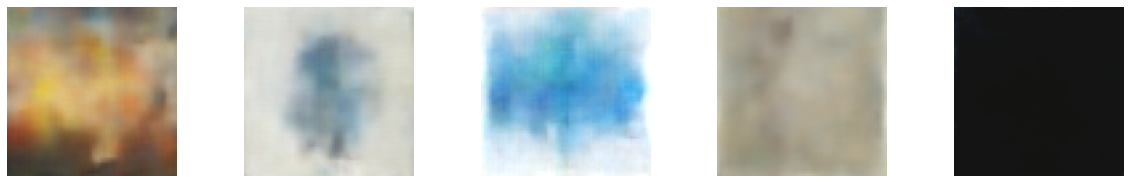

In [87]:
# Passing random noise from standard distribution with latent dim to decoder
import matplotlib.pyplot as plt
def vae_generate_images(n_to_show=5): 
     reconst_images = decoder_model.predict(np.random.normal(0,1,size=(n_to_show,32)))

     fig = plt.figure(figsize=(20, 20))
     fig.subplots_adjust(hspace=0.4, wspace=0.4)

     for i in range(n_to_show):
          img = reconst_images[i].squeeze()
          sub = fig.add_subplot(2, n_to_show, i+1)
          sub.axis('off')        
          sub.imshow(img)

vae_generate_images(n_to_show=5)  

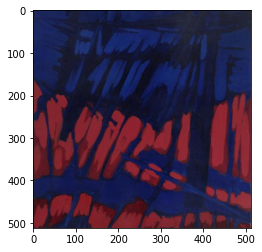

In [57]:
img = plt.imread(images[5])
plt.imshow(img)